In [1]:
##############
#K. David Roell CFPB 7/12/16
#expands data selection for quality edits to include context for developing statistical approaches
#will attemtp to segment mortgage market participants by loan activity by:
#volume/count of lending, income of applicants, securitization, property type and other factors
##############
from collections import OrderedDict
import json
import os
import pandas as pd
import psycopg2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from math import sqrt
get_ipython().magic(u'matplotlib inline')
matplotlib.style.use('ggplot')
#from macro_sql import Q076 
with open('../quality_sql.json') as f: #FIXME change to quality_sql.json and refactor the rest of code
    edit_sql = json.load(f)
    
#parameter format for local use #consider changing hmdamaster to roellk if db changes cause a fail
params = {
'dbname':'hmdamaster',
'user':'roellk',
'password':'',
'host':'localhost',
}

try:
    conn = psycopg2.connect(**params)
    cur = conn.cursor()
    print("i'm connected")

except psycopg2.Error as e: #if database connection results in an error print the following
    print("I am unable to connect to the database: ", e)

i'm connected


In [2]:
#load single bank data as dataframe
loanType='all'
bank_df = pd.read_csv('../data/income_to_amount_dist__{loanType}.csv'.format(loanType=loanType))
inc_df = bank_df.copy() # split income df out to sort values by income for graphing cumulative income percent
#these data are for single family, conventional, owner occupied, first lien, home purchase loans at the national level
#other analysis will be used for each loan product, lien status, geography, and other variables as appropriate

In [3]:
#sort data frame by amount field, this is useful because multiple years are present
bank_df.sort_values(by='amount', inplace=True)
inc_df.sort_values(by='income', inplace=True)
inc_df.head()

year  income  amount
0       2014       1       1
803511  2010       1      46
803512  2010       1      47
803513  2010       1      48
803514  2010       1      49

In [4]:
#bank_df = bank_df[bank_df.year == 2014].copy() #select single year
bank_df.income = bank_df.income.map(int) #convert data to numeric
bank_df.amount = bank_df.amount.map(int) #convert data to numeric
bank_df['mult'] = bank_df.amount/bank_df.income #create amount to income multiple

#create percent and cumulative percents by value
bank_df['pct_amt'] = bank_df['amount']/bank_df['amount'].sum() #calculate percent of total amount for each row
bank_df['cumul_amt_pct'] = bank_df.pct_amt.cumsum() #add cumulative percent of loan amount by value
bank_df['pct_inc'] = bank_df['income']/bank_df['income'].sum()
bank_df['cumul_inc_pct'] = bank_df.pct_inc.cumsum() #add cumulative percent of income by value

#create percent and cumulative percents by count and count times amount
cnt_amt_df = pd.DataFrame(bank_df.groupby(['amount']).pct_amt.count())
cnt_amt_df.rename(columns={'pct_amt':'count_amt'}, inplace=True)
cnt_amt_df['amount'] = cnt_amt_df.index
cnt_amt_df['pct_of_cnt'] = cnt_amt_df.count_amt.divide(other=cnt_amt_df.count_amt.sum())
cnt_amt_df['cumul_pct_cnt'] = cnt_amt_df.pct_of_cnt.cumsum()

#create percent and cumulative percents by value
inc_df['pct_amt'] = inc_df['amount']/inc_df['amount'].sum() #calculate percent of total amount for each row
inc_df['cumul_amt_pct'] = inc_df.pct_amt.cumsum() #add cumulative percent of loan amount by value
inc_df['pct_inc'] = inc_df['income']/inc_df['income'].sum()
inc_df['cumul_inc_pct'] = inc_df.pct_inc.cumsum() #add cumulative percent of income by value

#create percent and cumulative percents by count and count times amount
total = inc_df.groupby(['income']).pct_inc.count().sum()

#create percent and cumulative percents by count and count times amount
cnt_inc_df = pd.DataFrame(inc_df.groupby(['income']).pct_inc.count())
cnt_inc_df.rename(columns={'pct_inc':'count_inc'}, inplace=True)
cnt_inc_df['income'] = cnt_inc_df.index
cnt_inc_df['pct_of_cnt'] = cnt_inc_df.count_inc.divide(other=cnt_inc_df.count_inc.sum())
cnt_inc_df['cumul_pct_cnt'] = cnt_inc_df.pct_of_cnt.cumsum()



582.78309323 std
538.235988543 mean
416.0 median
6000.0 max mult
0.000357142857143 min mult
1995.0 98%
675.0 q3
231.0 q1
37.0 02%
444.0 iqr
-435.0 min_q 1341.0 max_q


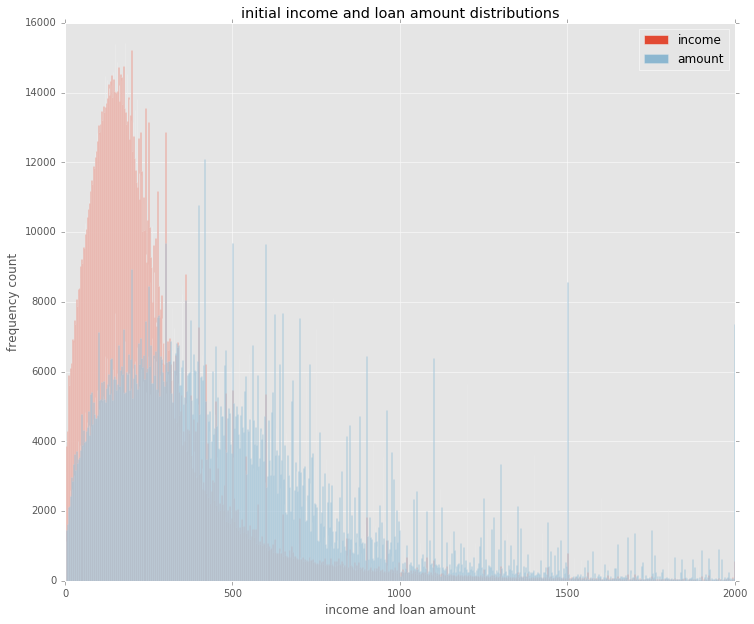

In [5]:
#calculate descriptive stats
print(bank_df.amount.std(), 'std') 
print(bank_df.amount.mean(), 'mean') 
print(bank_df.amount.median(), 'median')
print(bank_df.mult.max(), 'max mult')
print(bank_df.mult.min(), 'min mult')
print(bank_df.amount.quantile(q=.98), '98%')
print(bank_df.amount.quantile(q=.75), 'q3')
print(bank_df.amount.quantile(q=.25), 'q1')
print(bank_df.amount.quantile(q=.02), '02%')
q1 = bank_df.amount.quantile(q=.25)
q3 = bank_df.amount.quantile(q=.75)
q98 = bank_df.amount.quantile(q=.98) #potential upper bound for quality
q2 = bank_df.amount.quantile(q=.02) #potential lower bound for quality
iqr =(q3 - q1)
print(iqr, 'iqr')
min_q = q1 - 1.5 * iqr #potential lower bound for quality
max_q = q3 + 1.5 * iqr #potential upper bound for quality
print(min_q, 'min_q', max_q, 'max_q')


amt = bank_df.amount #get data as series for graphing
inc = bank_df.income #get data as series for graphing
bins = np.linspace(0,2000, 1000) #set ranges and number of bins
bank_viz = plt.figure(figsize=(12,10)) #set plot size
plt.hist(inc, bins, label='income', alpha=1) #plot histogram of income
plt.hist(amt, bins, label='amount', alpha=.5) #plot histogram of loan amount
plt.legend(loc='upper right') #turn on legend and set location
plt.title('initial income and loan amount distributions')
plt.xlabel('income and loan amount')
plt.ylabel('frequency count')
plt.show()
#FIXME add 2 box plot viz



iteration 1
name 0 to 20
std 97.3993246928
mean 139.090430981
median 121.0
max_mult 432.0
med_mult 11.428571428571429
min_mult 0.0526315789474
q98 387.0
q02 7.0
q75 195.0
q25 62.0
iqr 133.0
min_q -137.5
max_q 394.5
count of loans 46101
pct of total loans 1.99879987895


iteration 2
name 0 to 20
std 91.3856404639
mean 134.406831867
median 119.0
max_mult 392.0
med_mult 11.210526315789474
min_mult 0.0526315789474
q98 355.42
q02 7.0
q75 190.0
q25 61.0
iqr 129.0
min_q -132.5
max_q 383.5
count of loans 46101
pct of total loans 1.99879987895


iteration 3
name 0 to 20
std 89.9456704595
mean 133.234865758
median 118.0
max_mult 383.0
med_mult 11.142857142857142
min_mult 0.0526315789474
q98 350.0
q02 7.0
q75 189.0
q25 61.0
iqr 128.0
min_q -131.0
max_q 381.0
count of loans 46101
pct of total loans 1.99879987895


iteration 4
name 0 to 20
std 89.6868142332
mean 133.020328327
median 118.0
max_mult 380.0
med_mult 11.133333333333333
min_mult 0.0526315789474
q98 349.0
q02 7.0
q75 189.0
q25 61.0
iqr 

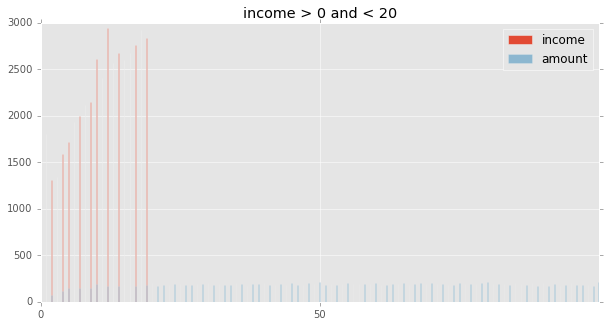



iteration 1
name 20 to 50
std 118.654740377
mean 184.072831876
median 172.0
max_mult 27.35
med_mult 4.977777777777778
min_mult 0.0204081632653
q98 463.0
q02 8.0
q75 264.0
q25 87.0
iqr 177.0
min_q -178.5
max_q 529.5
count of loans 115479
pct of total loans 5.00682005208


iteration 2
name 20 to 50
std 117.260697031
mean 183.031413846
median 171.0
max_mult 26.25
med_mult 4.966666666666667
min_mult 0.0204081632653
q98 452.0
q02 8.0
q75 263.0
q25 87.0
iqr 176.0
min_q -177.0
max_q 527.0
count of loans 115479
pct of total loans 5.00682005208


iteration 3
name 20 to 50
std 117.07207099
mean 182.886569565
median 171.0
max_mult 26.25
med_mult 4.964285714285714
min_mult 0.0204081632653
q98 450.82
q02 8.0
q75 263.0
q25 87.0
iqr 176.0
min_q -177.0
max_q 527.0
count of loans 115479
pct of total loans 5.00682005208


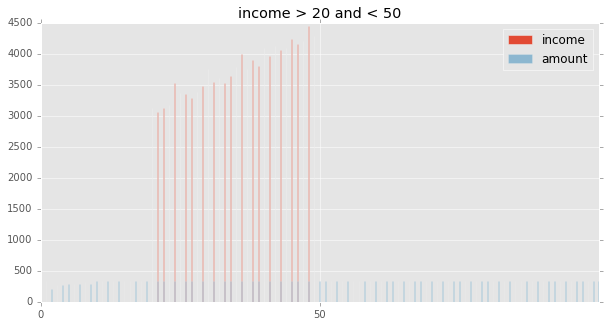



iteration 1
name 50 to 80
std 148.714818455
mean 244.098320775
median 236.0
max_mult 14.06
med_mult 3.6527777777777777
min_mult 0.0126582278481
q98 575.0
q02 14.0
q75 352.0
q25 120.0
iqr 232.0
min_q -228.0
max_q 700.0
count of loans 154011
pct of total loans 6.67745099144


iteration 2
name 50 to 80
std 148.056118522
mean 243.620252081
median 235.0
max_mult 13.96
med_mult 3.6481481481481484
min_mult 0.0126582278481
q98 570.0
q02 14.0
q75 351.0
q25 120.0
iqr 231.0
min_q -226.5
max_q 697.5
count of loans 154011
pct of total loans 6.67745099144


iteration 3
name 50 to 80
std 147.965680872
mean 243.554402849
median 235.0
max_mult 13.92
med_mult 3.647887323943662
min_mult 0.0126582278481
q98 570.0
q02 14.0
q75 351.0
q25 120.0
iqr 231.0
min_q -226.5
max_q 697.5
count of loans 154011
pct of total loans 6.67745099144


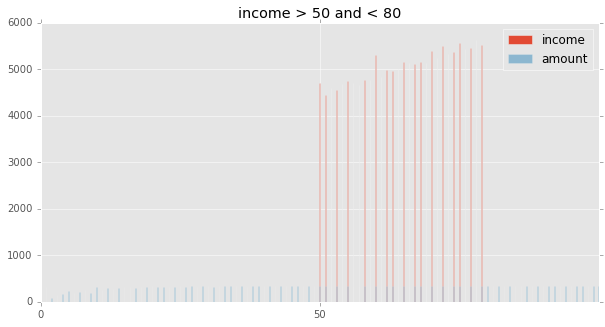



iteration 1
name 80 to 110
std 176.276878467
mean 302.54054127
median 295.0
max_mult 10.625
med_mult 3.1192660550458715
min_mult 0.00917431192661
q98 663.0
q02 24.0
q75 436.0
q25 154.0
iqr 282.0
min_q -269.0
max_q 859.0
count of loans 186685
pct of total loans 8.0940967745


iteration 2
name 80 to 110
std 176.082254051
mean 302.404577351
median 295.0
max_mult 10.625
med_mult 3.118811881188119
min_mult 0.00917431192661
q98 662.0
q02 24.0
q75 436.0
q25 154.0
iqr 282.0
min_q -269.0
max_q 859.0
count of loans 186685
pct of total loans 8.0940967745


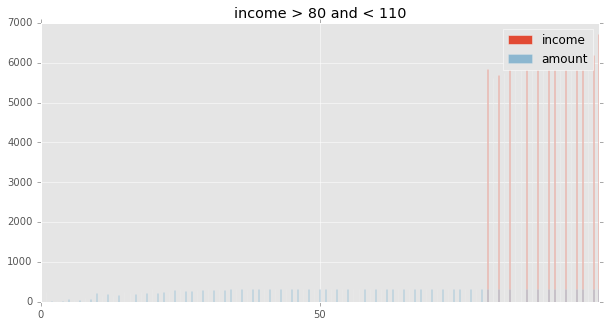



iteration 1
name 110 to 140
std 198.720890806
mean 352.615827692
median 343.0
max_mult 8.94545454545
med_mult 2.7560975609756095
min_mult 0.00719424460432
q98 754.0
q02 35.0
q75 504.0
q25 186.0
iqr 318.0
min_q -291.0
max_q 981.0
count of loans 208324
pct of total loans 9.03229834454


iteration 2
name 110 to 140
std 198.651179996
mean 352.567087715
median 343.0
max_mult 8.90909090909
med_mult 2.7560975609756095
min_mult 0.00719424460432
q98 753.0
q02 35.0
q75 504.0
q25 186.0
iqr 318.0
min_q -291.0
max_q 981.0
count of loans 208324
pct of total loans 9.03229834454


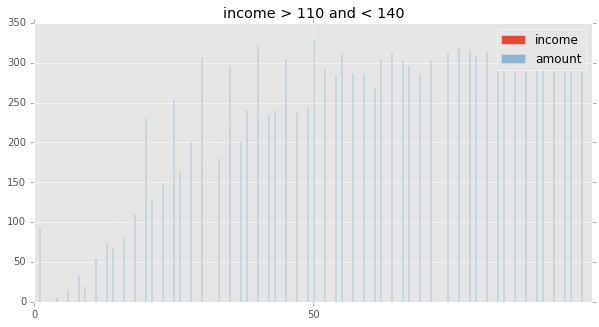



iteration 1
name 140 to 170
std 216.280434874
mean 394.423041311
median 379.0
max_mult 7.6
med_mult 2.45578231292517
min_mult 0.00591715976331
q98 862.0
q02 50.0
q75 554.0
q25 216.0
iqr 338.0
min_q -291.0
max_q 1061.0
count of loans 215154
pct of total loans 9.32842648001


iteration 2
name 140 to 170
std 216.206710602
mean 394.369839822
median 379.0
max_mult 7.51773049645
med_mult 2.45578231292517
min_mult 0.00591715976331
q98 860.0
q02 50.0
q75 554.0
q25 216.0
iqr 338.0
min_q -291.0
max_q 1061.0
count of loans 215154
pct of total loans 9.32842648001


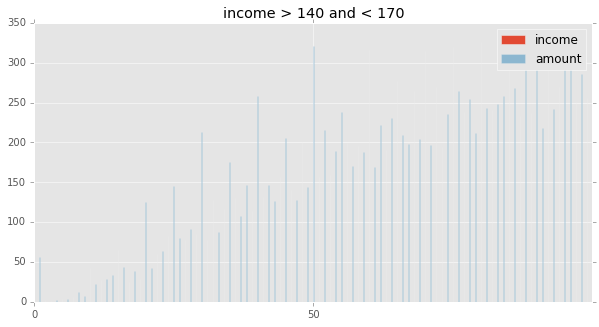



iteration 1
name 170 to 200
std 230.952073638
mean 431.937473762
median 409.0
max_mult 6.65294117647
med_mult 2.2267441860465116
min_mult 0.00502512562814
q98 950.0
q02 63.0
q75 596.0
q25 246.0
iqr 350.0
min_q -279.0
max_q 1121.0
count of loans 206571
pct of total loans 8.95629356834


iteration 2
name 170 to 200
std 230.494503438
mean 431.595320307
median 409.0
max_mult 6.58823529412
med_mult 2.225806451612903
min_mult 0.00502512562814
q98 948.0
q02 63.0
q75 596.0
q25 246.0
iqr 350.0
min_q -279.0
max_q 1121.0
count of loans 206571
pct of total loans 8.95629356834


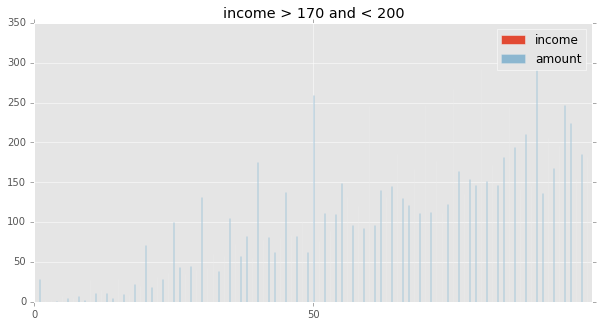



iteration 1
name 200 to 230
std 247.791386046
mean 470.837471366
median 446.0
max_mult 6.025
med_mult 2.0844444444444443
min_mult 0.00442477876106
q98 1020.0
q02 75.0
q75 640.0
q25 274.0
iqr 366.0
min_q -275.0
max_q 1189.0
count of loans 185926
pct of total loans 8.0611888309


iteration 2
name 200 to 230
std 245.902600014
mean 469.390217972
median 446.0
max_mult 5.94
med_mult 2.080568720379147
min_mult 0.00442477876106
q98 1000.0
q02 75.0
q75 640.0
q25 274.0
iqr 366.0
min_q -275.0
max_q 1189.0
count of loans 185926
pct of total loans 8.0611888309


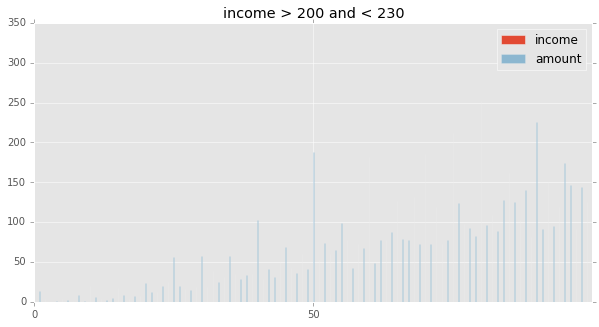



iteration 1
name 230 to 260
std 266.786819179
mean 508.925562232
median 486.0
max_mult 5.63043478261
med_mult 1.9916666666666667
min_mult 0.00395256916996
q98 1121.0
q02 85.0
q75 688.0
q25 298.0
iqr 390.0
min_q -287.0
max_q 1273.0
count of loans 154381
pct of total loans 6.69349307199


iteration 2
name 230 to 260
std 264.405364769
mean 507.076621123
median 485.0
max_mult 5.53043478261
med_mult 1.9873949579831933
min_mult 0.00395256916996
q98 1108.0
q02 84.0
q75 687.0
q25 298.0
iqr 389.0
min_q -285.5
max_q 1270.5
count of loans 154381
pct of total loans 6.69349307199


iteration 3
name 230 to 260
std 264.264106809
mean 506.965662631
median 485.0
max_mult 5.51304347826
med_mult 1.9872881355932204
min_mult 0.00395256916996
q98 1108.0
q02 84.0
q75 686.0
q25 297.0
iqr 389.0
min_q -286.5
max_q 1269.5
count of loans 154381
pct of total loans 6.69349307199


iteration 4
name 230 to 260
std 264.161715368
mean 506.885098885
median 485.0
max_mult 5.51304347826
med_mult 1.9872340425531916
min_m

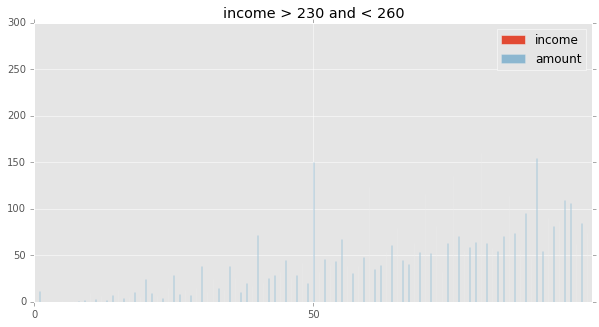



iteration 1
name 260 to 290
std 286.875250353
mean 545.728631484
median 520.0
max_mult 5.28846153846
med_mult 1.9
min_mult 0.00353356890459
q98 1220.0
q02 94.0
q75 730.0
q25 320.0
iqr 410.0
min_q -295.0
max_q 1345.0
count of loans 124780
pct of total loans 5.41008327141


iteration 2
name 260 to 290
std 283.290068093
mean 542.862771761
median 519.0
max_mult 5.16923076923
med_mult 1.8943661971830985
min_mult 0.00353356890459
q98 1200.0
q02 94.0
q75 728.0
q25 319.0
iqr 409.0
min_q -294.5
max_q 1341.5
count of loans 124780
pct of total loans 5.41008327141


iteration 3
name 260 to 290
std 283.127716514
mean 542.731545054
median 519.0
max_mult 5.15384615385
med_mult 1.8940767584018983
min_mult 0.00353356890459
q98 1200.0
q02 94.0
q75 728.0
q25 319.0
iqr 409.0
min_q -294.5
max_q 1341.5
count of loans 124780
pct of total loans 5.41008327141


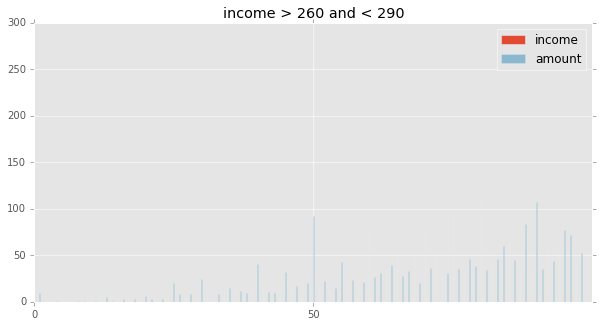



iteration 1
name 290 to 320
std 320.868277153
mean 592.313445724
median 560.0
max_mult 5.1724137931
med_mult 1.8424657534246576
min_mult 0.00324675324675
q98 1350.0
q02 97.0
q75 795.0
q25 339.0
iqr 456.0
min_q -345.0
max_q 1479.0
count of loans 101125
pct of total loans 4.38447404088


iteration 2
name 290 to 320
std 315.564760616
mean 588.05900571
median 557.0
max_mult 5.08275862069
med_mult 1.8360655737704918
min_mult 0.00324675324675
q98 1325.0
q02 97.0
q75 790.0
q25 338.0
iqr 452.0
min_q -340.0
max_q 1468.0
count of loans 101125
pct of total loans 4.38447404088


iteration 3
name 290 to 320
std 314.471169493
mean 587.166532022
median 556.5
max_mult 5.04482758621
med_mult 1.8344263352541499
min_mult 0.00324675324675
q98 1320.0
q02 97.0
q75 789.0
q25 337.0
iqr 452.0
min_q -341.0
max_q 1467.0
count of loans 101125
pct of total loans 4.38447404088


iteration 4
name 290 to 320
std 314.427797051
mean 587.130991093
median 556.0
max_mult 5.04482758621
med_mult 1.8344155844155845
min_mul

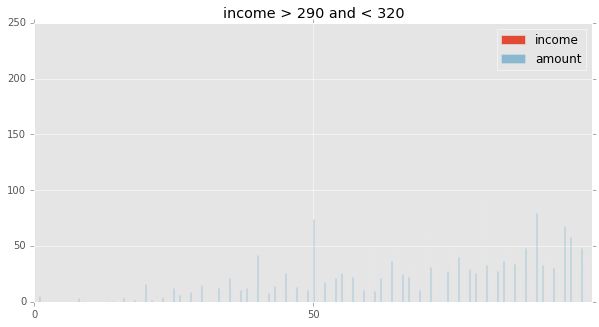



iteration 1
name 320 to 350
std 343.381126865
mean 630.05421982
median 592.0
max_mult 5.084375
med_mult 1.7774480712166172
min_mult 0.00290697674419
q98 1440.0
q02 101.0
q75 850.0
q25 356.0
iqr 494.0
min_q -385.0
max_q 1591.0
count of loans 80861
pct of total loans 3.5058883107


iteration 2
name 320 to 350
std 339.614592853
mean 627.054134466
median 592.0
max_mult 4.96875
med_mult 1.772594752186589
min_mult 0.00290697674419
q98 1425.0
q02 101.0
q75 848.0
q25 356.0
iqr 492.0
min_q -382.0
max_q 1586.0
count of loans 80861
pct of total loans 3.5058883107


iteration 3
name 320 to 350
std 339.343697407
mean 626.835781748
median 592.0
max_mult 4.953125
med_mult 1.7723076923076924
min_mult 0.00290697674419
q98 1425.0
q02 101.0
q75 848.0
q25 356.0
iqr 492.0
min_q -382.0
max_q 1586.0
count of loans 80861
pct of total loans 3.5058883107


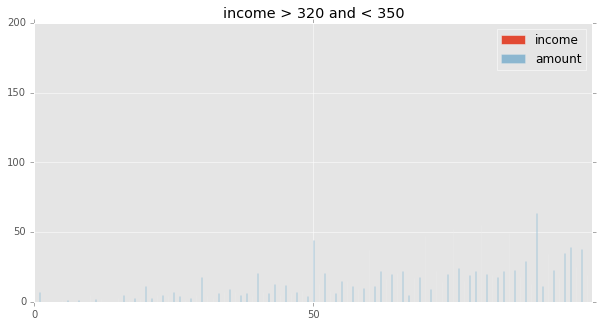



iteration 1
name 350 to 380
std 368.917585419
mean 658.763631842
median 615.0
max_mult 4.98285714286
med_mult 1.6910112359550562
min_mult 0.00268817204301
q98 1500.0
q02 100.0
q75 898.0
q25 363.0
iqr 535.0
min_q -439.5
max_q 1700.5
count of loans 69671
pct of total loans 3.02072376665


iteration 2
name 350 to 380
std 365.768217907
mean 656.29853504
median 614.0
max_mult 4.85714285714
med_mult 1.6888888888888889
min_mult 0.00268817204301
q98 1500.0
q02 100.0
q75 895.0
q25 362.0
iqr 533.0
min_q -437.5
max_q 1694.5
count of loans 69671
pct of total loans 3.02072376665


iteration 3
name 350 to 380
std 364.114739222
mean 654.981338188
median 613.0
max_mult 4.82857142857
med_mult 1.6876712328767123
min_mult 0.00268817204301
q98 1496.0
q02 100.0
q75 893.0
q25 362.0
iqr 531.0
min_q -434.5
max_q 1689.5
count of loans 69671
pct of total loans 3.02072376665


iteration 4
name 350 to 380
std 363.830013773
mean 654.753128121
median 613.0
max_mult 4.82571428571
med_mult 1.6873277400250561
min_mu

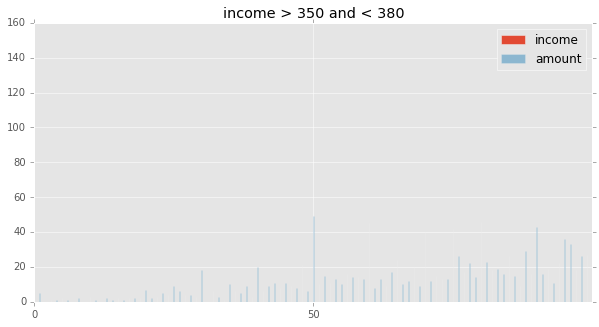



iteration 1
name 380 to 410
std 391.882839015
mean 690.3284982
median 637.5
max_mult 4.7874015748
med_mult 1.613551348900476
min_mult 0.0025
q98 1600.0
q02 102.0
q75 943.0
q25 375.0
iqr 568.0
min_q -477.0
max_q 1795.0
count of loans 56112
pct of total loans 2.43284655013


iteration 2
name 380 to 410
std 387.502981138
mean 686.850299947
median 635.0
max_mult 4.70526315789
med_mult 1.6105263157894736
min_mult 0.0025
q98 1590.16
q02 102.0
q75 940.0
q25 375.0
iqr 565.0
min_q -472.5
max_q 1787.5
count of loans 56112
pct of total loans 2.43284655013


iteration 3
name 380 to 410
std 387.126037841
mean 686.548478879
median 635.0
max_mult 4.69736842105
med_mult 1.6103896103896105
min_mult 0.0025
q98 1585.46
q02 102.0
q75 939.25
q25 375.0
iqr 564.25
min_q -471.375
max_q 1785.625
count of loans 56112
pct of total loans 2.43284655013


iteration 4
name 380 to 410
std 387.101038908
mean 686.528407536
median 635.0
max_mult 4.69736842105
med_mult 1.6103896103896105
min_mult 0.0025
q98 1585.0
q02 

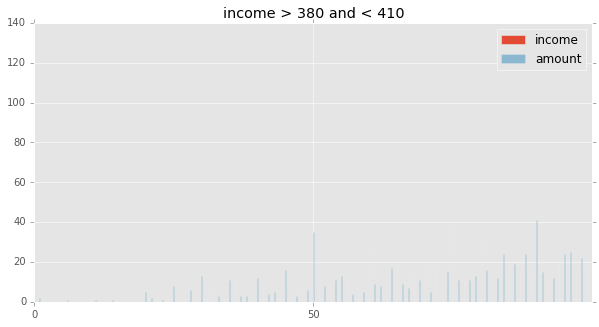



iteration 1
name 410 to 440
std 421.513700375
mean 732.633754896
median 675.0
max_mult 4.69512195122
med_mult 1.591647331786543
min_mult 0.00231481481481
q98 1725.0
q02 102.0
q75 996.0
q25 394.0
iqr 602.0
min_q -509.0
max_q 1899.0
count of loans 45579
pct of total loans 1.97616753829


iteration 2
name 410 to 440
std 416.76116548
mean 728.785807321
median 673.0
max_mult 4.62682926829
med_mult 1.5857142857142856
min_mult 0.00231481481481
q98 1700.0
q02 102.0
q75 994.0
q25 393.0
iqr 601.0
min_q -508.5
max_q 1895.5
count of loans 45579
pct of total loans 1.97616753829


iteration 3
name 410 to 440
std 416.6328885
mean 728.680905538
median 673.0
max_mult 4.61463414634
med_mult 1.5857142857142856
min_mult 0.00231481481481
q98 1700.0
q02 102.0
q75 994.0
q25 393.0
iqr 601.0
min_q -508.5
max_q 1895.5
count of loans 45579
pct of total loans 1.97616753829


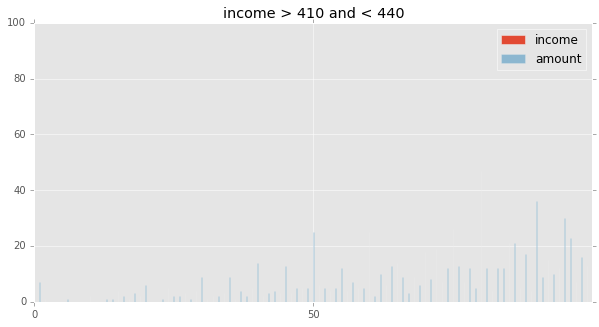



iteration 1
name 440 to 470
std 451.740609298
mean 763.269958738
median 697.0
max_mult 4.67800453515
med_mult 1.5317286652078774
min_mult 0.00226757369615
q98 1855.0
q02 102.0
q75 1040.0
q25 400.0
iqr 640.0
min_q -560.0
max_q 2000.0
count of loans 38168
pct of total loans 1.65484900067


iteration 2
name 440 to 470
std 440.52088171
mean 754.089353714
median 692.0
max_mult 4.52607709751
med_mult 1.5217391304347827
min_mult 0.00226757369615
q98 1792.0
q02 102.0
q75 1020.0
q25 400.0
iqr 620.0
min_q -530.0
max_q 1950.0
count of loans 38168
pct of total loans 1.65484900067


iteration 3
name 440 to 470
std 433.351469215
mean 748.19205066
median 689.0
max_mult 4.41590909091
med_mult 1.5159502810622212
min_mult 0.00226757369615
q98 1752.0
q02 101.18
q75 1010.0
q25 398.0
iqr 612.0
min_q -520.0
max_q 1928.0
count of loans 38168
pct of total loans 1.65484900067


iteration 4
name 440 to 470
std 431.507389037
mean 746.650180778
median 688.0
max_mult 4.37045454545
med_mult 1.5138680733583119
min

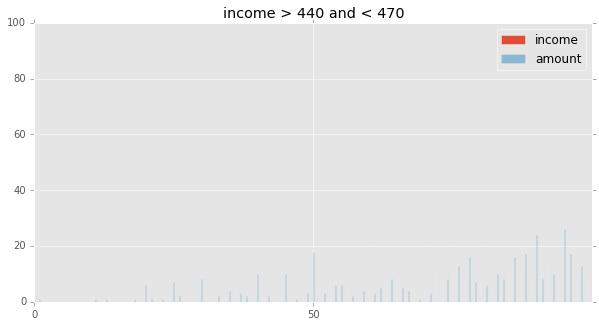



iteration 1
name 470 to 500
std 474.60476782
mean 789.391856227
median 711.0
max_mult 4.6186440678
med_mult 1.4698187912942091
min_mult 0.0020325203252
q98 1932.92
q02 100.0
q75 1098.0
q25 405.0
iqr 693.0
min_q -634.5
max_q 2137.5
count of loans 32368
pct of total loans 1.40337854888


iteration 2
name 470 to 500
std 470.611170653
mean 786.278435571
median 710.0
max_mult 4.49576271186
med_mult 1.4675052410901468
min_mult 0.0020325203252
q98 1914.9
q02 100.0
q75 1090.0
q25 404.0
iqr 686.0
min_q -625.0
max_q 2119.0
count of loans 32368
pct of total loans 1.40337854888


iteration 3
name 470 to 500
std 469.873441505
mean 785.687732342
median 709.0
max_mult 4.46808510638
med_mult 1.46723044397463
min_mult 0.0020325203252
q98 1910.0
q02 100.0
q75 1088.0
q25 404.0
iqr 684.0
min_q -622.0
max_q 2114.0
count of loans 32368
pct of total loans 1.40337854888


iteration 4
name 470 to 500
std 469.873441505
mean 785.687732342
median 709.0
max_mult 4.46808510638
med_mult 1.46723044397463
min_mult 0

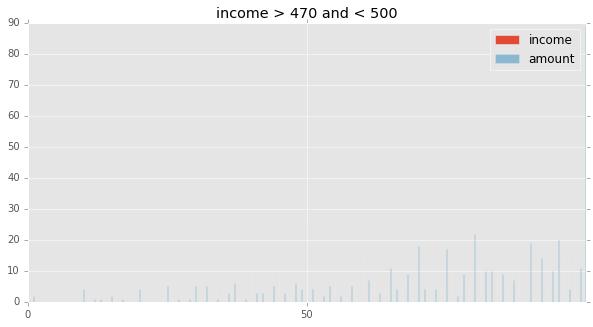



iteration 1
name 500 to 530
std 500.785129566
mean 823.394193015
median 732.0
max_mult 4.66
med_mult 1.4326649394249014
min_mult 0.00196078431373
q98 2000.0
q02 107.66
q75 1145.0
q25 416.0
iqr 729.0
min_q -677.5
max_q 2238.5
count of loans 29552
pct of total loans 1.28128530884


iteration 2
name 500 to 530
std 491.759315141
mean 816.475931758
median 730.0
max_mult 4.452
med_mult 1.4285714285714286
min_mult 0.00196078431373
q98 1990.08
q02 107.0
q75 1133.0
q25 415.0
iqr 718.0
min_q -662.0
max_q 2210.0
count of loans 29552
pct of total loans 1.28128530884


iteration 3
name 500 to 530
std 490.418435162
mean 815.406891775
median 730.0
max_mult 4.4
med_mult 1.4274661508704063
min_mult 0.00196078431373
q98 1980.0
q02 107.0
q75 1130.0
q25 415.0
iqr 715.0
min_q -657.5
max_q 2202.5
count of loans 29552
pct of total loans 1.28128530884


iteration 4
name 500 to 530
std 490.119587181
mean 815.166158642
median 730.0
max_mult 4.4
med_mult 1.4272030651340997
min_mult 0.00196078431373
q98 1980.0


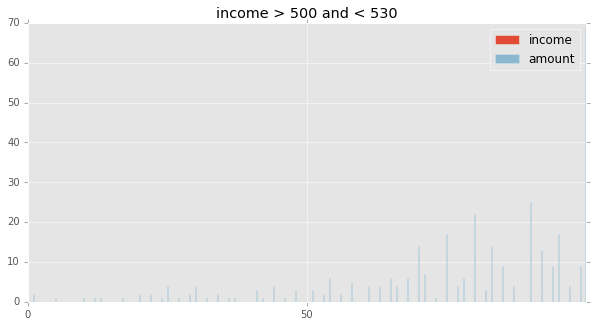



iteration 1
name 530 to 560
std 526.803567138
mean 849.764463872
median 750.0
max_mult 4.59510357815
med_mult 1.3761467889908257
min_mult 0.0179211469534
q98 2100.0
q02 104.0
q75 1200.0
q25 417.0
iqr 783.0
min_q -757.5
max_q 2374.5
count of loans 23776
pct of total loans 1.03085542443


iteration 2
name 530 to 560
std 519.818282022
mean 844.478735756
median 750.0
max_mult 4.45009416196
med_mult 1.3736263736263736
min_mult 0.0179211469534
q98 2031.0
q02 104.0
q75 1196.0
q25 417.0
iqr 779.0
min_q -751.5
max_q 2364.5
count of loans 23776
pct of total loans 1.03085542443


iteration 3
name 530 to 560
std 519.733181682
mean 844.413133224
median 750.0
max_mult 4.45009416196
med_mult 1.3734073897117376
min_mult 0.0179211469534
q98 2030.94
q02 104.0
q75 1196.0
q25 417.0
iqr 779.0
min_q -751.5
max_q 2364.5
count of loans 23776
pct of total loans 1.03085542443


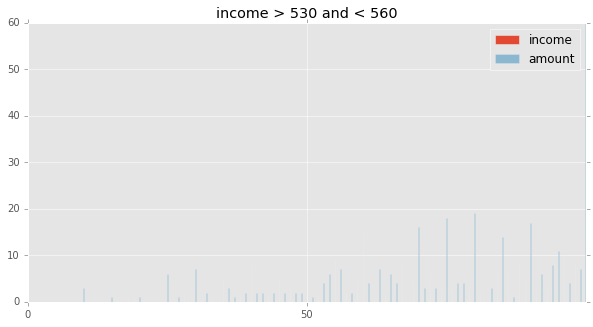



iteration 1
name 560 to 590
std 545.810129135
mean 882.700852452
median 784.0
max_mult 4.46428571429
med_mult 1.361501748761294
min_mult 0.00520833333333
q98 2190.0
q02 105.0
q75 1244.25
q25 423.0
iqr 821.25
min_q -808.875
max_q 2476.125
count of loans 19260
pct of total loans 0.835055327835


iteration 2
name 560 to 590
std 539.037525239
mean 877.584776182
median 780.0
max_mult 4.35943060498
med_mult 1.3573281335572127
min_mult 0.00520833333333
q98 2138.0
q02 104.0
q75 1240.0
q25 420.0
iqr 820.0
min_q -810.0
max_q 2470.0
count of loans 19260
pct of total loans 0.835055327835


iteration 3
name 560 to 590
std 538.263333183
mean 876.994983366
median 780.0
max_mult 4.35943060498
med_mult 1.3571428571428572
min_mult 0.00520833333333
q98 2125.28
q02 104.0
q75 1240.0
q25 420.0
iqr 820.0
min_q -810.0
max_q 2470.0
count of loans 19260
pct of total loans 0.835055327835


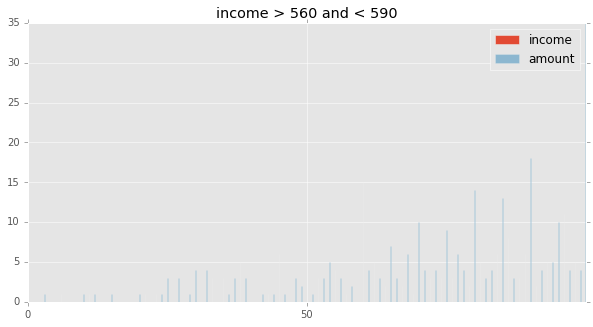



iteration 1
name 590 to 620
std 572.967818776
mean 900.539311585
median 793.0
max_mult 4.39932318105
med_mult 1.310569105691057
min_mult 0.0016583747927
q98 2275.0
q02 100.0
q75 1275.0
q25 417.0
iqr 858.0
min_q -870.0
max_q 2562.0
count of loans 19241
pct of total loans 0.834231545321


iteration 2
name 590 to 620
std 568.847804427
mean 897.403856341
median 791.0
max_mult 4.33164128596
med_mult 1.3071895424836601
min_mult 0.0016583747927
q98 2250.0
q02 100.0
q75 1271.0
q25 417.0
iqr 854.0
min_q -864.0
max_q 2552.0
count of loans 19241
pct of total loans 0.834231545321


iteration 3
name 590 to 620
std 567.256695099
mean 896.171543681
median 790.0
max_mult 4.30743243243
med_mult 1.3066666666666666
min_mult 0.0016583747927
q98 2250.0
q02 100.0
q75 1270.0
q25 417.0
iqr 853.0
min_q -862.5
max_q 2549.5
count of loans 19241
pct of total loans 0.834231545321


iteration 4
name 590 to 620
std 566.239797256
mean 895.382126757
median 790.0
max_mult 4.26510067114
med_mult 1.3066666666666666
min

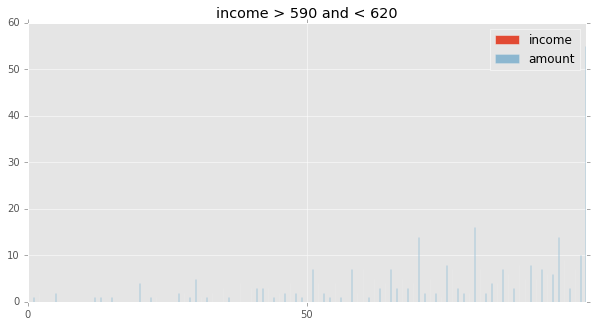



iteration 1
name 620 to 650
std 590.942372932
mean 924.618977488
median 800.0
max_mult 4.33386837881
med_mult 1.2784
min_mult 0.00156494522692
q98 2400.0
q02 103.0
q75 1304.0
q25 420.0
iqr 884.0
min_q -906.0
max_q 2630.0
count of loans 14512
pct of total loans 0.629196413164


iteration 2
name 620 to 650
std 584.117137323
mean 919.456144053
median 800.0
max_mult 4.21348314607
med_mult 1.274478330658106
min_mult 0.00156494522692
q98 2327.72
q02 102.32
q75 1300.0
q25 420.0
iqr 880.0
min_q -900.0
max_q 2620.0
count of loans 14512
pct of total loans 0.629196413164


iteration 3
name 620 to 650
std 582.412990917
mean 918.136139659
median 800.0
max_mult 4.1935483871
med_mult 1.2738853503184713
min_mult 0.00156494522692
q98 2320.0
q02 102.1
q75 1300.0
q25 420.0
iqr 880.0
min_q -900.0
max_q 2620.0
count of loans 14512
pct of total loans 0.629196413164


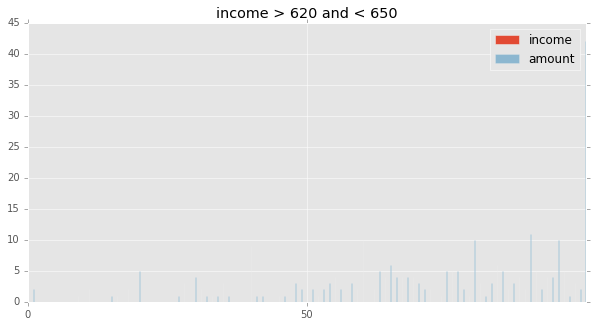



iteration 1
name 650 to 680
std 617.534289801
mean 957.806901032
median 844.0
max_mult 4.30769230769
med_mult 1.2712121212121212
min_mult 0.00150602409639
q98 2470.0
q02 108.0
q75 1360.0
q25 435.0
iqr 925.0
min_q -952.5
max_q 2747.5
count of loans 14090
pct of total loans 0.610899769948


iteration 2
name 650 to 680
std 609.489035485
mean 951.724849714
median 840.0
max_mult 4.18292682927
med_mult 1.2648809523809523
min_mult 0.00150602409639
q98 2414.4
q02 108.0
q75 1354.0
q25 432.0
iqr 922.0
min_q -951.0
max_q 2737.0
count of loans 14090
pct of total loans 0.610899769948


iteration 3
name 650 to 680
std 608.81453407
mean 951.205969717
median 840.0
max_mult 4.18070444104
med_mult 1.264792899408284
min_mult 0.00150602409639
q98 2406.72
q02 108.0
q75 1352.0
q25 432.0
iqr 920.0
min_q -948.0
max_q 2732.0
count of loans 14090
pct of total loans 0.610899769948


iteration 4
name 650 to 680
std 608.81453407
mean 951.205969717
median 840.0
max_mult 4.18070444104
med_mult 1.264792899408284
mi

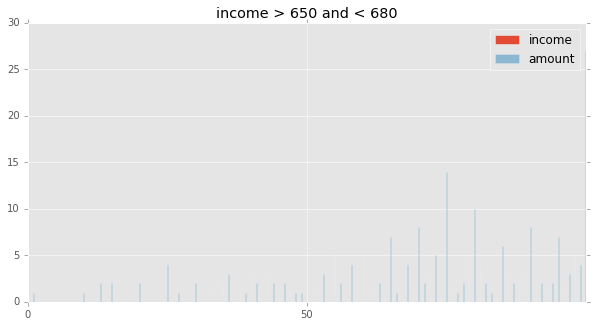



iteration 1
name 680 to 710
std 618.788930244
mean 966.84958832
median 852.0
max_mult 4.11764705882
med_mult 1.2328571428571429
min_mult 0.0113798008535
q98 2500.0
q02 113.6
q75 1360.0
q25 450.0
iqr 910.0
min_q -915.0
max_q 2725.0
count of loans 12026
pct of total loans 0.521410974691


iteration 2
name 680 to 710
std 607.677431167
mean 958.365256695
median 850.0
max_mult 3.97058823529
med_mult 1.2250356125356126
min_mult 0.0113798008535
q98 2419.0
q02 113.0
q75 1352.0
q25 450.0
iqr 902.0
min_q -903.0
max_q 2705.0
count of loans 12026
pct of total loans 0.521410974691


iteration 3
name 680 to 710
std 606.531059636
mean 957.465870307
median 850.0
max_mult 3.97058823529
med_mult 1.2243878060969515
min_mult 0.0113798008535
q98 2414.62
q02 113.0
q75 1351.25
q25 450.0
iqr 901.25
min_q -901.875
max_q 2703.125
count of loans 12026
pct of total loans 0.521410974691


iteration 4
name 680 to 710
std 606.531059636
mean 957.465870307
median 850.0
max_mult 3.97058823529
med_mult 1.2243878060969

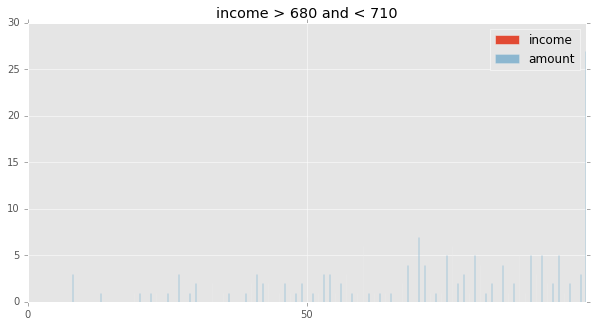



iteration 1
name 710 to 740
std 655.005636331
mean 995.362390453
median 880.0
max_mult 4.16901408451
med_mult 1.2152683166818044
min_mult 0.00138888888889
q98 2582.5
q02 99.0
q75 1425.0
q25 451.0
iqr 974.0
min_q -1010.0
max_q 2886.0
count of loans 10979
pct of total loans 0.476016222446


iteration 2
name 710 to 740
std 644.780196274
mean 987.604043808
median 875.0
max_mult 4.04360056259
med_mult 1.2083333333333333
min_mult 0.00138888888889
q98 2501.08
q02 99.0
q75 1414.0
q25 450.0
iqr 964.0
min_q -996.0
max_q 2860.0
count of loans 10979
pct of total loans 0.476016222446


iteration 3
name 710 to 740
std 640.893986393
mean 984.603318957
median 875.0
max_mult 3.99159663866
med_mult 1.2038303693570451
min_mult 0.00138888888889
q98 2500.0
q02 99.0
q75 1406.0
q25 450.0
iqr 956.0
min_q -984.0
max_q 2840.0
count of loans 10979
pct of total loans 0.476016222446


iteration 4
name 710 to 740
std 638.416715364
mean 982.678366964
median 870.0
max_mult 3.94366197183
med_mult 1.2019099590723057


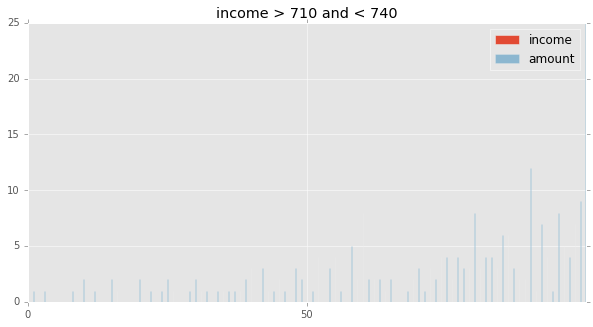



iteration 1
name 740 to 770
std 656.73735867
mean 1008.98664283
median 900.0
max_mult 3.98391420912
med_mult 1.1998677248677247
min_mult 0.0183968462549
q98 2600.0
q02 109.0
q75 1439.0
q25 462.75
iqr 976.25
min_q -1001.625
max_q 2903.375
count of loans 9730
pct of total loans 0.421863361362


iteration 2
name 740 to 770
std 648.989428311
mean 1003.0812322
median 900.0
max_mult 3.89218328841
med_mult 1.1959731543624161
min_mult 0.0183968462549
q98 2563.88
q02 109.0
q75 1431.5
q25 460.0
iqr 971.5
min_q -997.25
max_q 2888.75
count of loans 9730
pct of total loans 0.421863361362


iteration 3
name 740 to 770
std 647.176261481
mean 1001.67937078
median 900.0
max_mult 3.89218328841
med_mult 1.1949779828056197
min_mult 0.0183968462549
q98 2560.0
q02 109.0
q75 1429.25
q25 460.0
iqr 969.25
min_q -993.875
max_q 2883.125
count of loans 9730
pct of total loans 0.421863361362


iteration 4
name 740 to 770
std 646.663646182
mean 1001.28099261
median 900.0
max_mult 3.86522911051
med_mult 1.19459064

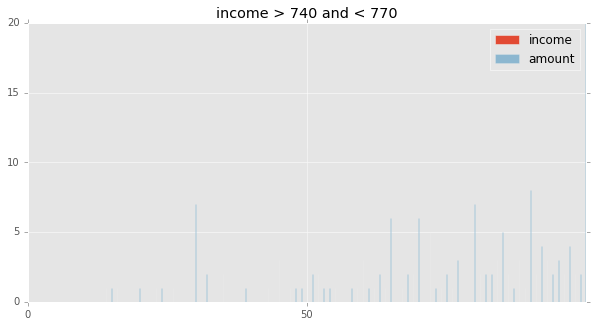



iteration 1
name 770 to 800
std 698.653875242
mean 1052.95467591
median 935.0
max_mult 3.8961038961
med_mult 1.1921387896921147
min_mult 0.0126262626263
q98 2751.34
q02 105.0
q75 1500.0
q25 477.25
iqr 1022.75
min_q -1056.875
max_q 3034.125
count of loans 8526
pct of total loans 0.369661564129


iteration 2
name 770 to 800
std 698.653875242
mean 1052.95467591
median 935.0
max_mult 3.8961038961
med_mult 1.1921387896921147
min_mult 0.0126262626263
q98 2751.34
q02 105.0
q75 1500.0
q25 477.25
iqr 1022.75
min_q -1056.875
max_q 3034.125
count of loans 8526
pct of total loans 0.369661564129


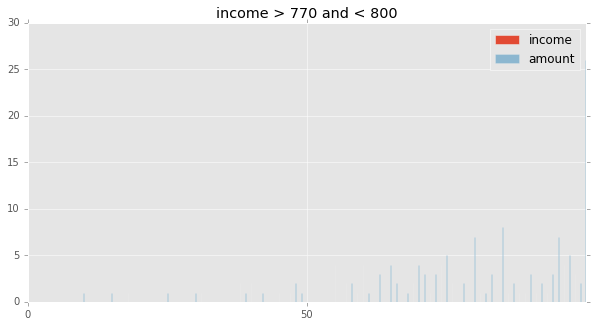



iteration 1
name 800 to 830
std 667.145793077
mean 1030.21153608
median 910.0
max_mult 3.705
med_mult 1.1207970112079702
min_mult 0.0230024213075
q98 2657.76
q02 114.56
q75 1480.0
q25 486.0
iqr 994.0
min_q -1005.0
max_q 2971.0
count of loans 8332
pct of total loans 0.361250311086


iteration 2
name 800 to 830
std 664.319068594
mean 1028.03320942
median 907.5
max_mult 3.705
med_mult 1.1197743080712939
min_mult 0.0230024213075
q98 2640.0
q02 114.38
q75 1475.75
q25 486.0
iqr 989.75
min_q -998.625
max_q 2960.375
count of loans 8332
pct of total loans 0.361250311086


iteration 3
name 800 to 830
std 662.155765561
mean 1026.35359048
median 906.0
max_mult 3.6975
med_mult 1.1180124223602483
min_mult 0.0230024213075
q98 2625.0
q02 114.24
q75 1473.5
q25 486.0
iqr 987.5
min_q -995.25
max_q 2954.75
count of loans 8332
pct of total loans 0.361250311086


iteration 4
name 800 to 830
std 661.228053508
mean 1025.63424318
median 905.0
max_mult 3.6783042394
med_mult 1.117863743672155
min_mult 0.023002

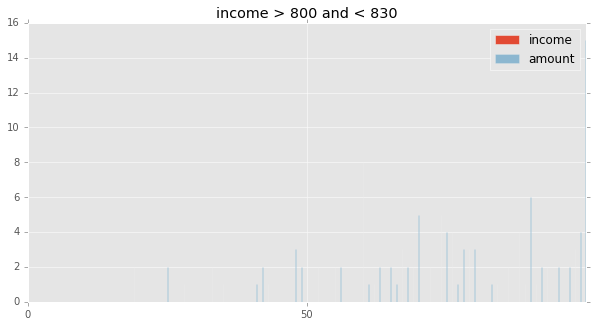



iteration 1
name 830 to 860
std 706.949143749
mean 1052.47836338
median 934.0
max_mult 3.61445783133
med_mult 1.1042676719810731
min_mult 0.0142857142857
q98 2800.0
q02 104.0
q75 1500.0
q25 460.0
iqr 1040.0
min_q -1100.0
max_q 3060.0
count of loans 7385
pct of total loans 0.320191256286


iteration 2
name 830 to 860
std 706.949143749
mean 1052.47836338
median 934.0
max_mult 3.61445783133
med_mult 1.1042676719810731
min_mult 0.0142857142857
q98 2800.0
q02 104.0
q75 1500.0
q25 460.0
iqr 1040.0
min_q -1100.0
max_q 3060.0
count of loans 7385
pct of total loans 0.320191256286


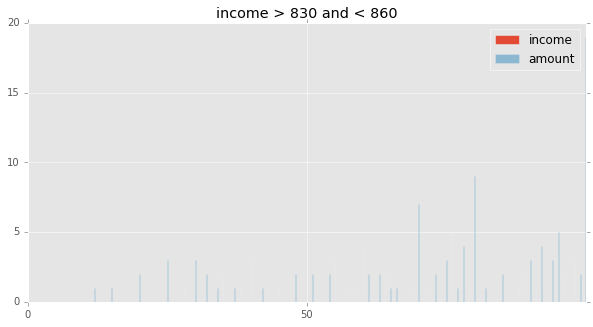



iteration 1
name 860 to 890
std 732.024762755
mean 1076.45027674
median 958.0
max_mult 3.69690011481
med_mult 1.0941043083900226
min_mult 0.0202474690664
q98 2904.0
q02 108.0
q75 1500.0
q25 460.0
iqr 1040.0
min_q -1100.0
max_q 3060.0
count of loans 5749
pct of total loans 0.249259246092


iteration 2
name 860 to 890
std 724.75295021
mean 1070.56580125
median 950.0
max_mult 3.51149425287
med_mult 1.0919540229885059
min_mult 0.0202474690664
q98 2875.32
q02 108.0
q75 1500.0
q25 458.0
iqr 1042.0
min_q -1105.0
max_q 3063.0
count of loans 5749
pct of total loans 0.249259246092


iteration 3
name 860 to 890
std 724.75295021
mean 1070.56580125
median 950.0
max_mult 3.51149425287
med_mult 1.0919540229885059
min_mult 0.0202474690664
q98 2875.32
q02 108.0
q75 1500.0
q25 458.0
iqr 1042.0
min_q -1105.0
max_q 3063.0
count of loans 5749
pct of total loans 0.249259246092


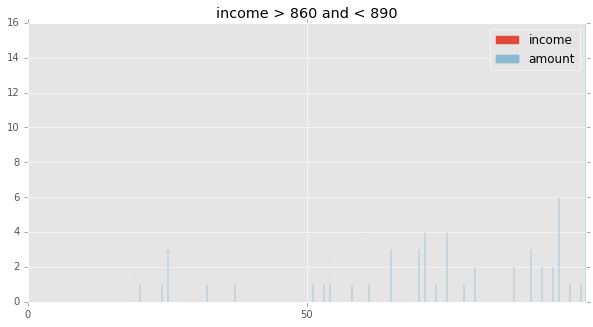



iteration 1
name 890 to 920
std 765.785198818
mean 1105.90248996
median 960.0
max_mult 3.77516778523
med_mult 1.0584343991179714
min_mult 0.0109649122807
q98 3000.0
q02 100.0
q75 1586.0
q25 450.0
iqr 1136.0
min_q -1254.0
max_q 3290.0
count of loans 6372
pct of total loans 0.276270641172


iteration 2
name 890 to 920
std 757.013116913
mean 1099.10296487
median 956.0
max_mult 3.66480446927
med_mult 1.0555555555555556
min_mult 0.0109649122807
q98 2994.9
q02 100.0
q75 1574.75
q25 450.0
iqr 1124.75
min_q -1237.125
max_q 3261.875
count of loans 6372
pct of total loans 0.276270641172


iteration 3
name 890 to 920
std 754.7916207
mean 1097.34865344
median 956.0
max_mult 3.64197530864
med_mult 1.0555555555555556
min_mult 0.0109649122807
q98 2985.0
q02 100.0
q75 1572.0
q25 450.0
iqr 1122.0
min_q -1233.0
max_q 3255.0
count of loans 6372
pct of total loans 0.276270641172


iteration 4
name 890 to 920
std 754.7916207
mean 1097.34865344
median 956.0
max_mult 3.64197530864
med_mult 1.05555555555555

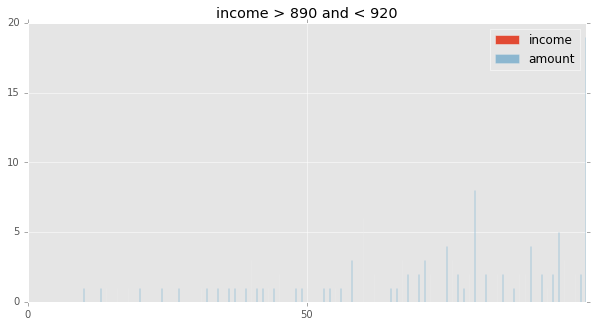



iteration 1
name 920 to 950
std 730.107675372
mean 1084.27026459
median 956.0
max_mult 3.40520043337
med_mult 1.0210148924434639
min_mult 0.0160256410256
q98 2928.12
q02 116.0
q75 1500.0
q25 500.0
iqr 1000.0
min_q -1000.0
max_q 3000.0
count of loans 4909
pct of total loans 0.212839387557


iteration 2
name 920 to 950
std 694.776168861
mean 1054.77211682
median 947.0
max_mult 3.22510822511
med_mult 1.0106382978723405
min_mult 0.0160256410256
q98 2752.4
q02 115.0
q75 1500.0
q25 491.0
iqr 1009.0
min_q -1022.5
max_q 3013.5
count of loans 4909
pct of total loans 0.212839387557


iteration 3
name 920 to 950
std 694.776168861
mean 1054.77211682
median 947.0
max_mult 3.22510822511
med_mult 1.0106382978723405
min_mult 0.0160256410256
q98 2752.4
q02 115.0
q75 1500.0
q25 491.0
iqr 1009.0
min_q -1022.5
max_q 3013.5
count of loans 4909
pct of total loans 0.212839387557


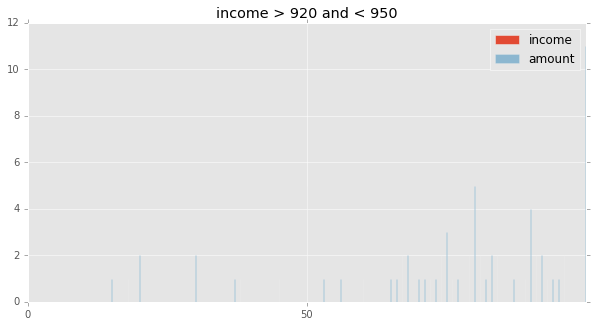



iteration 1
name 950 to 980
std 763.621020131
mean 1112.91914644
median 980.0
max_mult 3.515625
med_mult 1.0185284469459372
min_mult 0.00105042016807
q98 3000.0
q02 110.0
q75 1575.0
q25 475.0
iqr 1100.0
min_q -1175.0
max_q 3225.0
count of loans 5238
pct of total loans 0.22710383215


iteration 2
name 950 to 980
std 749.540424757
mean 1101.80283353
median 975.0
max_mult 3.35078534031
med_mult 1.0140812874319938
min_mult 0.00105042016807
q98 2981.14
q02 109.62
q75 1550.75
q25 470.0
iqr 1080.75
min_q -1151.125
max_q 3171.875
count of loans 5238
pct of total loans 0.22710383215


iteration 3
name 950 to 980
std 744.982747657
mean 1098.08456535
median 975.0
max_mult 3.30188679245
med_mult 1.0126182965299684
min_mult 0.00105042016807
q98 2954.48
q02 109.44
q75 1546.0
q25 468.0
iqr 1078.0
min_q -1149.0
max_q 3163.0
count of loans 5238
pct of total loans 0.22710383215


iteration 4
name 950 to 980
std 744.982747657
mean 1098.08456535
median 975.0
max_mult 3.30188679245
med_mult 1.01261829652

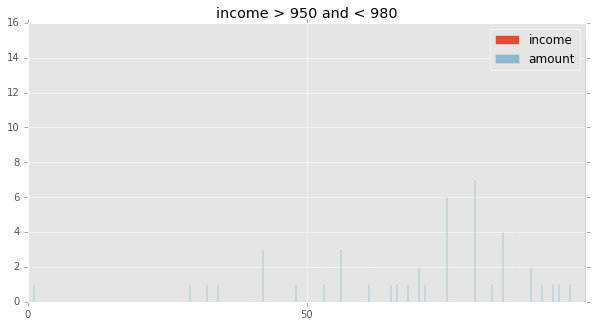



iteration 1
name 980 to 1010
std 777.947313589
mean 1113.20372233
median 960.0
max_mult 3.47914547304
med_mult 0.96
min_mult 0.02
q98 3000.0
q02 103.0
q75 1573.25
q25 465.75
iqr 1107.5
min_q -1195.5
max_q 3234.5
count of loans 6135
pct of total loans 0.265995038228


iteration 2
name 980 to 1010
std 756.355640528
mean 1096.54949324
median 950.0
max_mult 3.26417004049
med_mult 0.9558010046235286
min_mult 0.02
q98 2976.24
q02 101.76
q75 1540.0
q25 460.0
iqr 1080.0
min_q -1160.0
max_q 3160.0
count of loans 6135
pct of total loans 0.265995038228


iteration 3
name 980 to 1010
std 748.53292603
mean 1090.13927482
median 950.0
max_mult 3.17073170732
med_mult 0.952619764054067
min_mult 0.02
q98 2925.0
q02 101.04
q75 1536.0
q25 458.5
iqr 1077.5
min_q -1157.75
max_q 3152.25
count of loans 6135
pct of total loans 0.265995038228


iteration 4
name 980 to 1010
std 748.113449111
mean 1089.78935774
median 950.0
max_mult 3.17073170732
med_mult 0.9523809523809523
min_mult 0.02
q98 2925.0
q02 101.0
q7

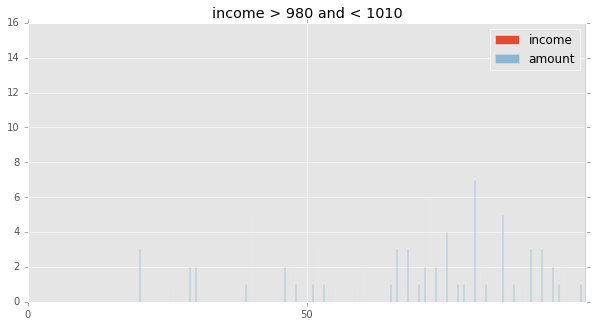



iteration 1
name 1010 to 1040
std 825.668592529
mean 1167.625
median 1000.0
max_mult 3.55708661417
med_mult 0.9675827150272267
min_mult 0.0225490196078
q98 3211.0
q02 101.92
q75 1680.0
q25 484.0
iqr 1196.0
min_q -1310.0
max_q 3474.0
count of loans 4121
pct of total loans 0.178674091693


iteration 2
name 1010 to 1040
std 798.849623076
mean 1146.87089496
median 1000.0
max_mult 3.40176817289
med_mult 0.9652509652509652
min_mult 0.0225490196078
q98 3000.0
q02 100.76
q75 1650.0
q25 480.0
iqr 1170.0
min_q -1275.0
max_q 3405.0
count of loans 4121
pct of total loans 0.178674091693


iteration 3
name 1010 to 1040
std 792.211148062
mean 1141.66708543
median 998.5
max_mult 3.34812623274
med_mult 0.9643201542912246
min_mult 0.0225490196078
q98 3000.0
q02 100.58
q75 1637.0
q25 478.75
iqr 1158.25
min_q -1258.625
max_q 3374.375
count of loans 4121
pct of total loans 0.178674091693


iteration 4
name 1010 to 1040
std 785.086083607
mean 1135.99244332
median 997.0
max_mult 3.29411764706
med_mult 0.96

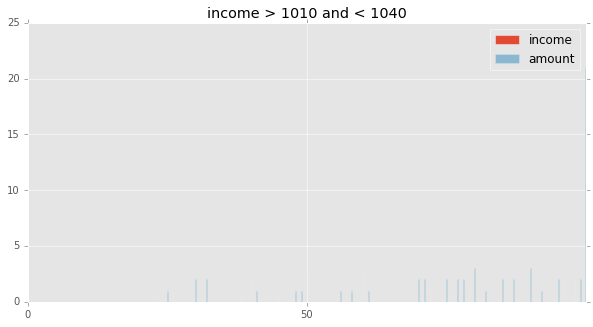



iteration 1
name 1040 to 1070
std 811.754377353
mean 1144.5204646
median 994.0
max_mult 3.36538461538
med_mult 0.9363295880149812
min_mult 0.00284090909091
q98 3000.0
q02 100.0
q75 1636.5
q25 459.75
iqr 1176.75
min_q -1305.375
max_q 3401.625
count of loans 3705
pct of total loans 0.160637590323


iteration 2
name 1040 to 1070
std 783.425953642
mean 1122.89617639
median 979.0
max_mult 3.2319391635
med_mult 0.9287054409005628
min_mult 0.00284090909091
q98 3000.0
q02 100.0
q75 1600.0
q25 450.0
iqr 1150.0
min_q -1275.0
max_q 3325.0
count of loans 3705
pct of total loans 0.160637590323


iteration 3
name 1040 to 1070
std 775.385866404
mean 1116.59082004
median 975.0
max_mult 3.1875
med_mult 0.9256434699714013
min_mult 0.00284090909091
q98 3000.0
q02 100.0
q75 1600.0
q25 450.0
iqr 1150.0
min_q -1275.0
max_q 3325.0
count of loans 3705
pct of total loans 0.160637590323


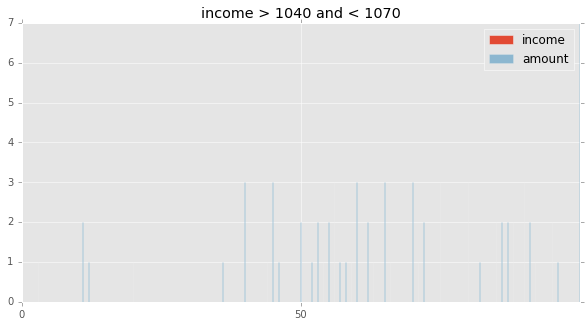



iteration 1
name 1070 to 1100
std 824.386465716
mean 1158.25849941
median 1000.0
max_mult 3.48880597015
med_mult 0.9159012881337605
min_mult 0.00743494423792
q98 3143.4
q02 100.0
q75 1688.0
q25 452.25
iqr 1235.75
min_q -1401.375
max_q 3541.625
count of loans 3521
pct of total loans 0.152659907025


iteration 2
name 1070 to 1100
std 807.266116933
mean 1145.76818851
median 1000.0
max_mult 3.27314814815
med_mult 0.9157509157509157
min_mult 0.00743494423792
q98 3000.0
q02 100.0
q75 1666.5
q25 450.0
iqr 1216.5
min_q -1374.75
max_q 3491.25
count of loans 3521
pct of total loans 0.152659907025


iteration 3
name 1070 to 1100
std 793.577797277
mean 1135.30088757
median 1000.0
max_mult 3.2
med_mult 0.9141279434636689
min_mult 0.00743494423792
q98 3000.0
q02 100.0
q75 1645.5
q25 449.0
iqr 1196.5
min_q -1345.75
max_q 3440.25
count of loans 3521
pct of total loans 0.152659907025


iteration 4
name 1070 to 1100
std 791.781525192
mean 1133.92066311
median 1000.0
max_mult 3.16402609506
med_mult 0.9

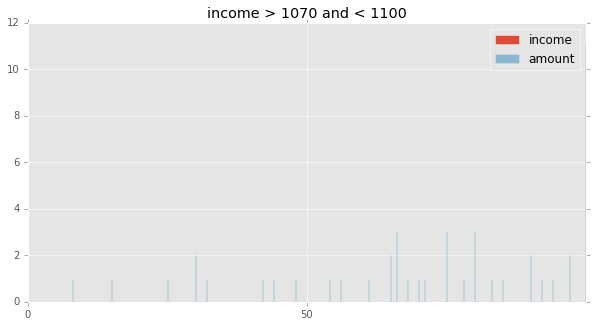



iteration 1
name 1100 to 1130
std 812.722610814
mean 1169.95525657
median 1000.0
max_mult 3.27272727273
med_mult 0.8912655971479501
min_mult 0.0134408602151
q98 3152.8
q02 114.9
q75 1650.0
q25 508.0
iqr 1142.0
min_q -1205.0
max_q 3363.0
count of loans 3290
pct of total loans 0.142644445928


iteration 2
name 1100 to 1130
std 776.461147157
mean 1142.0519316
median 1000.0
max_mult 3.05454545455
med_mult 0.8886388638863887
min_mult 0.0134408602151
q98 3000.0
q02 114.14
q75 1600.0
q25 500.0
iqr 1100.0
min_q -1150.0
max_q 3250.0
count of loans 3290
pct of total loans 0.142644445928


iteration 3
name 1100 to 1130
std 768.934807111
mean 1135.88440775
median 1000.0
max_mult 2.94363636364
med_mult 0.8880994671403197
min_mult 0.0134408602151
q98 3000.0
q02 113.96
q75 1600.0
q25 500.0
iqr 1100.0
min_q -1150.0
max_q 3250.0
count of loans 3290
pct of total loans 0.142644445928


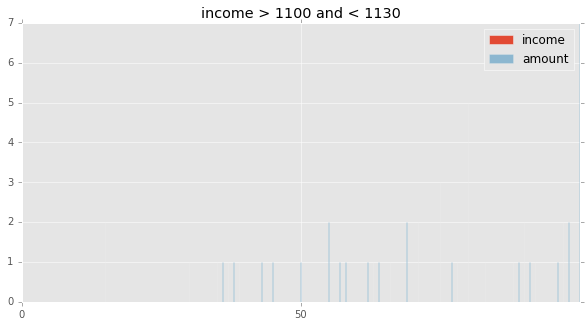



iteration 1
name 1130 to 1160
std 843.739158306
mean 1206.23663295
median 1000.0
max_mult 3.3185840708
med_mult 0.8768085858818826
min_mult 0.0174978127734
q98 3356.6
q02 110.34
q75 1733.0
q25 507.5
iqr 1225.5
min_q -1330.75
max_q 3571.25
count of loans 2864
pct of total loans 0.124174374814


iteration 2
name 1130 to 1160
std 816.452301106
mean 1185.60874317
median 1000.0
max_mult 3.15371024735
med_mult 0.8741258741258742
min_mult 0.0174978127734
q98 3150.36
q02 110.0
q75 1700.0
q25 500.0
iqr 1200.0
min_q -1300.0
max_q 3500.0
count of loans 2864
pct of total loans 0.124174374814


iteration 3
name 1130 to 1160
std 799.217360914
mean 1172.00659582
median 1000.0
max_mult 3.045256745
med_mult 0.8732517482517482
min_mult 0.0174978127734
q98 3000.0
q02 110.0
q75 1681.0
q25 500.0
iqr 1181.0
min_q -1271.5
max_q 3452.5
count of loans 2864
pct of total loans 0.124174374814


iteration 4
name 1130 to 1160
std 794.895706984
mean 1168.62018349
median 1000.0
max_mult 3.02101576182
med_mult 0.872

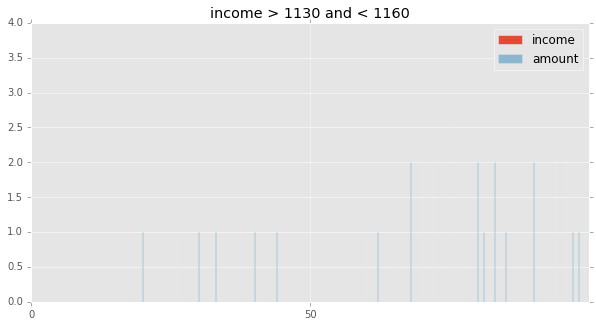



iteration 1
name 1160 to 1190
std 835.216128491
mean 1182.775354
median 1000.0
max_mult 3.16126279863
med_mult 0.851063829787234
min_mult 0.00860585197935
q98 3196.4
q02 110.48
q75 1700.0
q25 495.0
iqr 1205.0
min_q -1312.5
max_q 3507.5
count of loans 2696
pct of total loans 0.116890403107


iteration 2
name 1160 to 1190
std 811.538619104
mean 1164.87779491
median 1000.0
max_mult 3.01464254953
med_mult 0.8499789040510002
min_mult 0.00860585197935
q98 3000.0
q02 110.0
q75 1680.0
q25 489.0
iqr 1191.0
min_q -1297.5
max_q 3466.5
count of loans 2696
pct of total loans 0.116890403107


iteration 3
name 1160 to 1190
std 798.833385374
mean 1154.9469609
median 1000.0
max_mult 2.96915167095
med_mult 0.8482758620689655
min_mult 0.00860585197935
q98 3000.0
q02 110.0
q75 1665.0
q25 487.0
iqr 1178.0
min_q -1280.0
max_q 3432.0
count of loans 2696
pct of total loans 0.116890403107


iteration 4
name 1160 to 1190
std 793.155459226
mean 1150.48758728
median 1000.0
max_mult 2.91666666667
med_mult 0.8480

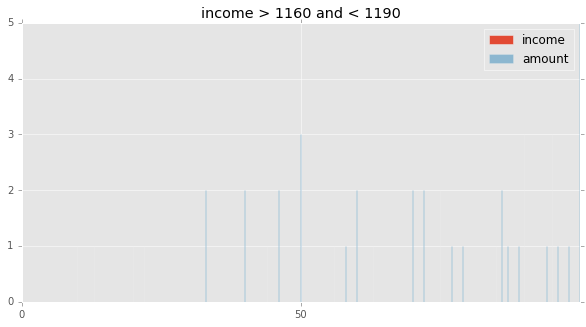



iteration 1
name 1190 to 1220
std 871.814341587
mean 1146.07463415
median 955.0
max_mult 3.15789473684
med_mult 0.7938238573021181
min_mult 0.000833333333333
q98 3360.3
q02 97.0
q75 1660.75
q25 417.0
iqr 1243.75
min_q -1448.625
max_q 3526.375
count of loans 4233
pct of total loans 0.183530072831


iteration 2
name 1190 to 1220
std 842.195808244
mean 1123.2717204
median 940.0
max_mult 2.94117647059
med_mult 0.7842323651452282
min_mult 0.000833333333333
q98 3188.76
q02 97.0
q75 1628.0
q25 417.0
iqr 1211.0
min_q -1399.5
max_q 3444.5
count of loans 4233
pct of total loans 0.183530072831


iteration 3
name 1190 to 1220
std 820.085563703
mean 1105.65782296
median 936.0
max_mult 2.87153652393
med_mult 0.7775
min_mult 0.000833333333333
q98 3024.4
q02 96.64
q75 1600.0
q25 417.0
iqr 1183.0
min_q -1357.5
max_q 3374.5
count of loans 4233
pct of total loans 0.183530072831


iteration 4
name 1190 to 1220
std 809.412833375
mean 1097.05550025
median 932.0
max_mult 2.8
med_mult 0.7719407894736843
min

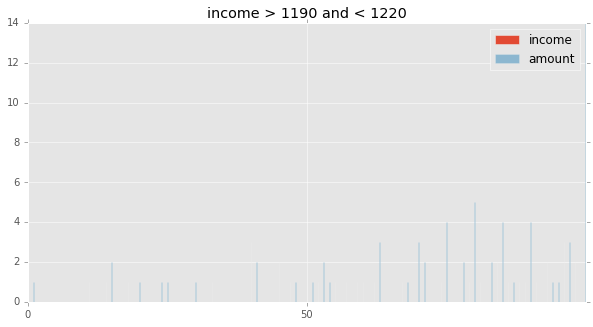



iteration 1
name 1220 to 1250
std 838.957751098
mean 1172.3127591
median 1000.0
max_mult 3.02040816327
med_mult 0.8077544426494345
min_mult 0.0160256410256
q98 3242.0
q02 108.8
q75 1689.0
q25 494.0
iqr 1195.0
min_q -1298.5
max_q 3481.5
count of loans 2239
pct of total loans 0.0970762657852


iteration 2
name 1220 to 1250
std 807.482571492
mean 1147.8720335
median 1000.0
max_mult 2.84672131148
med_mult 0.8064516129032258
min_mult 0.0160256410256
q98 3040.2
q02 107.8
q75 1660.0
q25 483.0
iqr 1177.0
min_q -1282.5
max_q 3425.5
count of loans 2239
pct of total loans 0.0970762657852


iteration 3
name 1220 to 1250
std 802.049943695
mean 1143.56736597
median 1000.0
max_mult 2.7846027846
med_mult 0.8064516129032258
min_mult 0.0160256410256
q98 3000.0
q02 107.4
q75 1650.0
q25 480.0
iqr 1170.0
min_q -1275.0
max_q 3405.0
count of loans 2239
pct of total loans 0.0970762657852


iteration 4
name 1220 to 1250
std 799.408736166
mean 1141.44563696
median 1000.0
max_mult 2.7846027846
med_mult 0.80580

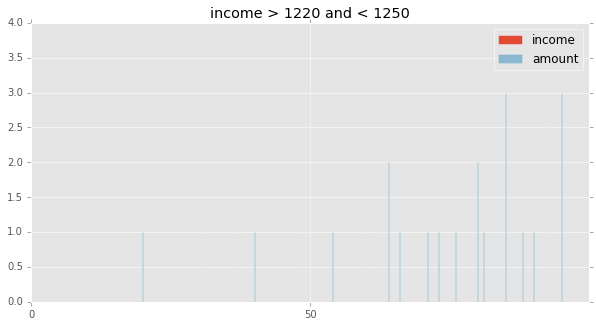



iteration 1
name 1250 to 1280
std 843.501792164
mean 1198.97497725
median 1000.0
max_mult 2.97147385103
med_mult 0.7942811755361397
min_mult 0.0196540880503
q98 3300.0
q02 110.0
q75 1680.0
q25 500.0
iqr 1180.0
min_q -1270.0
max_q 3450.0
count of loans 2278
pct of total loans 0.0987671877886


iteration 2
name 1250 to 1280
std 802.454445926
mean 1167.11618257
median 1000.0
max_mult 2.72655007949
med_mult 0.7917656373713381
min_mult 0.0196540880503
q98 3006.4
q02 110.0
q75 1624.0
q25 500.0
iqr 1124.0
min_q -1186.0
max_q 3310.0
count of loans 2278
pct of total loans 0.0987671877886


iteration 3
name 1250 to 1280
std 787.392620991
mean 1154.77932313
median 1000.0
max_mult 2.64
med_mult 0.7905138339920948
min_mult 0.0196540880503
q98 3000.0
q02 110.0
q75 1600.0
q25 496.0
iqr 1104.0
min_q -1160.0
max_q 3256.0
count of loans 2278
pct of total loans 0.0987671877886


iteration 4
name 1250 to 1280
std 780.352509923
mean 1148.82147838
median 1000.0
max_mult 2.58333333333
med_mult 0.7898894154

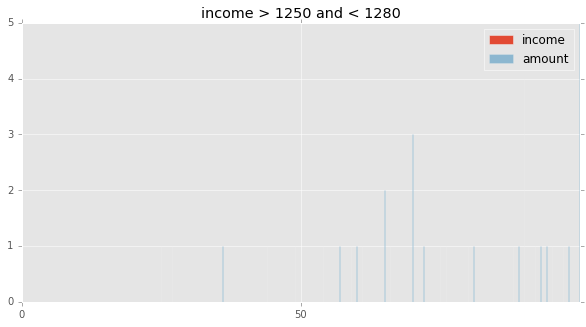



iteration 1
name 1280 to 1310
std 880.941068588
mean 1249.23205742
median 1000.0
max_mult 3.02560124127
med_mult 0.78064012490242
min_mult 0.0154083204931
q98 3500.0
q02 114.0
q75 1800.0
q25 536.0
iqr 1264.0
min_q -1360.0
max_q 3696.0
count of loans 2161
pct of total loans 0.0936944217784


iteration 2
name 1280 to 1310
std 851.190680241
mean 1226.84314672
median 1000.0
max_mult 2.82208588957
med_mult 0.778816199376947
min_mult 0.0154083204931
q98 3330.58
q02 114.0
q75 1761.25
q25 530.25
iqr 1231.0
min_q -1316.25
max_q 3607.75
count of loans 2161
pct of total loans 0.0936944217784


iteration 3
name 1280 to 1310
std 846.781272403
mean 1223.32817786
median 1000.0
max_mult 2.8125
med_mult 0.778816199376947
min_mult 0.0154083204931
q98 3300.0
q02 114.0
q75 1760.0
q25 528.0
iqr 1232.0
min_q -1320.0
max_q 3608.0
count of loans 2161
pct of total loans 0.0936944217784


iteration 4
name 1280 to 1310
std 846.781272403
mean 1223.32817786
median 1000.0
max_mult 2.8125
med_mult 0.77881619937694

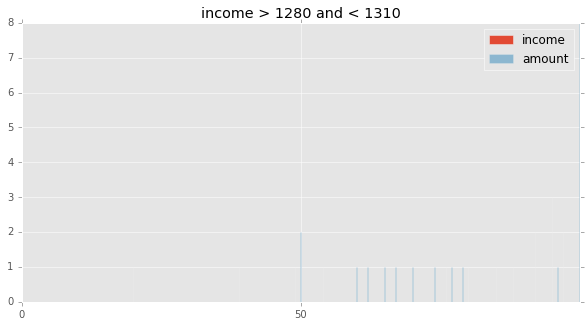



iteration 1
name 1310 to 1340
std 928.0492232
mean 1262.6491913
median 1000.0
max_mult 3.09200603318
med_mult 0.7604562737642585
min_mult 0.000750187546887
q98 3600.0
q02 111.68
q75 1850.0
q25 500.0
iqr 1350.0
min_q -1525.0
max_q 3875.0
count of loans 1830
pct of total loans 0.0793432632367


iteration 2
name 1310 to 1340
std 891.079250696
mean 1235.04225352
median 1000.0
max_mult 2.9176201373
med_mult 0.7593014426727411
min_mult 0.000750187546887
q98 3465.6
q02 110.96
q75 1800.0
q25 500.0
iqr 1300.0
min_q -1450.0
max_q 3750.0
count of loans 1830
pct of total loans 0.0793432632367


iteration 3
name 1310 to 1340
std 874.411602208
mean 1222.0186863
median 1000.0
max_mult 2.8397873956
med_mult 0.7584794371802677
min_mult 0.000750187546887
q98 3280.7
q02 110.6
q75 1800.0
q25 500.0
iqr 1300.0
min_q -1450.0
max_q 3750.0
count of loans 1830
pct of total loans 0.0793432632367


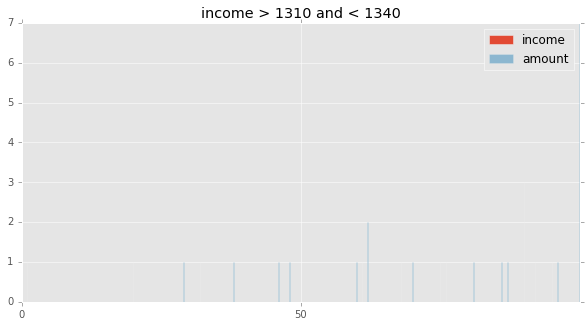



iteration 1
name 1340 to 1370
std 884.466620443
mean 1254.64237183
median 1000.0
max_mult 2.94074074074
med_mult 0.7451564828614009
min_mult 0.00731528895391
q98 3500.0
q02 111.36
q75 1800.0
q25 549.0
iqr 1251.0
min_q -1327.5
max_q 3676.5
count of loans 1679
pct of total loans 0.0727963600953


iteration 2
name 1340 to 1370
std 840.618586047
mean 1222.17448405
median 1000.0
max_mult 2.70268256334
med_mult 0.7429420505200595
min_mult 0.00731528895391
q98 3299.04
q02 110.92
q75 1763.0
q25 534.0
iqr 1229.0
min_q -1309.5
max_q 3606.5
count of loans 1679
pct of total loans 0.0727963600953


iteration 3
name 1340 to 1370
std 832.849669572
mean 1216.09717868
median 1000.0
max_mult 2.65657311669
med_mult 0.7423904974016332
min_mult 0.00731528895391
q98 3204.8
q02 110.76
q75 1757.5
q25 531.5
iqr 1226.0
min_q -1307.5
max_q 3596.5
count of loans 1679
pct of total loans 0.0727963600953


iteration 4
name 1340 to 1370
std 829.078142276
mean 1213.10608914
median 1000.0
max_mult 2.65430267062
med_m

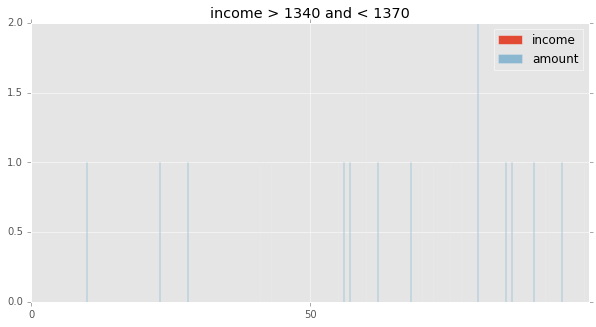



iteration 1
name 1370 to 1400
std 930.616957676
mean 1319.11088977
median 1100.0
max_mult 2.94524495677
med_mult 0.7919366450683946
min_mult 0.027556200145
q98 3690.0
q02 140.0
q75 1950.0
q25 554.0
iqr 1396.0
min_q -1540.0
max_q 4044.0
count of loans 1561
pct of total loans 0.0676802371106


iteration 2
name 1370 to 1400
std 928.182521641
mean 1317.27109635
median 1100.0
max_mult 2.9197080292
med_mult 0.7919366450683946
min_mult 0.027556200145
q98 3686.64
q02 140.0
q75 1950.0
q25 552.0
iqr 1398.0
min_q -1545.0
max_q 4047.0
count of loans 1561
pct of total loans 0.0676802371106


iteration 3
name 1370 to 1400
std 928.182521641
mean 1317.27109635
median 1100.0
max_mult 2.9197080292
med_mult 0.7919366450683946
min_mult 0.027556200145
q98 3686.64
q02 140.0
q75 1950.0
q25 552.0
iqr 1398.0
min_q -1545.0
max_q 4047.0
count of loans 1561
pct of total loans 0.0676802371106


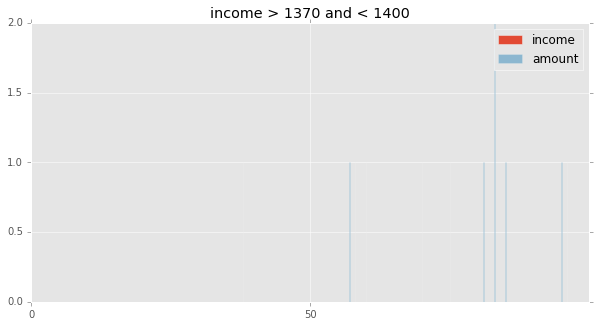



iteration 1
name 1400 to 1430
std 901.973715738
mean 1271.27348777
median 1050.0
max_mult 2.85714285714
med_mult 0.7494650499286732
min_mult 0.00356125356125
q98 3500.0
q02 114.06
q75 1810.5
q25 551.25
iqr 1259.25
min_q -1337.625
max_q 3699.375
count of loans 1601
pct of total loans 0.0694145160885


iteration 2
name 1400 to 1430
std 855.955360551
mean 1237.00065189
median 1031.5
max_mult 2.62857142857
med_mult 0.7337824456641937
min_mult 0.00356125356125
q98 3260.2
q02 113.32
q75 1800.0
q25 534.5
iqr 1265.5
min_q -1363.75
max_q 3698.25
count of loans 1601
pct of total loans 0.0694145160885


iteration 3
name 1400 to 1430
std 855.955360551
mean 1237.00065189
median 1031.5
max_mult 2.62857142857
med_mult 0.7337824456641937
min_mult 0.00356125356125
q98 3260.2
q02 113.32
q75 1800.0
q25 534.5
iqr 1265.5
min_q -1363.75
max_q 3698.25
count of loans 1601
pct of total loans 0.0694145160885


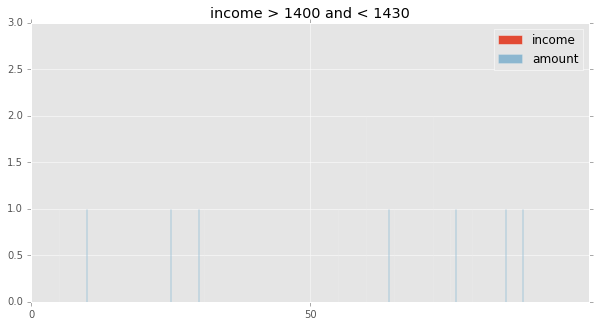



iteration 1
name 1430 to 1460
std 974.879902278
mean 1286.65823566
median 1000.0
max_mult 2.93402777778
med_mult 0.6963788300835655
min_mult 0.00687285223368
q98 3819.2
q02 101.8
q75 1900.0
q25 486.0
iqr 1414.0
min_q -1635.0
max_q 4021.0
count of loans 1670
pct of total loans 0.0724061473253


iteration 2
name 1430 to 1460
std 951.92623509
mean 1269.08317815
median 1000.0
max_mult 2.77970813065
med_mult 0.6949270326615705
min_mult 0.00687285223368
q98 3676.6
q02 101.4
q75 1875.0
q25 480.0
iqr 1395.0
min_q -1612.5
max_q 3967.5
count of loans 1670
pct of total loans 0.0724061473253


iteration 3
name 1430 to 1460
std 923.263720146
mean 1246.88110138
median 1000.0
max_mult 2.75347222222
med_mult 0.6944444444444444
min_mult 0.00687285223368
q98 3500.0
q02 100.94
q75 1840.0
q25 475.0
iqr 1365.0
min_q -1572.5
max_q 3887.5
count of loans 1670
pct of total loans 0.0724061473253


iteration 4
name 1430 to 1460
std 908.016512418
mean 1235.1062225
median 1000.0
max_mult 2.69042627533
med_mult 0

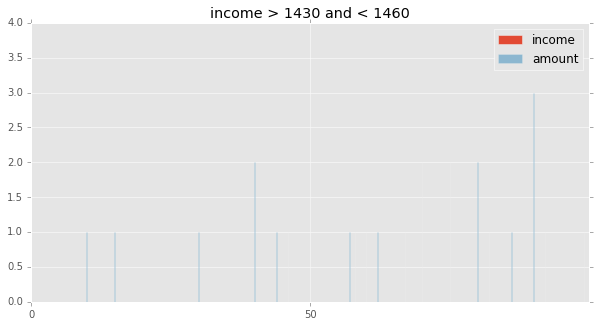



iteration 1
name 1460 to 1490
std 935.47174195
mean 1326.46629213
median 1100.0
max_mult 2.76545698925
med_mult 0.7490656033177078
min_mult 0.0170648464164
q98 3643.5
q02 124.0
q75 1918.75
q25 557.0
iqr 1361.75
min_q -1485.625
max_q 3961.375
count of loans 1282
pct of total loans 0.0555836412401


iteration 2
name 1460 to 1490
std 900.877397868
mean 1300.13938412
median 1100.0
max_mult 2.68767123288
med_mult 0.7470289486112341
min_mult 0.0170648464164
q98 3500.0
q02 124.0
q75 1884.75
q25 550.0
iqr 1334.75
min_q -1452.125
max_q 3886.875
count of loans 1282
pct of total loans 0.0555836412401


iteration 3
name 1460 to 1490
std 889.822203347
mean 1291.61463415
median 1100.0
max_mult 2.61301369863
med_mult 0.7457855697909642
min_mult 0.0170648464164
q98 3496.42
q02 124.0
q75 1875.0
q25 544.75
iqr 1330.25
min_q -1450.625
max_q 3870.375
count of loans 1282
pct of total loans 0.0555836412401


iteration 4
name 1460 to 1490
std 889.822203347
mean 1291.61463415
median 1100.0
max_mult 2.613013

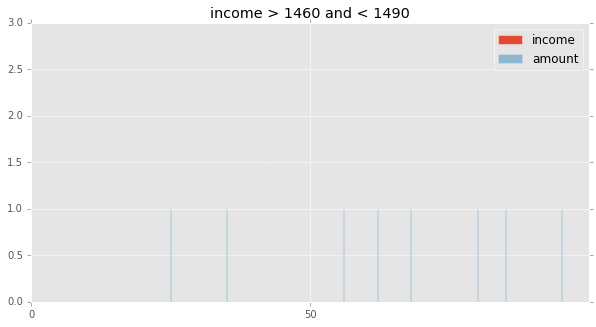



iteration 1
name 1490 to 1520
std 926.001771469
mean 1295.43914209
median 1071.0
max_mult 2.6677852349
med_mult 0.714
min_mult 0.0198150594452
q98 3663.76
q02 120.0
q75 1880.0
q25 530.0
iqr 1350.0
min_q -1495.0
max_q 3905.0
count of loans 1932
pct of total loans 0.0837656746302


iteration 2
name 1490 to 1520
std 895.305498292
mean 1272.13683072
median 1048.0
max_mult 2.6
med_mult 0.6951871657754011
min_mult 0.0198150594452
q98 3500.0
q02 119.8
q75 1853.0
q25 519.0
iqr 1334.0
min_q -1482.0
max_q 3854.0
count of loans 1932
pct of total loans 0.0837656746302


iteration 3
name 1490 to 1520
std 889.793886827
mean 1267.88624052
median 1042.5
max_mult 2.56866666667
med_mult 0.6928706078518028
min_mult 0.0198150594452
q98 3500.0
q02 119.5
q75 1840.75
q25 519.0
iqr 1321.75
min_q -1463.625
max_q 3823.375
count of loans 1932
pct of total loans 0.0837656746302


iteration 4
name 1490 to 1520
std 882.568527957
mean 1262.27741585
median 1034.5
max_mult 2.55033557047
med_mult 0.684809364548495
mi

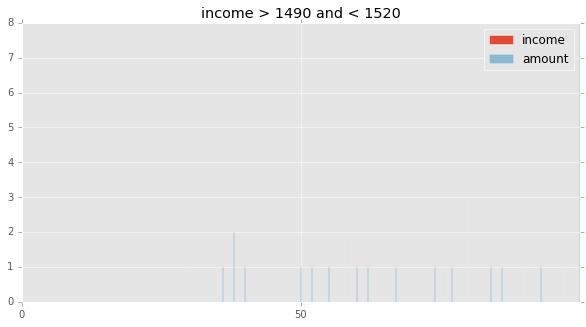



iteration 1
name 1520 to 1550
std 865.27454114
mean 1238.43622921
median 1030.0
max_mult 2.52956636005
med_mult 0.6712266546846917
min_mult 0.0175097276265
q98 3469.0
q02 100.0
q75 1780.25
q25 516.0
iqr 1264.25
min_q -1380.375
max_q 3676.625
count of loans 1124
pct of total loans 0.0487332392776


iteration 2
name 1520 to 1550
std 842.757598026
mean 1221.70325581
median 1015.0
max_mult 2.40039190072
med_mult 0.6591349257585539
min_mult 0.0175097276265
q98 3343.0
q02 100.0
q75 1750.0
q25 509.0
iqr 1241.0
min_q -1352.5
max_q 3611.5
count of loans 1124
pct of total loans 0.0487332392776


iteration 3
name 1520 to 1550
std 836.905937025
mean 1217.1500466
median 1008.0
max_mult 2.36513157895
med_mult 0.6578947368421053
min_mult 0.0175097276265
q98 3211.2
q02 100.0
q75 1750.0
q25 502.0
iqr 1248.0
min_q -1370.0
max_q 3622.0
count of loans 1124
pct of total loans 0.0487332392776


iteration 4
name 1520 to 1550
std 836.905937025
mean 1217.1500466
median 1008.0
max_mult 2.36513157895
med_mult 

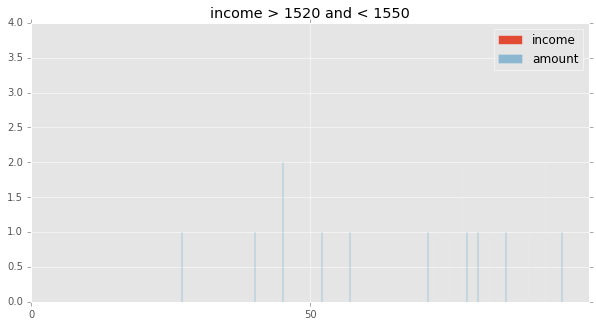



iteration 1
name 1550 to 1580
std 963.717304921
mean 1282.26569218
median 1000.0
max_mult 2.71631205674
med_mult 0.6451612903225806
min_mult 0.014631043257
q98 3827.36
q02 80.0
q75 1900.0
q25 481.0
iqr 1419.0
min_q -1647.5
max_q 4028.5
count of loans 1213
pct of total loans 0.0525920100033


iteration 2
name 1550 to 1580
std 940.550545311
mean 1264.97318339
median 1000.0
max_mult 2.56904303147
med_mult 0.644953307959485
min_mult 0.014631043257
q98 3700.0
q02 80.0
q75 1881.25
q25 480.0
iqr 1401.25
min_q -1621.875
max_q 3983.125
count of loans 1213
pct of total loans 0.0525920100033


iteration 3
name 1550 to 1580
std 918.770669766
mean 1248.31070496
median 1000.0
max_mult 2.54510309278
med_mult 0.6443298969072165
min_mult 0.014631043257
q98 3501.6
q02 80.0
q75 1870.0
q25 480.0
iqr 1390.0
min_q -1605.0
max_q 3955.0
count of loans 1213
pct of total loans 0.0525920100033


iteration 4
name 1550 to 1580
std 909.333276936
mean 1241.18499127
median 1000.0
max_mult 2.54510309278
med_mult 0.6

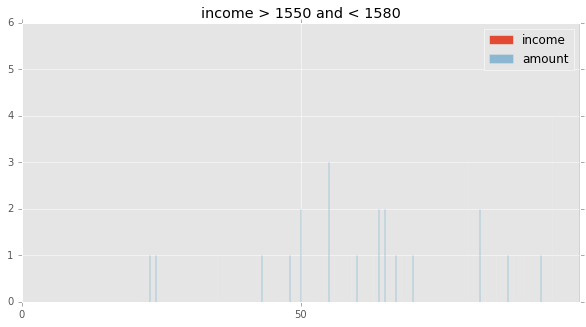



iteration 1
name 1580 to 1610
std 946.052375314
mean 1279.08471616
median 1000.0
max_mult 2.61964735516
med_mult 0.6325110689437066
min_mult 0.0125
q98 3700.0
q02 108.0
q75 1838.0
q25 500.0
iqr 1338.0
min_q -1507.0
max_q 3845.0
count of loans 1188
pct of total loans 0.0515080856422


iteration 2
name 1580 to 1610
std 888.121419869
mean 1235.58740018
median 1000.0
max_mult 2.41020793951
med_mult 0.6309148264984227
min_mult 0.0125
q98 3447.8
q02 108.0
q75 1782.5
q25 500.0
iqr 1282.5
min_q -1423.75
max_q 3706.25
count of loans 1188
pct of total loans 0.0515080856422


iteration 3
name 1580 to 1610
std 876.915023423
mean 1226.63846839
median 1000.0
max_mult 2.32954545455
med_mult 0.6309148264984227
min_mult 0.0125
q98 3411.2
q02 108.0
q75 1761.5
q25 500.0
iqr 1261.5
min_q -1392.25
max_q 3653.75
count of loans 1188
pct of total loans 0.0515080856422


iteration 4
name 1580 to 1610
std 865.966739456
mean 1217.82394996
median 1000.0
max_mult 2.278125
med_mult 0.6305170239596469
min_mult 0.0

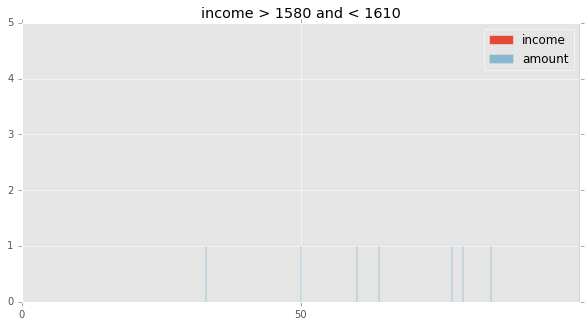



iteration 1
name 1610 to 1640
std 1014.2647179
mean 1356.66833667
median 1062.5
max_mult 2.59259259259
med_mult 0.6550338263960556
min_mult 0.00864197530864
q98 3900.0
q02 100.0
q75 2000.0
q25 500.0
iqr 1500.0
min_q -1750.0
max_q 4250.0
count of loans 1034
pct of total loans 0.0448311115774


iteration 2
name 1610 to 1640
std 1014.2647179
mean 1356.66833667
median 1062.5
max_mult 2.59259259259
med_mult 0.6550338263960556
min_mult 0.00864197530864
q98 3900.0
q02 100.0
q75 2000.0
q25 500.0
iqr 1500.0
min_q -1750.0
max_q 4250.0
count of loans 1034
pct of total loans 0.0448311115774


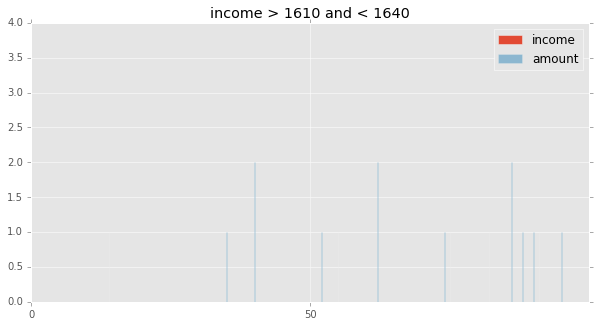



iteration 1
name 1640 to 1670
std 1018.84833913
mean 1332.26564215
median 1000.0
max_mult 2.51400730816
med_mult 0.6064281382656155
min_mult 0.0254545454545
q98 4000.0
q02 115.8
q75 2000.0
q25 508.0
iqr 1492.0
min_q -1730.0
max_q 4238.0
count of loans 944
pct of total loans 0.0409289838773


iteration 2
name 1640 to 1670
std 1018.84833913
mean 1332.26564215
median 1000.0
max_mult 2.51400730816
med_mult 0.6064281382656155
min_mult 0.0254545454545
q98 4000.0
q02 115.8
q75 2000.0
q25 508.0
iqr 1492.0
min_q -1730.0
max_q 4238.0
count of loans 944
pct of total loans 0.0409289838773


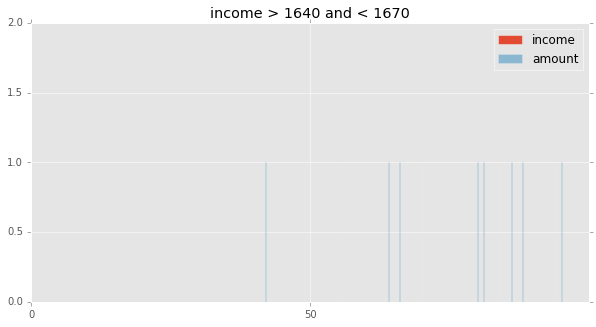



iteration 1
name 1670 to 1700
std 958.431447758
mean 1281.90139335
median 1000.0
max_mult 2.51488095238
med_mult 0.5970149253731343
min_mult 0.0225251926497
q98 3726.32
q02 100.0
q75 1920.0
q25 475.0
iqr 1445.0
min_q -1692.5
max_q 4087.5
count of loans 973
pct of total loans 0.0421863361362


iteration 2
name 1670 to 1700
std 945.860932778
mean 1272.60645161
median 1000.0
max_mult 2.38095238095
med_mult 0.5966587112171837
min_mult 0.0225251926497
q98 3631.44
q02 100.0
q75 1913.5
q25 473.5
iqr 1440.0
min_q -1686.5
max_q 4073.5
count of loans 973
pct of total loans 0.0421863361362


iteration 3
name 1670 to 1700
std 945.860932778
mean 1272.60645161
median 1000.0
max_mult 2.38095238095
med_mult 0.5966587112171837
min_mult 0.0225251926497
q98 3631.44
q02 100.0
q75 1913.5
q25 473.5
iqr 1440.0
min_q -1686.5
max_q 4073.5
count of loans 973
pct of total loans 0.0421863361362


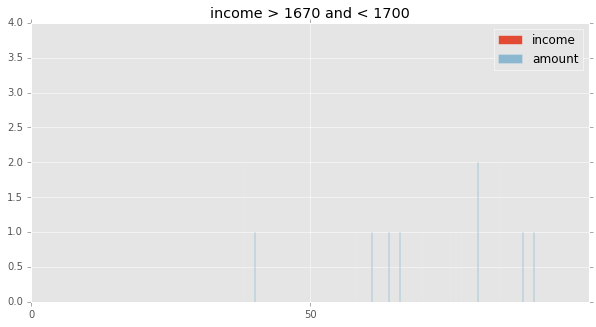



iteration 1
name 1700 to 1730
std 951.963948976
mean 1279.06057495
median 1000.0
max_mult 2.45183887916
med_mult 0.5868544600938967
min_mult 0.013986013986
q98 3747.0
q02 100.0
q75 1874.0
q25 495.5
iqr 1378.5
min_q -1572.25
max_q 3941.75
count of loans 1033
pct of total loans 0.044787754603


iteration 2
name 1700 to 1730
std 901.362122922
mean 1241.47346514
median 1000.0
max_mult 2.2687609075
med_mult 0.5858230814294083
min_mult 0.013986013986
q98 3500.0
q02 100.0
q75 1820.0
q25 490.0
iqr 1330.0
min_q -1505.0
max_q 3815.0
count of loans 1033
pct of total loans 0.044787754603


iteration 3
name 1700 to 1730
std 883.285737145
mean 1227.69874477
median 1000.0
max_mult 2.20477021524
med_mult 0.5856515875531116
min_mult 0.013986013986
q98 3458.9
q02 100.0
q75 1801.5
q25 479.75
iqr 1321.75
min_q -1502.875
max_q 3784.125
count of loans 1033
pct of total loans 0.044787754603


iteration 4
name 1700 to 1730
std 879.842225925
mean 1225.01570681
median 1000.0
max_mult 2.20210280374
med_mult 0.

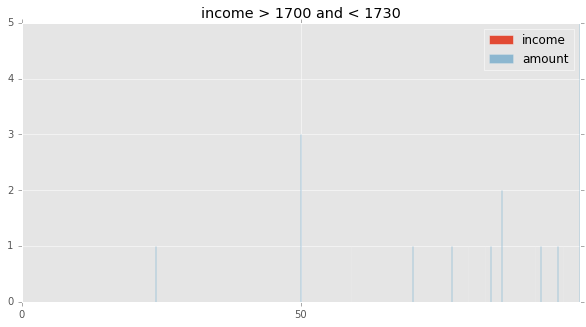



iteration 1
name 1730 to 1760
std 980.235850843
mean 1355.44097222
median 1100.0
max_mult 2.36540664376
med_mult 0.6345544225632958
min_mult 0.00575705238918
q98 3750.0
q02 100.0
q75 2000.0
q25 544.0
iqr 1456.0
min_q -1640.0
max_q 4184.0
count of loans 894
pct of total loans 0.038761135155


iteration 2
name 1730 to 1760
std 980.235850843
mean 1355.44097222
median 1100.0
max_mult 2.36540664376
med_mult 0.6345544225632958
min_mult 0.00575705238918
q98 3750.0
q02 100.0
q75 2000.0
q25 544.0
iqr 1456.0
min_q -1640.0
max_q 4184.0
count of loans 894
pct of total loans 0.038761135155


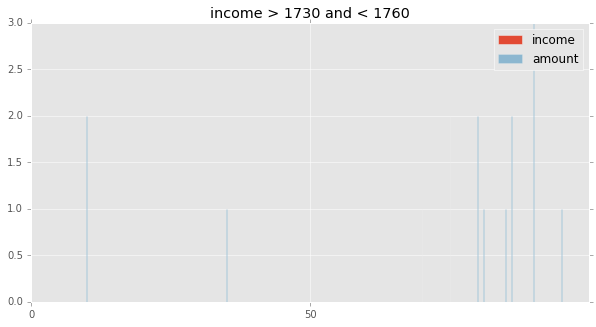



iteration 1
name 1760 to 1790
std 967.600680008
mean 1401.1232493
median 1177.0
max_mult 2.33446519525
med_mult 0.663565498634799
min_mult 0.0112359550562
q98 3946.64
q02 128.0
q75 2000.0
q25 625.25
iqr 1374.75
min_q -1436.875
max_q 4062.125
count of loans 748
pct of total loans 0.0324310168858


iteration 2
name 1760 to 1790
std 958.247262761
mean 1393.5238764
median 1175.5
max_mult 2.29024943311
med_mult 0.6628194842370561
min_mult 0.0112359550562
q98 3800.0
q02 128.0
q75 2000.0
q25 622.75
iqr 1377.25
min_q -1443.125
max_q 4065.875
count of loans 748
pct of total loans 0.0324310168858


iteration 3
name 1760 to 1790
std 958.247262761
mean 1393.5238764
median 1175.5
max_mult 2.29024943311
med_mult 0.6628194842370561
min_mult 0.0112359550562
q98 3800.0
q02 128.0
q75 2000.0
q25 622.75
iqr 1377.25
min_q -1443.125
max_q 4065.875
count of loans 748
pct of total loans 0.0324310168858


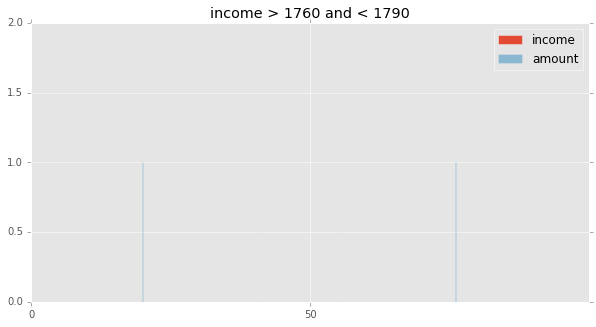



iteration 1
name 1790 to 1820
std 1085.20543132
mean 1411.91218638
median 1100.0
max_mult 2.61111111111
med_mult 0.6099693063228975
min_mult 0.00552486187845
q98 4107.6
q02 105.6
q75 2000.0
q25 500.0
iqr 1500.0
min_q -1750.0
max_q 4250.0
count of loans 1174
pct of total loans 0.0509010879999


iteration 2
name 1790 to 1820
std 1028.03619647
mean 1367.49454545
median 1062.5
max_mult 2.33777777778
med_mult 0.5901001918698987
min_mult 0.00552486187845
q98 3957.04
q02 104.98
q75 2000.0
q25 500.0
iqr 1500.0
min_q -1750.0
max_q 4250.0
count of loans 1174
pct of total loans 0.0509010879999


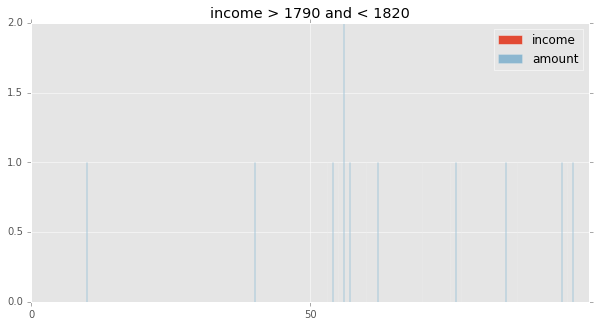



iteration 1
name 1820 to 1850
std 1010.49505636
mean 1320.76390977
median 1031.0
max_mult 2.37315875614
med_mult 0.5597176981541803
min_mult 0.0141535111595
q98 3821.08
q02 86.56
q75 1995.0
q25 417.0
iqr 1578.0
min_q -1950.0
max_q 4362.0
count of loans 690
pct of total loans 0.0299163123679


iteration 2
name 1820 to 1850
std 1010.49505636
mean 1320.76390977
median 1031.0
max_mult 2.37315875614
med_mult 0.5597176981541803
min_mult 0.0141535111595
q98 3821.08
q02 86.56
q75 1995.0
q25 417.0
iqr 1578.0
min_q -1950.0
max_q 4362.0
count of loans 690
pct of total loans 0.0299163123679


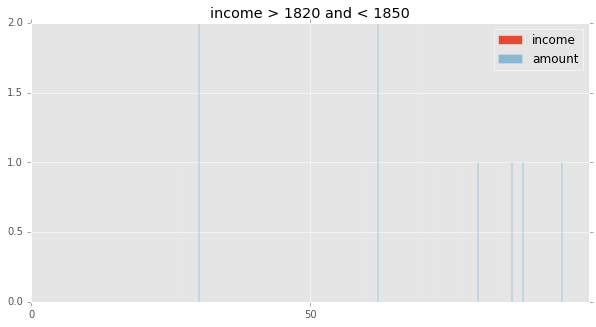



iteration 1
name 1850 to 1880
std 909.806520894
mean 1243.2371476
median 1000.0
max_mult 2.23689839572
med_mult 0.5385029617662898
min_mult 0.0160256410256
q98 3596.4
q02 100.08
q75 1765.5
q25 480.0
iqr 1285.5
min_q -1448.25
max_q 3693.75
count of loans 644
pct of total loans 0.0279218915434


iteration 2
name 1850 to 1880
std 837.762569663
mean 1192.54560811
median 1000.0
max_mult 1.93965517241
med_mult 0.5375908401735766
min_mult 0.0160256410256
q98 3037.66
q02 100.0
q75 1695.5
q25 474.5
iqr 1221.0
min_q -1357.0
max_q 3527.0
count of loans 644
pct of total loans 0.0279218915434


iteration 3
name 1850 to 1880
std 827.334472145
mean 1184.38474576
median 1000.0
max_mult 1.88172043011
med_mult 0.5373020998896871
min_mult 0.0160256410256
q98 3000.0
q02 100.0
q75 1687.5
q25 473.5
iqr 1214.0
min_q -1347.5
max_q 3508.5
count of loans 644
pct of total loans 0.0279218915434


iteration 4
name 1850 to 1880
std 822.45528264
mean 1180.43633277
median 1000.0
max_mult 1.88172043011
med_mult 0.53

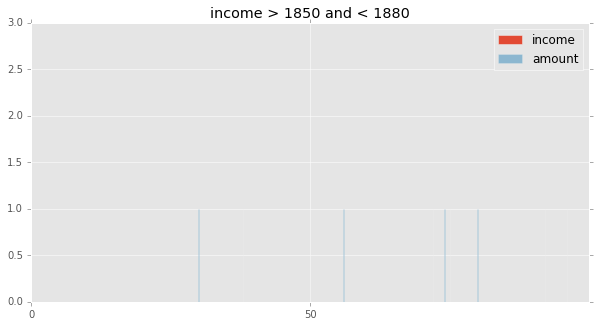



iteration 1
name 1880 to 1910
std 946.122087406
mean 1331.11282844
median 1100.0
max_mult 2.12486883526
med_mult 0.5804749340369393
min_mult 0.00689289501591
q98 3687.44
q02 119.68
q75 1981.5
q25 550.0
iqr 1431.5
min_q -1597.25
max_q 4128.75
count of loans 685
pct of total loans 0.0296995274957


iteration 2
name 1880 to 1910
std 946.122087406
mean 1331.11282844
median 1100.0
max_mult 2.12486883526
med_mult 0.5804749340369393
min_mult 0.00689289501591
q98 3687.44
q02 119.68
q75 1981.5
q25 550.0
iqr 1431.5
min_q -1597.25
max_q 4128.75
count of loans 685
pct of total loans 0.0296995274957


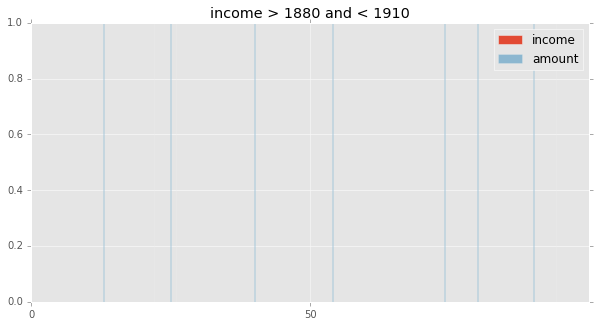



iteration 1
name 1910 to 1940
std 1058.15651653
mean 1383.50160256
median 1055.0
max_mult 2.3498694517
med_mult 0.5486198340961486
min_mult 0.0197916666667
q98 4000.0
q02 100.0
q75 2000.0
q25 503.5
iqr 1496.5
min_q -1741.25
max_q 4244.75
count of loans 654
pct of total loans 0.0283554612879


iteration 2
name 1910 to 1940
std 1006.34604779
mean 1344.07792208
median 1000.0
max_mult 2.18522372529
med_mult 0.5235602094240838
min_mult 0.0197916666667
q98 3673.5
q02 100.0
q75 2000.0
q25 501.75
iqr 1498.25
min_q -1745.625
max_q 4247.375
count of loans 654
pct of total loans 0.0283554612879


iteration 3
name 1910 to 1940
std 1006.34604779
mean 1344.07792208
median 1000.0
max_mult 2.18522372529
med_mult 0.5235602094240838
min_mult 0.0197916666667
q98 3673.5
q02 100.0
q75 2000.0
q25 501.75
iqr 1498.25
min_q -1745.625
max_q 4247.375
count of loans 654
pct of total loans 0.0283554612879


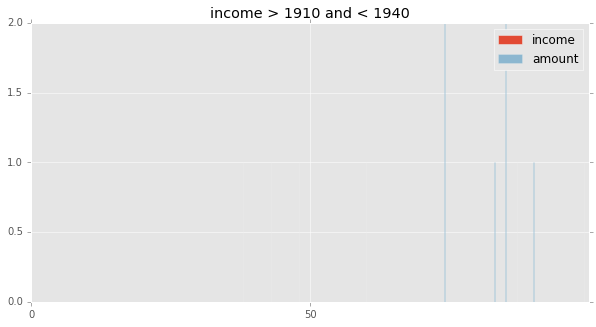



iteration 1
name 1940 to 1970
std 1006.75853649
mean 1381.02338129
median 1100.0
max_mult 2.17413441955
med_mult 0.5638740926419135
min_mult 0.030518819939
q98 4000.0
q02 101.3
q75 2000.0
q25 540.75
iqr 1459.25
min_q -1648.125
max_q 4188.875
count of loans 585
pct of total loans 0.0253638300511


iteration 2
name 1940 to 1970
std 993.810593939
mean 1370.72021661
median 1100.0
max_mult 2.12820512821
med_mult 0.5635851056725986
min_mult 0.030518819939
q98 3992.12
q02 100.78
q75 2000.0
q25 532.25
iqr 1467.75
min_q -1669.375
max_q 4201.625
count of loans 585
pct of total loans 0.0253638300511


iteration 3
name 1940 to 1970
std 993.810593939
mean 1370.72021661
median 1100.0
max_mult 2.12820512821
med_mult 0.5635851056725986
min_mult 0.030518819939
q98 3992.12
q02 100.78
q75 2000.0
q25 532.25
iqr 1467.75
min_q -1669.375
max_q 4201.625
count of loans 585
pct of total loans 0.0253638300511


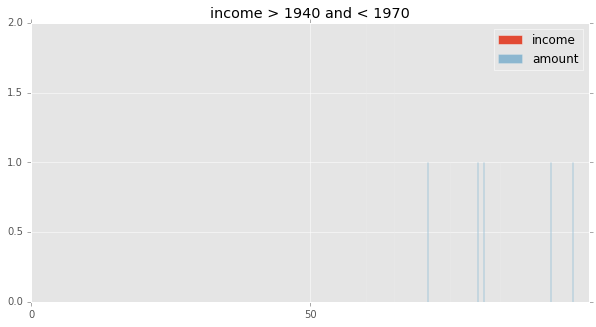



iteration 1
name 1970 to 2000
std 1041.01384799
mean 1439.7421875
median 1110.0
max_mult 2.2807906741
med_mult 0.5627389638414745
min_mult 0.00909550277918
q98 4000.0
q02 138.12
q75 2000.0
q25 600.0
iqr 1400.0
min_q -1500.0
max_q 4100.0
count of loans 665
pct of total loans 0.0288323880068


iteration 2
name 1970 to 2000
std 983.14512655
mean 1394.01904762
median 1100.0
max_mult 2.02736948809
med_mult 0.5559770696341257
min_mult 0.00909550277918
q98 3850.0
q02 137.32
q75 2000.0
q25 600.0
iqr 1400.0
min_q -1500.0
max_q 4100.0
count of loans 665
pct of total loans 0.0288323880068


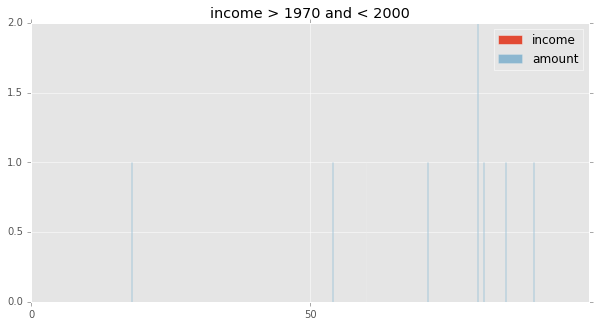



iteration 1
name 2000 to 2030
std 1007.69376966
mean 1416.58534137
median 1141.5
max_mult 2.25
med_mult 0.57075
min_mult 0.006
q98 4000.0
q02 110.9
q75 2000.0
q25 605.0
iqr 1395.0
min_q -1487.5
max_q 4092.5
count of loans 1040
pct of total loans 0.0450912534241


iteration 2
name 2000 to 2030
std 952.548649051
mean 1375.15580448
median 1125.0
max_mult 2.0
med_mult 0.5599913280475719
min_mult 0.006
q98 3659.5
q02 110.62
q75 2000.0
q25 600.0
iqr 1400.0
min_q -1500.0
max_q 4100.0
count of loans 1040
pct of total loans 0.0450912534241


iteration 3
name 2000 to 2030
std 952.548649051
mean 1375.15580448
median 1125.0
max_mult 2.0
med_mult 0.5599913280475719
min_mult 0.006
q98 3659.5
q02 110.62
q75 2000.0
q25 600.0
iqr 1400.0
min_q -1500.0
max_q 4100.0
count of loans 1040
pct of total loans 0.0450912534241


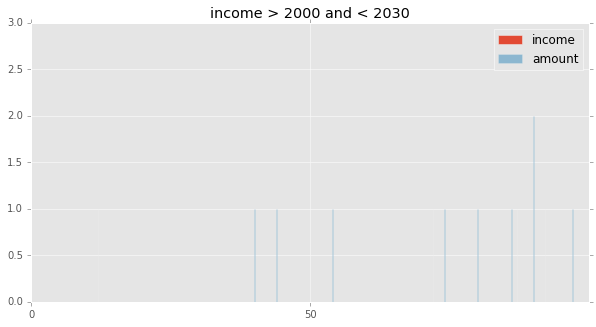



iteration 1
name 2030 to 2060
std 1026.33913811
mean 1432.71875
median 1100.0
max_mult 2.21238938053
med_mult 0.5392156862745098
min_mult 0.010752688172
q98 4090.52
q02 128.76
q75 2000.0
q25 636.25
iqr 1363.75
min_q -1409.375
max_q 4045.625
count of loans 537
pct of total loans 0.0232826952776


iteration 2
name 2030 to 2060
std 944.653860865
mean 1369.96606786
median 1100.0
max_mult 1.96533203125
med_mult 0.5365853658536586
min_mult 0.010752688172
q98 3500.0
q02 127.0
q75 2000.0
q25 625.0
iqr 1375.0
min_q -1437.5
max_q 4062.5
count of loans 537
pct of total loans 0.0232826952776


iteration 3
name 2030 to 2060
std 944.653860865
mean 1369.96606786
median 1100.0
max_mult 1.96533203125
med_mult 0.5365853658536586
min_mult 0.010752688172
q98 3500.0
q02 127.0
q75 2000.0
q25 625.0
iqr 1375.0
min_q -1437.5
max_q 4062.5
count of loans 537
pct of total loans 0.0232826952776


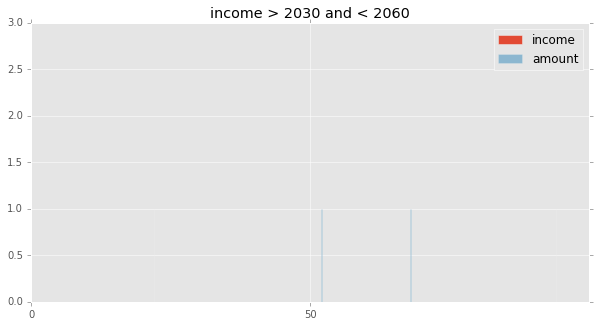



iteration 1
name 2060 to 2090
std 977.827557126
mean 1371.32286996
median 1195.0
max_mult 2.02898550725
med_mult 0.5761791400089272
min_mult 0.0210930009588
q98 3855.0
q02 107.7
q75 2000.0
q25 521.25
iqr 1478.75
min_q -1696.875
max_q 4218.125
count of loans 469
pct of total loans 0.0203344210153


iteration 2
name 2060 to 2090
std 977.827557126
mean 1371.32286996
median 1195.0
max_mult 2.02898550725
med_mult 0.5761791400089272
min_mult 0.0210930009588
q98 3855.0
q02 107.7
q75 2000.0
q25 521.25
iqr 1478.75
min_q -1696.875
max_q 4218.125
count of loans 469
pct of total loans 0.0203344210153


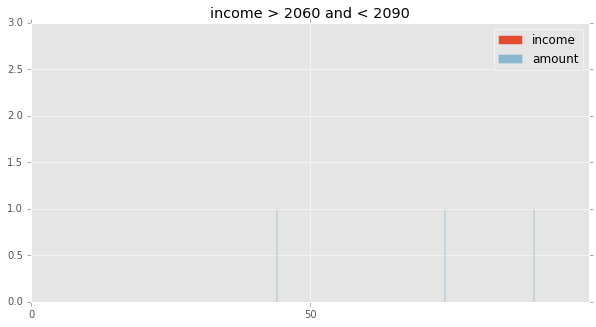



iteration 1
name 2090 to 2120
std 1133.13984039
mean 1446.99648506
median 1100.0
max_mult 2.3319047619
med_mult 0.5223171889838556
min_mult 0.00477554918816
q98 4225.6
q02 100.0
q75 2100.0
q25 500.0
iqr 1600.0
min_q -1900.0
max_q 4500.0
count of loans 587
pct of total loans 0.025450544


iteration 2
name 2090 to 2120
std 1062.60384191
mean 1394.40535714
median 1097.5
max_mult 2.12380952381
med_mult 0.5200950277216351
min_mult 0.00477554918816
q98 4000.0
q02 100.0
q75 2000.0
q25 500.0
iqr 1500.0
min_q -1750.0
max_q 4250.0
count of loans 587
pct of total loans 0.025450544


iteration 3
name 2090 to 2120
std 1048.69189735
mean 1383.48924731
median 1082.0
max_mult 2.02290076336
med_mult 0.5148111480310247
min_mult 0.00477554918816
q98 4000.0
q02 100.0
q75 2000.0
q25 500.0
iqr 1500.0
min_q -1750.0
max_q 4250.0
count of loans 587
pct of total loans 0.025450544


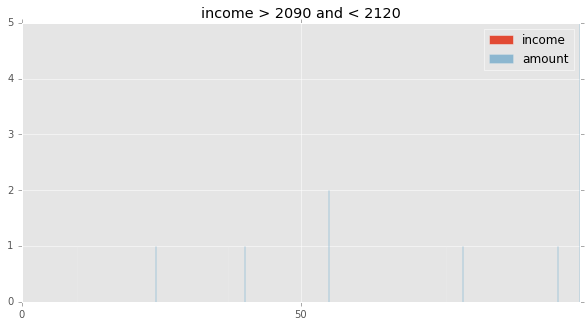



iteration 1
name 2120 to 2150
std 1077.75035898
mean 1409.65847666
median 1100.0
max_mult 2.19101123596
med_mult 0.5171603196991067
min_mult 0.0193396226415
q98 4394.6
q02 121.12
q75 2000.0
q25 500.0
iqr 1500.0
min_q -1750.0
max_q 4250.0
count of loans 430
pct of total loans 0.0186434990119


iteration 2
name 2120 to 2150
std 969.880389422
mean 1331.38539043
median 1100.0
max_mult 1.96353436185
med_mult 0.5132991133924405
min_mult 0.0193396226415
q98 3605.08
q02 120.68
q75 1988.0
q25 500.0
iqr 1488.0
min_q -1732.0
max_q 4220.0
count of loans 430
pct of total loans 0.0186434990119


iteration 3
name 2120 to 2150
std 969.880389422
mean 1331.38539043
median 1100.0
max_mult 1.96353436185
med_mult 0.5132991133924405
min_mult 0.0193396226415
q98 3605.08
q02 120.68
q75 1988.0
q25 500.0
iqr 1488.0
min_q -1732.0
max_q 4220.0
count of loans 430
pct of total loans 0.0186434990119


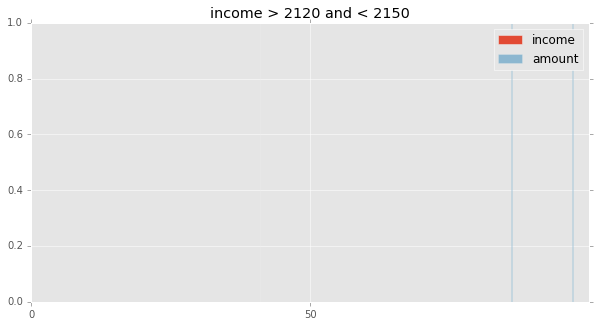



iteration 1
name 2150 to 2180
std 1087.18048546
mean 1455.20614035
median 1200.0
max_mult 2.24338132838
med_mult 0.5535839790053549
min_mult 0.0212667591308
q98 4198.8
q02 118.0
q75 2000.0
q25 533.75
iqr 1466.25
min_q -1665.625
max_q 4199.375
count of loans 486
pct of total loans 0.0210714895809


iteration 2
name 2150 to 2180
std 997.974416183
mean 1387.14798206
median 1200.0
max_mult 1.92551724138
med_mult 0.5510907294011649
min_mult 0.0212667591308
q98 3781.5
q02 117.7
q75 2000.0
q25 521.25
iqr 1478.75
min_q -1696.875
max_q 4218.125
count of loans 486
pct of total loans 0.0210714895809


iteration 3
name 2150 to 2180
std 997.974416183
mean 1387.14798206
median 1200.0
max_mult 1.92551724138
med_mult 0.5510907294011649
min_mult 0.0212667591308
q98 3781.5
q02 117.7
q75 2000.0
q25 521.25
iqr 1478.75
min_q -1696.875
max_q 4218.125
count of loans 486
pct of total loans 0.0210714895809


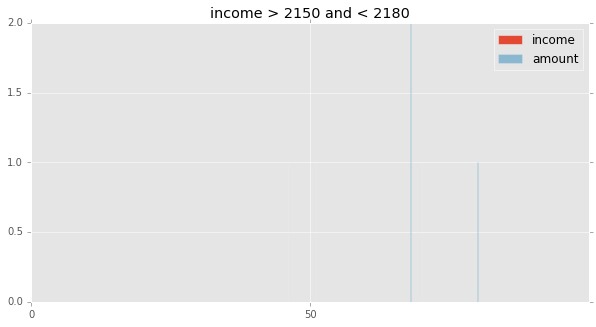



iteration 1
name 2180 to 2210
std 1013.39455204
mean 1436.27830189
median 1185.0
max_mult 1.94672131148
med_mult 0.5381447576802325
min_mult 0.0164835164835
q98 3977.46
q02 136.9
q75 2000.0
q25 654.5
iqr 1345.5
min_q -1363.75
max_q 4018.25
count of loans 452
pct of total loans 0.0195973524497


iteration 2
name 2180 to 2210
std 980.717427125
mean 1409.72619048
median 1163.5
max_mult 1.82232346241
med_mult 0.5288524217583769
min_mult 0.0164835164835
q98 3753.4
q02 135.7
q75 2000.0
q25 648.5
iqr 1351.5
min_q -1378.75
max_q 4027.25
count of loans 452
pct of total loans 0.0195973524497


iteration 3
name 2180 to 2210
std 980.717427125
mean 1409.72619048
median 1163.5
max_mult 1.82232346241
med_mult 0.5288524217583769
min_mult 0.0164835164835
q98 3753.4
q02 135.7
q75 2000.0
q25 648.5
iqr 1351.5
min_q -1378.75
max_q 4027.25
count of loans 452
pct of total loans 0.0195973524497


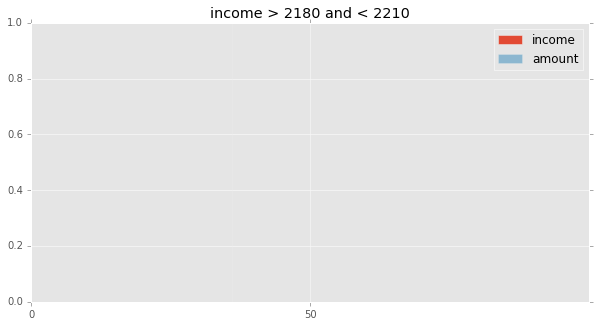



iteration 1
name 2210 to 2240
std 996.546643491
mean 1381.01061008
median 1100.0
max_mult 2.02702702703
med_mult 0.49235611510791366
min_mult 0.0113122171946
q98 3643.28
q02 109.36
q75 2000.0
q25 568.0
iqr 1432.0
min_q -1580.0
max_q 4148.0
count of loans 400
pct of total loans 0.0173427897785


iteration 2
name 2210 to 2240
std 974.948744734
mean 1365.10933333
median 1095.0
max_mult 1.87330316742
med_mult 0.49129075480125056
min_mult 0.0113122171946
q98 3588.0
q02 108.64
q75 2000.0
q25 559.0
iqr 1441.0
min_q -1602.5
max_q 4161.5
count of loans 400
pct of total loans 0.0173427897785


iteration 3
name 2210 to 2240
std 974.948744734
mean 1365.10933333
median 1095.0
max_mult 1.87330316742
med_mult 0.49129075480125056
min_mult 0.0113122171946
q98 3588.0
q02 108.64
q75 2000.0
q25 559.0
iqr 1441.0
min_q -1602.5
max_q 4161.5
count of loans 400
pct of total loans 0.0173427897785


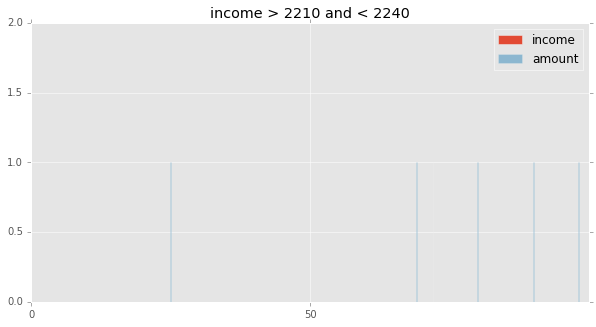



iteration 1
name 2240 to 2270
std 1309.15960097
mean 1818.28981723
median 1500.0
max_mult 2.47352024922
med_mult 0.6666666666666666
min_mult 0.0222518914108
q98 5036.0
q02 160.32
q75 2663.5
q25 805.0
iqr 1858.5
min_q -1982.75
max_q 5451.25
count of loans 394
pct of total loans 0.0170826479318


iteration 2
name 2240 to 2270
std 1271.88323586
mean 1789.00526316
median 1500.0
max_mult 2.3752228164
med_mult 0.6656328459607148
min_mult 0.0222518914108
q98 5000.0
q02 159.54
q75 2641.25
q25 800.0
iqr 1841.25
min_q -1961.875
max_q 5403.125
count of loans 394
pct of total loans 0.0170826479318


iteration 3
name 2240 to 2270
std 1271.88323586
mean 1789.00526316
median 1500.0
max_mult 2.3752228164
med_mult 0.6656328459607148
min_mult 0.0222518914108
q98 5000.0
q02 159.54
q75 2641.25
q25 800.0
iqr 1841.25
min_q -1961.875
max_q 5403.125
count of loans 394
pct of total loans 0.0170826479318


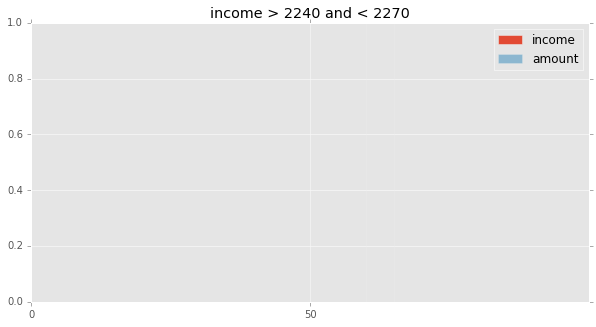



iteration 1
name 2270 to 2300
std 1052.44536077
mean 1493.25757576
median 1218.5
max_mult 1.9676432007
med_mult 0.5328051960616175
min_mult 0.0130890052356
q98 4000.0
q02 119.28
q75 2052.0
q25 681.25
iqr 1370.75
min_q -1374.875
max_q 4108.125
count of loans 351
pct of total loans 0.0152182980306


iteration 2
name 2270 to 2300
std 1007.9576099
mean 1457.62269939
median 1208.0
max_mult 1.75901495163
med_mult 0.5280687228954228
min_mult 0.0130890052356
q98 3845.0
q02 118.0
q75 2000.0
q25 676.0
iqr 1324.0
min_q -1310.0
max_q 3986.0
count of loans 351
pct of total loans 0.0152182980306


iteration 3
name 2270 to 2300
std 964.077849715
mean 1418.0529595
median 1200.0
max_mult 1.71277997365
med_mult 0.5263157894736842
min_mult 0.0130890052356
q98 3710.0
q02 116.4
q75 2000.0
q25 652.0
iqr 1348.0
min_q -1370.0
max_q 4022.0
count of loans 351
pct of total loans 0.0152182980306


iteration 4
name 2270 to 2300
std 964.077849715
mean 1418.0529595
median 1200.0
max_mult 1.71277997365
med_mult 0.5

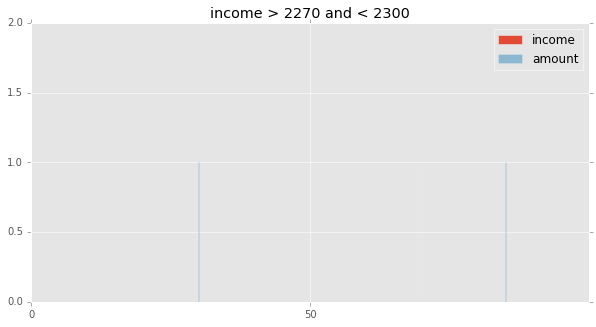



iteration 1
name 2300 to 2330
std 927.888466099
mean 1380.136
median 1125.0
max_mult 1.73524305556
med_mult 0.487012987012987
min_mult 0.00868055555556
q98 3531.04
q02 100.0
q75 2000.0
q25 635.0
iqr 1365.0
min_q -1412.5
max_q 4047.5
count of loans 395
pct of total loans 0.0171260049063


iteration 2
name 2300 to 2330
std 927.888466099
mean 1380.136
median 1125.0
max_mult 1.73524305556
med_mult 0.487012987012987
min_mult 0.00868055555556
q98 3531.04
q02 100.0
q75 2000.0
q25 635.0
iqr 1365.0
min_q -1412.5
max_q 4047.5
count of loans 395
pct of total loans 0.0171260049063


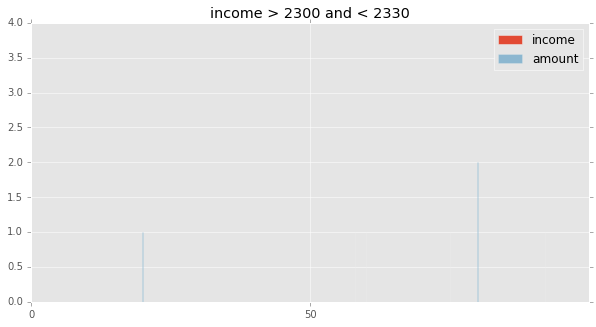



iteration 1
name 2330 to 2360
std 1271.81459666
mean 1526.51234568
median 1112.5
max_mult 2.29982964225
med_mult 0.47695492887124036
min_mult 0.0188034188034
q98 4900.0
q02 97.3
q75 2013.75
q25 444.5
iqr 1569.25
min_q -1909.375
max_q 4367.625
count of loans 339
pct of total loans 0.0146980143373


iteration 2
name 2330 to 2360
std 1084.43640971
mean 1384.15755627
median 1100.0
max_mult 1.79487179487
med_mult 0.4690831556503198
min_mult 0.0188034188034
q98 3992.0
q02 96.0
q75 2000.0
q25 427.5
iqr 1572.5
min_q -1931.25
max_q 4358.75
count of loans 339
pct of total loans 0.0146980143373


iteration 3
name 2330 to 2360
std 1084.43640971
mean 1384.15755627
median 1100.0
max_mult 1.79487179487
med_mult 0.4690831556503198
min_mult 0.0188034188034
q98 3992.0
q02 96.0
q75 2000.0
q25 427.5
iqr 1572.5
min_q -1931.25
max_q 4358.75
count of loans 339
pct of total loans 0.0146980143373


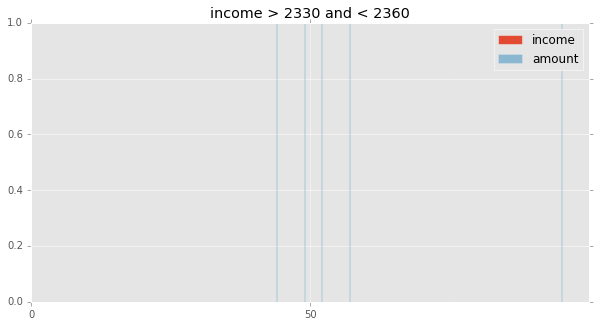



iteration 1
name 2360 to 2390
std 1189.81302998
mean 1597.05538462
median 1275.0
max_mult 2.19966159052
med_mult 0.535593220338983
min_mult 0.0197811447811
q98 4744.0
q02 119.0
q75 2450.0
q25 650.0
iqr 1800.0
min_q -2050.0
max_q 5150.0
count of loans 331
pct of total loans 0.0143511585417


iteration 2
name 2360 to 2390
std 1174.61667503
mean 1585.93518519
median 1269.5
max_mult 2.11685012701
med_mult 0.5353165430272339
min_mult 0.0197811447811
q98 4575.6
q02 119.0
q75 2441.0
q25 648.75
iqr 1792.25
min_q -2039.625
max_q 5129.375
count of loans 331
pct of total loans 0.0143511585417


iteration 3
name 2360 to 2390
std 1174.61667503
mean 1585.93518519
median 1269.5
max_mult 2.11685012701
med_mult 0.5353165430272339
min_mult 0.0197811447811
q98 4575.6
q02 119.0
q75 2441.0
q25 648.75
iqr 1792.25
min_q -2039.625
max_q 5129.375
count of loans 331
pct of total loans 0.0143511585417


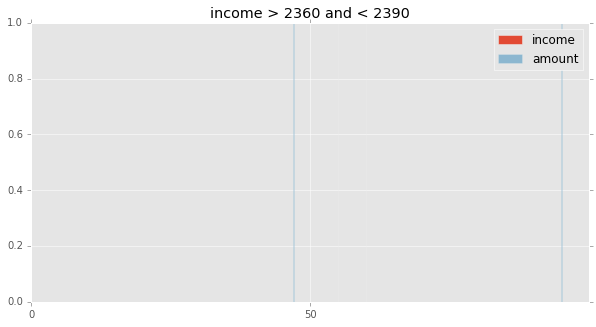



iteration 1
name 2390 to 2420
std 1175.58691004
mean 1509.08647799
median 1200.0
max_mult 2.125
med_mult 0.5
min_mult 0.00993788819876
q98 4500.0
q02 95.7
q75 2165.5
q25 555.0
iqr 1610.5
min_q -1860.75
max_q 4581.25
count of loans 668
pct of total loans 0.0289624589301


iteration 2
name 2390 to 2420
std 1100.32881419
mean 1451.0256
median 1180.0
max_mult 1.89583333333
med_mult 0.4880066170388751
min_mult 0.00993788819876
q98 4212.04
q02 95.48
q75 2000.0
q25 540.0
iqr 1460.0
min_q -1650.0
max_q 4190.0
count of loans 668
pct of total loans 0.0289624589301


iteration 3
name 2390 to 2420
std 1005.49470693
mean 1374.16584565
median 1100.0
max_mult 1.72333333333
med_mult 0.4592901878914405
min_mult 0.00993788819876
q98 3775.2
q02 95.16
q75 2000.0
q25 522.0
iqr 1478.0
min_q -1695.0
max_q 4217.0
count of loans 668
pct of total loans 0.0289624589301


iteration 4
name 2390 to 2420
std 1005.49470693
mean 1374.16584565
median 1100.0
max_mult 1.72333333333
med_mult 0.4592901878914405
min_mult 

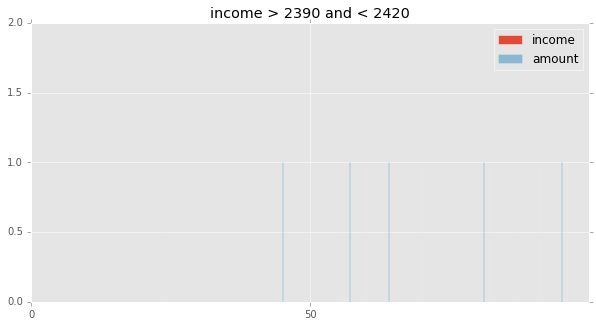



iteration 1
name 2420 to 2450
std 1104.21230095
mean 1403.09090909
median 1000.0
max_mult 1.92466035406
med_mult 0.41305245766212306
min_mult 0.0185414091471
q98 4000.0
q02 100.0
q75 2000.0
q25 514.0
iqr 1486.0
min_q -1715.0
max_q 4229.0
count of loans 289
pct of total loans 0.012530165615


iteration 2
name 2420 to 2450
std 1044.52967762
mean 1357.06642066
median 1000.0
max_mult 1.64136233073
med_mult 0.41254125412541254
min_mult 0.0185414091471
q98 3801.8
q02 100.0
q75 2000.0
q25 500.0
iqr 1500.0
min_q -1750.0
max_q 4250.0
count of loans 289
pct of total loans 0.012530165615


iteration 3
name 2420 to 2450
std 1044.52967762
mean 1357.06642066
median 1000.0
max_mult 1.64136233073
med_mult 0.41254125412541254
min_mult 0.0185414091471
q98 3801.8
q02 100.0
q75 2000.0
q25 500.0
iqr 1500.0
min_q -1750.0
max_q 4250.0
count of loans 289
pct of total loans 0.012530165615


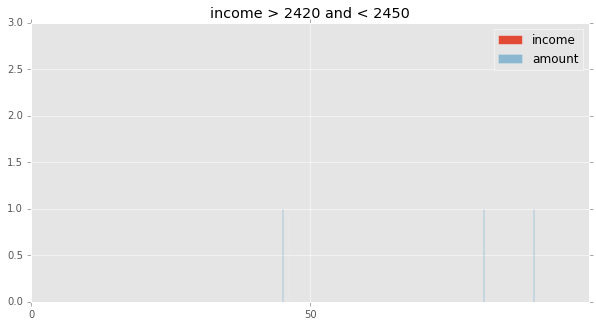



iteration 1
name 2450 to 2480
std 957.537885718
mean 1506.30716724
median 1364.0
max_mult 1.90495532088
med_mult 0.5533468559837729
min_mult 0.021960146401
q98 3790.0
q02 158.88
q75 2000.0
q25 800.0
iqr 1200.0
min_q -1000.0
max_q 3800.0
count of loans 318
pct of total loans 0.0137875178739


iteration 2
name 2450 to 2480
std 878.165155634
mean 1448.47735192
median 1320.0
max_mult 1.52563059398
med_mult 0.5356564019448946
min_mult 0.021960146401
q98 3404.4
q02 158.04
q75 2000.0
q25 794.0
iqr 1206.0
min_q -1015.0
max_q 3809.0
count of loans 318
pct of total loans 0.0137875178739


iteration 3
name 2450 to 2480
std 878.165155634
mean 1448.47735192
median 1320.0
max_mult 1.52563059398
med_mult 0.5356564019448946
min_mult 0.021960146401
q98 3404.4
q02 158.04
q75 2000.0
q25 794.0
iqr 1206.0
min_q -1015.0
max_q 3809.0
count of loans 318
pct of total loans 0.0137875178739


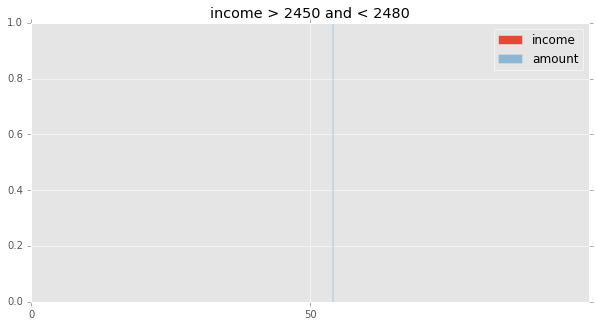



iteration 1
name 2480 to 2510
std 1132.30201692
mean 1480.19922631
median 1162.0
max_mult 1.932
med_mult 0.4655448717948718
min_mult 0.018
q98 4379.6
q02 100.0
q75 2048.0
q25 580.0
iqr 1468.0
min_q -1622.0
max_q 4250.0
count of loans 547
pct of total loans 0.0237162650221


iteration 2
name 2480 to 2510
std 1020.1062325
mean 1390.31075697
median 1100.0
max_mult 1.64
med_mult 0.4400880352140856
min_mult 0.018
q98 3849.8
q02 100.0
q75 2000.0
q25 568.25
iqr 1431.75
min_q -1579.375
max_q 4147.625
count of loans 547
pct of total loans 0.0237162650221


iteration 3
name 2480 to 2510
std 1020.1062325
mean 1390.31075697
median 1100.0
max_mult 1.64
med_mult 0.4400880352140856
min_mult 0.018
q98 3849.8
q02 100.0
q75 2000.0
q25 568.25
iqr 1431.75
min_q -1579.375
max_q 4147.625
count of loans 547
pct of total loans 0.0237162650221


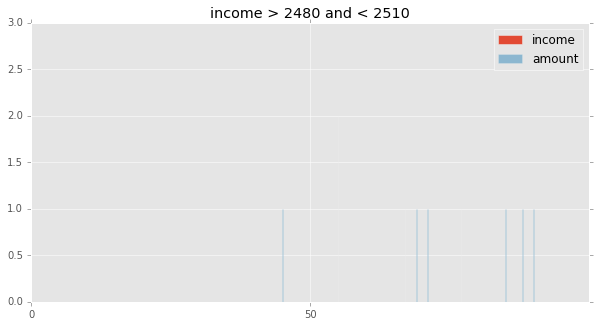



iteration 1
name 2510 to 2540
std 1215.58160119
mean 1535.55893536
median 1133.0
max_mult 1.99130778348
med_mult 0.451394422310757
min_mult 0.0134387351779
q98 4530.4
q02 81.68
q75 2240.0
q25 551.0
iqr 1689.0
min_q -1982.5
max_q 4773.5
count of loans 276
pct of total loans 0.0119665249472


iteration 2
name 2510 to 2540
std 1127.13596953
mean 1468.72093023
median 1100.0
max_mult 1.7895151754
med_mult 0.43631459637539094
min_mult 0.0134387351779
q98 4193.5
q02 80.98
q75 2095.0
q25 531.75
iqr 1563.25
min_q -1813.125
max_q 4439.875
count of loans 276
pct of total loans 0.0119665249472


iteration 3
name 2510 to 2540
std 1098.54634874
mean 1444.8828125
median 1100.0
max_mult 1.74741858618
med_mult 0.4357095352987971
min_mult 0.0134387351779
q98 4000.0
q02 80.7
q75 2067.25
q25 525.5
iqr 1541.75
min_q -1787.125
max_q 4379.875
count of loans 276
pct of total loans 0.0119665249472


iteration 4
name 2510 to 2540
std 1071.09123191
mean 1421.69291339
median 1078.0
max_mult 1.71603475513
med_mu

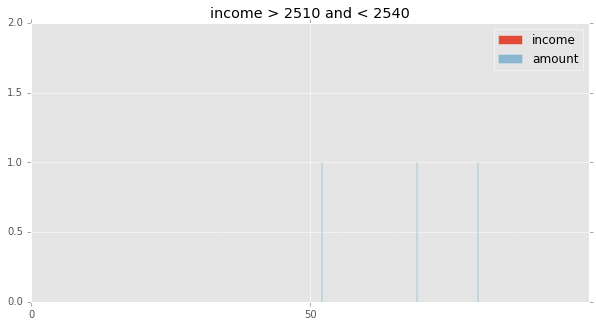



iteration 1
name 2540 to 2570
std 1135.06881481
mean 1469.74820144
median 1100.0
max_mult 1.8691588785
med_mult 0.43095006550778664
min_mult 0.0274725274725
q98 4436.28
q02 162.16
q75 2022.5
q25 567.25
iqr 1455.25
min_q -1615.625
max_q 4205.375
count of loans 294
pct of total loans 0.0127469504872


iteration 2
name 2540 to 2570
std 1008.86220133
mean 1369.26394052
median 1000.0
max_mult 1.57480314961
med_mult 0.3937007874015748
min_mult 0.0274725274725
q98 3846.4
q02 161.44
q75 2000.0
q25 548.0
iqr 1452.0
min_q -1630.0
max_q 4178.0
count of loans 294
pct of total loans 0.0127469504872


iteration 3
name 2540 to 2570
std 1008.86220133
mean 1369.26394052
median 1000.0
max_mult 1.57480314961
med_mult 0.3937007874015748
min_mult 0.0274725274725
q98 3846.4
q02 161.44
q75 2000.0
q25 548.0
iqr 1452.0
min_q -1630.0
max_q 4178.0
count of loans 294
pct of total loans 0.0127469504872


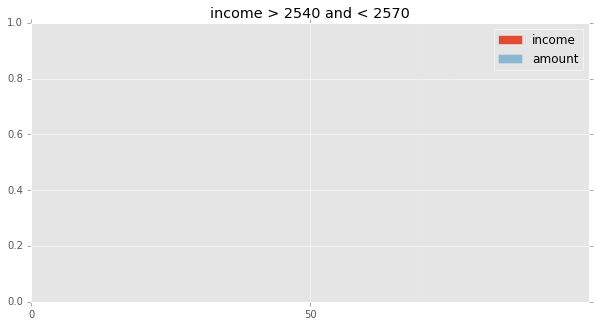



iteration 1
name 2570 to 2600
std 1412.72497578
mean 1790.39393939
median 1275.0
max_mult 2.20930232558
med_mult 0.4926866820631255
min_mult 0.03108003108
q98 5000.0
q02 161.6
q75 2465.5
q25 706.5
iqr 1759.0
min_q -1932.0
max_q 5104.0
count of loans 239
pct of total loans 0.0103623168927


iteration 2
name 2570 to 2600
std 1374.91893708
mean 1757.88646288
median 1250.0
max_mult 1.94174757282
med_mult 0.48318515655199074
min_mult 0.03108003108
q98 5000.0
q02 161.16
q75 2400.0
q25 700.0
iqr 1700.0
min_q -1850.0
max_q 4950.0
count of loans 239
pct of total loans 0.0103623168927


iteration 3
name 2570 to 2600
std 1250.23139152
mean 1640.52488688
median 1220.0
max_mult 1.88660990712
med_mult 0.4728682170542636
min_mult 0.03108003108
q98 4750.0
q02 159.4
q75 2160.0
q25 694.0
iqr 1466.0
min_q -1505.0
max_q 4359.0
count of loans 239
pct of total loans 0.0103623168927


iteration 4
name 2570 to 2600
std 1086.24305288
mean 1497.25118483
median 1141.0
max_mult 1.66241792198
med_mult 0.44310679

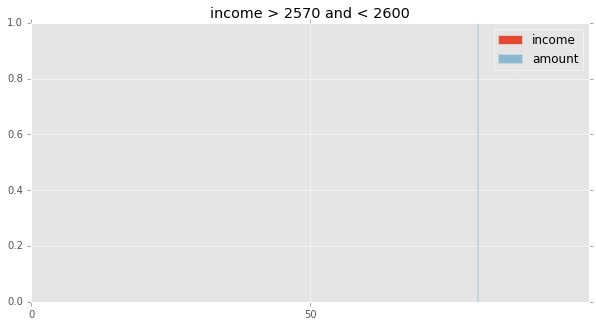



iteration 1
name 2600 to 2630
std 1297.57350449
mean 1604.36964981
median 1400.0
max_mult 2.01767870869
med_mult 0.5333333333333333
min_mult 0.0134615384615
q98 5000.0
q02 71.08
q75 2400.0
q25 450.0
iqr 1950.0
min_q -2475.0
max_q 5325.0
count of loans 266
pct of total loans 0.0115329552027


iteration 2
name 2600 to 2630
std 1297.57350449
mean 1604.36964981
median 1400.0
max_mult 2.01767870869
med_mult 0.5333333333333333
min_mult 0.0134615384615
q98 5000.0
q02 71.08
q75 2400.0
q25 450.0
iqr 1950.0
min_q -2475.0
max_q 5325.0
count of loans 266
pct of total loans 0.0115329552027


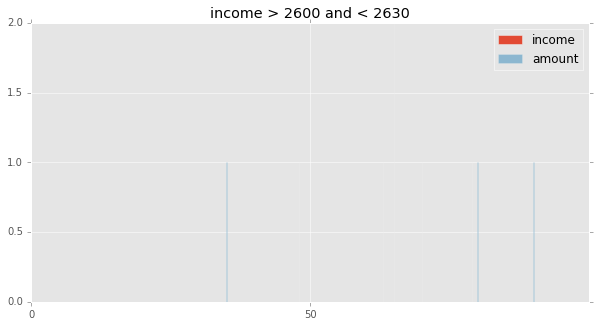



iteration 1
name 2630 to 2660
std 1038.24759094
mean 1371.33333333
median 1057.5
max_mult 1.66729821902
med_mult 0.40003827947018356
min_mult 0.0185606060606
q98 4000.0
q02 99.32
q75 2000.0
q25 528.0
iqr 1472.0
min_q -1680.0
max_q 4208.0
count of loans 250
pct of total loans 0.0108392436116


iteration 2
name 2630 to 2660
std 1004.24078957
mean 1345.43965517
median 1035.0
max_mult 1.53320754717
med_mult 0.39185040183101705
min_mult 0.0185606060606
q98 3821.44
q02 99.24
q75 2000.0
q25 521.0
iqr 1479.0
min_q -1697.5
max_q 4218.5
count of loans 250
pct of total loans 0.0108392436116


iteration 3
name 2630 to 2660
std 1004.24078957
mean 1345.43965517
median 1035.0
max_mult 1.53320754717
med_mult 0.39185040183101705
min_mult 0.0185606060606
q98 3821.44
q02 99.24
q75 2000.0
q25 521.0
iqr 1479.0
min_q -1697.5
max_q 4218.5
count of loans 250
pct of total loans 0.0108392436116


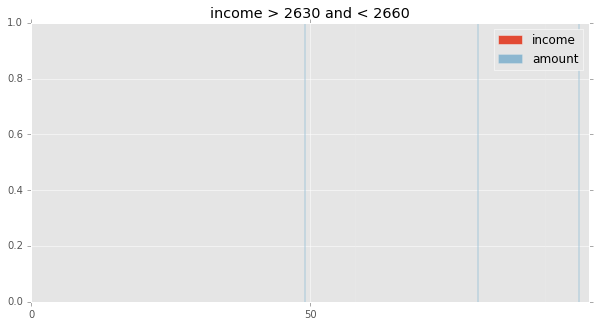



iteration 1
name 2660 to 2690
std 1242.65082026
mean 1554.64049587
median 1100.0
max_mult 2.03681666047
med_mult 0.41299055711472565
min_mult 0.0236397748593
q98 4586.0
q02 118.2
q75 2223.0
q25 510.75
iqr 1712.25
min_q -2057.625
max_q 4791.375
count of loans 251
pct of total loans 0.010882600586


iteration 2
name 2660 to 2690
std 1161.82958691
mean 1494.5210084
median 1100.0
max_mult 1.77106636838
med_mult 0.4109877218089909
min_mult 0.0236397748593
q98 4500.0
q02 117.4
q75 2151.25
q25 502.25
iqr 1649.0
min_q -1971.25
max_q 4624.75
count of loans 251
pct of total loans 0.010882600586


iteration 3
name 2660 to 2690
std 1144.75797165
mean 1480.78481013
median 1100.0
max_mult 1.69902912621
med_mult 0.4098360655737705
min_mult 0.0236397748593
q98 4453.92
q02 117.2
q75 2125.0
q25 500.0
iqr 1625.0
min_q -1937.5
max_q 4562.5
count of loans 251
pct of total loans 0.010882600586


iteration 4
name 2660 to 2690
std 1144.75797165
mean 1480.78481013
median 1100.0
max_mult 1.69902912621
med_mul

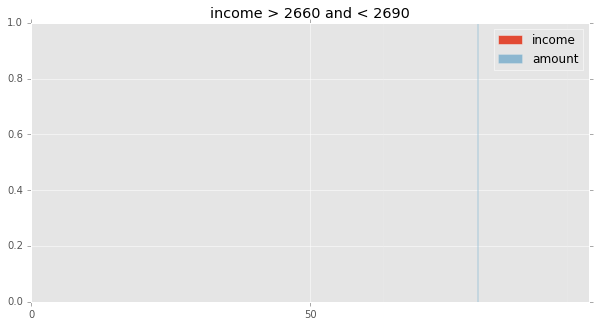



iteration 1
name 2690 to 2720
std 1242.56703206
mean 1678.66171004
median 1300.0
max_mult 1.94805194805
med_mult 0.47935103244837757
min_mult 0.0174332344214
q98 4898.0
q02 155.76
q75 2500.0
q25 730.0
iqr 1770.0
min_q -1925.0
max_q 5155.0
count of loans 279
pct of total loans 0.0120965958705


iteration 2
name 2690 to 2720
std 1225.48266082
mean 1665.3358209
median 1300.0
max_mult 1.85185185185
med_mult 0.47917441084467516
min_mult 0.0174332344214
q98 4816.0
q02 155.44
q75 2455.0
q25 730.0
iqr 1725.0
min_q -1857.5
max_q 5042.5
count of loans 279
pct of total loans 0.0120965958705


iteration 3
name 2690 to 2720
std 1225.48266082
mean 1665.3358209
median 1300.0
max_mult 1.85185185185
med_mult 0.47917441084467516
min_mult 0.0174332344214
q98 4816.0
q02 155.44
q75 2455.0
q25 730.0
iqr 1725.0
min_q -1857.5
max_q 5042.5
count of loans 279
pct of total loans 0.0120965958705


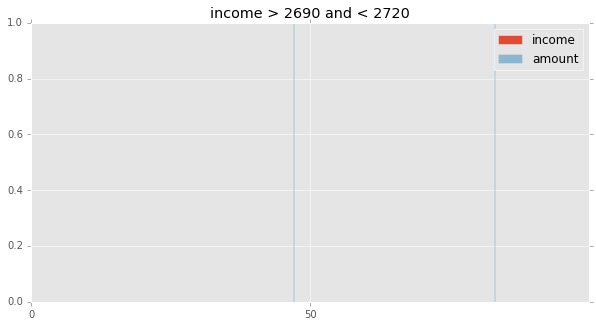



iteration 1
name 2720 to 2750
std 1101.08806225
mean 1448.95673077
median 1082.5
max_mult 1.7419236417
med_mult 0.3954892800618548
min_mult 0.00734484024972
q98 4017.72
q02 134.42
q75 2042.5
q25 527.0
iqr 1515.5
min_q -1746.25
max_q 4315.75
count of loans 220
pct of total loans 0.00953853437818


iteration 2
name 2720 to 2750
std 1021.69336074
mean 1388.32352941
median 1000.0
max_mult 1.46630236794
med_mult 0.36757950148085694
min_mult 0.00734484024972
q98 3630.28
q02 134.18
q75 2000.0
q25 500.0
iqr 1500.0
min_q -1750.0
max_q 4250.0
count of loans 220
pct of total loans 0.00953853437818


iteration 3
name 2720 to 2750
std 1021.69336074
mean 1388.32352941
median 1000.0
max_mult 1.46630236794
med_mult 0.36757950148085694
min_mult 0.00734484024972
q98 3630.28
q02 134.18
q75 2000.0
q25 500.0
iqr 1500.0
min_q -1750.0
max_q 4250.0
count of loans 220
pct of total loans 0.00953853437818


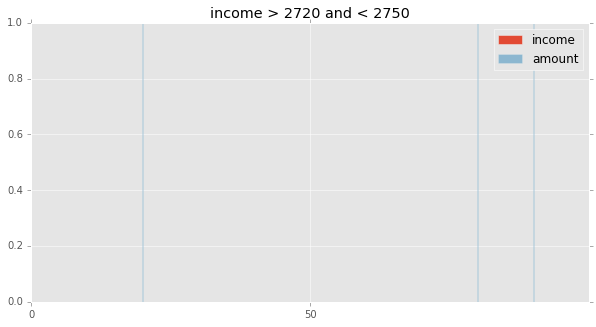



iteration 1
name 2750 to 2780
std 1500.03610594
mean 1819.86255924
median 1290.0
max_mult 2.22302679218
med_mult 0.4673913043478261
min_mult 0.0180050414116
q98 5768.8
q02 136.0
q75 2825.0
q25 650.0
iqr 2175.0
min_q -2612.5
max_q 6087.5
count of loans 216
pct of total loans 0.00936510648039


iteration 2
name 2750 to 2780
std 1473.48216492
mean 1799.29047619
median 1270.0
max_mult 2.17391304348
med_mult 0.45949044986177434
min_mult 0.0180050414116
q98 5702.9
q02 135.9
q75 2786.75
q25 650.0
iqr 2136.75
min_q -2555.125
max_q 5991.875
count of loans 216
pct of total loans 0.00936510648039


iteration 3
name 2750 to 2780
std 1393.57957071
mean 1738.41062802
median 1229.0
max_mult 2.08324324324
med_mult 0.44288288288288286
min_mult 0.0180050414116
q98 5400.8
q02 135.6
q75 2700.0
q25 645.0
iqr 2055.0
min_q -2437.5
max_q 5782.5
count of loans 216
pct of total loans 0.00936510648039


iteration 4
name 2750 to 2780
std 1393.57957071
mean 1738.41062802
median 1229.0
max_mult 2.08324324324
med_

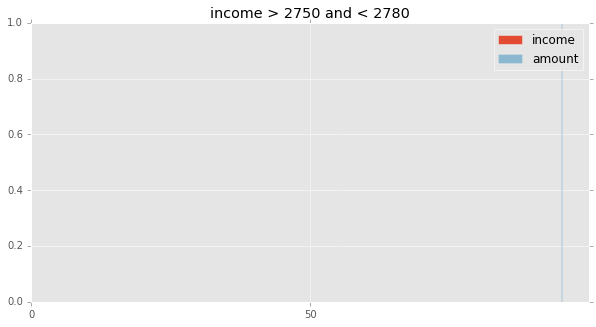



iteration 1
name 2780 to 2810
std 1158.04354064
mean 1617.72380952
median 1380.0
max_mult 1.96428571429
med_mult 0.4928571428571429
min_mult 0.00392716886826
q98 4276.8
q02 144.26
q75 2368.75
q25 649.25
iqr 1719.5
min_q -1930.0
max_q 4948.0
count of loans 222
pct of total loans 0.00962524832707


iteration 2
name 2780 to 2810
std 1083.37680159
mean 1566.28985507
median 1350.0
max_mult 1.61812297735
med_mult 0.48345323741007196
min_mult 0.00392716886826
q98 4020.24
q02 143.84
q75 2261.5
q25 646.5
iqr 1615.0
min_q -1776.0
max_q 4684.0
count of loans 222
pct of total loans 0.00962524832707


iteration 3
name 2780 to 2810
std 1083.37680159
mean 1566.28985507
median 1350.0
max_mult 1.61812297735
med_mult 0.48345323741007196
min_mult 0.00392716886826
q98 4020.24
q02 143.84
q75 2261.5
q25 646.5
iqr 1615.0
min_q -1776.0
max_q 4684.0
count of loans 222
pct of total loans 0.00962524832707


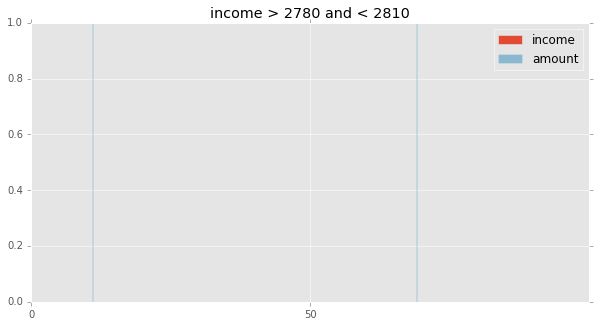



iteration 1
name 2810 to 2840
std 1224.16509264
mean 1628.48717949
median 1372.5
max_mult 1.77809388336
med_mult 0.484830042953263
min_mult 0.0283085633404
q98 5000.0
q02 113.2
q75 2250.0
q25 747.5
iqr 1502.5
min_q -1506.25
max_q 4503.75
count of loans 161
pct of total loans 0.00698047288585


iteration 2
name 2810 to 2840
std 1040.6155609
mean 1493.62666667
median 1277.0
max_mult 1.58562367865
med_mult 0.45235540798964025
min_mult 0.0283085633404
q98 4000.0
q02 112.88
q75 2024.0
q25 732.5
iqr 1291.5
min_q -1204.75
max_q 3961.25
count of loans 161
pct of total loans 0.00698047288585


iteration 3
name 2810 to 2840
std 951.660113864
mean 1419.78082192
median 1245.0
max_mult 1.3829787234
med_mult 0.4388428247768391
min_mult 0.0283085633404
q98 3577.5
q02 112.4
q75 2000.0
q25 688.75
iqr 1311.25
min_q -1278.125
max_q 3966.875
count of loans 161
pct of total loans 0.00698047288585


iteration 4
name 2810 to 2840
std 951.660113864
mean 1419.78082192
median 1245.0
max_mult 1.3829787234
med_

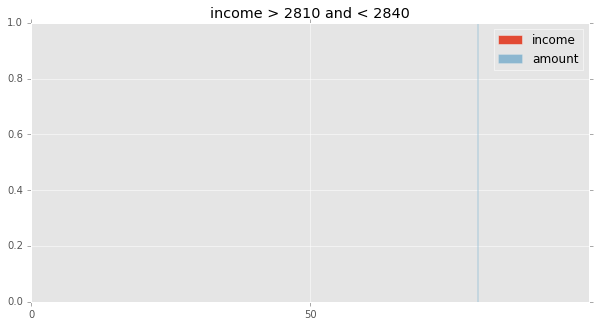



iteration 1
name 2840 to 2870
std 1147.99058343
mean 1473.99468085
median 1103.0
max_mult 1.72535211268
med_mult 0.3865465201393221
min_mult 0.0349283967866
q98 4648.52
q02 112.74
q75 2074.0
q25 485.0
iqr 1589.0
min_q -1898.5
max_q 4457.5
count of loans 198
pct of total loans 0.00858468094036


iteration 2
name 2840 to 2870
std 1025.85405446
mean 1384.69945355
median 1100.0
max_mult 1.55172413793
med_mult 0.3851540616246499
min_mult 0.0349283967866
q98 4021.6
q02 112.64
q75 2000.0
q25 436.0
iqr 1564.0
min_q -1910.0
max_q 4346.0
count of loans 198
pct of total loans 0.00858468094036


iteration 3
name 2840 to 2870
std 980.607673752
mean 1351.32596685
median 1100.0
max_mult 1.49718706048
med_mult 0.3834088532589753
min_mult 0.0349283967866
q98 3680.2
q02 112.6
q75 2000.0
q25 432.0
iqr 1568.0
min_q -1920.0
max_q 4352.0
count of loans 198
pct of total loans 0.00858468094036


iteration 4
name 2840 to 2870
std 980.607673752
mean 1351.32596685
median 1100.0
max_mult 1.49718706048
med_mult 

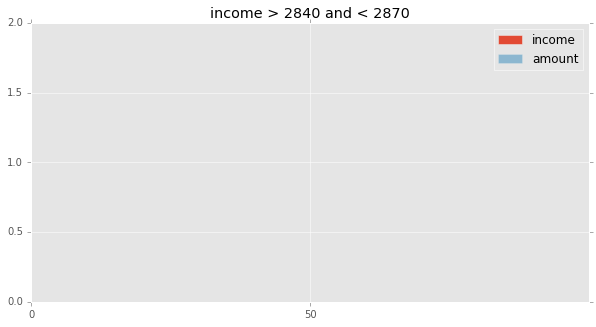



iteration 1
name 2870 to 2900
std 1238.63506065
mean 1449.27717391
median 1016.5
max_mult 1.73913043478
med_mult 0.3522723178254352
min_mult 0.00862961684501
q98 4749.2
q02 68.3
q75 2042.5
q25 417.0
iqr 1625.5
min_q -2021.25
max_q 4480.75
count of loans 192
pct of total loans 0.00832453909368


iteration 2
name 2870 to 2900
std 1034.96582538
mean 1297.76704545
median 1000.0
max_mult 1.53043478261
med_mult 0.3474031718507
min_mult 0.00862961684501
q98 3785.0
q02 67.5
q75 2000.0
q25 417.0
iqr 1583.0
min_q -1957.5
max_q 4374.5
count of loans 192
pct of total loans 0.00832453909368


iteration 3
name 2870 to 2900
std 1010.78424293
mean 1280.04
median 1000.0
max_mult 1.38937130948
med_mult 0.3473428273706148
min_mult 0.00862961684501
q98 3630.0
q02 67.4
q75 2000.0
q25 417.0
iqr 1583.0
min_q -1957.5
max_q 4374.5
count of loans 192
pct of total loans 0.00832453909368


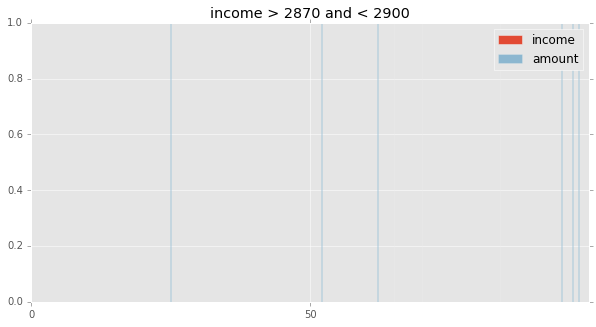



iteration 1
name 2900 to 2930
std 1315.56866852
mean 1534.62874251
median 1100.0
max_mult 1.85606060606
med_mult 0.3785271851342051
min_mult 0.0174299384826
q98 5000.0
q02 120.96
q75 2076.5
q25 483.0
iqr 1593.5
min_q -1907.25
max_q 4466.75
count of loans 174
pct of total loans 0.00754411355365


iteration 2
name 2900 to 2930
std 1050.76678576
mean 1337.90506329
median 1000.0
max_mult 1.46450723639
med_mult 0.34453058731277536
min_mult 0.0174299384826
q98 3776.36
q02 120.42
q75 2000.0
q25 452.25
iqr 1547.75
min_q -1869.375
max_q 4321.625
count of loans 174
pct of total loans 0.00754411355365


iteration 3
name 2900 to 2930
std 1050.76678576
mean 1337.90506329
median 1000.0
max_mult 1.46450723639
med_mult 0.34453058731277536
min_mult 0.0174299384826
q98 3776.36
q02 120.42
q75 2000.0
q25 452.25
iqr 1547.75
min_q -1869.375
max_q 4321.625
count of loans 174
pct of total loans 0.00754411355365


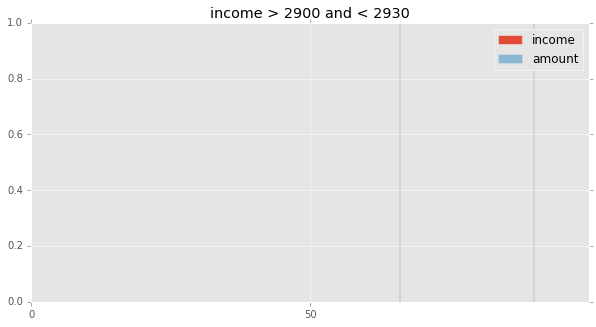



iteration 1
name 2930 to 2960
std 1286.15706971
mean 1646.10945274
median 1260.0
max_mult 1.76211453744
med_mult 0.4271186440677966
min_mult 0.0170183798502
q98 5000.0
q02 85.0
q75 2429.0
q25 675.0
iqr 1754.0
min_q -1956.0
max_q 5060.0
count of loans 210
pct of total loans 0.00910496463372


iteration 2
name 2930 to 2960
std 1264.40784575
mean 1628.34
median 1257.5
max_mult 1.70183798502
med_mult 0.4263433166083303
min_mult 0.0170183798502
q98 4826.54
q02 84.7
q75 2405.75
q25 662.25
iqr 1743.5
min_q -1953.0
max_q 5021.0
count of loans 210
pct of total loans 0.00910496463372


iteration 3
name 2930 to 2960
std 1264.40784575
mean 1628.34
median 1257.5
max_mult 1.70183798502
med_mult 0.4263433166083303
min_mult 0.0170183798502
q98 4826.54
q02 84.7
q75 2405.75
q25 662.25
iqr 1743.5
min_q -1953.0
max_q 5021.0
count of loans 210
pct of total loans 0.00910496463372


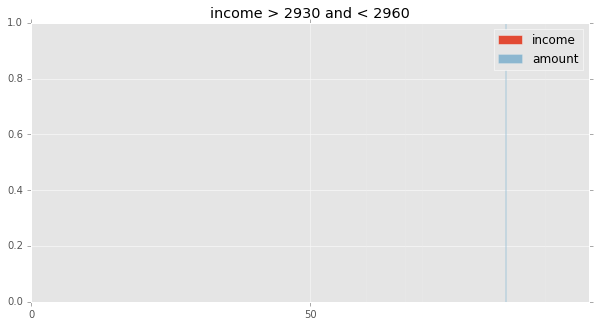



iteration 1
name 2960 to 2990
std 1360.48708126
mean 1649.41772152
median 1375.0
max_mult 1.74621848739
med_mult 0.462886465915749
min_mult 0.00773369199731
q98 5000.0
q02 106.94
q75 2250.0
q25 626.25
iqr 1623.75
min_q -1809.375
max_q 4685.625
count of loans 164
pct of total loans 0.00711054380919


iteration 2
name 2960 to 2990
std 1016.99612468
mean 1379.16438356
median 1100.0
max_mult 1.41652613828
med_mult 0.3701221781325631
min_mult 0.00773369199731
q98 4000.0
q02 103.9
q75 2000.0
q25 538.25
iqr 1461.75
min_q -1654.375
max_q 4192.625
count of loans 164
pct of total loans 0.00711054380919


iteration 3
name 2960 to 2990
std 992.887105569
mean 1359.71034483
median 1100.0
max_mult 1.34544231416
med_mult 0.36949949613705074
min_mult 0.00773369199731
q98 3648.0
q02 103.88
q75 2000.0
q25 530.0
iqr 1470.0
min_q -1675.0
max_q 4205.0
count of loans 164
pct of total loans 0.00711054380919


iteration 4
name 2960 to 2990
std 992.887105569
mean 1359.71034483
median 1100.0
max_mult 1.3454423

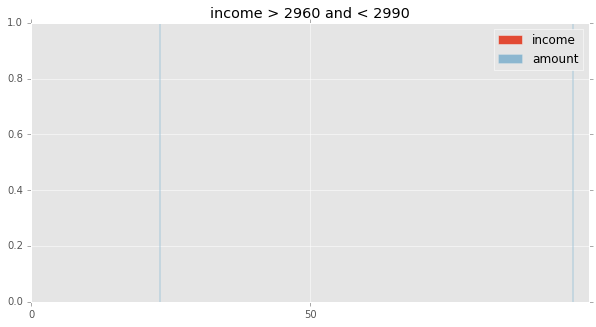



iteration 1
name 2990 to 3020
std 1141.43702162
mean 1417.90019569
median 1036.0
max_mult 1.66666666667
med_mult 0.3453333333333333
min_mult 0.00833333333333
q98 4527.2
q02 126.0
q75 2000.0
q25 549.0
iqr 1451.0
min_q -1627.5
max_q 4176.5
count of loans 550
pct of total loans 0.0238463359454


iteration 2
name 2990 to 3020
std 950.468409129
mean 1281.64489796
median 1000.0
max_mult 1.38333333333
med_mult 0.3333333333333333
min_mult 0.00833333333333
q98 3522.0
q02 122.36
q75 1872.25
q25 500.25
iqr 1372.0
min_q -1557.75
max_q 3930.25
count of loans 550
pct of total loans 0.0238463359454


iteration 3
name 2990 to 3020
std 912.614871088
mean 1253.13608247
median 1000.0
max_mult 1.28333333333
med_mult 0.3333333333333333
min_mult 0.00833333333333
q98 3438.8
q02 121.16
q75 1770.0
q25 500.0
iqr 1270.0
min_q -1405.0
max_q 3675.0
count of loans 550
pct of total loans 0.0238463359454


iteration 4
name 2990 to 3020
std 893.293737596
mean 1237.40871369
median 1000.0
max_mult 1.20833333333
med_mu

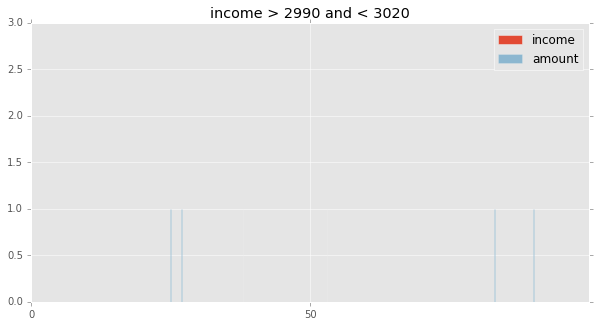



iteration 1
name 3020 to 3050
std 1040.26600937
mean 1451.15068493
median 1255.0
max_mult 1.48465852854
med_mult 0.41521847070506457
min_mult 0.0234014502307
q98 4018.1
q02 107.1
q75 2000.0
q25 645.75
iqr 1354.25
min_q -1385.625
max_q 4031.375
count of loans 156
pct of total loans 0.00676368801362


iteration 2
name 3020 to 3050
std 961.886815145
mean 1390.64335664
median 1232.0
max_mult 1.32406487918
med_mult 0.4061984833498187
min_mult 0.0234014502307
q98 3712.88
q02 105.96
q75 1975.0
q25 635.0
iqr 1340.0
min_q -1375.0
max_q 3985.0
count of loans 156
pct of total loans 0.00676368801362


iteration 3
name 3020 to 3050
std 916.404023588
mean 1353.63120567
median 1228.0
max_mult 1.29924117453
med_mult 0.4060846560846561
min_mult 0.0234014502307
q98 3402.0
q02 105.2
q75 1920.0
q25 625.0
iqr 1295.0
min_q -1317.5
max_q 3862.5
count of loans 156
pct of total loans 0.00676368801362


iteration 4
name 3020 to 3050
std 892.997610854
mean 1335.17142857
median 1214.0
max_mult 1.20604666448
med

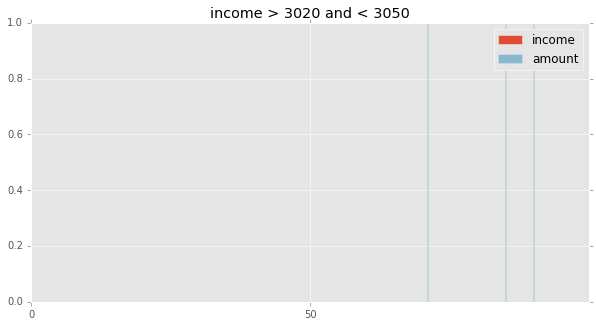



iteration 1
name 3050 to 3080
std 1280.15424971
mean 1598.23239437
median 1238.0
max_mult 1.82113821138
med_mult 0.4039077039450356
min_mult 0.00688524590164
q98 4817.96
q02 90.64
q75 2425.0
q25 582.5
iqr 1842.5
min_q -2181.25
max_q 5188.75
count of loans 152
pct of total loans 0.00659026011583


iteration 2
name 3050 to 3080
std 1239.07327661
mean 1569.85106383
median 1226.0
max_mult 1.6393442623
med_mult 0.40104677788681714
min_mult 0.00688524590164
q98 4455.6
q02 90.6
q75 2350.0
q25 580.0
iqr 1770.0
min_q -2075.0
max_q 5005.0
count of loans 152
pct of total loans 0.00659026011583


iteration 3
name 3050 to 3080
std 1239.07327661
mean 1569.85106383
median 1226.0
max_mult 1.6393442623
med_mult 0.40104677788681714
min_mult 0.00688524590164
q98 4455.6
q02 90.6
q75 2350.0
q25 580.0
iqr 1770.0
min_q -2075.0
max_q 5005.0
count of loans 152
pct of total loans 0.00659026011583


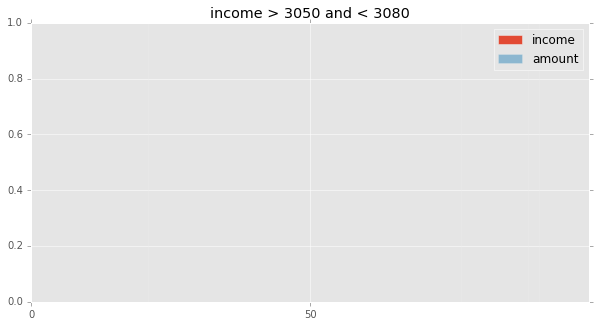



iteration 1
name 3080 to 3110
std 986.420131245
mean 1335.71428571
median 1000.0
max_mult 1.38798701299
med_mult 0.3241491085899514
min_mult 0.0161812297735
q98 3914.24
q02 116.52
q75 1988.0
q25 590.0
iqr 1398.0
min_q -1507.0
max_q 4085.0
count of loans 149
pct of total loans 0.00646018919249


iteration 2
name 3080 to 3110
std 927.116616289
mean 1291.94656489
median 1000.0
max_mult 1.287001287
med_mult 0.3241491085899514
min_mult 0.0161812297735
q98 3516.0
q02 115.8
q75 1940.0
q25 559.0
iqr 1381.0
min_q -1512.5
max_q 4011.5
count of loans 149
pct of total loans 0.00646018919249


iteration 3
name 3080 to 3110
std 927.116616289
mean 1291.94656489
median 1000.0
max_mult 1.287001287
med_mult 0.3241491085899514
min_mult 0.0161812297735
q98 3516.0
q02 115.8
q75 1940.0
q25 559.0
iqr 1381.0
min_q -1512.5
max_q 4011.5
count of loans 149
pct of total loans 0.00646018919249


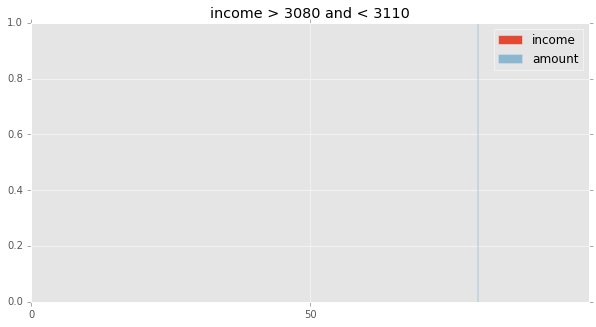



iteration 1
name 3110 to 3140
std 1193.1157745
mean 1391.48387097
median 1000.0
max_mult 1.552
med_mult 0.3214400514304082
min_mult 0.0191693290735
q98 4605.6
q02 114.48
q75 2000.0
q25 417.0
iqr 1583.0
min_q -1957.5
max_q 4374.5
count of loans 162
pct of total loans 0.0070238298603


iteration 2
name 3110 to 3140
std 1018.05626949
mean 1260.8590604
median 1000.0
max_mult 1.37060702875
med_mult 0.32051282051282054
min_mult 0.0191693290735
q98 3586.0
q02 113.4
q75 1979.0
q25 400.0
iqr 1579.0
min_q -1968.5
max_q 4347.5
count of loans 162
pct of total loans 0.0070238298603


iteration 3
name 3110 to 3140
std 1018.05626949
mean 1260.8590604
median 1000.0
max_mult 1.37060702875
med_mult 0.32051282051282054
min_mult 0.0191693290735
q98 3586.0
q02 113.4
q75 1979.0
q25 400.0
iqr 1579.0
min_q -1968.5
max_q 4347.5
count of loans 162
pct of total loans 0.0070238298603


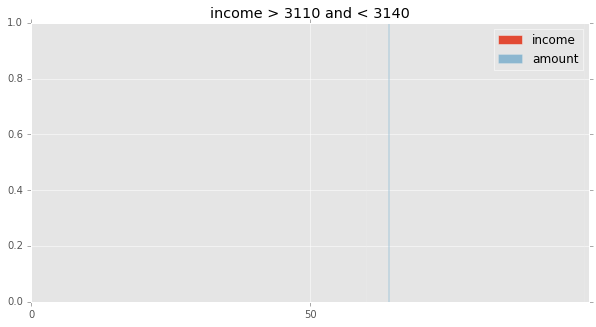



iteration 1
name 3140 to 3170
std 1464.57521463
mean 1749.95714286
median 1397.5
max_mult 1.87301587302
med_mult 0.44175427394623956
min_mult 0.0225683407502
q98 5544.0
q02 95.14
q75 2522.5
q25 476.25
iqr 2046.25
min_q -2593.125
max_q 5591.875
count of loans 145
pct of total loans 0.00628676129471


iteration 2
name 3140 to 3170
std 1350.85943156
mean 1661.5620438
median 1360.0
max_mult 1.74547762615
med_mult 0.43312101910828027
min_mult 0.0225683407502
q98 5000.0
q02 94.36
q75 2500.0
q25 465.0
iqr 2035.0
min_q -2587.5
max_q 5552.5
count of loans 145
pct of total loans 0.00628676129471


iteration 3
name 3140 to 3170
std 1350.85943156
mean 1661.5620438
median 1360.0
max_mult 1.74547762615
med_mult 0.43312101910828027
min_mult 0.0225683407502
q98 5000.0
q02 94.36
q75 2500.0
q25 465.0
iqr 2035.0
min_q -2587.5
max_q 5552.5
count of loans 145
pct of total loans 0.00628676129471


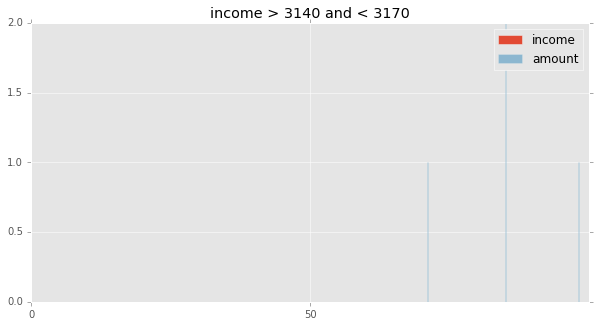



iteration 1
name 3170 to 3200
std 1065.04675308
mean 1494.26356589
median 1268.0
max_mult 1.41553947782
med_mult 0.3974921630094044
min_mult 0.00314465408805
q98 4128.52
q02 66.28
q75 2213.0
q25 600.0
iqr 1613.0
min_q -1819.5
max_q 4632.5
count of loans 138
pct of total loans 0.00598326247358


iteration 2
name 3170 to 3200
std 1065.04675308
mean 1494.26356589
median 1268.0
max_mult 1.41553947782
med_mult 0.3974921630094044
min_mult 0.00314465408805
q98 4128.52
q02 66.28
q75 2213.0
q25 600.0
iqr 1613.0
min_q -1819.5
max_q 4632.5
count of loans 138
pct of total loans 0.00598326247358


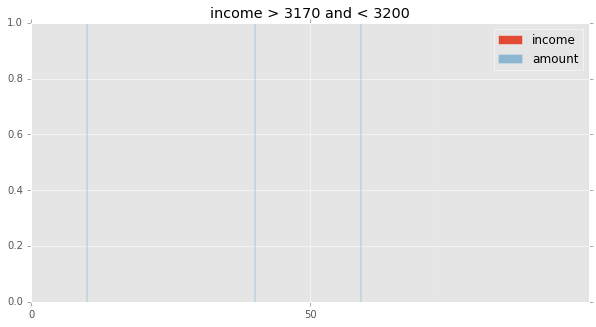



iteration 1
name 3200 to 3230
std 1058.51454192
mean 1383.96987952
median 1020.0
max_mult 1.26819448746
med_mult 0.31875
min_mult 0.0294939459795
q98 4000.0
q02 128.0
q75 1873.75
q25 531.75
iqr 1342.0
min_q -1481.25
max_q 3886.75
count of loans 176
pct of total loans 0.00763082750254


iteration 2
name 3200 to 3230
std 965.247529762
mean 1302.13664596
median 1000.0
max_mult 1.2021875
med_mult 0.3125
min_mult 0.0294939459795
q98 3732.4
q02 125.0
q75 1800.0
q25 500.0
iqr 1300.0
min_q -1450.0
max_q 3750.0
count of loans 176
pct of total loans 0.00763082750254


iteration 3
name 3200 to 3230
std 909.092773287
mean 1254.41139241
median 1000.0
max_mult 1.16666666667
med_mult 0.3125
min_mult 0.0294939459795
q98 3596.5
q02 123.2
q75 1750.0
q25 462.5
iqr 1287.5
min_q -1468.75
max_q 3681.25
count of loans 176
pct of total loans 0.00763082750254


iteration 4
name 3200 to 3230
std 870.291346285
mean 1222.75
median 1000.0
max_mult 1.136875
med_mult 0.31225624024960996
min_mult 0.0294939459795
q9

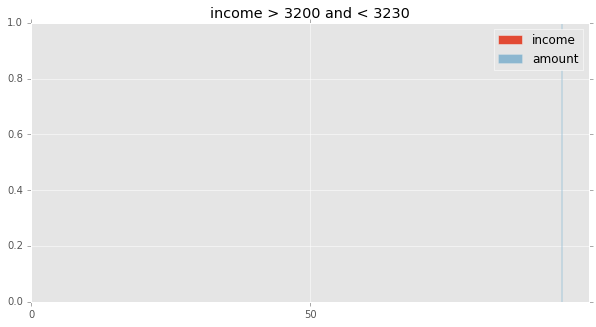



iteration 1
name 3230 to 3260
std 1310.06406132
mean 1650.86428571
median 1150.0
max_mult 1.57748221466
med_mult 0.35559203748438506
min_mult 0.00676923076923
q98 4750.4
q02 93.24
q75 2600.0
q25 513.5
iqr 2086.5
min_q -2616.25
max_q 5729.75
count of loans 142
pct of total loans 0.00615669037137


iteration 2
name 3230 to 3260
std 1310.06406132
mean 1650.86428571
median 1150.0
max_mult 1.57748221466
med_mult 0.35559203748438506
min_mult 0.00676923076923
q98 4750.4
q02 93.24
q75 2600.0
q25 513.5
iqr 2086.5
min_q -2616.25
max_q 5729.75
count of loans 142
pct of total loans 0.00615669037137


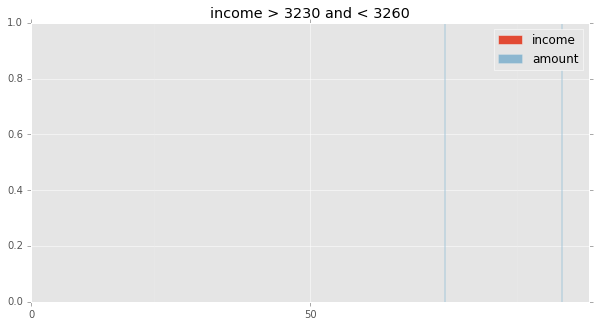



iteration 1
name 3260 to 3290
std 1138.88508443
mean 1571.58163265
median 1287.5
max_mult 1.62568807339
med_mult 0.394096285303112
min_mult 0.0183038438072
q98 4009.6
q02 143.02
q75 2327.0
q25 600.5
iqr 1726.5
min_q -1989.25
max_q 4916.75
count of loans 104
pct of total loans 0.00450912534241


iteration 2
name 3260 to 3290
std 1078.43218551
mean 1532.97938144
median 1275.0
max_mult 1.26829268293
med_mult 0.38990825688073394
min_mult 0.0183038438072
q98 3788.4
q02 141.36
q75 2300.0
q25 594.0
iqr 1706.0
min_q -1965.0
max_q 4859.0
count of loans 104
pct of total loans 0.00450912534241


iteration 3
name 3260 to 3290
std 1078.43218551
mean 1532.97938144
median 1275.0
max_mult 1.26829268293
med_mult 0.38990825688073394
min_mult 0.0183038438072
q98 3788.4
q02 141.36
q75 2300.0
q25 594.0
iqr 1706.0
min_q -1965.0
max_q 4859.0
count of loans 104
pct of total loans 0.00450912534241


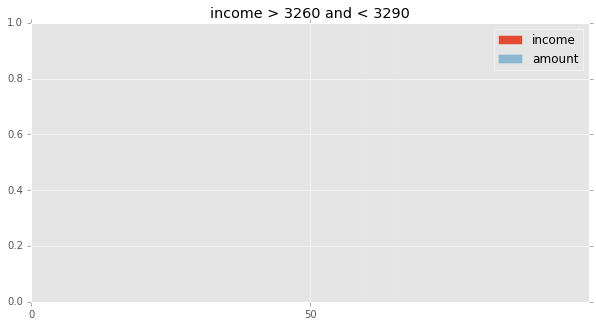



iteration 1
name 3290 to 3320
std 1308.37011213
mean 1511.47530864
median 1042.5
max_mult 1.6918429003
med_mult 0.3153134606938955
min_mult 0.0224174492578
q98 4778.0
q02 143.44
q75 2066.0
q25 500.5
iqr 1565.5
min_q -1847.75
max_q 4414.25
count of loans 176
pct of total loans 0.00763082750254


iteration 2
name 3290 to 3320
std 1062.64397597
mean 1331.16883117
median 1000.0
max_mult 1.31308836927
med_mult 0.3019326148759246
min_mult 0.0224174492578
q98 3994.0
q02 143.12
q75 1990.0
q25 451.25
iqr 1538.75
min_q -1856.875
max_q 4298.125
count of loans 176
pct of total loans 0.00763082750254


iteration 3
name 3290 to 3320
std 1037.94422472
mean 1311.60784314
median 1000.0
max_mult 1.26924237851
med_mult 0.30165912518853694
min_mult 0.0224174492578
q98 3897.6
q02 143.08
q75 1960.0
q25 450.0
iqr 1510.0
min_q -1815.0
max_q 4225.0
count of loans 176
pct of total loans 0.00763082750254


iteration 4
name 3290 to 3320
std 1037.94422472
mean 1311.60784314
median 1000.0
max_mult 1.26924237851
m

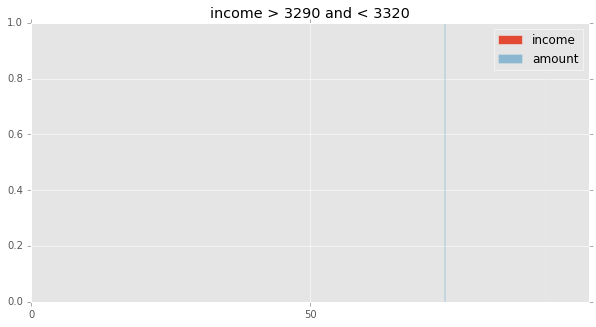



iteration 1
name 3320 to 3350
std 1154.59482423
mean 1594.256
median 1451.0
max_mult 1.49700598802
med_mult 0.43625977149729406
min_mult 0.0186298076923
q98 4356.0
q02 135.88
q75 2210.0
q25 710.0
iqr 1500.0
min_q -1540.0
max_q 4460.0
count of loans 132
pct of total loans 0.00572312062691


iteration 2
name 3320 to 3350
std 1059.7554182
mean 1518.39344262
median 1441.5
max_mult 1.2601260126
med_mult 0.4334683672500554
min_mult 0.0186298076923
q98 3847.5
q02 135.52
q75 2175.0
q25 672.5
iqr 1502.5
min_q -1581.25
max_q 4428.75
count of loans 132
pct of total loans 0.00572312062691


iteration 3
name 3320 to 3350
std 1059.7554182
mean 1518.39344262
median 1441.5
max_mult 1.2601260126
med_mult 0.4334683672500554
min_mult 0.0186298076923
q98 3847.5
q02 135.52
q75 2175.0
q25 672.5
iqr 1502.5
min_q -1581.25
max_q 4428.75
count of loans 132
pct of total loans 0.00572312062691


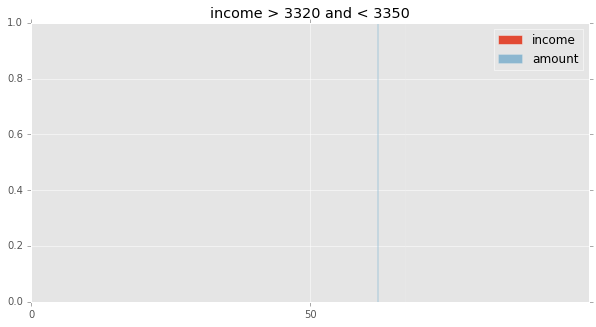



iteration 1
name 3350 to 3380
std 1151.25305482
mean 1463.14563107
median 1100.0
max_mult 1.54814814815
med_mult 0.3279666070363745
min_mult 0.0178571428571
q98 4200.0
q02 110.24
q75 2102.5
q25 587.0
iqr 1515.5
min_q -1686.25
max_q 4375.75
count of loans 114
pct of total loans 0.00494269508687


iteration 2
name 3350 to 3380
std 1094.08326766
mean 1426.26470588
median 1100.0
max_mult 1.25952380952
med_mult 0.32723649437600855
min_mult 0.0178571428571
q98 4189.16
q02 110.12
q75 2000.0
q25 580.5
iqr 1419.5
min_q -1548.75
max_q 4129.25
count of loans 114
pct of total loans 0.00494269508687


iteration 3
name 3350 to 3380
std 994.549758545
mean 1341.88888889
median 1100.0
max_mult 1.08417308832
med_mult 0.32592592592592595
min_mult 0.0178571428571
q98 3500.0
q02 109.0
q75 1897.0
q25 551.0
iqr 1346.0
min_q -1468.0
max_q 3916.0
count of loans 114
pct of total loans 0.00494269508687


iteration 4
name 3350 to 3380
std 994.549758545
mean 1341.88888889
median 1100.0
max_mult 1.08417308832
med

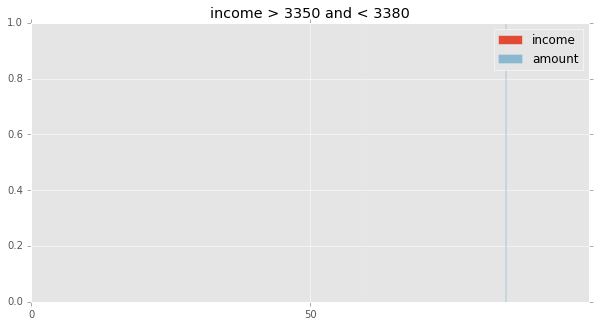



iteration 1
name 3380 to 3410
std 1390.99880157
mean 1508.42424242
median 1000.0
max_mult 1.62625665287
med_mult 0.29411764705882354
min_mult 0.0162721893491
q98 5307.0
q02 121.2
q75 2325.0
q25 417.0
iqr 1908.0
min_q -2445.0
max_q 5187.0
count of loans 138
pct of total loans 0.00598326247358


iteration 2
name 3380 to 3410
std 1180.22687488
mean 1356.0
median 975.0
max_mult 1.47885241053
med_mult 0.28846153846153844
min_mult 0.0162721893491
q98 4732.2
q02 120.2
q75 2000.0
q25 417.0
iqr 1583.0
min_q -1957.5
max_q 4374.5
count of loans 138
pct of total loans 0.00598326247358


iteration 3
name 3380 to 3410
std 1009.28317621
mean 1241.68292683
median 944.0
max_mult 1.1161690807
med_mult 0.27715795654726955
min_mult 0.0162721893491
q98 3498.24
q02 119.4
q75 1866.5
q25 417.0
iqr 1449.5
min_q -1757.25
max_q 4040.75
count of loans 138
pct of total loans 0.00598326247358


iteration 4
name 3380 to 3410
std 1009.28317621
mean 1241.68292683
median 944.0
max_mult 1.1161690807
med_mult 0.2771579

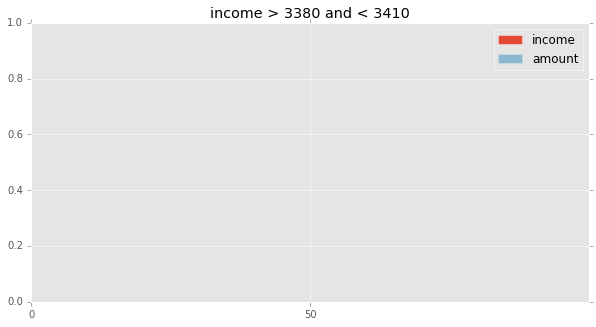



iteration 1
name 3410 to 3440
std 1284.37178803
mean 1567.95535714
median 1281.0
max_mult 1.56812865497
med_mult 0.3736804662023705
min_mult 0.0107840279802
q98 4833.86
q02 59.22
q75 2272.5
q25 492.5
iqr 1780.0
min_q -2177.5
max_q 4942.5
count of loans 121
pct of total loans 0.005246193908


iteration 2
name 3410 to 3440
std 1198.0515101
mean 1502.25454545
median 1254.0
max_mult 1.42169728784
med_mult 0.36661367439840953
min_mult 0.0107840279802
q98 4152.52
q02 59.18
q75 2230.0
q25 477.5
iqr 1752.5
min_q -2151.25
max_q 4858.75
count of loans 121
pct of total loans 0.005246193908


iteration 3
name 3410 to 3440
std 1158.58676442
mean 1471.31192661
median 1240.0
max_mult 1.37236533958
med_mult 0.36246711487869043
min_mult 0.0107840279802
q98 4000.0
q02 59.16
q75 2200.0
q25 470.0
iqr 1730.0
min_q -2125.0
max_q 4795.0
count of loans 121
pct of total loans 0.005246193908


iteration 4
name 3410 to 3440
std 1158.58676442
mean 1471.31192661
median 1240.0
max_mult 1.37236533958
med_mult 0.36

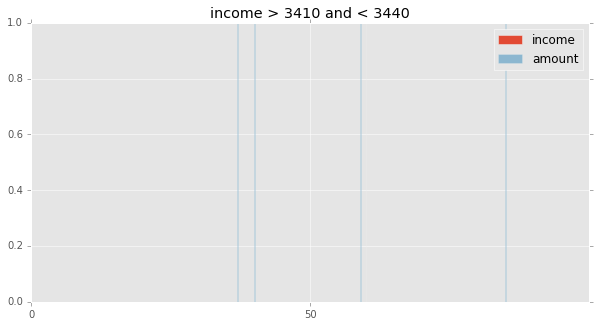



iteration 1
name 3440 to 3470
std 1374.15681824
mean 1566.2962963
median 1100.0
max_mult 1.56657963446
med_mult 0.3170942634765062
min_mult 0.0292329956585
q98 4835.0
q02 137.4
q75 2205.0
q25 417.0
iqr 1788.0
min_q -2265.0
max_q 4887.0
count of loans 86
pct of total loans 0.00372869980238


iteration 2
name 3440 to 3470
std 1260.38458065
mean 1474.30379747
median 1000.0
max_mult 1.36363636364
med_mult 0.2899391127863149
min_mult 0.0292329956585
q98 4582.72
q02 136.24
q75 2185.0
q25 417.0
iqr 1768.0
min_q -2235.0
max_q 4837.0
count of loans 86
pct of total loans 0.00372869980238


iteration 3
name 3440 to 3470
std 1260.38458065
mean 1474.30379747
median 1000.0
max_mult 1.36363636364
med_mult 0.2899391127863149
min_mult 0.0292329956585
q98 4582.72
q02 136.24
q75 2185.0
q25 417.0
iqr 1768.0
min_q -2235.0
max_q 4837.0
count of loans 86
pct of total loans 0.00372869980238


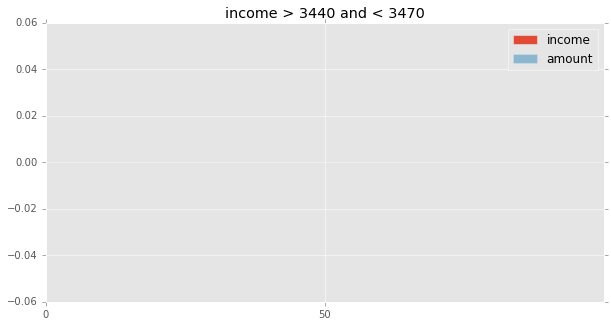



iteration 1
name 3470 to 3500
std 1141.91641102
mean 1413.60747664
median 1018.0
max_mult 1.31767401891
med_mult 0.29202524383247275
min_mult 0.0310344827586
q98 4269.16
q02 147.44
q75 1997.5
q25 464.0
iqr 1533.5
min_q -1836.25
max_q 4297.75
count of loans 115
pct of total loans 0.00498605206132


iteration 2
name 3470 to 3500
std 1065.9389601
mean 1353.86666667
median 1000.0
max_mult 1.22877697842
med_mult 0.28810141169691733
min_mult 0.0310344827586
q98 3996.8
q02 145.96
q75 1975.0
q25 454.0
iqr 1521.0
min_q -1827.5
max_q 4256.5
count of loans 115
pct of total loans 0.00498605206132


iteration 3
name 3470 to 3500
std 994.451006582
mean 1297.31067961
median 1000.0
max_mult 1.15207373272
med_mult 0.2874389192296637
min_mult 0.0310344827586
q98 3892.52
q02 144.48
q75 1870.5
q25 450.5
iqr 1420.0
min_q -1679.5
max_q 4000.5
count of loans 115
pct of total loans 0.00498605206132


iteration 4
name 3470 to 3500
std 994.451006582
mean 1297.31067961
median 1000.0
max_mult 1.15207373272
med_

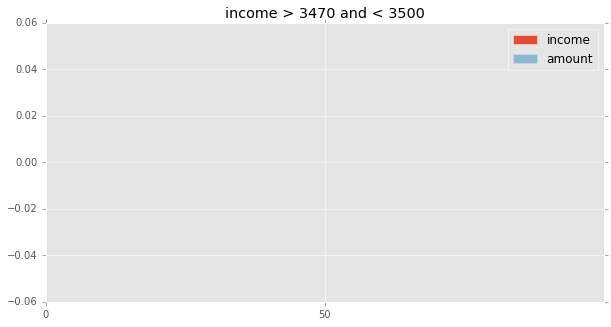



iteration 1
name 3500 to 3530
std 990.078037673
mean 1438.48044693
median 1235.0
max_mult 1.2794995735
med_mult 0.35285714285714287
min_mult 0.0214285714286
q98 3888.0
q02 116.92
q75 2000.0
q25 616.5
iqr 1383.5
min_q -1458.75
max_q 4075.25
count of loans 189
pct of total loans 0.00819446817034


iteration 2
name 3500 to 3530
std 965.681592244
mean 1421.28089888
median 1226.0
max_mult 1.14285714286
med_mult 0.3502857142857143
min_mult 0.0214285714286
q98 3675.8
q02 116.78
q75 2000.0
q25 615.25
iqr 1384.75
min_q -1461.875
max_q 4077.125
count of loans 189
pct of total loans 0.00819446817034


iteration 3
name 3500 to 3530
std 965.681592244
mean 1421.28089888
median 1226.0
max_mult 1.14285714286
med_mult 0.3502857142857143
min_mult 0.0214285714286
q98 3675.8
q02 116.78
q75 2000.0
q25 615.25
iqr 1384.75
min_q -1461.875
max_q 4077.125
count of loans 189
pct of total loans 0.00819446817034


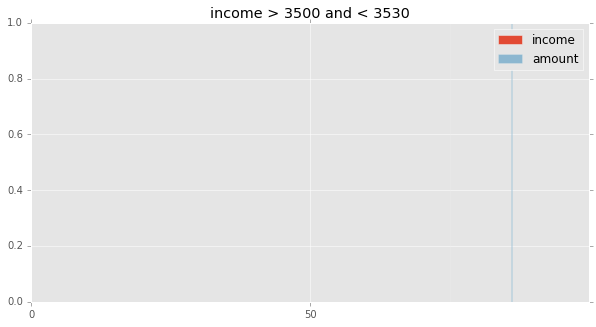



iteration 1
name 3530 to 3560
std 1336.13043986
mean 1580.03539823
median 1120.0
max_mult 1.50014072615
med_mult 0.3162948319683705
min_mult 0.0101752402487
q98 5000.0
q02 66.0
q75 2396.0
q25 452.0
iqr 1944.0
min_q -2464.0
max_q 5312.0
count of loans 119
pct of total loans 0.00515947995911


iteration 2
name 3530 to 3560
std 1293.64210932
mean 1546.55357143
median 1110.0
max_mult 1.41562853907
med_mult 0.313076993448974
min_mult 0.0101752402487
q98 4857.0
q02 65.5
q75 2369.0
q25 449.0
iqr 1920.0
min_q -2431.0
max_q 5249.0
count of loans 119
pct of total loans 0.00515947995911


iteration 3
name 3530 to 3560
std 1293.64210932
mean 1546.55357143
median 1110.0
max_mult 1.41562853907
med_mult 0.313076993448974
min_mult 0.0101752402487
q98 4857.0
q02 65.5
q75 2369.0
q25 449.0
iqr 1920.0
min_q -2431.0
max_q 5249.0
count of loans 119
pct of total loans 0.00515947995911


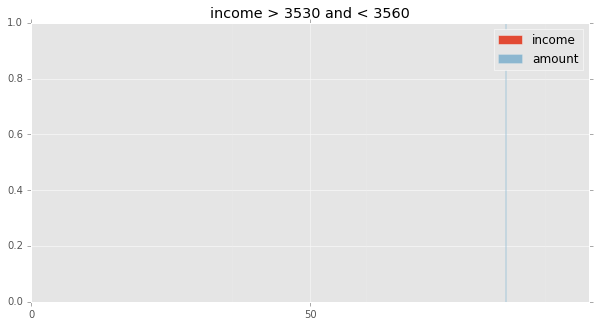



iteration 1
name 3560 to 3590
std 885.567743046
mean 1270.49367089
median 1035.0
max_mult 1.01732811627
med_mult 0.2904040404040404
min_mult 0.0280583613917
q98 3542.68
q02 144.28
q75 1725.0
q25 670.0
iqr 1055.0
min_q -912.5
max_q 3307.5
count of loans 86
pct of total loans 0.00372869980238


iteration 2
name 3560 to 3590
std 770.635907842
mean 1179.36842105
median 1000.0
max_mult 0.900699300699
med_mult 0.2796813002055507
min_mult 0.0280583613917
q98 3000.0
q02 143.5
q75 1537.0
q25 663.5
iqr 873.5
min_q -646.75
max_q 2847.25
count of loans 86
pct of total loans 0.00372869980238


iteration 3
name 3560 to 3590
std 608.202970992
mean 1048.05633803
median 1000.0
max_mult 0.697155605131
med_mult 0.27917364600781686
min_mult 0.0280583613917
q98 2348.0
q02 142.2
q75 1462.5
q25 625.0
iqr 837.5
min_q -631.25
max_q 2718.75
count of loans 86
pct of total loans 0.00372869980238


iteration 4
name 3560 to 3590
std 608.202970992
mean 1048.05633803
median 1000.0
max_mult 0.697155605131
med_mult 0

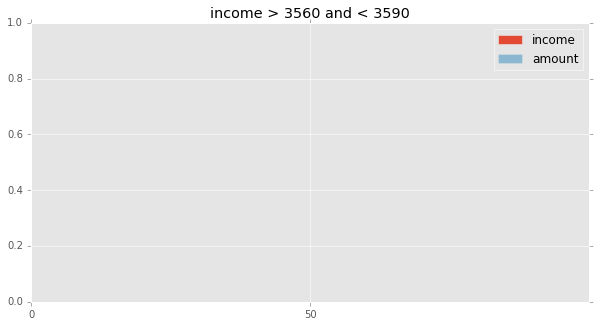



iteration 1
name 3590 to 3620
std 1274.1327306
mean 1493.76958525
median 1050.0
max_mult 1.45833333333
med_mult 0.29085872576177285
min_mult 0.0116666666667
q98 4961.6
q02 62.24
q75 2012.0
q25 496.0
iqr 1516.0
min_q -1778.0
max_q 4286.0
count of loans 227
pct of total loans 0.0098420331993


iteration 2
name 3590 to 3620
std 1061.59964857
mean 1331.8115942
median 1000.0
max_mult 1.15555555556
med_mult 0.2777777777777778
min_mult 0.0116666666667
q98 3988.0
q02 60.84
q75 2000.0
q25 432.0
iqr 1568.0
min_q -1920.0
max_q 4352.0
count of loans 227
pct of total loans 0.0098420331993


iteration 3
name 3590 to 3620
std 1061.59964857
mean 1331.8115942
median 1000.0
max_mult 1.15555555556
med_mult 0.2777777777777778
min_mult 0.0116666666667
q98 3988.0
q02 60.84
q75 2000.0
q25 432.0
iqr 1568.0
min_q -1920.0
max_q 4352.0
count of loans 227
pct of total loans 0.0098420331993


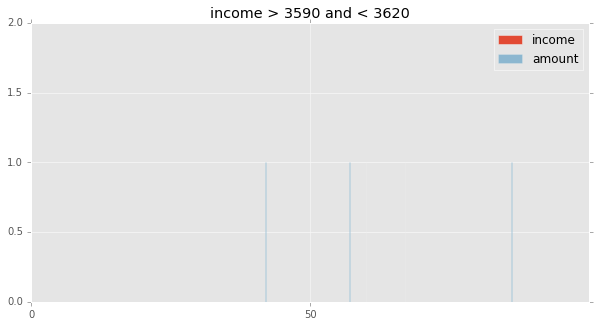



iteration 1
name 3620 to 3650
std 1295.48305525
mean 1441.34313725
median 960.0
max_mult 1.38315441784
med_mult 0.26319547669557775
min_mult 0.0192307692308
q98 4915.2
q02 136.48
q75 2152.5
q25 386.75
iqr 1765.75
min_q -2261.875
max_q 4801.125
count of loans 109
pct of total loans 0.00472591021464


iteration 2
name 3620 to 3650
std 1155.10745872
mean 1334.06060606
median 900.0
max_mult 1.28890112917
med_mult 0.2476609796367639
min_mult 0.0192307692308
q98 4227.0
q02 134.96
q75 2028.0
q25 361.5
iqr 1666.5
min_q -2138.25
max_q 4527.75
count of loans 109
pct of total loans 0.00472591021464


iteration 3
name 3620 to 3650
std 1109.70056956
mean 1299.91836735
median 900.0
max_mult 1.17219632575
med_mult 0.24721957673913875
min_mult 0.0192307692308
q98 3927.96
q02 134.44
q75 2000.0
q25 350.75
iqr 1649.25
min_q -2123.125
max_q 4473.875
count of loans 109
pct of total loans 0.00472591021464


iteration 4
name 3620 to 3650
std 1109.70056956
mean 1299.91836735
median 900.0
max_mult 1.17219632

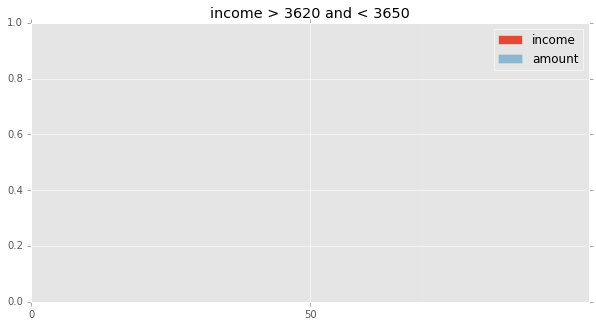



iteration 1
name 3650 to 3680
std 1260.62403288
mean 1639.51485149
median 1408.0
max_mult 1.50109170306
med_mult 0.38427947598253276
min_mult 0.0103910308996
q98 4550.0
q02 95.0
q75 2550.0
q25 560.0
iqr 1990.0
min_q -2425.0
max_q 5535.0
count of loans 106
pct of total loans 0.0045958392913


iteration 2
name 3650 to 3680
std 1260.62403288
mean 1639.51485149
median 1408.0
max_mult 1.50109170306
med_mult 0.38427947598253276
min_mult 0.0103910308996
q98 4550.0
q02 95.0
q75 2550.0
q25 560.0
iqr 1990.0
min_q -2425.0
max_q 5535.0
count of loans 106
pct of total loans 0.0045958392913


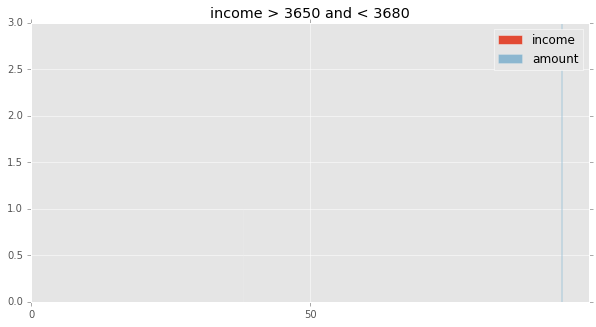



iteration 1
name 3680 to 3710
std 1212.25069001
mean 1615.54081633
median 1400.0
max_mult 1.34843581446
med_mult 0.37910028391093176
min_mult 0.0133152173913
q98 4521.6
q02 82.52
q75 2276.75
q25 707.5
iqr 1569.25
min_q -1646.375
max_q 4630.625
count of loans 103
pct of total loans 0.00446576836797


iteration 2
name 3680 to 3710
std 1124.40723092
mean 1546.48958333
median 1362.0
max_mult 1.21424716676
med_mult 0.36799544671913803
min_mult 0.0133152173913
q98 4000.0
q02 82.2
q75 2179.25
q25 675.0
iqr 1504.25
min_q -1581.375
max_q 4435.625
count of loans 103
pct of total loans 0.00446576836797


iteration 3
name 3680 to 3710
std 1088.10129769
mean 1515.4
median 1324.0
max_mult 1.08166576528
med_mult 0.3582251082251082
min_mult 0.0133152173913
q98 4000.0
q02 82.04
q75 2116.5
q25 650.0
iqr 1466.5
min_q -1549.75
max_q 4316.25
count of loans 103
pct of total loans 0.00446576836797


iteration 4
name 3680 to 3710
std 1088.10129769
mean 1515.4
median 1324.0
max_mult 1.08166576528
med_mult 0.

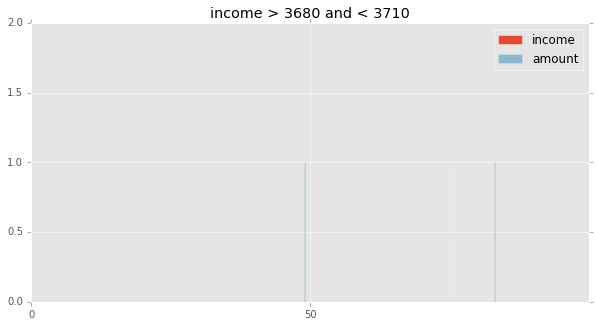



iteration 1
name 3710 to 3740
std 1554.56113598
mean 2044.88888889
median 1885.0
max_mult 1.34698275862
med_mult 0.5059313841755813
min_mult 0.0201234236651
q98 5000.0
q02 153.86
q75 3000.0
q25 580.0
iqr 2420.0
min_q -3050.0
max_q 6630.0
count of loans 77
pct of total loans 0.00333848703236


iteration 2
name 3710 to 3740
std 1554.56113598
mean 2044.88888889
median 1885.0
max_mult 1.34698275862
med_mult 0.5059313841755813
min_mult 0.0201234236651
q98 5000.0
q02 153.86
q75 3000.0
q25 580.0
iqr 2420.0
min_q -3050.0
max_q 6630.0
count of loans 77
pct of total loans 0.00333848703236


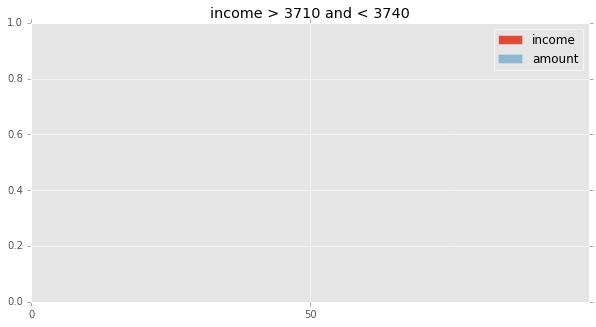



iteration 1
name 3740 to 3770
std 1185.60127843
mean 1589.65
median 1360.0
max_mult 1.24734607219
med_mult 0.3624056813138038
min_mult 0.0152040544145
q98 4550.0
q02 99.8
q75 2256.25
q25 650.0
iqr 1606.25
min_q -1759.375
max_q 4665.625
count of loans 104
pct of total loans 0.00450912534241


iteration 2
name 3740 to 3770
std 1149.03416255
mean 1558.23232323
median 1250.0
max_mult 1.21462893753
med_mult 0.3333333333333333
min_mult 0.0152040544145
q98 4358.0
q02 99.6
q75 2245.0
q25 636.0
iqr 1609.0
min_q -1777.5
max_q 4658.5
count of loans 104
pct of total loans 0.00450912534241


iteration 3
name 3740 to 3770
std 1149.03416255
mean 1558.23232323
median 1250.0
max_mult 1.21462893753
med_mult 0.3333333333333333
min_mult 0.0152040544145
q98 4358.0
q02 99.6
q75 2245.0
q25 636.0
iqr 1609.0
min_q -1777.5
max_q 4658.5
count of loans 104
pct of total loans 0.00450912534241


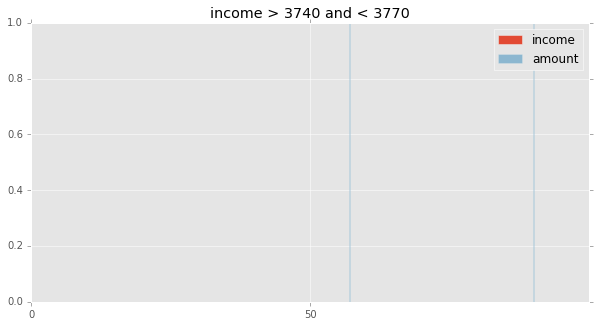



iteration 1
name 3770 to 3800
std 1352.9836328
mean 1763.87179487
median 1375.0
max_mult 1.33870967742
med_mult 0.36407198568834853
min_mult 0.0370762711864
q98 5000.0
q02 146.62
q75 2381.25
q25 779.0
iqr 1602.25
min_q -1624.375
max_q 4784.625
count of loans 80
pct of total loans 0.0034685579557


iteration 2
name 3770 to 3800
std 1152.94429693
mean 1589.44594595
median 1210.0
max_mult 1.16807610994
med_mult 0.31904915855816396
min_mult 0.0370762711864
q98 4162.0
q02 146.38
q75 2086.25
q25 756.25
iqr 1330.0
min_q -1238.75
max_q 4081.25
count of loans 80
pct of total loans 0.0034685579557


iteration 3
name 3770 to 3800
std 1069.76302487
mean 1512.48611111
median 1150.0
max_mult 1.05876124934
med_mult 0.30366018285574037
min_mult 0.0370762711864
q98 3994.64
q02 146.26
q75 2000.0
q25 722.75
iqr 1277.25
min_q -1193.125
max_q 3915.875
count of loans 80
pct of total loans 0.0034685579557


iteration 4
name 3770 to 3800
std 954.430976508
mean 1404.50724638
median 1100.0
max_mult 0.97972617

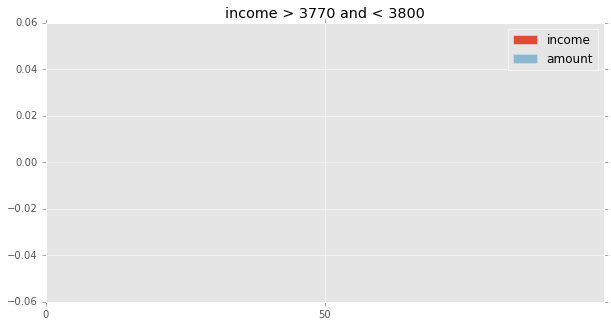



iteration 1
name 3800 to 3830
std 1495.30520315
mean 1864.63333333
median 1340.0
max_mult 1.57894736842
med_mult 0.3519486790370422
min_mult 0.0131475151196
q98 5234.46
q02 86.04
q75 2756.25
q25 747.5
iqr 2008.75
min_q -2265.625
max_q 5769.375
count of loans 92
pct of total loans 0.00398884164906


iteration 2
name 3800 to 3830
std 1436.95165222
mean 1818.16853933
median 1320.0
max_mult 1.38631578947
med_mult 0.34600262123197906
min_mult 0.0131475151196
q98 5130.0
q02 85.68
q75 2700.0
q25 730.0
iqr 1970.0
min_q -2225.0
max_q 5655.0
count of loans 92
pct of total loans 0.00398884164906


iteration 3
name 3800 to 3830
std 1436.95165222
mean 1818.16853933
median 1320.0
max_mult 1.38631578947
med_mult 0.34600262123197906
min_mult 0.0131475151196
q98 5130.0
q02 85.68
q75 2700.0
q25 730.0
iqr 1970.0
min_q -2225.0
max_q 5655.0
count of loans 92
pct of total loans 0.00398884164906


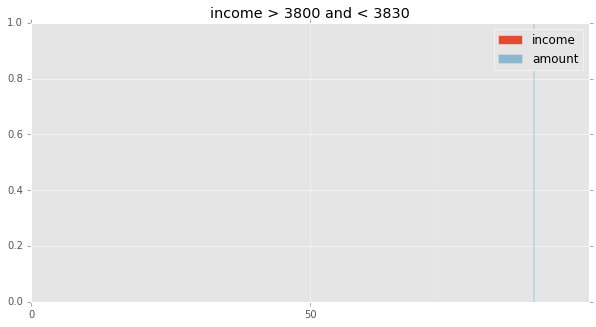



iteration 1
name 3830 to 3860
std 1261.85747294
mean 1493.93939394
median 1092.0
max_mult 1.38435550936
med_mult 0.28326848249027237
min_mult 0.00990357049778
q98 5000.0
q02 61.88
q75 2000.0
q25 500.0
iqr 1500.0
min_q -1750.0
max_q 4250.0
count of loans 105
pct of total loans 0.00455248231686


iteration 2
name 3830 to 3860
std 981.103103678
mean 1305.03191489
median 1000.0
max_mult 1.03896103896
med_mult 0.2607561929595828
min_mult 0.00990357049778
q98 3473.24
q02 61.58
q75 1865.0
q25 482.0
iqr 1383.0
min_q -1592.5
max_q 3939.5
count of loans 105
pct of total loans 0.00455248231686


iteration 3
name 3830 to 3860
std 907.209049929
mean 1246.88043478
median 1000.0
max_mult 0.880643487286
med_mult 0.2606542819930796
min_mult 0.00990357049778
q98 3136.0
q02 61.46
q75 1752.5
q25 472.0
iqr 1280.5
min_q -1448.75
max_q 3673.25
count of loans 105
pct of total loans 0.00455248231686


iteration 4
name 3830 to 3860
std 907.209049929
mean 1246.88043478
median 1000.0
max_mult 0.880643487286
med

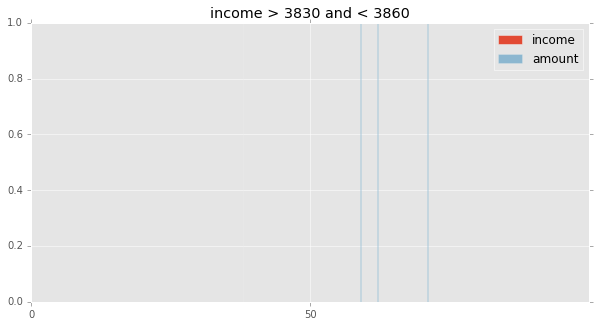



iteration 1
name 3860 to 3890
std 898.904615625
mean 1236.19230769
median 1019.0
max_mult 0.920545127282
med_mult 0.26378430596790087
min_mult 0.0282849061455
q98 3323.96
q02 121.72
q75 1697.5
q25 510.0
iqr 1187.5
min_q -1271.25
max_q 3478.75
count of loans 85
pct of total loans 0.00368534282793


iteration 2
name 3860 to 3890
std 827.209515347
mean 1175.56578947
median 1007.0
max_mult 0.821216041397
med_mult 0.26037801973401214
min_mult 0.0282849061455
q98 3037.5
q02 121.0
q75 1682.5
q25 504.75
iqr 1177.75
min_q -1261.875
max_q 3449.125
count of loans 85
pct of total loans 0.00368534282793


iteration 3
name 3860 to 3890
std 827.209515347
mean 1175.56578947
median 1007.0
max_mult 0.821216041397
med_mult 0.26037801973401214
min_mult 0.0282849061455
q98 3037.5
q02 121.0
q75 1682.5
q25 504.75
iqr 1177.75
min_q -1261.875
max_q 3449.125
count of loans 85
pct of total loans 0.00368534282793


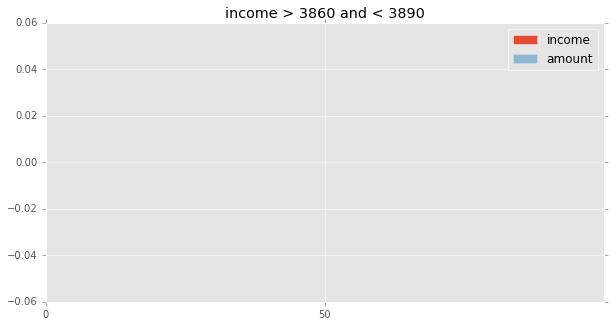



iteration 1
name 3890 to 3920
std 1039.62425957
mean 1248.97247706
median 1000.0
max_mult 1.15681233933
med_mult 0.2557544757033248
min_mult 0.00820512820513
q98 3811.76
q02 95.0
q75 1995.0
q25 380.0
iqr 1615.0
min_q -2042.5
max_q 4417.5
count of loans 118
pct of total loans 0.00511612298466


iteration 2
name 3890 to 3920
std 995.604199146
mean 1218.87037037
median 1000.0
max_mult 1.02092904543
med_mult 0.2556890987923577
min_mult 0.00820512820513
q98 3472.96
q02 95.0
q75 1965.75
q25 372.5
iqr 1593.25
min_q -2017.375
max_q 4355.625
count of loans 118
pct of total loans 0.00511612298466


iteration 3
name 3890 to 3920
std 995.604199146
mean 1218.87037037
median 1000.0
max_mult 1.02092904543
med_mult 0.2556890987923577
min_mult 0.00820512820513
q98 3472.96
q02 95.0
q75 1965.75
q25 372.5
iqr 1593.25
min_q -2017.375
max_q 4355.625
count of loans 118
pct of total loans 0.00511612298466


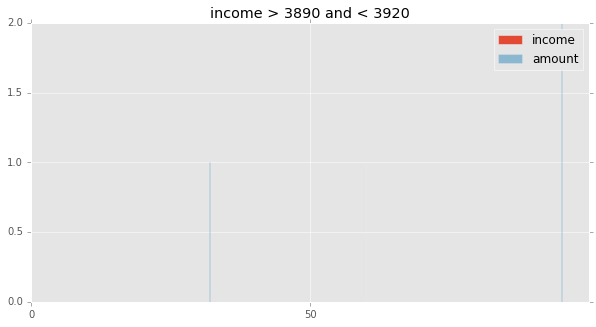



iteration 1
name 3920 to 3950
std 1027.98463864
mean 1351.6746988
median 1100.0
max_mult 1.26806999746
med_mult 0.2796847190439868
min_mult 0.0164598632565
q98 3750.0
q02 102.4
q75 2000.0
q25 592.5
iqr 1407.5
min_q -1518.75
max_q 4111.25
count of loans 90
pct of total loans 0.00390212770016


iteration 2
name 3920 to 3950
std 950.510585702
mean 1307.18292683
median 1050.0
max_mult 0.952743902439
med_mult 0.26739337993015666
min_mult 0.0164598632565
q98 3560.9
q02 102.2
q75 2000.0
q25 588.75
iqr 1411.25
min_q -1528.125
max_q 4116.875
count of loans 90
pct of total loans 0.00390212770016


iteration 3
name 3920 to 3950
std 950.510585702
mean 1307.18292683
median 1050.0
max_mult 0.952743902439
med_mult 0.26739337993015666
min_mult 0.0164598632565
q98 3560.9
q02 102.2
q75 2000.0
q25 588.75
iqr 1411.25
min_q -1528.125
max_q 4116.875
count of loans 90
pct of total loans 0.00390212770016


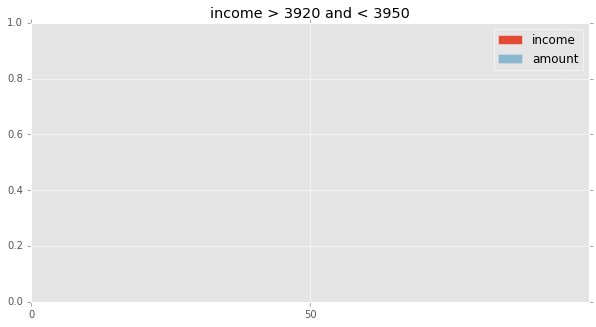



iteration 1
name 3950 to 3980
std 1142.51925134
mean 1399.25581395
median 1014.0
max_mult 1.11279333838
med_mult 0.25638025827899247
min_mult 0.0153846153846
q98 3874.7
q02 106.7
q75 1976.25
q25 476.5
iqr 1499.75
min_q -1773.125
max_q 4225.875
count of loans 90
pct of total loans 0.00390212770016


iteration 2
name 3950 to 3980
std 1100.77649917
mean 1363.83529412
median 1000.0
max_mult 1.0111223458
med_mult 0.25316455696202533
min_mult 0.0153846153846
q98 3728.52
q02 106.08
q75 1920.0
q25 468.0
iqr 1452.0
min_q -1710.0
max_q 4098.0
count of loans 90
pct of total loans 0.00390212770016


iteration 3
name 3950 to 3980
std 1100.77649917
mean 1363.83529412
median 1000.0
max_mult 1.0111223458
med_mult 0.25316455696202533
min_mult 0.0153846153846
q98 3728.52
q02 106.08
q75 1920.0
q25 468.0
iqr 1452.0
min_q -1710.0
max_q 4098.0
count of loans 90
pct of total loans 0.00390212770016


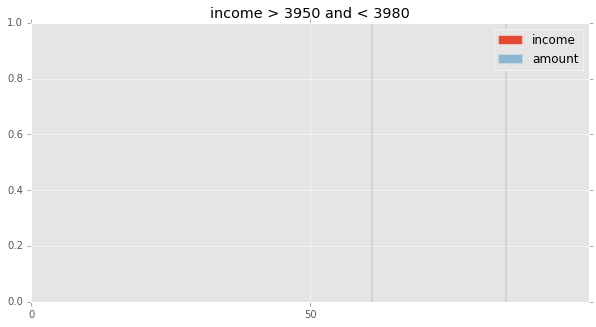



iteration 1
name 3980 to 4010
std 1377.58079428
mean 1730.78672986
median 1350.0
max_mult 1.5037593985
med_mult 0.3375
min_mult 0.02
q98 5486.6
q02 133.6
q75 2444.0
q25 589.5
iqr 1854.5
min_q -2192.25
max_q 5225.75
count of loans 220
pct of total loans 0.00953853437818


iteration 2
name 3980 to 4010
std 1232.71315721
mean 1630.80582524
median 1300.0
max_mult 1.25542529309
med_mult 0.32605977605290337
min_mult 0.02
q98 4482.0
q02 132.3
q75 2371.25
q25 584.25
iqr 1787.0
min_q -2096.25
max_q 5051.75
count of loans 220
pct of total loans 0.00953853437818


iteration 3
name 3980 to 4010
std 1232.71315721
mean 1630.80582524
median 1300.0
max_mult 1.25542529309
med_mult 0.32605977605290337
min_mult 0.02
q98 4482.0
q02 132.3
q75 2371.25
q25 584.25
iqr 1787.0
min_q -2096.25
max_q 5051.75
count of loans 220
pct of total loans 0.00953853437818


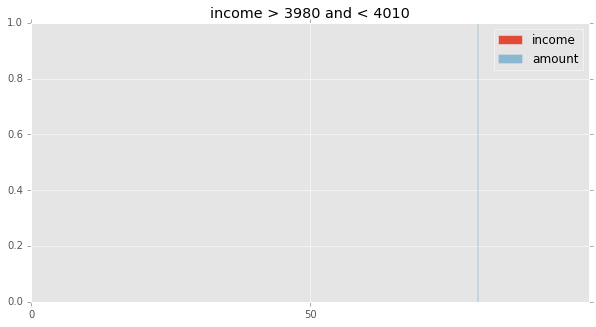



iteration 1
name 4010 to 4040
std 1532.03252858
mean 1795.81012658
median 1500.0
max_mult 1.49031296572
med_mult 0.37147102526002973
min_mult 0.0126897238119
q98 5688.0
q02 115.56
q75 2850.0
q25 490.5
iqr 2359.5
min_q -3048.75
max_q 6389.25
count of loans 82
pct of total loans 0.00355527190459


iteration 2
name 4010 to 4040
std 1532.03252858
mean 1795.81012658
median 1500.0
max_mult 1.49031296572
med_mult 0.37147102526002973
min_mult 0.0126897238119
q98 5688.0
q02 115.56
q75 2850.0
q25 490.5
iqr 2359.5
min_q -3048.75
max_q 6389.25
count of loans 82
pct of total loans 0.00355527190459


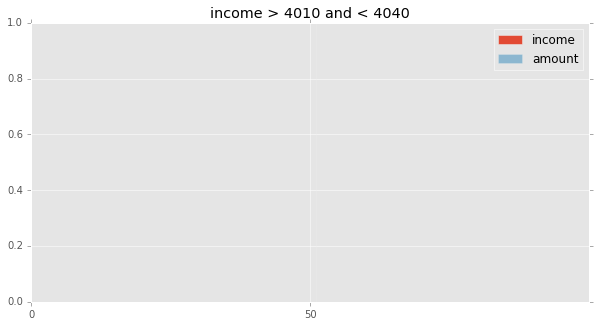



iteration 1
name 4040 to 4070
std 1155.19629388
mean 1422.87878788
median 1094.0
max_mult 1.12533925487
med_mult 0.26942513370605653
min_mult 0.0130961205831
q98 4175.5
q02 74.8
q75 1996.25
q25 455.25
iqr 1541.0
min_q -1856.25
max_q 4307.75
count of loans 72
pct of total loans 0.00312170216013


iteration 2
name 4040 to 4070
std 1095.02990541
mean 1374.6
median 1088.0
max_mult 1.03910477127
med_mult 0.26791430682098005
min_mult 0.0130961205831
q98 3978.52
q02 74.08
q75 1985.0
q25 417.0
iqr 1568.0
min_q -1935.0
max_q 4337.0
count of loans 72
pct of total loans 0.00312170216013


iteration 3
name 4040 to 4070
std 1095.02990541
mean 1374.6
median 1088.0
max_mult 1.03910477127
med_mult 0.26791430682098005
min_mult 0.0130961205831
q98 3978.52
q02 74.08
q75 1985.0
q25 417.0
iqr 1568.0
min_q -1935.0
max_q 4337.0
count of loans 72
pct of total loans 0.00312170216013


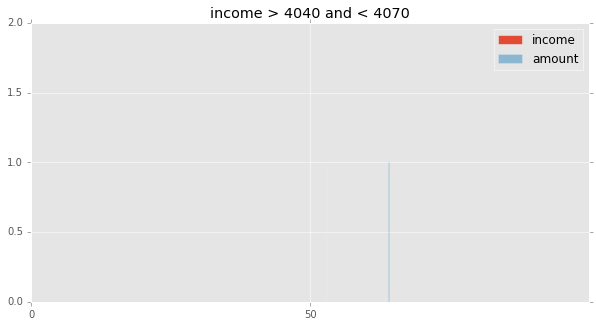



iteration 1
name 4070 to 4100
std 911.837000819
mean 1349.40384615
median 1040.0
max_mult 0.918476934342
med_mult 0.25520306402659343
min_mult 0.0440097799511
q98 3692.96
q02 184.24
q75 2000.0
q25 625.5
iqr 1374.5
min_q -1436.25
max_q 4061.75
count of loans 59
pct of total loans 0.00255806149233


iteration 2
name 4070 to 4100
std 911.837000819
mean 1349.40384615
median 1040.0
max_mult 0.918476934342
med_mult 0.25520306402659343
min_mult 0.0440097799511
q98 3692.96
q02 184.24
q75 2000.0
q25 625.5
iqr 1374.5
min_q -1436.25
max_q 4061.75
count of loans 59
pct of total loans 0.00255806149233


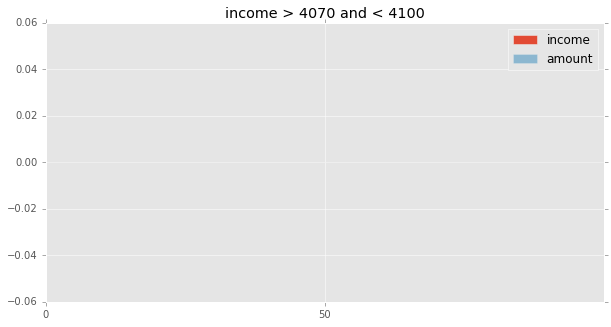



iteration 1
name 4100 to 4130
std 1587.91506493
mean 1900.91428571
median 1394.0
max_mult 1.52063106796
med_mult 0.33855338298925775
min_mult 0.010487804878
q98 5760.6
q02 118.28
q75 2920.25
q25 693.75
iqr 2226.5
min_q -2646.0
max_q 6260.0
count of loans 73
pct of total loans 0.00316505913458


iteration 2
name 4100 to 4130
std 1508.11755146
mean 1837.66666667
median 1388.0
max_mult 1.45772594752
med_mult 0.33779508396203456
min_mult 0.010487804878
q98 5236.8
q02 118.16
q75 2831.0
q25 675.0
iqr 2156.0
min_q -2559.0
max_q 6065.0
count of loans 73
pct of total loans 0.00316505913458


iteration 3
name 4100 to 4130
std 1508.11755146
mean 1837.66666667
median 1388.0
max_mult 1.45772594752
med_mult 0.33779508396203456
min_mult 0.010487804878
q98 5236.8
q02 118.16
q75 2831.0
q25 675.0
iqr 2156.0
min_q -2559.0
max_q 6065.0
count of loans 73
pct of total loans 0.00316505913458


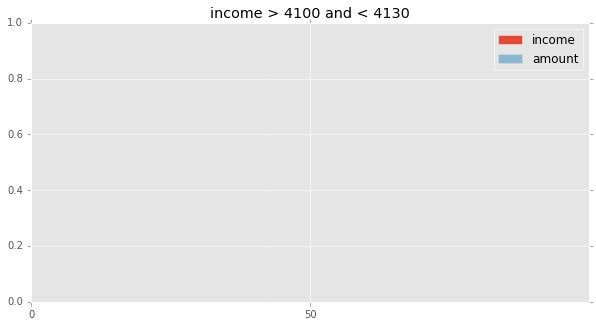



iteration 1
name 4130 to 4160
std 1123.8769803
mean 1686.10294118
median 1428.0
max_mult 1.20598166908
med_mult 0.3448867050013591
min_mult 0.0204868643047
q98 4066.0
q02 97.38
q75 2500.0
q25 898.0
iqr 1602.0
min_q -1505.0
max_q 4903.0
count of loans 71
pct of total loans 0.00307834518568


iteration 2
name 4130 to 4160
std 1055.15934028
mean 1636.64179104
median 1400.0
max_mult 0.991295938104
med_mult 0.33808258874667957
min_mult 0.0204868643047
q98 3872.0
q02 97.24
q75 2480.0
q25 876.0
iqr 1604.0
min_q -1530.0
max_q 4886.0
count of loans 71
pct of total loans 0.00307834518568


iteration 3
name 4130 to 4160
std 1055.15934028
mean 1636.64179104
median 1400.0
max_mult 0.991295938104
med_mult 0.33808258874667957
min_mult 0.0204868643047
q98 3872.0
q02 97.24
q75 2480.0
q25 876.0
iqr 1604.0
min_q -1530.0
max_q 4886.0
count of loans 71
pct of total loans 0.00307834518568


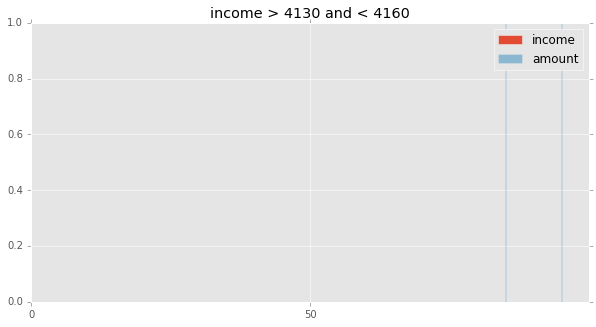



iteration 1
name 4160 to 4190
std 1292.95583402
mean 1386.0
median 1000.0
max_mult 1.20048019208
med_mult 0.23963580869907272
min_mult 0.0213942307692
q98 4748.0
q02 117.48
q75 2000.0
q25 347.5
iqr 1652.5
min_q -2131.25
max_q 4478.75
count of loans 75
pct of total loans 0.00325177308347


iteration 2
name 4160 to 4190
std 1153.60076089
mean 1282.74285714
median 1000.0
max_mult 1.05237981344
med_mult 0.23943496444162896
min_mult 0.0213942307692
q98 4122.32
q02 115.72
q75 2000.0
q25 338.5
iqr 1661.5
min_q -2153.75
max_q 4492.25
count of loans 75
pct of total loans 0.00325177308347


iteration 3
name 4160 to 4190
std 1153.60076089
mean 1282.74285714
median 1000.0
max_mult 1.05237981344
med_mult 0.23943496444162896
min_mult 0.0213942307692
q98 4122.32
q02 115.72
q75 2000.0
q25 338.5
iqr 1661.5
min_q -2153.75
max_q 4492.25
count of loans 75
pct of total loans 0.00325177308347


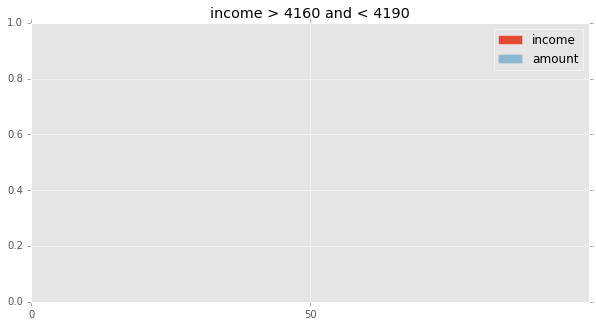



iteration 1
name 4190 to 4220
std 1310.94203111
mean 1609.36607143
median 1300.0
max_mult 1.30785714286
med_mult 0.3095592488007349
min_mult 0.0356463878327
q98 5000.0
q02 190.88
q75 2242.5
q25 584.0
iqr 1658.5
min_q -1903.75
max_q 4730.25
count of loans 122
pct of total loans 0.00528955088244


iteration 2
name 4190 to 4220
std 1141.24096527
mean 1479.22222222
median 1217.0
max_mult 1.12380952381
med_mult 0.2897619047619048
min_mult 0.0356463878327
q98 4498.9
q02 190.56
q75 2104.75
q25 557.25
iqr 1547.5
min_q -1764.0
max_q 4426.0
count of loans 122
pct of total loans 0.00528955088244


iteration 3
name 4190 to 4220
std 1024.20912507
mean 1389.77142857
median 1189.0
max_mult 0.994297933001
med_mult 0.2830952380952381
min_mult 0.0356463878327
q98 3647.2
q02 190.32
q75 2000.0
q25 540.0
iqr 1460.0
min_q -1650.0
max_q 4190.0
count of loans 122
pct of total loans 0.00528955088244


iteration 4
name 4190 to 4220
std 1024.20912507
mean 1389.77142857
median 1189.0
max_mult 0.994297933001
med

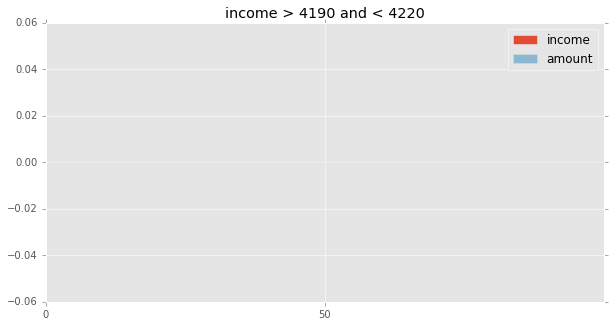



iteration 1
name 4220 to 4250
std 1002.67750354
mean 1268.77777778
median 1000.0
max_mult 0.930089749646
med_mult 0.23607197631700966
min_mult 0.0282952133931
q98 3493.4
q02 136.5
q75 1932.5
q25 503.0
iqr 1429.5
min_q -1641.25
max_q 4076.75
count of loans 60
pct of total loans 0.00260141846678


iteration 2
name 4220 to 4250
std 1002.67750354
mean 1268.77777778
median 1000.0
max_mult 0.930089749646
med_mult 0.23607197631700966
min_mult 0.0282952133931
q98 3493.4
q02 136.5
q75 1932.5
q25 503.0
iqr 1429.5
min_q -1641.25
max_q 4076.75
count of loans 60
pct of total loans 0.00260141846678


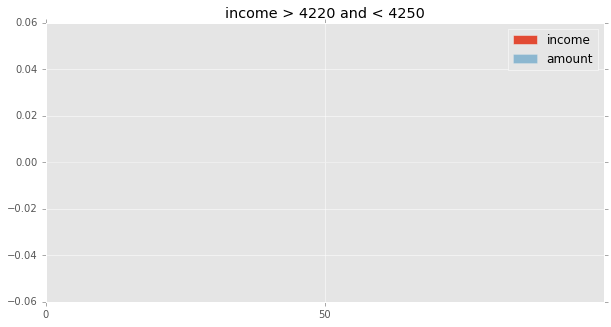



iteration 1
name 4250 to 4280
std 1279.88862797
mean 1652.0
median 1100.0
max_mult 1.17013807629
med_mult 0.25821596244131456
min_mult 0.0411184210526
q98 4554.4
q02 290.4
q75 2000.0
q25 672.0
iqr 1328.0
min_q -1320.0
max_q 3992.0
count of loans 64
pct of total loans 0.00277484636456


iteration 2
name 4250 to 4280
std 1003.09496838
mean 1403.10714286
median 1015.5
max_mult 0.933161350844
med_mult 0.23894117647058824
min_mult 0.0411184210526
q98 3682.0
q02 289.2
q75 2000.0
q25 617.0
iqr 1383.0
min_q -1457.5
max_q 4074.5
count of loans 64
pct of total loans 0.00277484636456


iteration 3
name 4250 to 4280
std 1003.09496838
mean 1403.10714286
median 1015.5
max_mult 0.933161350844
med_mult 0.23894117647058824
min_mult 0.0411184210526
q98 3682.0
q02 289.2
q75 2000.0
q25 617.0
iqr 1383.0
min_q -1457.5
max_q 4074.5
count of loans 64
pct of total loans 0.00277484636456


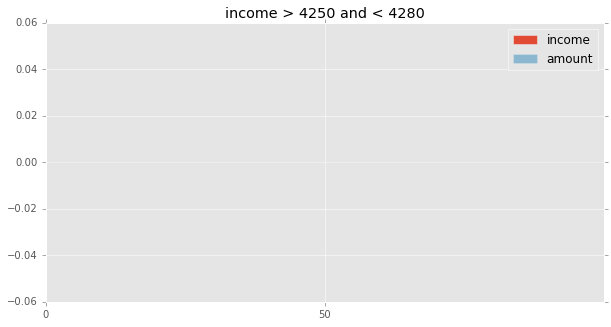



iteration 1
name 4280 to 4310
std 1205.50963261
mean 1463.24561404
median 1100.0
max_mult 1.06545961003
med_mult 0.2558139534883721
min_mult 0.0220930232558
q98 4544.0
q02 150.24
q75 2000.0
q25 580.0
iqr 1420.0
min_q -1550.0
max_q 4130.0
count of loans 62
pct of total loans 0.00268813241567


iteration 2
name 4280 to 4310
std 905.695033769
mean 1237.0754717
median 1000.0
max_mult 0.933488914819
med_mult 0.233590282644242
min_mult 0.0220930232558
q98 3322.6
q02 150.08
q75 1800.0
q25 550.0
iqr 1250.0
min_q -1325.0
max_q 3675.0
count of loans 62
pct of total loans 0.00268813241567


iteration 3
name 4280 to 4310
std 826.926589754
mean 1183.94230769
median 1000.0
max_mult 0.776484284051
med_mult 0.23356300680553999
min_mult 0.0220930232558
q98 3021.5
q02 150.04
q75 1770.0
q25 532.5
iqr 1237.5
min_q -1323.75
max_q 3626.25
count of loans 62
pct of total loans 0.00268813241567


iteration 4
name 4280 to 4310
std 826.926589754
mean 1183.94230769
median 1000.0
max_mult 0.776484284051
med_mult

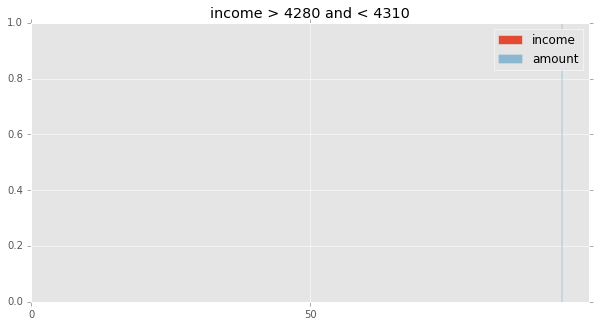



iteration 1
name 4310 to 4340
std 1433.34670062
mean 1684.95833333
median 1000.0
max_mult 1.16523952789
med_mult 0.23169612677192378
min_mult 0.0293981481481
q98 5002.1
q02 139.22
q75 3000.0
q25 594.5
iqr 2405.5
min_q -3013.75
max_q 6608.25
count of loans 50
pct of total loans 0.00216784872231


iteration 2
name 4310 to 4340
std 1433.34670062
mean 1684.95833333
median 1000.0
max_mult 1.16523952789
med_mult 0.23169612677192378
min_mult 0.0293981481481
q98 5002.1
q02 139.22
q75 3000.0
q25 594.5
iqr 2405.5
min_q -3013.75
max_q 6608.25
count of loans 50
pct of total loans 0.00216784872231


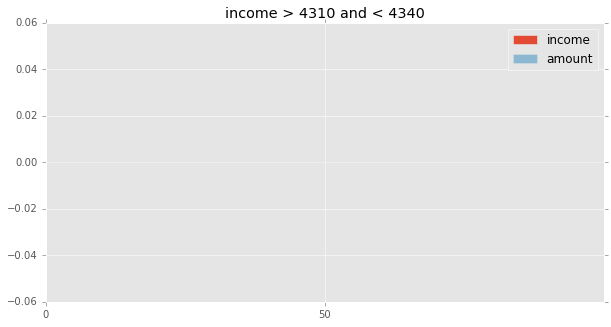



iteration 1
name 4340 to 4370
std 1341.34254636
mean 1505.66666667
median 1068.0
max_mult 1.14889705882
med_mult 0.24551724137931036
min_mult 0.0103211009174
q98 4445.0
q02 75.0
q75 2127.5
q25 431.0
iqr 1696.5
min_q -2113.75
max_q 4672.25
count of loans 52
pct of total loans 0.00225456267121


iteration 2
name 4340 to 4370
std 1257.67374002
mean 1435.78
median 1034.0
max_mult 1.02019738352
med_mult 0.23764832657200813
min_mult 0.0103211009174
q98 4400.9
q02 74.4
q75 1980.0
q25 424.0
iqr 1556.0
min_q -1910.0
max_q 4314.0
count of loans 52
pct of total loans 0.00225456267121


iteration 3
name 4340 to 4370
std 1119.65076875
mean 1311.33333333
median 1000.0
max_mult 0.935313075506
med_mult 0.22962123410630886
min_mult 0.0103211009174
q98 4003.78
q02 73.2
q75 1807.5
q25 402.75
iqr 1404.75
min_q -1704.375
max_q 3914.625
count of loans 52
pct of total loans 0.00225456267121


iteration 4
name 4340 to 4370
std 982.921075212
mean 1193.06521739
median 1000.0
max_mult 0.790804597701
med_mult 0

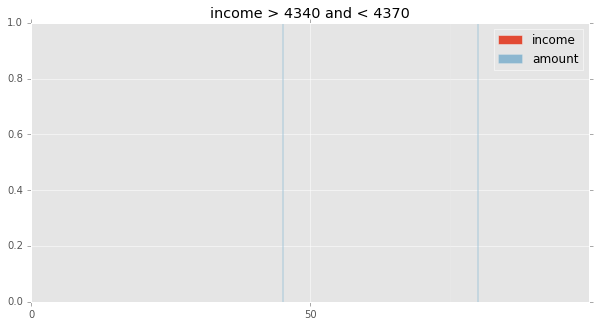



iteration 1
name 4370 to 4400
std 1867.37307392
mean 2360.86538462
median 1878.0
max_mult 1.59780871947
med_mult 0.4283029486175155
min_mult 0.0278602420644
q98 6476.0
q02 143.34
q75 3876.25
q25 850.0
iqr 3026.25
min_q -3689.375
max_q 8415.625
count of loans 53
pct of total loans 0.00229791964565


iteration 2
name 4370 to 4400
std 1867.37307392
mean 2360.86538462
median 1878.0
max_mult 1.59780871947
med_mult 0.4283029486175155
min_mult 0.0278602420644
q98 6476.0
q02 143.34
q75 3876.25
q25 850.0
iqr 3026.25
min_q -3689.375
max_q 8415.625
count of loans 53
pct of total loans 0.00229791964565


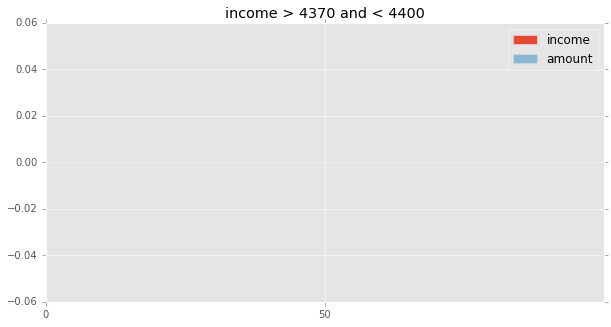



iteration 1
name 4400 to 4430
std 1719.32671163
mean 1855.62711864
median 1208.0
max_mult 1.43181818182
med_mult 0.2738608025391068
min_mult 0.00993676603433
q98 5992.0
q02 68.8
q75 2750.0
q25 582.0
iqr 2168.0
min_q -2670.0
max_q 6002.0
count of loans 60
pct of total loans 0.00260141846678


iteration 2
name 4400 to 4430
std 1629.55101986
mean 1779.0
median 1204.0
max_mult 1.36054421769
med_mult 0.2732940376331897
min_mult 0.00993676603433
q98 5950.0
q02 67.7
q75 2494.0
q25 558.5
iqr 1935.5
min_q -2344.75
max_q 5397.25
count of loans 60
pct of total loans 0.00260141846678


iteration 3
name 4400 to 4430
std 1332.49238329
mean 1550.58181818
median 1100.0
max_mult 1.13122171946
med_mult 0.2499431947284708
min_mult 0.00993676603433
q98 4988.88
q02 64.4
q75 2386.5
q25 533.5
iqr 1853.0
min_q -2246.0
max_q 5166.0
count of loans 60
pct of total loans 0.00260141846678


iteration 4
name 4400 to 4430
std 1332.49238329
mean 1550.58181818
median 1100.0
max_mult 1.13122171946
med_mult 0.24994319

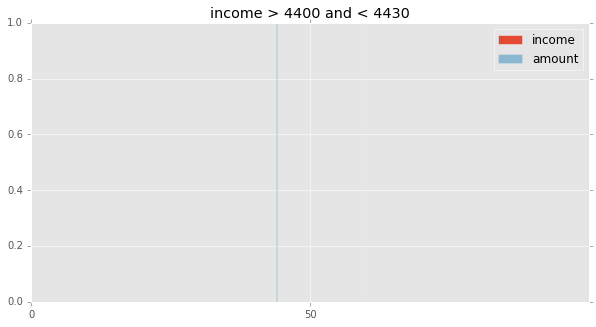



iteration 1
name 4430 to 4460
std 1341.82194955
mean 1627.31481481
median 1090.0
max_mult 1.19074365311
med_mult 0.24486009832736894
min_mult 0.00878576255913
q98 5063.1
q02 150.54
q75 2157.5
q25 704.25
iqr 1453.25
min_q -1475.625
max_q 4337.375
count of loans 57
pct of total loans 0.00247134754344


iteration 2
name 4430 to 4460
std 1021.1540858
mean 1372.92
median 1014.0
max_mult 0.892456219129
med_mult 0.22798709372519294
min_mult 0.00878576255913
q98 3798.6
q02 147.78
q75 1977.75
q25 643.0
iqr 1334.75
min_q -1359.125
max_q 3979.875
count of loans 57
pct of total loans 0.00247134754344


iteration 3
name 4430 to 4460
std 1021.1540858
mean 1372.92
median 1014.0
max_mult 0.892456219129
med_mult 0.22798709372519294
min_mult 0.00878576255913
q98 3798.6
q02 147.78
q75 1977.75
q25 643.0
iqr 1334.75
min_q -1359.125
max_q 3979.875
count of loans 57
pct of total loans 0.00247134754344


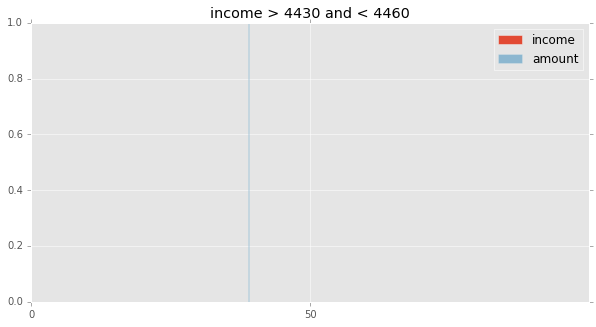



iteration 1
name 4460 to 4490
std 1311.41392583
mean 1290.12121212
median 720.0
max_mult 1.08914209115
med_mult 0.16089385474860335
min_mult 0.0247381323824
q98 4775.8
q02 183.96
q75 1800.0
q25 325.0
iqr 1475.0
min_q -1887.5
max_q 4012.5
count of loans 37
pct of total loans 0.00160420805451


iteration 2
name 4460 to 4490
std 980.324201367
mean 1063.83870968
median 600.0
max_mult 0.864695340502
med_mult 0.13377926421404682
min_mult 0.0247381323824
q98 3524.0
q02 179.4
q75 1650.0
q25 318.5
iqr 1331.5
min_q -1678.75
max_q 3647.25
count of loans 37
pct of total loans 0.00160420805451


iteration 3
name 4460 to 4490
std 845.92187963
mean 970.633333333
median 568.5
max_mult 0.736114209235
med_mult 0.127077930694784
min_mult 0.0247381323824
q98 2836.0
q02 177.12
q75 1450.0
q25 315.25
iqr 1134.75
min_q -1386.875
max_q 3152.125
count of loans 37
pct of total loans 0.00160420805451


iteration 4
name 4460 to 4490
std 735.305578045
mean 890.310344828
median 537.0
max_mult 0.560035842294
med_mu

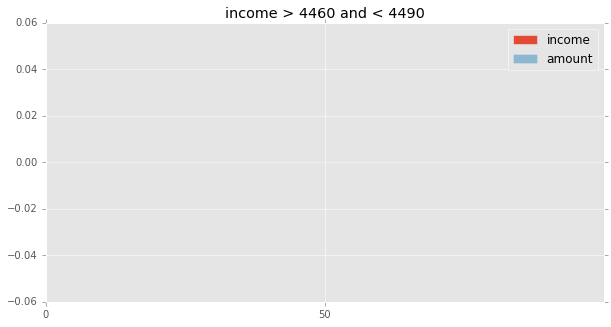



iteration 1
name 4490 to 4520
std 1021.65906529
mean 1432.10784314
median 1070.0
max_mult 1.01624749611
med_mult 0.23777777777777775
min_mult 0.0166666666667
q98 4000.0
q02 115.36
q75 2095.0
q25 650.5
iqr 1444.5
min_q -1516.25
max_q 4261.75
count of loans 108
pct of total loans 0.0046825532402


iteration 2
name 4490 to 4520
std 977.261435678
mean 1401.07920792
median 1040.0
max_mult 0.945494994438
med_mult 0.2311111111111111
min_mult 0.0166666666667
q98 4000.0
q02 115.0
q75 2080.0
q25 650.0
iqr 1430.0
min_q -1495.0
max_q 4225.0
count of loans 108
pct of total loans 0.0046825532402


iteration 3
name 4490 to 4520
std 939.086587105
mean 1372.59
median 1020.0
max_mult 0.888888888889
med_mult 0.22669136351287938
min_mult 0.0166666666667
q98 3725.6
q02 114.7
q75 2068.75
q25 645.0
iqr 1423.75
min_q -1490.625
max_q 4204.375
count of loans 108
pct of total loans 0.0046825532402


iteration 4
name 4490 to 4520
std 939.086587105
mean 1372.59
median 1020.0
max_mult 0.888888888889
med_mult 0.22

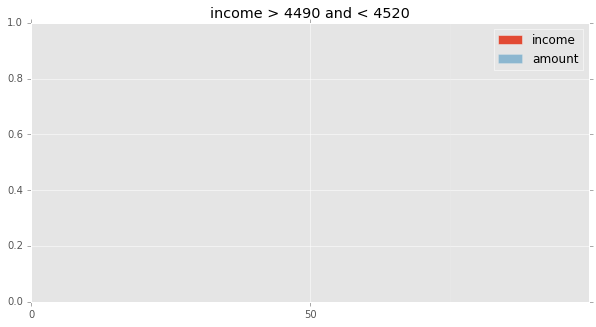



iteration 1
name 4520 to 4550
std 1772.33354832
mean 2218.60714286
median 1760.0
max_mult 1.32655317267
med_mult 0.3885277377100308
min_mult 0.0378151260504
q98 5987.2
q02 174.4
q75 3447.5
q25 799.5
iqr 2648.0
min_q -3172.5
max_q 7419.5
count of loans 58
pct of total loans 0.00251470451788


iteration 2
name 4520 to 4550
std 1772.33354832
mean 2218.60714286
median 1760.0
max_mult 1.32655317267
med_mult 0.3885277377100308
min_mult 0.0378151260504
q98 5987.2
q02 174.4
q75 3447.5
q25 799.5
iqr 2648.0
min_q -3172.5
max_q 7419.5
count of loans 58
pct of total loans 0.00251470451788


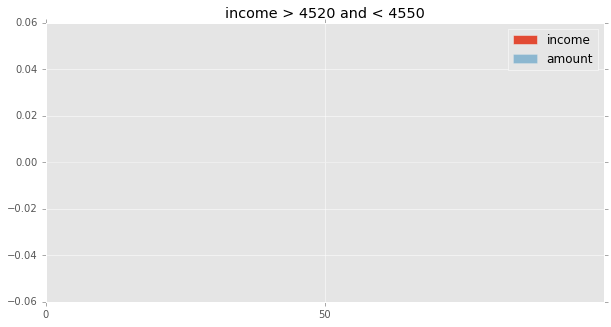



iteration 1
name 4550 to 4580
std 626.419078463
mean 1136.16216216
median 1040.0
max_mult 0.531612338657
med_mult 0.22772060433544997
min_mult 0.0153374233129
q98 2354.4
q02 107.44
q75 1560.0
q25 592.0
iqr 968.0
min_q -860.0
max_q 3012.0
count of loans 46
pct of total loans 0.00199442082453


iteration 2
name 4550 to 4580
std 626.419078463
mean 1136.16216216
median 1040.0
max_mult 0.531612338657
med_mult 0.22772060433544997
min_mult 0.0153374233129
q98 2354.4
q02 107.44
q75 1560.0
q25 592.0
iqr 968.0
min_q -860.0
max_q 3012.0
count of loans 46
pct of total loans 0.00199442082453


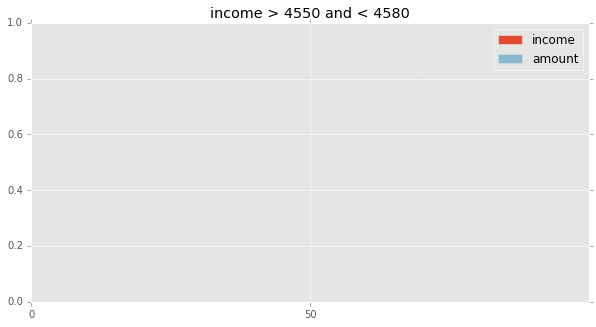



iteration 1
name 4580 to 4610
std 1190.67223098
mean 1606.43636364
median 1393.0
max_mult 1.08695652174
med_mult 0.30282608695652175
min_mult 0.0156317846287
q98 4776.32
q02 100.4
q75 2000.0
q25 774.5
iqr 1225.5
min_q -1063.75
max_q 3838.25
count of loans 63
pct of total loans 0.00273148939011


iteration 2
name 4580 to 4610
std 868.174966101
mean 1372.70588235
median 1300.0
max_mult 0.713508810094
med_mult 0.28328611898017
min_mult 0.0156317846287
q98 3240.0
q02 100.0
q75 1831.5
q25 746.0
iqr 1085.5
min_q -882.25
max_q 3459.75
count of loans 63
pct of total loans 0.00273148939011


iteration 3
name 4580 to 4610
std 868.174966101
mean 1372.70588235
median 1300.0
max_mult 0.713508810094
med_mult 0.28328611898017
min_mult 0.0156317846287
q98 3240.0
q02 100.0
q75 1831.5
q25 746.0
iqr 1085.5
min_q -882.25
max_q 3459.75
count of loans 63
pct of total loans 0.00273148939011


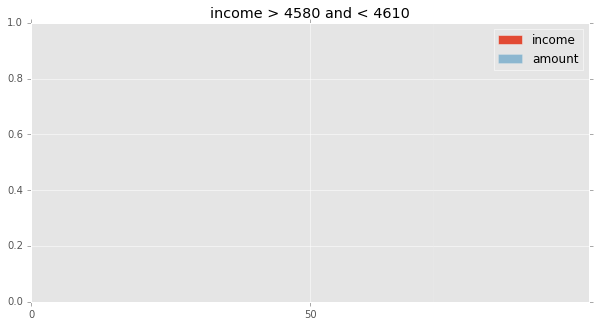



iteration 1
name 4610 to 4640
std 1293.86853258
mean 1643.01960784
median 1100.0
max_mult 1.08084738435
med_mult 0.23850823937554205
min_mult 0.0227518959913
q98 4500.0
q02 118.0
q75 2295.0
q25 687.5
iqr 1607.5
min_q -1723.75
max_q 4706.25
count of loans 54
pct of total loans 0.0023412766201


iteration 2
name 4610 to 4640
std 1213.95025013
mean 1575.88
median 1100.0
max_mult 0.970245795602
med_mult 0.23817303860668995
min_mult 0.0227518959913
q98 4304.0
q02 117.74
q75 2220.0
q25 681.25
iqr 1538.75
min_q -1626.875
max_q 4528.125
count of loans 54
pct of total loans 0.0023412766201


iteration 3
name 4610 to 4640
std 1213.95025013
mean 1575.88
median 1100.0
max_mult 0.970245795602
med_mult 0.23817303860668995
min_mult 0.0227518959913
q98 4304.0
q02 117.74
q75 2220.0
q25 681.25
iqr 1538.75
min_q -1626.875
max_q 4528.125
count of loans 54
pct of total loans 0.0023412766201


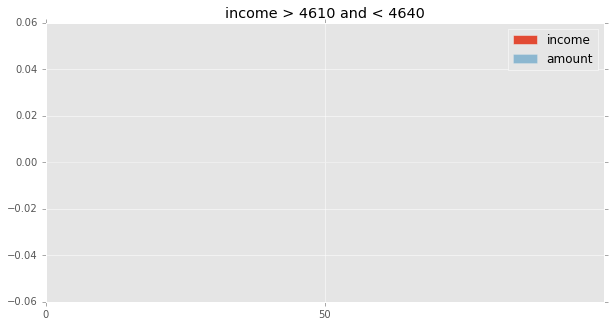



iteration 1
name 4640 to 4670
std 1726.32374983
mean 2111.59090909
median 1438.0
max_mult 1.4652014652
med_mult 0.30857525360465665
min_mult 0.0107388316151
q98 5682.0
q02 68.06
q75 3125.0
q25 742.5
iqr 2382.5
min_q -2831.25
max_q 6698.75
count of loans 45
pct of total loans 0.00195106385008


iteration 2
name 4640 to 4670
std 1586.0700054
mean 2002.55813953
median 1376.0
max_mult 1.18355928556
med_mult 0.2954691861713549
min_mult 0.0107388316151
q98 5412.64
q02 67.64
q75 3000.0
q25 735.0
iqr 2265.0
min_q -2662.5
max_q 6397.5
count of loans 45
pct of total loans 0.00195106385008


iteration 3
name 4640 to 4670
std 1586.0700054
mean 2002.55813953
median 1376.0
max_mult 1.18355928556
med_mult 0.2954691861713549
min_mult 0.0107388316151
q98 5412.64
q02 67.64
q75 3000.0
q25 735.0
iqr 2265.0
min_q -2662.5
max_q 6397.5
count of loans 45
pct of total loans 0.00195106385008


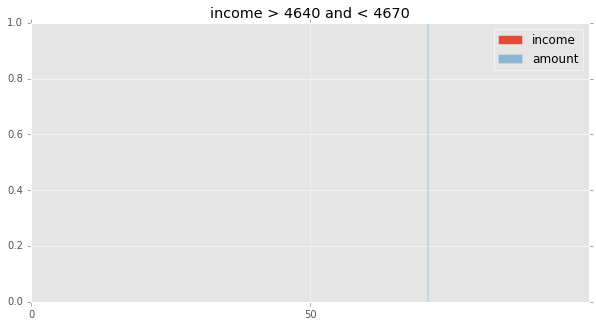



iteration 1
name 4670 to 4700
std 807.28857953
mean 1226.47368421
median 1075.0
max_mult 0.746905676483
med_mult 0.2296289908397532
min_mult 0.0192307692308
q98 2725.22
q02 112.2
q75 1868.75
q25 570.0
iqr 1298.75
min_q -1378.125
max_q 3816.875
count of loans 44
pct of total loans 0.00190770687564


iteration 2
name 4670 to 4700
std 807.28857953
mean 1226.47368421
median 1075.0
max_mult 0.746905676483
med_mult 0.2296289908397532
min_mult 0.0192307692308
q98 2725.22
q02 112.2
q75 1868.75
q25 570.0
iqr 1298.75
min_q -1378.125
max_q 3816.875
count of loans 44
pct of total loans 0.00190770687564


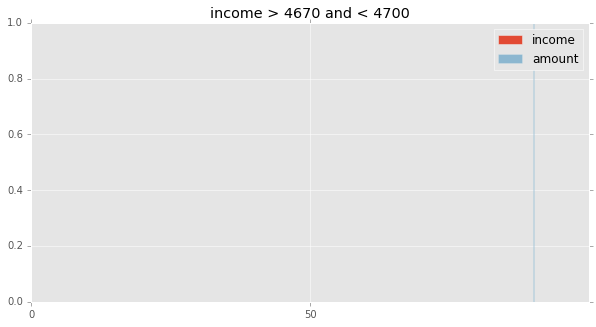



iteration 1
name 4700 to 4730
std 1587.53392263
mean 1931.71929825
median 1330.0
max_mult 1.27226463104
med_mult 0.28297872340425534
min_mult 0.00531914893617
q98 5246.4
q02 64.24
q75 3000.0
q25 720.0
iqr 2280.0
min_q -2700.0
max_q 6420.0
count of loans 60
pct of total loans 0.00260141846678


iteration 2
name 4700 to 4730
std 1587.53392263
mean 1931.71929825
median 1330.0
max_mult 1.27226463104
med_mult 0.28297872340425534
min_mult 0.00531914893617
q98 5246.4
q02 64.24
q75 3000.0
q25 720.0
iqr 2280.0
min_q -2700.0
max_q 6420.0
count of loans 60
pct of total loans 0.00260141846678


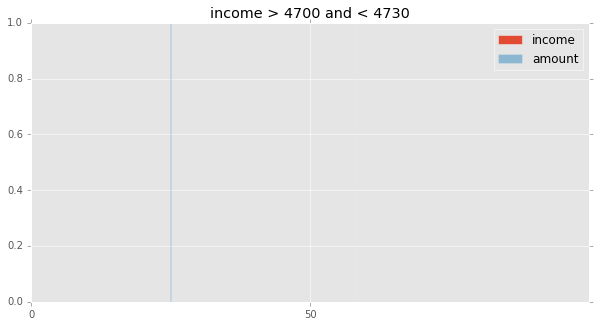



iteration 1
name 4730 to 4760
std 1330.49254944
mean 1583.74193548
median 1116.5
max_mult 1.05618926912
med_mult 0.23502681851149948
min_mult 0.00589846218664
q98 4890.0
q02 80.5
q75 2465.0
q25 423.0
iqr 2042.0
min_q -2640.0
max_q 5528.0
count of loans 66
pct of total loans 0.00286156031345


iteration 2
name 4730 to 4760
std 1330.49254944
mean 1583.74193548
median 1116.5
max_mult 1.05618926912
med_mult 0.23502681851149948
min_mult 0.00589846218664
q98 4890.0
q02 80.5
q75 2465.0
q25 423.0
iqr 2042.0
min_q -2640.0
max_q 5528.0
count of loans 66
pct of total loans 0.00286156031345


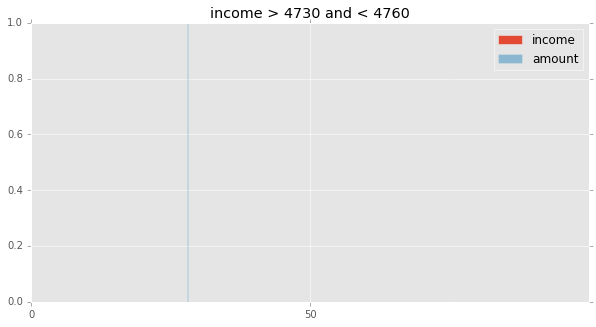



iteration 1
name 4760 to 4790
std 1143.14721653
mean 1434.38095238
median 1190.0
max_mult 0.837871805614
med_mult 0.24893183093917487
min_mult 0.0209731543624
q98 3934.4
q02 113.94
q75 1998.75
q25 562.5
iqr 1436.25
min_q -1591.875
max_q 4153.125
count of loans 45
pct of total loans 0.00195106385008


iteration 2
name 4760 to 4790
std 1143.14721653
mean 1434.38095238
median 1190.0
max_mult 0.837871805614
med_mult 0.24893183093917487
min_mult 0.0209731543624
q98 3934.4
q02 113.94
q75 1998.75
q25 562.5
iqr 1436.25
min_q -1591.875
max_q 4153.125
count of loans 45
pct of total loans 0.00195106385008


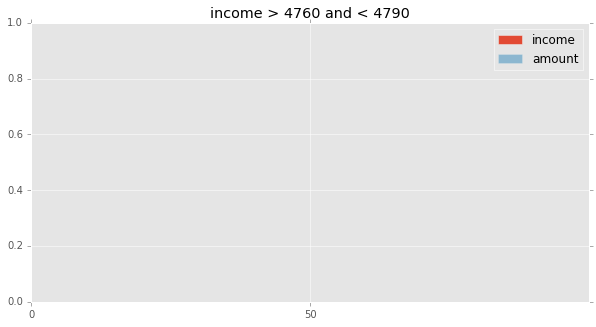



iteration 1
name 4790 to 4820
std 1339.80427789
mean 1539.64583333
median 1000.0
max_mult 1.11666666667
med_mult 0.20833333333333334
min_mult 0.00582726326743
q98 5000.0
q02 99.86
q75 2192.0
q25 477.5
iqr 1714.5
min_q -2094.25
max_q 4763.75
count of loans 152
pct of total loans 0.00659026011583


iteration 2
name 4790 to 4820
std 1173.69622247
mean 1410.78417266
median 1000.0
max_mult 0.9625
med_mult 0.20833333333333334
min_mult 0.00582726326743
q98 4192.2
q02 99.76
q75 2048.0
q25 460.0
iqr 1588.0
min_q -1922.0
max_q 4430.0
count of loans 152
pct of total loans 0.00659026011583


iteration 3
name 4790 to 4820
std 1088.9005498
mean 1341.75735294
median 977.5
max_mult 0.853125
med_mult 0.20364583333333333
min_mult 0.00582726326743
q98 4000.0
q02 99.7
q75 2000.0
q25 441.75
iqr 1558.25
min_q -1895.625
max_q 4337.375
count of loans 152
pct of total loans 0.00659026011583


iteration 4
name 4790 to 4820
std 1088.9005498
mean 1341.75735294
median 977.5
max_mult 0.853125
med_mult 0.203645833

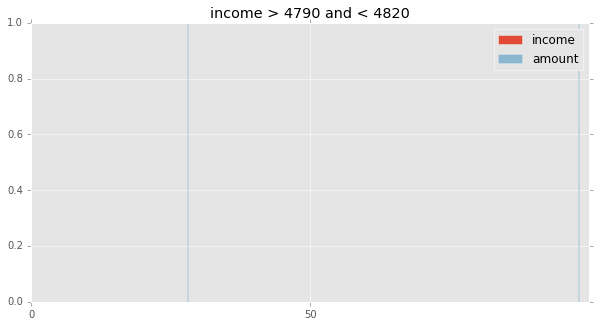



iteration 1
name 4820 to 4850
std 1130.64397384
mean 1879.76190476
median 1700.0
max_mult 0.969471947195
med_mult 0.3522983538903782
min_mult 0.0134436401241
q98 4126.0
q02 278.2
q75 2593.75
q25 1100.0
iqr 1493.75
min_q -1140.625
max_q 4834.375
count of loans 44
pct of total loans 0.00190770687564


iteration 2
name 4820 to 4850
std 1130.64397384
mean 1879.76190476
median 1700.0
max_mult 0.969471947195
med_mult 0.3522983538903782
min_mult 0.0134436401241
q98 4126.0
q02 278.2
q75 2593.75
q25 1100.0
iqr 1493.75
min_q -1140.625
max_q 4834.375
count of loans 44
pct of total loans 0.00190770687564


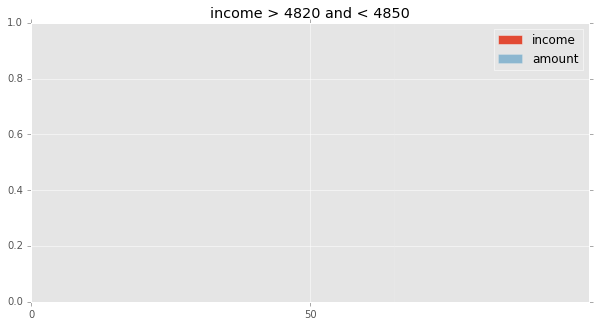



iteration 1
name 4850 to 4880
std 1208.29338814
mean 1731.38709677
median 1240.0
max_mult 0.968273588793
med_mult 0.25524907369287775
min_mult 0.034787978592
q98 4280.0
q02 317.8
q75 2600.0
q25 1000.0
iqr 1600.0
min_q -1400.0
max_q 5000.0
count of loans 31
pct of total loans 0.00134406620783


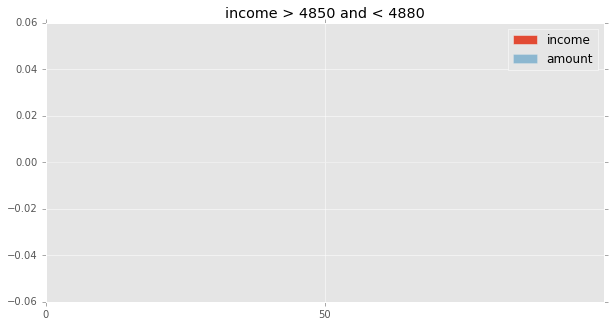



iteration 1
name 4880 to 4910
std 1076.55640062
mean 1292.93939394
median 1000.0
max_mult 0.892229038855
med_mult 0.20408163265306123
min_mult 0.0278061746064
q98 4354.68
q02 171.84
q75 1820.0
q25 600.0
iqr 1220.0
min_q -1230.0
max_q 3650.0
count of loans 39
pct of total loans 0.0016909220034


iteration 2
name 4880 to 4910
std 755.09925147
mean 1095.29032258
median 1000.0
max_mult 0.611246943765
med_mult 0.2038735983690112
min_mult 0.0278061746064
q98 2655.0
q02 169.6
q75 1760.0
q25 545.0
iqr 1215.0
min_q -1277.5
max_q 3582.5
count of loans 39
pct of total loans 0.0016909220034


iteration 3
name 4880 to 4910
std 755.09925147
mean 1095.29032258
median 1000.0
max_mult 0.611246943765
med_mult 0.2038735983690112
min_mult 0.0278061746064
q98 2655.0
q02 169.6
q75 1760.0
q25 545.0
iqr 1215.0
min_q -1277.5
max_q 3582.5
count of loans 39
pct of total loans 0.0016909220034


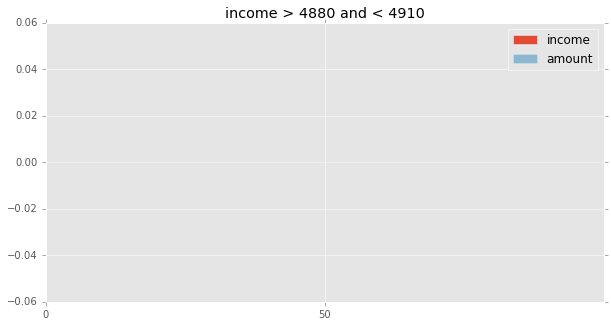



iteration 1
name 4910 to 4940
std 982.703206875
mean 1432.6969697
median 1100.0
max_mult 0.853832079691
med_mult 0.22339561332250202
min_mult 0.0620437956204
q98 3720.0
q02 334.16
q75 1983.0
q25 730.0
iqr 1253.0
min_q -1149.5
max_q 3862.5
count of loans 37
pct of total loans 0.00160420805451


iteration 2
name 4910 to 4940
std 861.456034277
mean 1346.21875
median 1100.0
max_mult 0.700934579439
med_mult 0.22339561332250202
min_mult 0.0620437956204
q98 3219.98
q02 333.28
q75 1808.25
q25 685.5
iqr 1122.75
min_q -998.625
max_q 3492.375
count of loans 37
pct of total loans 0.00160420805451


iteration 3
name 4910 to 4940
std 861.456034277
mean 1346.21875
median 1100.0
max_mult 0.700934579439
med_mult 0.22339561332250202
min_mult 0.0620437956204
q98 3219.98
q02 333.28
q75 1808.25
q25 685.5
iqr 1122.75
min_q -998.625
max_q 3492.375
count of loans 37
pct of total loans 0.00160420805451


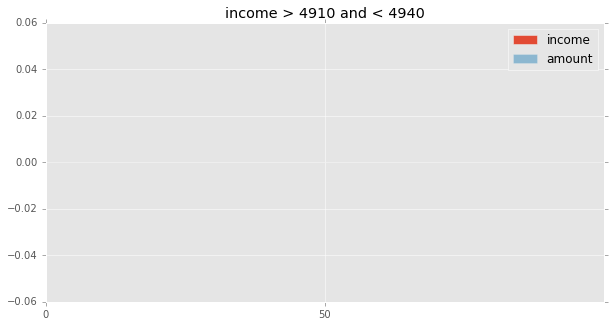



iteration 1
name 4940 to 4970
std 1163.61999849
mean 1684.11764706
median 1382.5
max_mult 0.925626515764
med_mult 0.2795479346814147
min_mult 0.0333737864078
q98 4197.2
q02 188.1
q75 2515.0
q25 746.25
iqr 1768.75
min_q -1906.875
max_q 5168.125
count of loans 36
pct of total loans 0.00156085108007


iteration 2
name 4940 to 4970
std 1163.61999849
mean 1684.11764706
median 1382.5
max_mult 0.925626515764
med_mult 0.2795479346814147
min_mult 0.0333737864078
q98 4197.2
q02 188.1
q75 2515.0
q25 746.25
iqr 1768.75
min_q -1906.875
max_q 5168.125
count of loans 36
pct of total loans 0.00156085108007


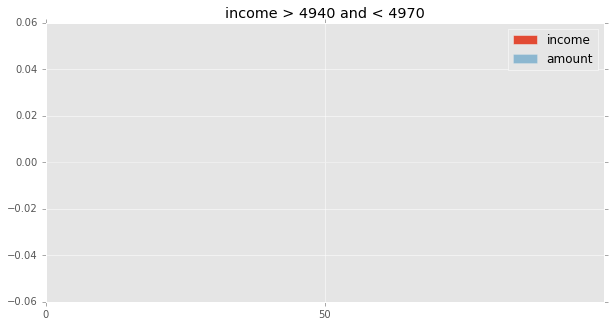



iteration 1
name 4970 to 5000
std 1440.81449626
mean 1922.96610169
median 1722.0
max_mult 1.20336943442
med_mult 0.3449519230769231
min_mult 0.0142227564103
q98 5163.0
q02 107.76
q75 2600.0
q25 662.0
iqr 1938.0
min_q -2245.0
max_q 5507.0
count of loans 61
pct of total loans 0.00264477544122


iteration 2
name 4970 to 5000
std 1347.4869187
mean 1852.67241379
median 1701.0
max_mult 1.03665865385
med_mult 0.3408126348851549
min_mult 0.0142227564103
q98 5086.0
q02 107.54
q75 2575.0
q25 656.0
iqr 1919.0
min_q -2222.5
max_q 5453.5
count of loans 61
pct of total loans 0.00264477544122


iteration 3
name 4970 to 5000
std 1347.4869187
mean 1852.67241379
median 1701.0
max_mult 1.03665865385
med_mult 0.3408126348851549
min_mult 0.0142227564103
q98 5086.0
q02 107.54
q75 2575.0
q25 656.0
iqr 1919.0
min_q -2222.5
max_q 5453.5
count of loans 61
pct of total loans 0.00264477544122


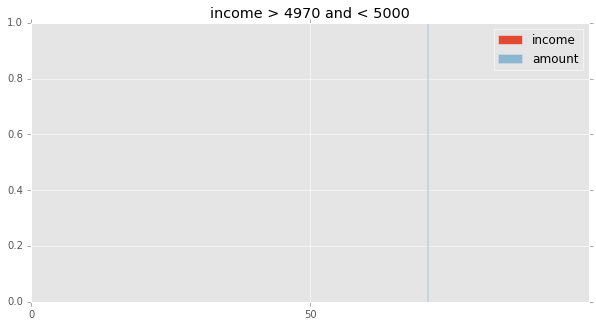



iteration 1
name 5000 to 5030
std 1171.32786537
mean 1636.27338129
median 1400.0
max_mult 1.056
med_mult 0.28
min_mult 0.0179140127389
q98 4574.4
q02 115.52
q75 2310.0
q25 734.0
iqr 1576.0
min_q -1630.0
max_q 4674.0
count of loans 150
pct of total loans 0.00650354616694


iteration 2
name 5000 to 5030
std 1063.3291117
mean 1560.01470588
median 1359.0
max_mult 0.888
med_mult 0.27180000000000004
min_mult 0.0179140127389
q98 4000.0
q02 115.4
q75 2210.0
q25 723.75
iqr 1486.25
min_q -1505.625
max_q 4439.375
count of loans 150
pct of total loans 0.00650354616694


iteration 3
name 5000 to 5030
std 1037.66576918
mean 1538.68148148
median 1330.0
max_mult 0.851085008959
med_mult 0.266
min_mult 0.0179140127389
q98 4000.0
q02 115.36
q75 2146.5
q25 722.5
iqr 1424.0
min_q -1413.5
max_q 4282.5
count of loans 150
pct of total loans 0.00650354616694


iteration 4
name 5000 to 5030
std 1037.66576918
mean 1538.68148148
median 1330.0
max_mult 0.851085008959
med_mult 0.266
min_mult 0.0179140127389
q98 4

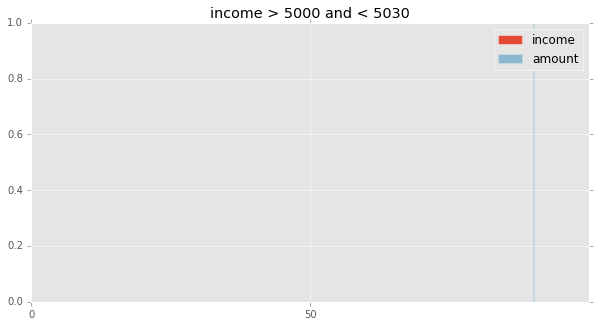



iteration 1
name 5030 to 5060
std 995.033544712
mean 1263.51020408
median 1000.0
max_mult 0.791765637371
med_mult 0.1984126984126984
min_mult 0.0158950923902
q98 3712.0
q02 128.0
q75 2000.0
q25 436.0
iqr 1564.0
min_q -1910.0
max_q 4346.0
count of loans 51
pct of total loans 0.00221120569676


iteration 2
name 5030 to 5060
std 995.033544712
mean 1263.51020408
median 1000.0
max_mult 0.791765637371
med_mult 0.1984126984126984
min_mult 0.0158950923902
q98 3712.0
q02 128.0
q75 2000.0
q25 436.0
iqr 1564.0
min_q -1910.0
max_q 4346.0
count of loans 51
pct of total loans 0.00221120569676


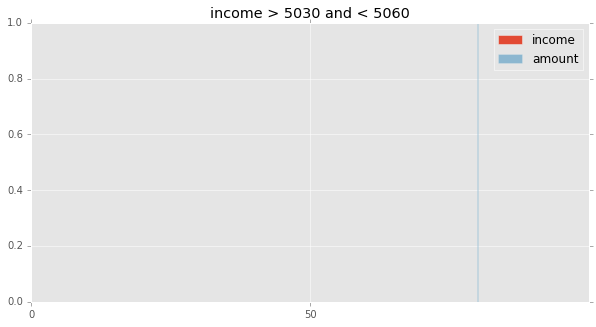



iteration 1
name 5060 to 5090
std 1494.69592591
mean 1699.97142857
median 1100.0
max_mult 0.984639621898
med_mult 0.21674876847290642
min_mult 0.00985415845487
q98 4932.0
q02 145.2
q75 2499.0
q25 540.5
iqr 1958.5
min_q -2397.25
max_q 5436.75
count of loans 36
pct of total loans 0.00156085108007


iteration 2
name 5060 to 5090
std 1494.69592591
mean 1699.97142857
median 1100.0
max_mult 0.984639621898
med_mult 0.21674876847290642
min_mult 0.00985415845487
q98 4932.0
q02 145.2
q75 2499.0
q25 540.5
iqr 1958.5
min_q -2397.25
max_q 5436.75
count of loans 36
pct of total loans 0.00156085108007


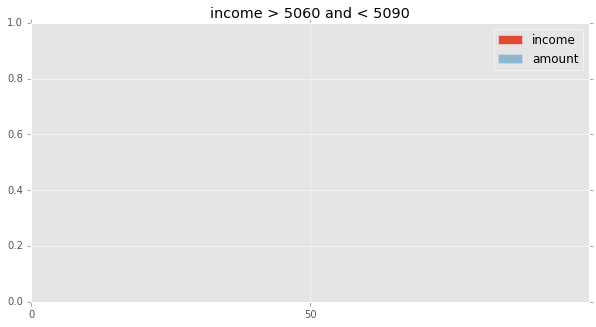



iteration 1
name 5090 to 5120
std 1172.24990745
mean 1353.275
median 999.5
max_mult 0.980776775206
med_mult 0.19588446544141652
min_mult 0.00977899471934
q98 4220.0
q02 102.26
q75 1957.25
q25 357.5
iqr 1599.75
min_q -2042.125
max_q 4356.875
count of loans 43
pct of total loans 0.00186434990119


iteration 2
name 5090 to 5120
std 1025.37580945
mean 1259.76923077
median 999.0
max_mult 0.782319577547
med_mult 0.19569049951028403
min_mult 0.00977899471934
q98 3240.0
q02 100.92
q75 1911.5
q25 355.0
iqr 1556.5
min_q -1979.75
max_q 4246.25
count of loans 43
pct of total loans 0.00186434990119


iteration 3
name 5090 to 5120
std 1025.37580945
mean 1259.76923077
median 999.0
max_mult 0.782319577547
med_mult 0.19569049951028403
min_mult 0.00977899471934
q98 3240.0
q02 100.92
q75 1911.5
q25 355.0
iqr 1556.5
min_q -1979.75
max_q 4246.25
count of loans 43
pct of total loans 0.00186434990119


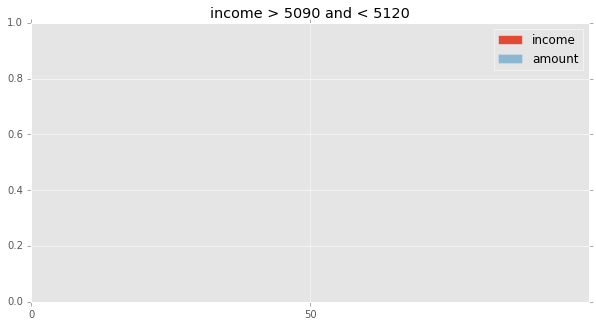



iteration 1
name 5120 to 5150
std 674.579289181
mean 1374.5
median 1157.5
max_mult 0.584453535944
med_mult 0.22593964868451014
min_mult 0.0811599844297
q98 2770.0
q02 441.38
q75 1834.0
q25 998.0
iqr 836.0
min_q -256.0
max_q 3088.0
count of loans 26
pct of total loans 0.0011272813356


iteration 2
name 5120 to 5150
std 674.579289181
mean 1374.5
median 1157.5
max_mult 0.584453535944
med_mult 0.22593964868451014
min_mult 0.0811599844297
q98 2770.0
q02 441.38
q75 1834.0
q25 998.0
iqr 836.0
min_q -256.0
max_q 3088.0
count of loans 26
pct of total loans 0.0011272813356


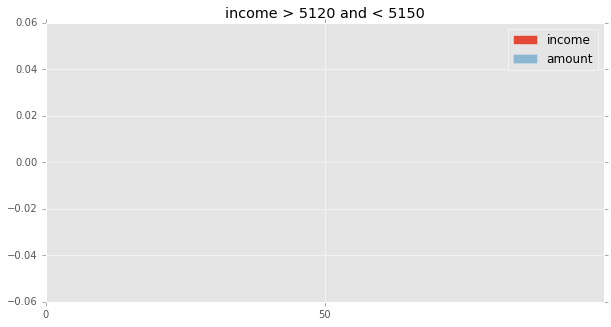



iteration 1
name 5150 to 5180
std 1067.1105288
mean 1736.45454545
median 1505.0
max_mult 0.917342603322
med_mult 0.2916666666666667
min_mult 0.034730306558
q98 3950.0
q02 287.16
q75 2500.0
q25 880.0
iqr 1620.0
min_q -1550.0
max_q 4930.0
count of loans 36
pct of total loans 0.00156085108007


iteration 2
name 5150 to 5180
std 1067.1105288
mean 1736.45454545
median 1505.0
max_mult 0.917342603322
med_mult 0.2916666666666667
min_mult 0.034730306558
q98 3950.0
q02 287.16
q75 2500.0
q25 880.0
iqr 1620.0
min_q -1550.0
max_q 4930.0
count of loans 36
pct of total loans 0.00156085108007


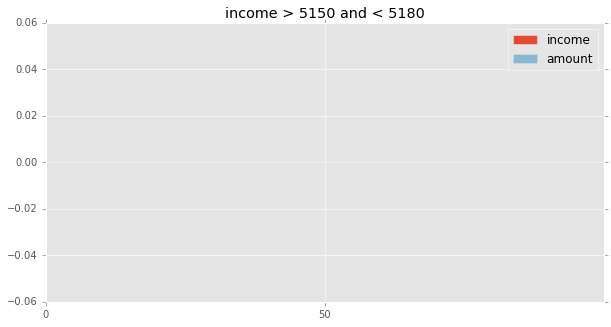



iteration 1
name 5180 to 5210
std 807.609746958
mean 1108.91304348
median 995.0
max_mult 0.626445643793
med_mult 0.19147447007065727
min_mult 0.0261538461538
q98 3025.0
q02 139.6
q75 1500.0
q25 400.0
iqr 1100.0
min_q -1250.0
max_q 3150.0
count of loans 49
pct of total loans 0.00212449174787


iteration 2
name 5180 to 5210
std 748.701633739
mean 1061.33333333
median 990.0
max_mult 0.576923076923
med_mult 0.19064124783362218
min_mult 0.0261538461538
q98 2806.4
q02 139.52
q75 1500.0
q25 400.0
iqr 1100.0
min_q -1250.0
max_q 3150.0
count of loans 49
pct of total loans 0.00212449174787


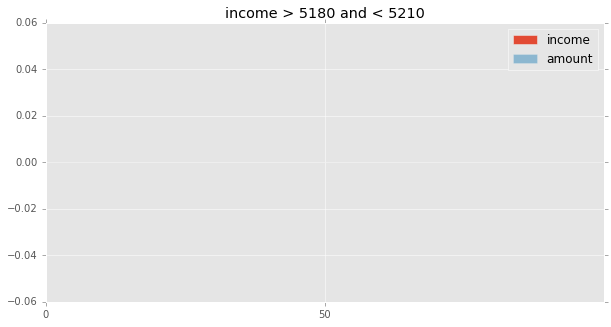



iteration 1
name 5210 to 5240
std 992.059244689
mean 1202.71428571
median 1075.0
max_mult 0.682192831129
med_mult 0.20596697775641049
min_mult 0.0283253588517
q98 3257.14
q02 181.48
q75 1707.5
q25 312.25
iqr 1395.25
min_q -1780.625
max_q 3800.375
count of loans 32
pct of total loans 0.00138742318228


iteration 2
name 5210 to 5240
std 992.059244689
mean 1202.71428571
median 1075.0
max_mult 0.682192831129
med_mult 0.20596697775641049
min_mult 0.0283253588517
q98 3257.14
q02 181.48
q75 1707.5
q25 312.25
iqr 1395.25
min_q -1780.625
max_q 3800.375
count of loans 32
pct of total loans 0.00138742318228


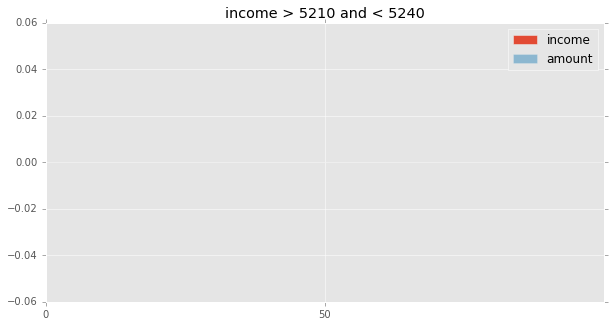



iteration 1
name 5240 to 5270
std 804.607426706
mean 1143.55555556
median 1007.0
max_mult 0.580761904762
med_mult 0.19177127413418674
min_mult 0.00761179828735
q98 3006.3
q02 134.5
q75 1602.5
q25 534.0
iqr 1068.5
min_q -1068.75
max_q 3205.25
count of loans 40
pct of total loans 0.00173427897785


iteration 2
name 5240 to 5270
std 804.607426706
mean 1143.55555556
median 1007.0
max_mult 0.580761904762
med_mult 0.19177127413418674
min_mult 0.00761179828735
q98 3006.3
q02 134.5
q75 1602.5
q25 534.0
iqr 1068.5
min_q -1068.75
max_q 3205.25
count of loans 40
pct of total loans 0.00173427897785


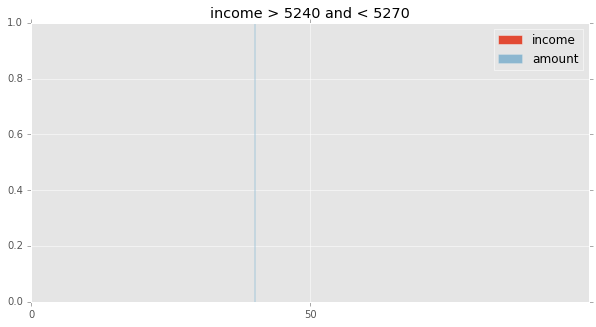



iteration 1
name 5270 to 5300
std 1605.58867709
mean 1628.6
median 880.0
max_mult 1.08506616257
med_mult 0.16682464454976303
min_mult 0.0278409090909
q98 5324.8
q02 147.48
q75 2243.0
q25 292.0
iqr 1951.0
min_q -2634.5
max_q 5169.5
count of loans 26
pct of total loans 0.0011272813356


iteration 2
name 5270 to 5300
std 1387.24050387
mean 1457.29166667
median 827.5
max_mult 0.923295454545
med_mult 0.15660839329868204
min_mult 0.0278409090909
q98 4417.3
q02 147.46
q75 2060.75
q25 274.0
iqr 1786.75
min_q -2406.125
max_q 4740.875
count of loans 26
pct of total loans 0.0011272813356


iteration 3
name 5270 to 5300
std 1207.42861392
mean 1308.69565217
median 775.0
max_mult 0.733736762481
med_mult 0.14639214204760106
min_mult 0.0278409090909
q98 3756.8
q02 147.44
q75 1995.0
q25 256.0
iqr 1739.0
min_q -2352.5
max_q 4603.5
count of loans 26
pct of total loans 0.0011272813356


iteration 4
name 5270 to 5300
std 1207.42861392
mean 1308.69565217
median 775.0
max_mult 0.733736762481
med_mult 0.146

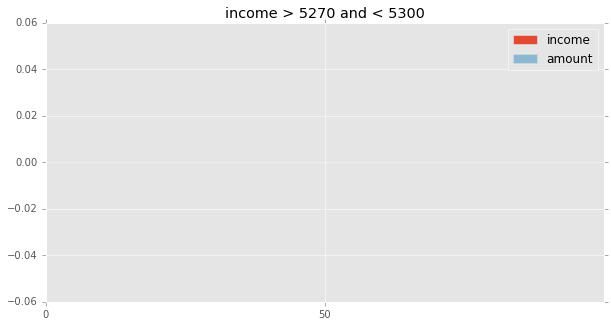



iteration 1
name 5300 to 5330
std 1336.52763951
mean 1787.74193548
median 1500.0
max_mult 0.941619585687
med_mult 0.28169014084507044
min_mult 0.0140792190726
q98 4700.0
q02 81.0
q75 2350.0
q25 829.0
iqr 1521.0
min_q -1452.5
max_q 4631.5
count of loans 32
pct of total loans 0.00138742318228


iteration 2
name 5300 to 5330
std 1216.64644606
mean 1680.66666667
median 1432.5
max_mult 0.84761725372
med_mult 0.26954580585530913
min_mult 0.0140792190726
q98 4210.0
q02 80.8
q75 2251.25
q25 780.5
iqr 1470.75
min_q -1425.625
max_q 4457.375
count of loans 32
pct of total loans 0.00138742318228


iteration 3
name 5300 to 5330
std 1113.29461465
mean 1583.44827586
median 1365.0
max_mult 0.751597143931
med_mult 0.2574014708655478
min_mult 0.0140792190726
q98 3851.6
q02 80.6
q75 2105.0
q25 732.0
iqr 1373.0
min_q -1327.5
max_q 4164.5
count of loans 32
pct of total loans 0.00138742318228


iteration 4
name 5300 to 5330
std 1113.29461465
mean 1583.44827586
median 1365.0
max_mult 0.751597143931
med_mul

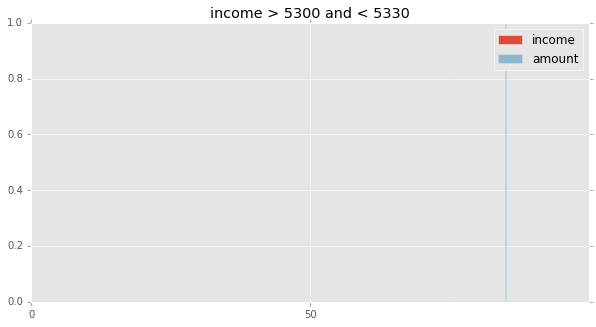



iteration 1
name 5330 to 5360
std 1892.99727144
mean 2555.32432432
median 2400.0
max_mult 1.30670151204
med_mult 0.44960659423004873
min_mult 0.00655185323849
q98 6928.0
q02 83.24
q75 3900.0
q25 1100.0
iqr 2800.0
min_q -3100.0
max_q 8100.0
count of loans 37
pct of total loans 0.00160420805451


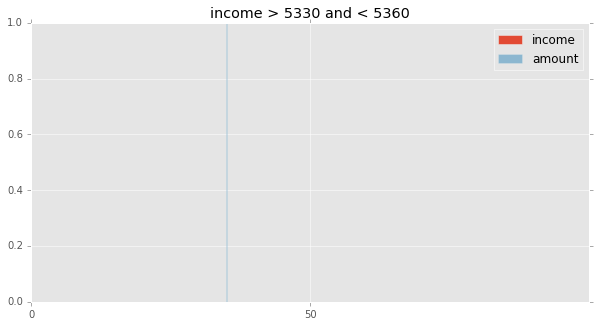



iteration 1
name 5360 to 5390
std 1642.06269978
mean 1378.08
median 625.0
max_mult 1.20397917441
med_mult 0.11619260085517755
min_mult 0.0122585438336
q98 5383.0
q02 91.92
q75 1400.0
q25 247.0
iqr 1153.0
min_q -1482.5
max_q 3129.5
count of loans 28
pct of total loans 0.0012139952845


iteration 2
name 5360 to 5390
std 799.852272075
mean 783.428571429
median 460.0
max_mult 0.536703215016
med_mult 0.0853590647615513
min_mult 0.0122585438336
q98 2818.4
q02 87.6
q75 1250.0
q25 226.0
iqr 1024.0
min_q -1310.0
max_q 2786.0
count of loans 28
pct of total loans 0.0012139952845


iteration 3
name 5360 to 5390
std 654.723372683
mean 678.2
median 436.5
max_mult 0.503805457583
med_mult 0.08114107084231412
min_mult 0.0122585438336
q98 2214.68
q02 86.52
q75 1062.5
q25 218.75
iqr 843.75
min_q -1046.875
max_q 2328.125
count of loans 28
pct of total loans 0.0012139952845


iteration 4
name 5360 to 5390
std 458.377509833
mean 571.052631579
median 413.0
max_mult 0.260610573343
med_mult 0.076923076923076

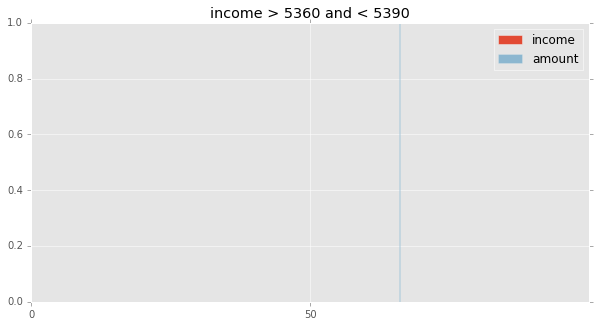



iteration 1
name 5390 to 5420
std 1770.83956901
mean 1717.58
median 1044.0
max_mult 1.2962962963
med_mult 0.19333333333333333
min_mult 0.0199704142012
q98 7000.0
q02 123.68
q75 1987.5
q25 450.0
iqr 1537.5
min_q -1856.25
max_q 4293.75
count of loans 56
pct of total loans 0.00242799056899


iteration 2
name 5390 to 5420
std 968.979922589
mean 1175.65909091
median 986.5
max_mult 0.688888888889
med_mult 0.18239576709809313
min_mult 0.0199704142012
q98 3371.7
q02 121.76
q75 1756.25
q25 413.25
iqr 1343.0
min_q -1601.25
max_q 3770.75
count of loans 56
pct of total loans 0.00242799056899


iteration 3
name 5390 to 5420
std 968.979922589
mean 1175.65909091
median 986.5
max_mult 0.688888888889
med_mult 0.18239576709809313
min_mult 0.0199704142012
q98 3371.7
q02 121.76
q75 1756.25
q25 413.25
iqr 1343.0
min_q -1601.25
max_q 3770.75
count of loans 56
pct of total loans 0.00242799056899


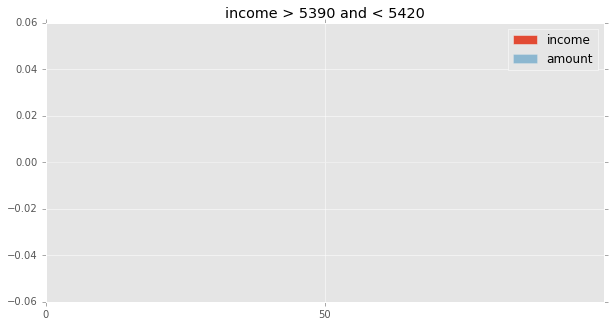



iteration 1
name 5420 to 5450
std 2430.0282148
mean 2631.51612903
median 1925.0
max_mult 1.70099301214
med_mult 0.3547079417726184
min_mult 0.0186209439528
q98 8185.0
q02 130.4
q75 3935.0
q25 888.0
iqr 3047.0
min_q -3682.5
max_q 8505.5
count of loans 33
pct of total loans 0.00143078015673


iteration 2
name 5420 to 5450
std 2132.56071345
mean 2410.9
median 1762.5
max_mult 1.37661141805
med_mult 0.32495544690106937
min_mult 0.0186209439528
q98 6909.5
q02 129.42
q75 3777.5
q25 844.0
iqr 2933.5
min_q -3556.25
max_q 8177.75
count of loans 33
pct of total loans 0.00143078015673


iteration 3
name 5420 to 5450
std 2132.56071345
mean 2410.9
median 1762.5
max_mult 1.37661141805
med_mult 0.32495544690106937
min_mult 0.0186209439528
q98 6909.5
q02 129.42
q75 3777.5
q25 844.0
iqr 2933.5
min_q -3556.25
max_q 8177.75
count of loans 33
pct of total loans 0.00143078015673


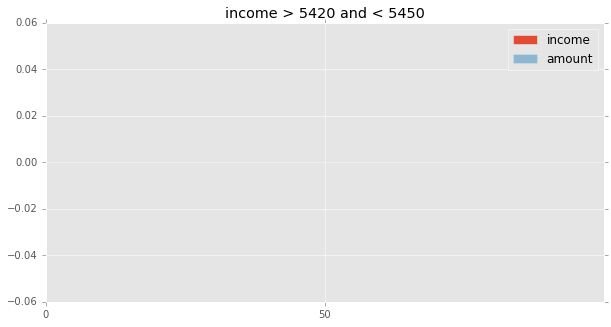



iteration 1
name 5450 to 5480
std 1154.40416222
mean 1408.02857143
median 1433.0
max_mult 0.891061963078
med_mult 0.2629357798165138
min_mult 0.010989010989
q98 4110.0
q02 98.08
q75 2196.5
q25 398.0
iqr 1798.5
min_q -2299.75
max_q 4894.25
count of loans 37
pct of total loans 0.00160420805451


iteration 2
name 5450 to 5480
std 1154.40416222
mean 1408.02857143
median 1433.0
max_mult 0.891061963078
med_mult 0.2629357798165138
min_mult 0.010989010989
q98 4110.0
q02 98.08
q75 2196.5
q25 398.0
iqr 1798.5
min_q -2299.75
max_q 4894.25
count of loans 37
pct of total loans 0.00160420805451


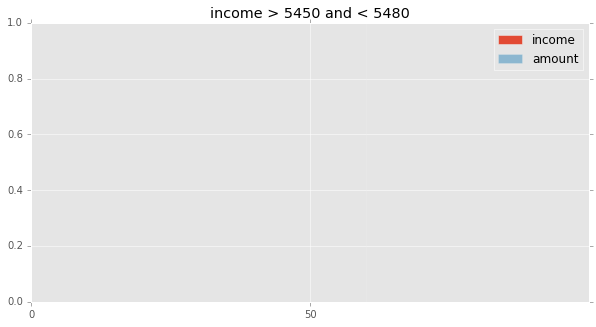



iteration 1
name 5480 to 5510
std 1104.26063106
mean 1608.81481481
median 1280.0
max_mult 0.82056892779
med_mult 0.23272727272727273
min_mult 0.0273622765414
q98 4240.0
q02 155.72
q75 2179.0
q25 836.5
iqr 1342.5
min_q -1177.25
max_q 4192.75
count of loans 31
pct of total loans 0.00134406620783


iteration 2
name 5480 to 5510
std 959.660985012
mean 1497.61538462
median 1230.5
max_mult 0.727272727273
med_mult 0.22372727272727272
min_mult 0.0273622765414
q98 3500.0
q02 155.5
q75 2081.0
q25 826.25
iqr 1254.75
min_q -1055.875
max_q 3963.125
count of loans 31
pct of total loans 0.00134406620783


iteration 3
name 5480 to 5510
std 829.440681021
mean 1397.52
median 1181.0
max_mult 0.544959128065
med_mult 0.21472727272727274
min_mult 0.0273622765414
q98 2906.4
q02 155.28
q75 2000.0
q25 816.0
iqr 1184.0
min_q -960.0
max_q 3776.0
count of loans 31
pct of total loans 0.00134406620783


iteration 4
name 5480 to 5510
std 829.440681021
mean 1397.52
median 1181.0
max_mult 0.544959128065
med_mult 0.2

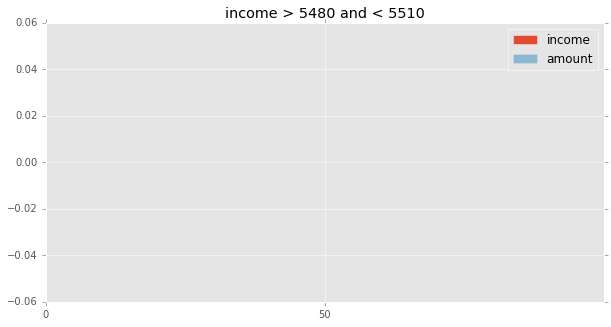



iteration 1
name 5510 to 5540
std 2008.10689115
mean 2353.5625
median 1761.5
max_mult 1.45032632342
med_mult 0.31826461096792863
min_mult 0.0264540677659
q98 7380.0
q02 156.54
q75 3245.0
q25 852.0
iqr 2393.0
min_q -2737.5
max_q 6834.5
count of loans 33
pct of total loans 0.00143078015673


iteration 2
name 5510 to 5540
std 1531.33040497
mean 2010.46666667
median 1511.5
max_mult 0.99493487699
med_mult 0.2733753791524812
min_mult 0.0264540677659
q98 5210.0
q02 155.86
q75 3033.75
q25 784.0
iqr 2249.75
min_q -2590.625
max_q 6408.375
count of loans 33
pct of total loans 0.00143078015673


iteration 3
name 5510 to 5540
std 1531.33040497
mean 2010.46666667
median 1511.5
max_mult 0.99493487699
med_mult 0.2733753791524812
min_mult 0.0264540677659
q98 5210.0
q02 155.86
q75 3033.75
q25 784.0
iqr 2249.75
min_q -2590.625
max_q 6408.375
count of loans 33
pct of total loans 0.00143078015673


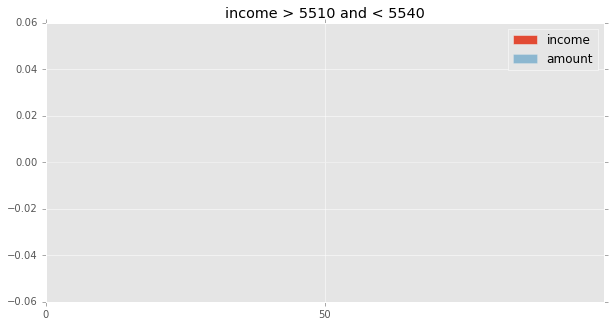



iteration 1
name 5540 to 5570
std 1649.76471842
mean 2238.11538462
median 2164.0
max_mult 1.09585585586
med_mult 0.38971533088163757
min_mult 0.0237111550207
q98 5438.5
q02 216.0
q75 3375.0
q25 755.75
iqr 2619.25
min_q -3173.125
max_q 7303.875
count of loans 26
pct of total loans 0.0011272813356


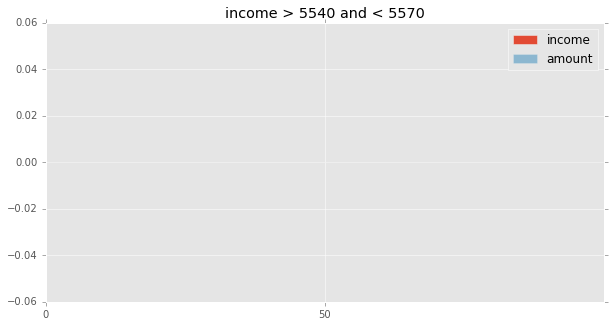



iteration 1
name 5570 to 5600
std 2001.50275879
mean 2102.2962963
median 1470.0
max_mult 1.32951084035
med_mult 0.26344086021505375
min_mult 0.000716589036188
q98 7201.6
q02 68.48
q75 3090.0
q25 546.0
iqr 2544.0
min_q -3270.0
max_q 6906.0
count of loans 28
pct of total loans 0.0012139952845


iteration 2
name 5570 to 5600
std 1410.03382702
mean 1693.68
median 1375.0
max_mult 0.787119856887
med_mult 0.24593096047218743
min_mult 0.000716589036188
q98 4208.0
q02 63.52
q75 3000.0
q25 532.0
iqr 2468.0
min_q -3170.0
max_q 6702.0
count of loans 28
pct of total loans 0.0012139952845


iteration 3
name 5570 to 5600
std 1410.03382702
mean 1693.68
median 1375.0
max_mult 0.787119856887
med_mult 0.24593096047218743
min_mult 0.000716589036188
q98 4208.0
q02 63.52
q75 3000.0
q25 532.0
iqr 2468.0
min_q -3170.0
max_q 6702.0
count of loans 28
pct of total loans 0.0012139952845


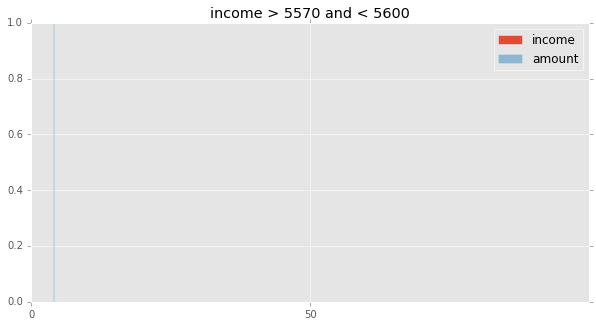



iteration 1
name 5600 to 5630
std 964.819971089
mean 1031.1875
median 677.5
max_mult 0.709188224799
med_mult 0.12070527251056948
min_mult 0.000357142857143
q98 3370.5
q02 56.56
q75 1671.0
q25 258.75
iqr 1412.25
min_q -1859.625
max_q 3789.375
count of loans 38
pct of total loans 0.00164756502896


iteration 2
name 5600 to 5630
std 814.690604245
mean 936.225806452
median 625.0
max_mult 0.533523030411
med_mult 0.11144793152639088
min_mult 0.000357142857143
q98 2637.6
q02 54.8
q75 1566.0
q25 245.5
iqr 1320.5
min_q -1735.25
max_q 3546.75
count of loans 38
pct of total loans 0.00164756502896


iteration 3
name 5600 to 5630
std 814.690604245
mean 936.225806452
median 625.0
max_mult 0.533523030411
med_mult 0.11144793152639088
min_mult 0.000357142857143
q98 2637.6
q02 54.8
q75 1566.0
q25 245.5
iqr 1320.5
min_q -1735.25
max_q 3546.75
count of loans 38
pct of total loans 0.00164756502896


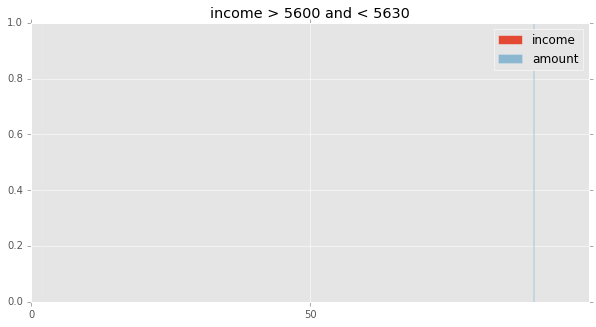



iteration 1
name 5630 to 5660
std 1411.35883062
mean 1580.96551724
median 1068.0
max_mult 1.01308807924
med_mult 0.18882602545968882
min_mult 0.0200603586011
q98 4625.92
q02 115.24
q75 2500.0
q25 500.0
iqr 2000.0
min_q -2500.0
max_q 5500.0
count of loans 31
pct of total loans 0.00134406620783


iteration 2
name 5630 to 5660
std 1185.7493244
mean 1432.85714286
median 1034.0
max_mult 0.665368961246
med_mult 0.18306549499934796
min_mult 0.0200603586011
q98 3673.6
q02 115.16
q75 2453.5
q25 446.25
iqr 2007.25
min_q -2564.625
max_q 5464.375
count of loans 31
pct of total loans 0.00134406620783


iteration 3
name 5630 to 5660
std 1185.7493244
mean 1432.85714286
median 1034.0
max_mult 0.665368961246
med_mult 0.18306549499934796
min_mult 0.0200603586011
q98 3673.6
q02 115.16
q75 2453.5
q25 446.25
iqr 2007.25
min_q -2564.625
max_q 5464.375
count of loans 31
pct of total loans 0.00134406620783


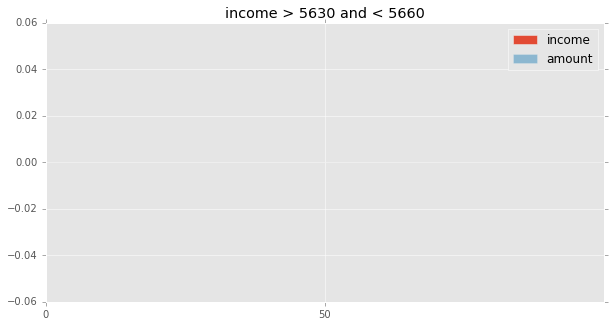



iteration 1
name 5660 to 5690
std 1672.65813717
mean 1895.37931034
median 1167.0
max_mult 1.01005113737
med_mult 0.20596540769502295
min_mult 0.0126582278481
q98 5712.32
q02 110.08
q75 2625.0
q25 700.0
iqr 1925.0
min_q -2187.5
max_q 5512.5
count of loans 32
pct of total loans 0.00138742318228


iteration 2
name 5660 to 5690
std 1344.69886164
mean 1612.51851852
median 1073.0
max_mult 0.880746873349
med_mult 0.18947554299841074
min_mult 0.0126582278481
q98 4766.0
q02 107.36
q75 2028.0
q25 666.0
iqr 1362.0
min_q -1377.0
max_q 4071.0
count of loans 32
pct of total loans 0.00138742318228


iteration 3
name 5660 to 5690
std 812.040800003
mean 1229.5
median 1016.5
max_mult 0.485573539761
med_mult 0.17921171886928233
min_mult 0.0126582278481
q98 2723.2
q02 103.28
q75 2000.0
q25 624.0
iqr 1376.0
min_q -1440.0
max_q 4064.0
count of loans 32
pct of total loans 0.00138742318228


iteration 4
name 5660 to 5690
std 812.040800003
mean 1229.5
median 1016.5
max_mult 0.485573539761
med_mult 0.17921171

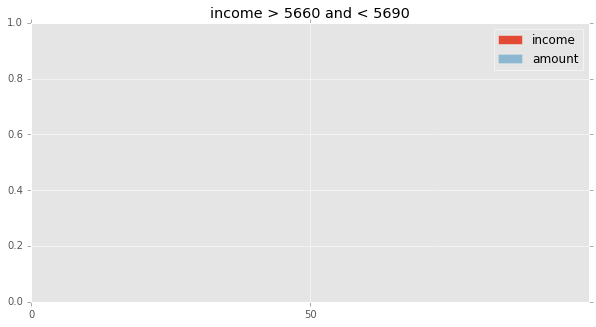



iteration 1
name 5690 to 5720
std 1506.96166413
mean 1846.16666667
median 1485.0
max_mult 0.909792909793
med_mult 0.2602029570445876
min_mult 0.0192880939856
q98 5055.2
q02 129.6
q75 2550.0
q25 818.0
iqr 1732.0
min_q -1780.0
max_q 5148.0
count of loans 38
pct of total loans 0.00164756502896


iteration 2
name 5690 to 5720
std 1414.45501457
mean 1750.8
median 1470.0
max_mult 0.877192982456
med_mult 0.258030542390732
min_mult 0.0192880939856
q98 5000.0
q02 129.04
q75 2325.0
q25 806.0
iqr 1519.0
min_q -1472.5
max_q 4603.5
count of loans 38
pct of total loans 0.00164756502896


iteration 3
name 5690 to 5720
std 1058.94582205
mean 1452.4375
median 1250.0
max_mult 0.658121158911
med_mult 0.21931367817321196
min_mult 0.0192880939856
q98 3590.52
q02 127.36
q75 2032.5
q25 711.5
iqr 1321.0
min_q -1270.0
max_q 4014.0
count of loans 38
pct of total loans 0.00164756502896


iteration 4
name 5690 to 5720
std 1058.94582205
mean 1452.4375
median 1250.0
max_mult 0.658121158911
med_mult 0.219313678173

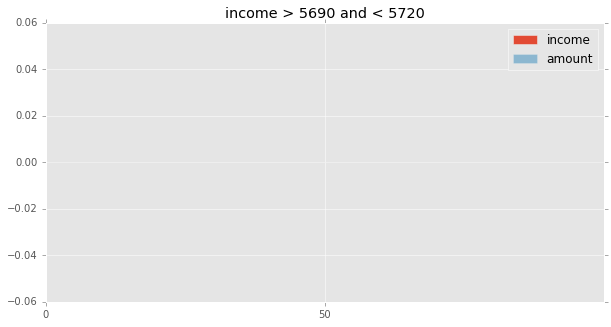



iteration 1
name 5720 to 5750
std 2240.16107
mean 2048.36666667
median 1000.0
max_mult 1.37360724234
med_mult 0.174353416487951
min_mult 0.0190559440559
q98 7314.06
q02 155.98
q75 2711.0
q25 459.0
iqr 2252.0
min_q -2919.0
max_q 6089.0
count of loans 32
pct of total loans 0.00138742318228


iteration 2
name 5720 to 5750
std 1553.37311035
mean 1499.59259259
median 998.0
max_mult 0.991994430908
med_mult 0.17398884239888424
min_mult 0.0190559440559
q98 5336.0
q02 151.12
q75 2357.5
q25 433.0
iqr 1924.5
min_q -2453.75
max_q 5244.25
count of loans 32
pct of total loans 0.00138742318228


iteration 3
name 5720 to 5750
std 1332.89388867
mean 1338.03846154
median 919.0
max_mult 0.871687587169
med_mult 0.1601906568216101
min_mult 0.0190559440559
q98 4612.5
q02 149.5
q75 2050.0
q25 424.5
iqr 1625.5
min_q -2013.75
max_q 4488.25
count of loans 32
pct of total loans 0.00138742318228


iteration 4
name 5720 to 5750
std 1126.73555312
mean 1191.56
median 840.0
max_mult 0.735806339255
med_mult 0.146392

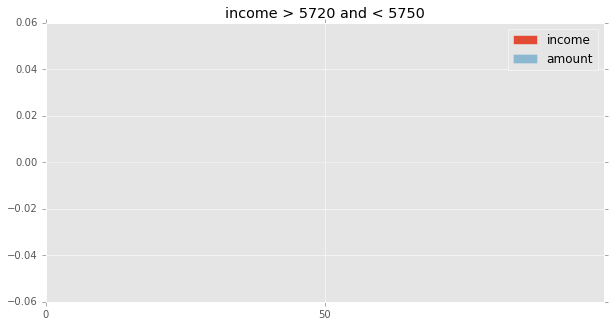



iteration 1
name 5750 to 5780
std 854.07128559
mean 1235.25
median 1000.0
max_mult 0.51015096304
med_mult 0.17317516797946308
min_mult 0.0347222222222
q98 2903.2
q02 241.4
q75 1915.0
q25 576.0
iqr 1339.0
min_q -1432.5
max_q 3923.5
count of loans 27
pct of total loans 0.00117063831005


iteration 2
name 5750 to 5780
std 854.07128559
mean 1235.25
median 1000.0
max_mult 0.51015096304
med_mult 0.17317516797946308
min_mult 0.0347222222222
q98 2903.2
q02 241.4
q75 1915.0
q25 576.0
iqr 1339.0
min_q -1432.5
max_q 3923.5
count of loans 27
pct of total loans 0.00117063831005


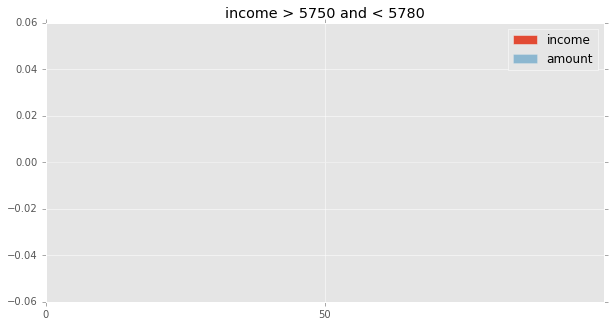



iteration 1
name 5780 to 5810
std 2117.91431889
mean 2498.60714286
median 1650.0
max_mult 1.28041415013
med_mult 0.2843581713842619
min_mult 0.0129578438148
q98 7085.2
q02 131.7
q75 3861.25
q25 925.0
iqr 2936.25
min_q -3479.375
max_q 8265.625
count of loans 28
pct of total loans 0.0012139952845


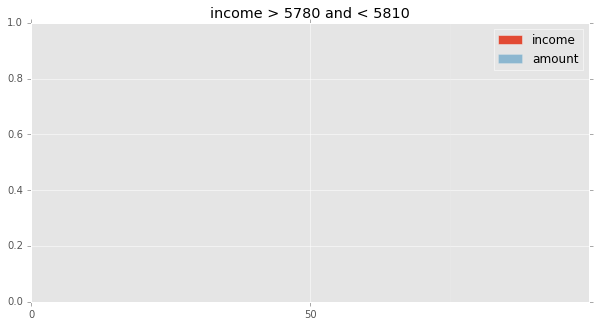



iteration 1
name 5810 to 5840
std 1557.44132418
mean 1828.0
median 1350.0
max_mult 0.857927247769
med_mult 0.23162748787533458
min_mult 0.0175137362637
q98 5000.0
q02 129.6
q75 2895.75
q25 635.25
iqr 2260.5
min_q -2755.5
max_q 6286.5
count of loans 26
pct of total loans 0.0011272813356


iteration 2
name 5810 to 5840
std 1557.44132418
mean 1828.0
median 1350.0
max_mult 0.857927247769
med_mult 0.23162748787533458
min_mult 0.0175137362637
q98 5000.0
q02 129.6
q75 2895.75
q25 635.25
iqr 2260.5
min_q -2755.5
max_q 6286.5
count of loans 26
pct of total loans 0.0011272813356


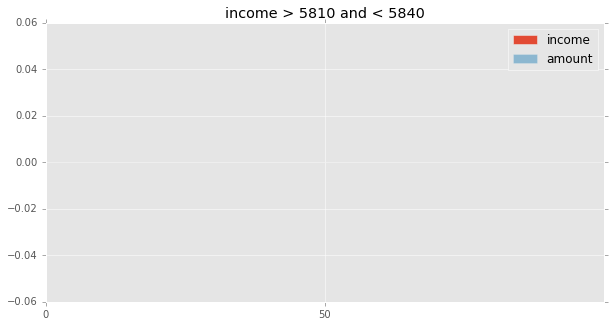



iteration 1
name 5840 to 5870
std 1996.63141316
mean 2128.6
median 1610.0
max_mult 1.02704553235
med_mult 0.2751196172248804
min_mult 0.00769230769231
q98 6000.0
q02 69.0
q75 3740.0
q25 417.0
iqr 3323.0
min_q -4567.5
max_q 8724.5
count of loans 27
pct of total loans 0.00117063831005


iteration 2
name 5840 to 5870
std 1996.63141316
mean 2128.6
median 1610.0
max_mult 1.02704553235
med_mult 0.2751196172248804
min_mult 0.00769230769231
q98 6000.0
q02 69.0
q75 3740.0
q25 417.0
iqr 3323.0
min_q -4567.5
max_q 8724.5
count of loans 27
pct of total loans 0.00117063831005


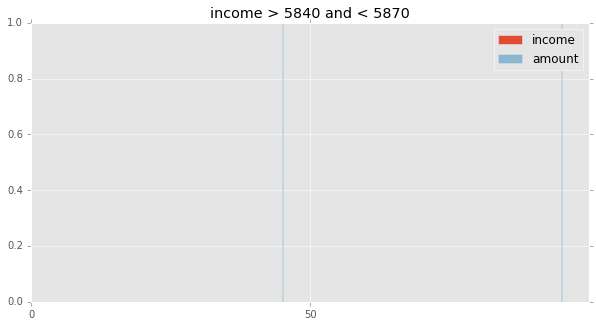



iteration 1
name 5870 to 5900
std 535.944020709
mean 713.08
median 548.0
max_mult 0.367659574468
med_mult 0.09299168505005939
min_mult 0.0228852347856
q98 1843.2
q02 148.92
q75 1079.0
q25 200.0
iqr 879.0
min_q -1118.5
max_q 2397.5
count of loans 29
pct of total loans 0.00125735225894


iteration 2
name 5870 to 5900
std 535.944020709
mean 713.08
median 548.0
max_mult 0.367659574468
med_mult 0.09299168505005939
min_mult 0.0228852347856
q98 1843.2
q02 148.92
q75 1079.0
q25 200.0
iqr 879.0
min_q -1118.5
max_q 2397.5
count of loans 29
pct of total loans 0.00125735225894


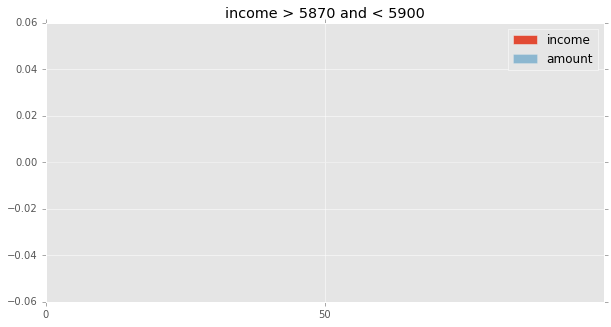



iteration 1
name 5900 to 5930
std 1415.66977951
mean 1551.73076923
median 999.5
max_mult 0.935227464908
med_mult 0.16932938063560757
min_mult 0.024501520784
q98 4452.5
q02 169.5
q75 2875.0
q25 381.5
iqr 2493.5
min_q -3358.75
max_q 6615.25
count of loans 26
pct of total loans 0.0011272813356


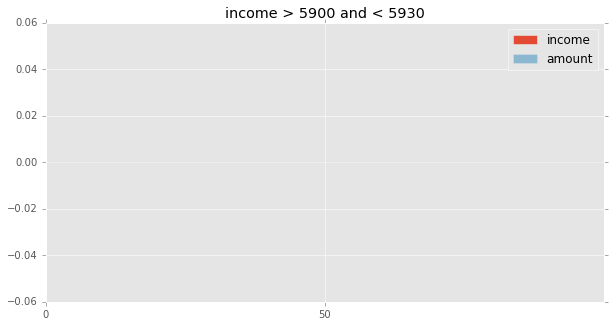



iteration 1
name 5930 to 5960
std 1827.61336174
mean 1710.0
median 892.0
max_mult 0.95717884131
med_mult 0.14976494291470785
min_mult 0.0215162212136
q98 5420.0
q02 134.0
q75 2000.0
q25 495.0
iqr 1505.0
min_q -1762.5
max_q 4257.5
count of loans 23
pct of total loans 0.000997210412264


iteration 2
name 5930 to 5960
std 827.330940612
mean 924.117647059
median 520.0
max_mult 0.480510752688
med_mult 0.0873215785054576
min_mult 0.0215162212136
q98 2584.8
q02 132.8
q75 1480.0
q25 178.0
iqr 1302.0
min_q -1775.0
max_q 3433.0
count of loans 23
pct of total loans 0.000997210412264


iteration 3
name 5930 to 5960
std 827.330940612
mean 924.117647059
median 520.0
max_mult 0.480510752688
med_mult 0.0873215785054576
min_mult 0.0215162212136
q98 2584.8
q02 132.8
q75 1480.0
q25 178.0
iqr 1302.0
min_q -1775.0
max_q 3433.0
count of loans 23
pct of total loans 0.000997210412264


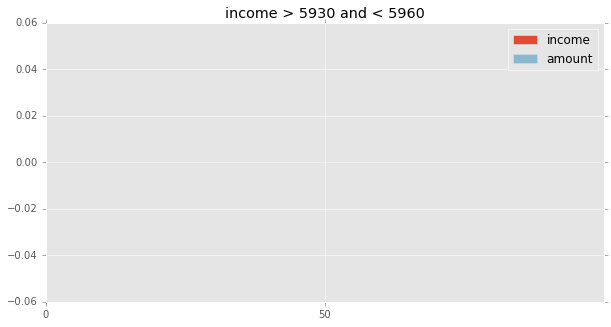



iteration 1
name 5960 to 5990
std 1596.83851549
mean 1890.125
median 1273.0
max_mult 0.838222967309
med_mult 0.2129792456196128
min_mult 0.0301760268231
q98 5000.0
q02 190.58
q75 2408.75
q25 585.0
iqr 1823.75
min_q -2150.625
max_q 5144.375
count of loans 25
pct of total loans 0.00108392436116


iteration 2
name 5960 to 5990
std 1596.83851549
mean 1890.125
median 1273.0
max_mult 0.838222967309
med_mult 0.2129792456196128
min_mult 0.0301760268231
q98 5000.0
q02 190.58
q75 2408.75
q25 585.0
iqr 1823.75
min_q -2150.625
max_q 5144.375
count of loans 25
pct of total loans 0.00108392436116


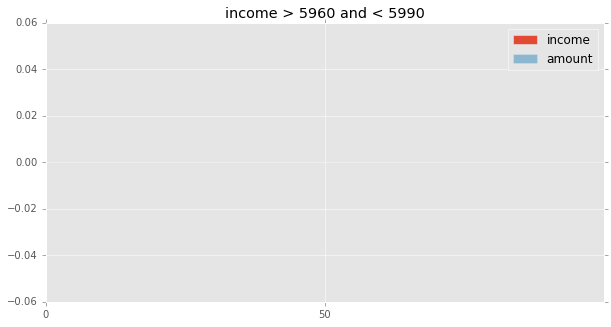



iteration 1
name 5990 to 6020
std 1307.38071662
mean 1465.12941176
median 1025.0
max_mult 0.85
med_mult 0.17083333333333334
min_mult 0.00916208562385
q98 4862.84
q02 110.66
q75 2080.25
q25 440.0
iqr 1640.25
min_q -2020.375
max_q 4540.625
count of loans 182
pct of total loans 0.00789096934922


iteration 2
name 5990 to 6020
std 1093.50219741
mean 1297.98765432
median 1000.0
max_mult 0.708333333333
med_mult 0.16666666666666666
min_mult 0.00916208562385
q98 4000.0
q02 109.54
q75 2000.0
q25 417.0
iqr 1583.0
min_q -1957.5
max_q 4374.5
count of loans 182
pct of total loans 0.00789096934922


iteration 3
name 5990 to 6020
std 1093.50219741
mean 1297.98765432
median 1000.0
max_mult 0.708333333333
med_mult 0.16666666666666666
min_mult 0.00916208562385
q98 4000.0
q02 109.54
q75 2000.0
q25 417.0
iqr 1583.0
min_q -1957.5
max_q 4374.5
count of loans 182
pct of total loans 0.00789096934922


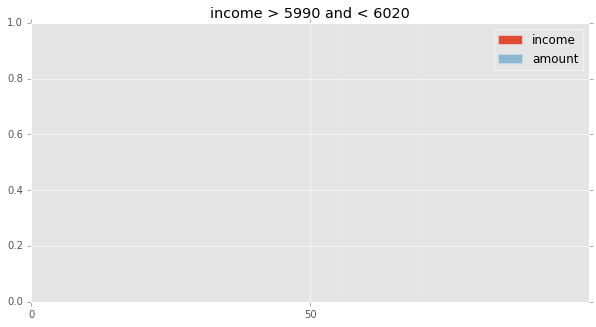



iteration 1
name 6020 to 6050
std 983.833817532
mean 1146.13636364
median 927.0
max_mult 0.626138810668
med_mult 0.1536753768285613
min_mult 0.0116124751161
q98 3402.0
q02 87.22
q75 1477.5
q25 385.25
iqr 1092.25
min_q -1253.125
max_q 3115.875
count of loans 26
pct of total loans 0.0011272813356


iteration 2
name 6020 to 6050
std 808.050935453
mean 1020.71428571
median 854.0
max_mult 0.477770404778
med_mult 0.14132053615753765
min_mult 0.0116124751161
q98 2756.8
q02 86.4
q75 1470.0
q25 375.0
iqr 1095.0
min_q -1267.5
max_q 3112.5
count of loans 26
pct of total loans 0.0011272813356


iteration 3
name 6020 to 6050
std 808.050935453
mean 1020.71428571
median 854.0
max_mult 0.477770404778
med_mult 0.14132053615753765
min_mult 0.0116124751161
q98 2756.8
q02 86.4
q75 1470.0
q25 375.0
iqr 1095.0
min_q -1267.5
max_q 3112.5
count of loans 26
pct of total loans 0.0011272813356


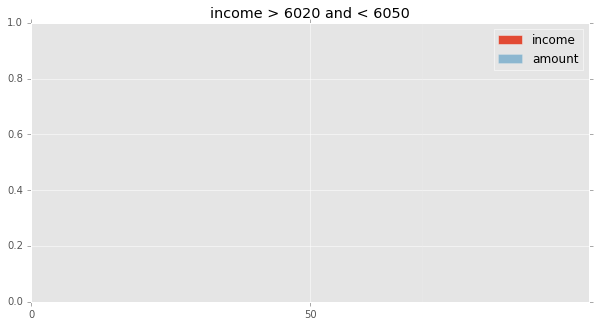



iteration 1
name 6050 to 6080
std 1288.26417501
mean 1562.23076923
median 1250.0
max_mult 0.781652892562
med_mult 0.2059240566949619
min_mult 0.0237232289951
q98 4484.5
q02 174.0
q75 1998.75
q25 544.0
iqr 1454.75
min_q -1638.125
max_q 4180.875
count of loans 29
pct of total loans 0.00125735225894


iteration 2
name 6050 to 6080
std 799.280677103
mean 1192.34782609
median 1082.0
max_mult 0.493989790878
med_mult 0.17881341926954222
min_mult 0.0237232289951
q98 2780.0
q02 170.4
q75 1720.0
q25 408.5
iqr 1311.5
min_q -1558.75
max_q 3687.25
count of loans 29
pct of total loans 0.00125735225894


iteration 3
name 6050 to 6080
std 799.280677103
mean 1192.34782609
median 1082.0
max_mult 0.493989790878
med_mult 0.17881341926954222
min_mult 0.0237232289951
q98 2780.0
q02 170.4
q75 1720.0
q25 408.5
iqr 1311.5
min_q -1558.75
max_q 3687.25
count of loans 29
pct of total loans 0.00125735225894


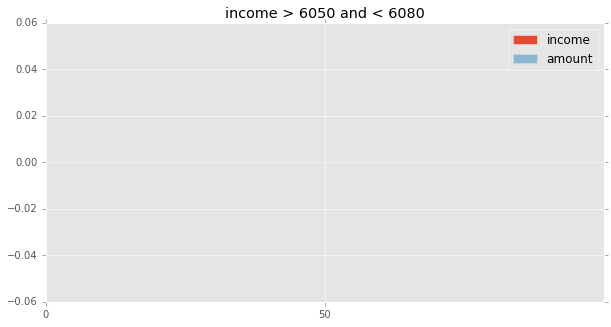



iteration 1
name 6080 to 6110
std 1971.58093819
mean 1876.0625
median 1050.0
max_mult 0.978196721311
med_mult 0.17238683912897693
min_mult 0.0122950819672
q98 5886.9
q02 82.5
q75 3125.0
q25 262.5
iqr 2862.5
min_q -4031.25
max_q 7418.75
count of loans 16
pct of total loans 0.00069371159114


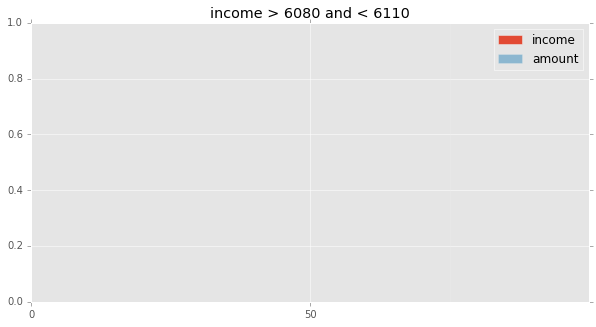



iteration 1
name 6110 to 6140
std 1349.37584618
mean 1601.41666667
median 1314.0
max_mult 0.783376963351
med_mult 0.2147058672757774
min_mult 0.0221823519817
q98 4438.64
q02 166.36
q75 2062.5
q25 612.5
iqr 1450.0
min_q -1562.5
max_q 4237.5
count of loans 13
pct of total loans 0.000563640667801


iteration 2
name 6110 to 6140
std 946.125476975
mean 1311.72727273
median 1313.0
max_mult 0.522363695723
med_mult 0.2146827992151733
min_mult 0.0221823519817
q98 3040.0
q02 163.6
q75 1725.0
q25 525.0
iqr 1200.0
min_q -1275.0
max_q 3525.0
count of loans 13
pct of total loans 0.000563640667801


iteration 3
name 6110 to 6140
std 946.125476975
mean 1311.72727273
median 1313.0
max_mult 0.522363695723
med_mult 0.2146827992151733
min_mult 0.0221823519817
q98 3040.0
q02 163.6
q75 1725.0
q25 525.0
iqr 1200.0
min_q -1275.0
max_q 3525.0
count of loans 13
pct of total loans 0.000563640667801


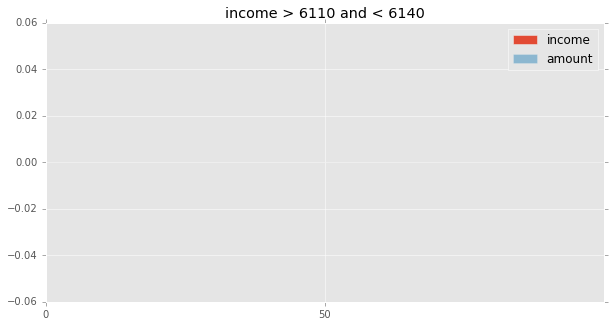



iteration 1
name 6140 to 6170
std 1684.50334916
mean 2352.75
median 1910.0
max_mult 0.812611734113
med_mult 0.3102833320682139
min_mult 0.0677497969131
q98 4940.0
q02 445.5
q75 4029.0
q25 950.0
iqr 3079.0
min_q -3668.5
max_q 8647.5
count of loans 16
pct of total loans 0.00069371159114


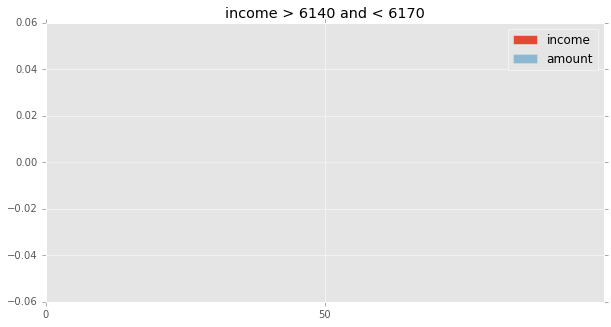



iteration 1
name 6170 to 6200
std 2298.65608915
mean 2168.23529412
median 1000.0
max_mult 1.16204002582
med_mult 0.16155088852988692
min_mult 0.00972132209981
q98 6816.0
q02 96.8
q75 4000.0
q25 388.0
iqr 3612.0
min_q -5030.0
max_q 9418.0
count of loans 17
pct of total loans 0.000737068565587


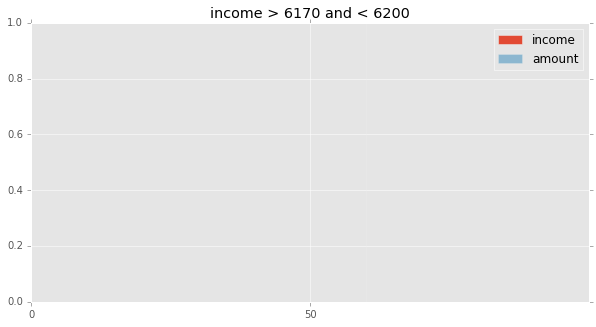



iteration 1
name 6200 to 6230
std 1306.08326322
mean 1342.23809524
median 1000.0
max_mult 0.805023345677
med_mult 0.16129032258064516
min_mult 0.01982272361
q98 4567.2
q02 155.4
q75 1671.0
q25 366.0
iqr 1305.0
min_q -1591.5
max_q 3628.5
count of loans 24
pct of total loans 0.00104056738671


iteration 2
name 6200 to 6230
std 818.474275925
mean 1014.15789474
median 1000.0
max_mult 0.483636949863
med_mult 0.1610305958132045
min_mult 0.01982272361
q98 2784.0
q02 152.16
q75 1485.0
q25 343.0
iqr 1142.0
min_q -1370.0
max_q 3198.0
count of loans 24
pct of total loans 0.00104056738671


iteration 3
name 6200 to 6230
std 818.474275925
mean 1014.15789474
median 1000.0
max_mult 0.483636949863
med_mult 0.1610305958132045
min_mult 0.01982272361
q98 2784.0
q02 152.16
q75 1485.0
q25 343.0
iqr 1142.0
min_q -1370.0
max_q 3198.0
count of loans 24
pct of total loans 0.00104056738671


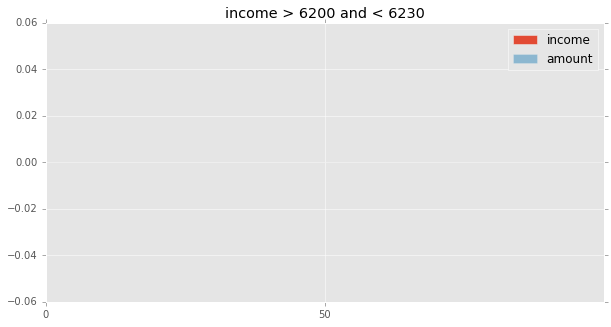



iteration 1
name 6230 to 6260
std 1836.85013852
mean 1728.41176471
median 645.5
max_mult 0.919871794872
med_mult 0.10345356545468742
min_mult 0.00479769710539
q98 5647.6
q02 46.5
q75 2967.5
q25 260.0
iqr 2707.5
min_q -3801.25
max_q 7028.75
count of loans 34
pct of total loans 0.00147413713117


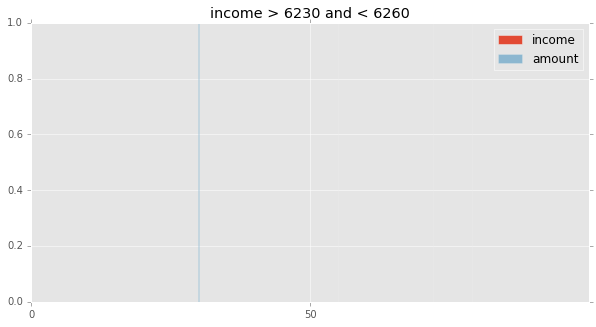



iteration 1
name 6260 to 6290
std 1363.68382058
mean 1430.6875
median 860.0
max_mult 0.678155417265
med_mult 0.13680995957598868
min_mult 0.0274628772154
q98 4205.0
q02 183.4
q75 2085.0
q25 368.75
iqr 1716.25
min_q -2205.625
max_q 4659.375
count of loans 18
pct of total loans 0.000780425540033


iteration 2
name 6260 to 6290
std 1363.68382058
mean 1430.6875
median 860.0
max_mult 0.678155417265
med_mult 0.13680995957598868
min_mult 0.0274628772154
q98 4205.0
q02 183.4
q75 2085.0
q25 368.75
iqr 1716.25
min_q -2205.625
max_q 4659.375
count of loans 18
pct of total loans 0.000780425540033


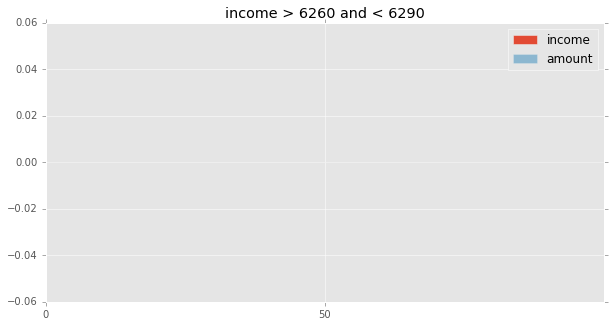



iteration 1
name 6290 to 6320
std 1463.58279916
mean 1740.88
median 1088.0
max_mult 0.905336721728
med_mult 0.1726984126984127
min_mult 0.0206349206349
q98 4884.0
q02 134.32
q75 3000.0
q25 590.0
iqr 2410.0
min_q -3025.0
max_q 6615.0
count of loans 25
pct of total loans 0.00108392436116


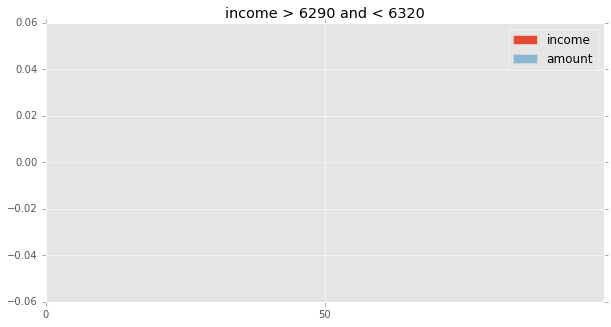



iteration 1
name 6320 to 6350
std 2066.28329629
mean 2443.85
median 1785.5
max_mult 1.26262626263
med_mult 0.28191630929073713
min_mult 0.0394508442481
q98 6940.56
q02 270.52
q75 3368.75
q25 919.25
iqr 2449.5
min_q -2755.0
max_q 7043.0
count of loans 21
pct of total loans 0.000910496463372


iteration 2
name 6320 to 6350
std 1643.59742015
mean 2151.42105263
median 1571.0
max_mult 0.824683544304
med_mult 0.2480265235238396
min_mult 0.0394508442481
q98 5135.68
q02 269.44
q75 3037.5
q25 838.5
iqr 2199.0
min_q -2460.0
max_q 6336.0
count of loans 21
pct of total loans 0.000910496463372


iteration 3
name 6320 to 6350
std 1643.59742015
mean 2151.42105263
median 1571.0
max_mult 0.824683544304
med_mult 0.2480265235238396
min_mult 0.0394508442481
q98 5135.68
q02 269.44
q75 3037.5
q25 838.5
iqr 2199.0
min_q -2460.0
max_q 6336.0
count of loans 21
pct of total loans 0.000910496463372


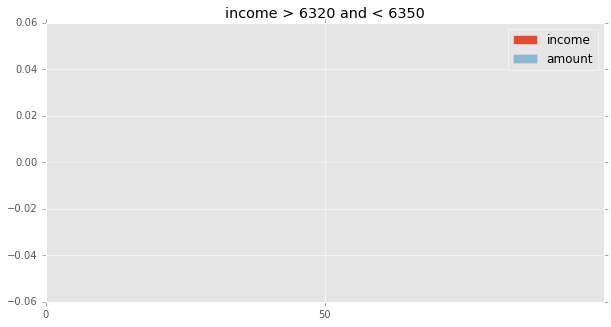



iteration 1
name 6350 to 6380
std 1701.58458223
mean 1530.23809524
median 1000.0
max_mult 0.943692985215
med_mult 0.1574307304785894
min_mult 0.01257268584
q98 6000.0
q02 148.0
q75 1518.0
q25 400.0
iqr 1118.0
min_q -1277.0
max_q 3195.0
count of loans 24
pct of total loans 0.00104056738671


iteration 2
name 6350 to 6380
std 873.82307147
mean 1059.73684211
median 1000.0
max_mult 0.471698113208
med_mult 0.1568627450980392
min_mult 0.01257268584
q98 3000.0
q02 141.2
q75 1400.0
q25 366.5
iqr 1033.5
min_q -1183.75
max_q 2950.25
count of loans 24
pct of total loans 0.00104056738671


iteration 3
name 6350 to 6380
std 577.124674317
mean 831.470588235
median 657.0
max_mult 0.350904799371
med_mult 0.10330188679245284
min_mult 0.01257268584
q98 2002.16
q02 134.4
q75 1088.0
q25 333.0
iqr 755.0
min_q -799.5
max_q 2220.5
count of loans 24
pct of total loans 0.00104056738671


iteration 4
name 6350 to 6380
std 465.54906204
mean 744.0625
median 642.5
max_mult 0.238379396985
med_mult 0.1010220125786

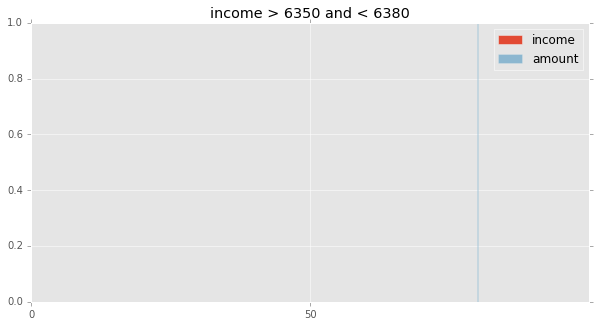



iteration 1
name 6380 to 6410
std 832.996049391
mean 1689.77777778
median 1780.0
max_mult 0.469336670839
med_mult 0.27871001148885904
min_mult 0.079375
q98 3000.0
q02 527.72
q75 2332.5
q25 962.5
iqr 1370.0
min_q -1092.5
max_q 4387.5
count of loans 21
pct of total loans 0.000910496463372


iteration 2
name 6380 to 6410
std 832.996049391
mean 1689.77777778
median 1780.0
max_mult 0.469336670839
med_mult 0.27871001148885904
min_mult 0.079375
q98 3000.0
q02 527.72
q75 2332.5
q25 962.5
iqr 1370.0
min_q -1092.5
max_q 4387.5
count of loans 21
pct of total loans 0.000910496463372


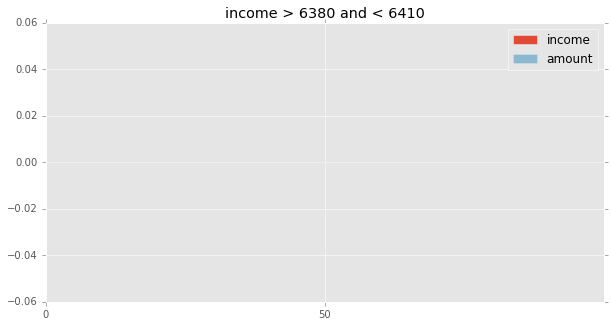



iteration 1
name 6410 to 6440
std 956.142002616
mean 1221.9375
median 1112.5
max_mult 0.555469114672
med_mult 0.1732434065633461
min_mult 0.0222222222222
q98 3249.0
q02 153.5
q75 1742.0
q25 374.0
iqr 1368.0
min_q -1678.0
max_q 3794.0
count of loans 19
pct of total loans 0.000823782514479


iteration 2
name 6410 to 6440
std 956.142002616
mean 1221.9375
median 1112.5
max_mult 0.555469114672
med_mult 0.1732434065633461
min_mult 0.0222222222222
q98 3249.0
q02 153.5
q75 1742.0
q25 374.0
iqr 1368.0
min_q -1678.0
max_q 3794.0
count of loans 19
pct of total loans 0.000823782514479


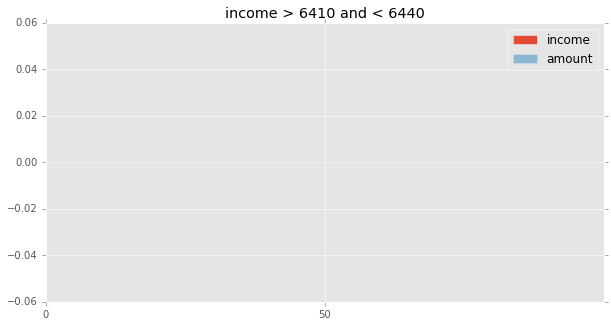



iteration 1
name 6440 to 6470
std 1444.06703446
mean 1762.0
median 1455.5
max_mult 0.6564873663
med_mult 0.2254703190428355
min_mult 0.0332508506032
q98 4059.0
q02 267.1
q75 2292.75
q25 843.25
iqr 1449.5
min_q -1331.0
max_q 4467.0
count of loans 6
pct of total loans 0.000260141846678


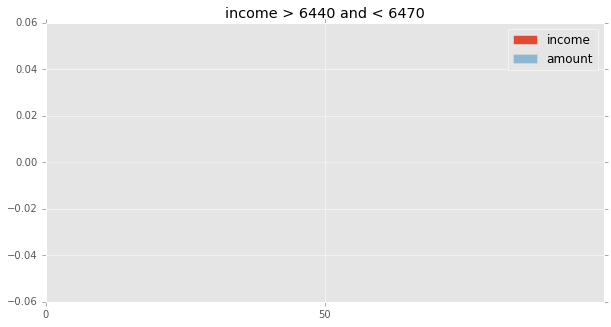



iteration 1
name 6470 to 6500
std 896.689608809
mean 1198.36363636
median 1100.0
max_mult 0.482225656878
med_mult 0.16980549552330967
min_mult 0.0289899768697
q98 2896.0
q02 198.2
q75 1699.0
q25 498.0
iqr 1201.0
min_q -1303.5
max_q 3500.5
count of loans 13
pct of total loans 0.000563640667801


iteration 2
name 6470 to 6500
std 896.689608809
mean 1198.36363636
median 1100.0
max_mult 0.482225656878
med_mult 0.16980549552330967
min_mult 0.0289899768697
q98 2896.0
q02 198.2
q75 1699.0
q25 498.0
iqr 1201.0
min_q -1303.5
max_q 3500.5
count of loans 13
pct of total loans 0.000563640667801


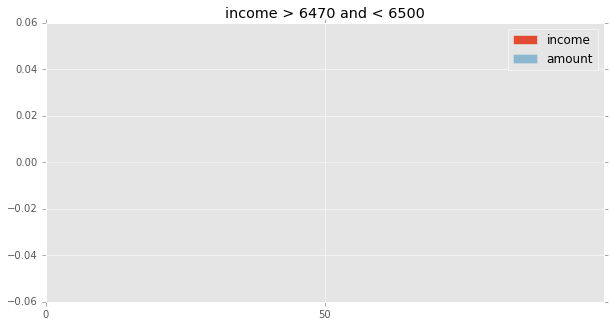



iteration 1
name 6500 to 6530
std 1687.24469308
mean 1777.68421053
median 1395.5
max_mult 1.00491325042
med_mult 0.21430123095788334
min_mult 0.00692307692308
q98 6141.7
q02 49.44
q75 2655.0
q25 371.25
iqr 2283.75
min_q -3054.375
max_q 6080.625
count of loans 40
pct of total loans 0.00173427897785


iteration 2
name 6500 to 6530
std 1509.13745625
mean 1648.83783784
median 1382.0
max_mult 0.921517432038
med_mult 0.21183323114653588
min_mult 0.00692307692308
q98 5280.0
q02 49.32
q75 2100.0
q25 360.0
iqr 1740.0
min_q -2250.0
max_q 4710.0
count of loans 40
pct of total loans 0.00173427897785


iteration 3
name 6500 to 6530
std 1071.76049217
mean 1327.41176471
median 1132.5
max_mult 0.614615384615
med_mult 0.17348345588235292
min_mult 0.00692307692308
q98 3338.3
q02 48.96
q75 1988.0
q25 323.25
iqr 1664.75
min_q -2173.875
max_q 4485.125
count of loans 40
pct of total loans 0.00173427897785


iteration 4
name 6500 to 6530
std 1071.76049217
mean 1327.41176471
median 1132.5
max_mult 0.6146153

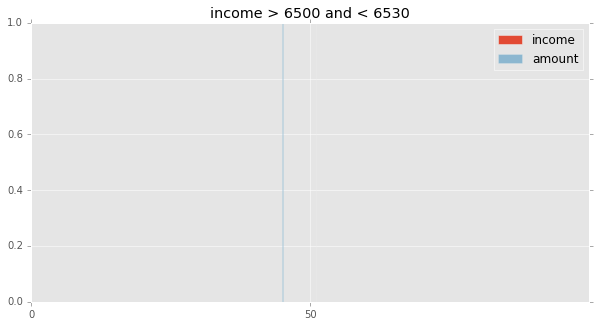



iteration 1
name 6530 to 6560
std 744.367883342
mean 1006.38888889
median 939.5
max_mult 0.378337147216
med_mult 0.14344388133452335
min_mult 0.0236749656331
q98 2392.96
q02 157.38
q75 1575.0
q25 282.5
iqr 1292.5
min_q -1656.25
max_q 3513.75
count of loans 21
pct of total loans 0.000910496463372


iteration 2
name 6530 to 6560
std 744.367883342
mean 1006.38888889
median 939.5
max_mult 0.378337147216
med_mult 0.14344388133452335
min_mult 0.0236749656331
q98 2392.96
q02 157.38
q75 1575.0
q25 282.5
iqr 1292.5
min_q -1656.25
max_q 3513.75
count of loans 21
pct of total loans 0.000910496463372


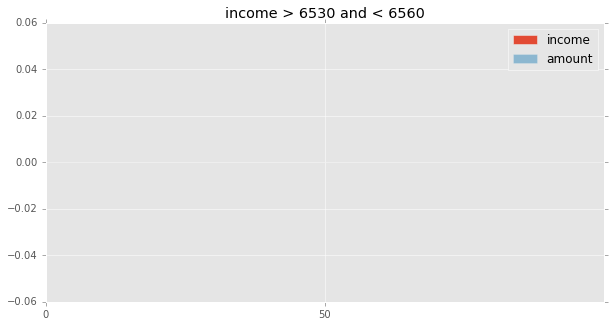



iteration 1
name 6560 to 6590
std 1534.35181754
mean 1516.33333333
median 950.0
max_mult 0.760225026608
med_mult 0.14479500076207896
min_mult 0.0461585180686
q98 4648.0
q02 305.44
q75 1880.0
q25 500.0
iqr 1380.0
min_q -1570.0
max_q 3950.0
count of loans 10
pct of total loans 0.000433569744463


iteration 2
name 6560 to 6590
std 860.312142273
mean 1080.875
median 925.0
max_mult 0.424950675368
med_mult 0.14097415384035067
min_mult 0.0461585180686
q98 2671.2
q02 305.26
q75 1220.0
q25 453.25
iqr 766.75
min_q -696.875
max_q 2370.125
count of loans 10
pct of total loans 0.000433569744463


iteration 3
name 6560 to 6590
std 548.234960057
mean 835.285714286
median 900.0
max_mult 0.286192723398
med_mult 0.13715330691862238
min_mult 0.0461585180686
q98 1774.4
q02 305.08
q75 975.0
q25 406.5
iqr 568.5
min_q -446.25
max_q 1827.75
count of loans 10
pct of total loans 0.000433569744463


iteration 4
name 6560 to 6590
std 325.587724994
mean 661.166666667
median 700.0
max_mult 0.152346130408
med_mult

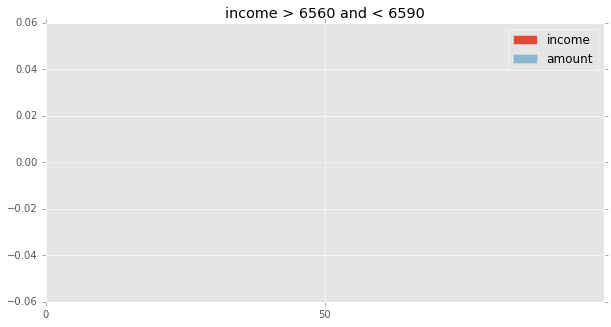



iteration 1
name 6590 to 6620
std 1698.29516661
mean 1688.62962963
median 1000.0
max_mult 0.909090909091
med_mult 0.1516300227445034
min_mult 0.0181323662738
q98 5790.44
q02 166.8
q75 1794.0
q25 528.0
iqr 1266.0
min_q -1371.0
max_q 3693.0
count of loans 30
pct of total loans 0.00130070923339


iteration 2
name 6590 to 6620
std 723.961617025
mean 1054.17391304
median 1000.0
max_mult 0.454545454545
med_mult 0.15142337976983647
min_mult 0.0181323662738
q98 2780.0
q02 159.6
q75 1422.0
q25 458.5
iqr 963.5
min_q -986.75
max_q 2867.25
count of loans 30
pct of total loans 0.00130070923339


iteration 3
name 6590 to 6620
std 600.488228489
mean 965.727272727
median 1000.0
max_mult 0.379305113033
med_mult 0.15129747975642238
min_mult 0.0181323662738
q98 2221.96
q02 157.8
q75 1340.0
q25 437.75
iqr 902.25
min_q -915.625
max_q 2693.375
count of loans 30
pct of total loans 0.00130070923339


iteration 4
name 6590 to 6620
std 600.488228489
mean 965.727272727
median 1000.0
max_mult 0.379305113033
med

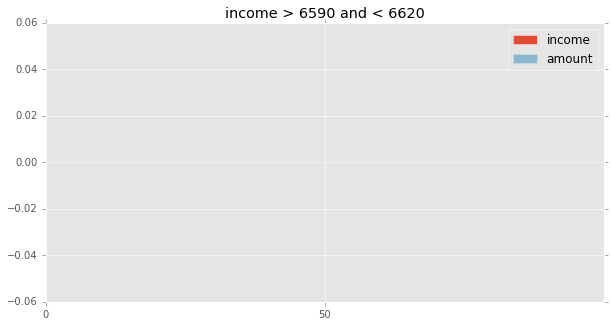



iteration 1
name 6620 to 6650
std 1616.1522797
mean 2174.76470588
median 1760.0
max_mult 0.870719565545
med_mult 0.2655401327700664
min_mult 0.00678733031674
q98 5468.96
q02 186.76
q75 3025.0
q25 863.0
iqr 2162.0
min_q -2380.0
max_q 6268.0
count of loans 17
pct of total loans 0.000737068565587


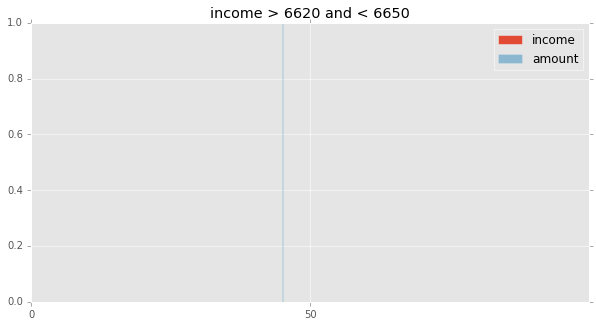



iteration 1
name 6650 to 6680
std 1662.26378144
mean 2378.05555556
median 1840.0
max_mult 0.89928057554
med_mult 0.2759404376166771
min_mult 0.0689965501725
q98 5660.0
q02 462.72
q75 3284.0
q25 1100.0
iqr 2184.0
min_q -2176.0
max_q 6560.0
count of loans 19
pct of total loans 0.000823782514479


iteration 2
name 6650 to 6680
std 1662.26378144
mean 2378.05555556
median 1840.0
max_mult 0.89928057554
med_mult 0.2759404376166771
min_mult 0.0689965501725
q98 5660.0
q02 462.72
q75 3284.0
q25 1100.0
iqr 2184.0
min_q -2176.0
max_q 6560.0
count of loans 19
pct of total loans 0.000823782514479


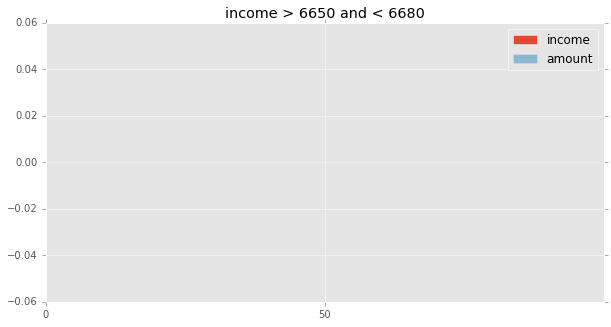



iteration 1
name 6680 to 6710
std 1183.18474212
mean 1780.38888889
median 1548.5
max_mult 0.751941457587
med_mult 0.2310359552239557
min_mult 0.0149387511204
q98 4394.1
q02 175.48
q75 2457.0
q25 955.75
iqr 1501.25
min_q -1296.125
max_q 4708.875
count of loans 21
pct of total loans 0.000910496463372


iteration 2
name 6680 to 6710
std 886.818856263
mean 1588.94117647
median 1522.0
max_mult 0.470219435737
med_mult 0.22692709109885195
min_mult 0.0149387511204
q98 3102.0
q02 171.04
q75 2328.0
q25 941.0
iqr 1387.0
min_q -1139.5
max_q 4408.5
count of loans 21
pct of total loans 0.000910496463372


iteration 3
name 6680 to 6710
std 886.818856263
mean 1588.94117647
median 1522.0
max_mult 0.470219435737
med_mult 0.22692709109885195
min_mult 0.0149387511204
q98 3102.0
q02 171.04
q75 2328.0
q25 941.0
iqr 1387.0
min_q -1139.5
max_q 4408.5
count of loans 21
pct of total loans 0.000910496463372


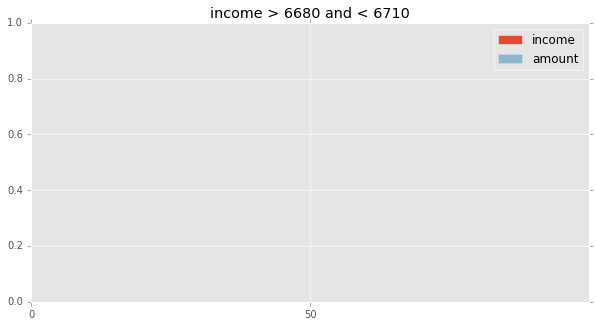



iteration 1
name 6710 to 6740
std 1171.52407334
mean 1485.82352941
median 1100.0
max_mult 0.594088816278
med_mult 0.16381236038719285
min_mult 0.00745045447772
q98 3780.8
q02 59.6
q75 2328.0
q25 440.0
iqr 1888.0
min_q -2392.0
max_q 5160.0
count of loans 17
pct of total loans 0.000737068565587


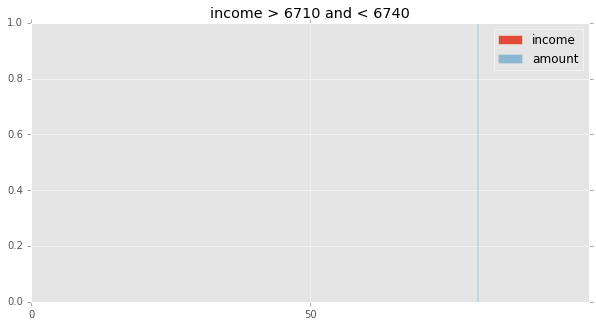



iteration 1
name 6740 to 6770
std 2877.34425653
mean 3048.70588235
median 2113.0
max_mult 1.37736966825
med_mult 0.31303703703703706
min_mult 0.0219226781218
q98 8827.36
q02 203.04
q75 5000.0
q25 625.0
iqr 4375.0
min_q -5937.5
max_q 11562.5
count of loans 17
pct of total loans 0.000737068565587


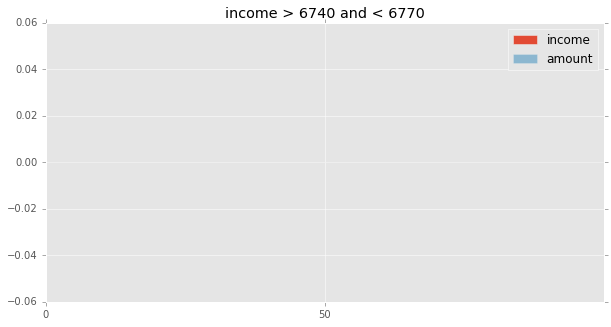



iteration 1
name 6770 to 6800
std 615.554409268
mean 827.307692308
median 750.0
max_mult 0.335199646383
med_mult 0.11071744906997343
min_mult 0.00735835172921
q98 2102.68
q02 92.48
q75 903.0
q25 400.0
iqr 503.0
min_q -354.5
max_q 1657.5
count of loans 15
pct of total loans 0.000650354616694


iteration 2
name 6770 to 6800
std 454.914843846
mean 706.666666667
median 669.0
max_mult 0.229409164579
med_mult 0.0987535584833262
min_mult 0.00735835172921
q98 1533.46
q02 88.94
q75 863.25
q25 381.25
iqr 482.0
min_q -341.75
max_q 1586.25
count of loans 15
pct of total loans 0.000650354616694


iteration 3
name 6770 to 6800
std 454.914843846
mean 706.666666667
median 669.0
max_mult 0.229409164579
med_mult 0.0987535584833262
min_mult 0.00735835172921
q98 1533.46
q02 88.94
q75 863.25
q25 381.25
iqr 482.0
min_q -341.75
max_q 1586.25
count of loans 15
pct of total loans 0.000650354616694


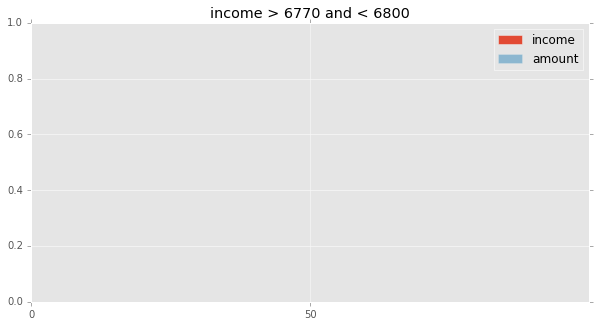



iteration 1
name 6800 to 6830
std 1551.97338563
mean 1579.47058824
median 1000.0
max_mult 0.736672524897
med_mult 0.1467136150234742
min_mult 0.00835164835165
q98 5020.4
q02 102.76
q75 2500.0
q25 373.0
iqr 2127.0
min_q -2817.5
max_q 5690.5
count of loans 17
pct of total loans 0.000737068565587


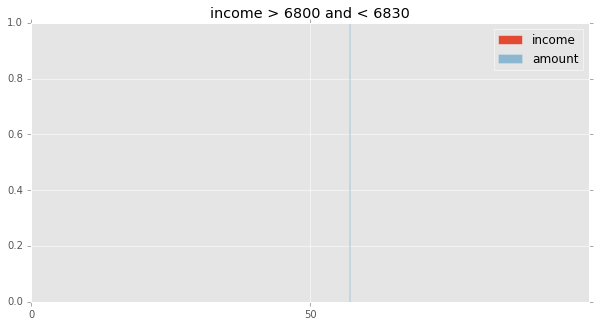



iteration 1
name 6830 to 6860
std 1670.77418092
mean 2168.18181818
median 1730.0
max_mult 0.731207955543
med_mult 0.25307197191339964
min_mult 0.0204948031035
q98 4845.0
q02 146.0
q75 3287.5
q25 992.5
iqr 2295.0
min_q -2450.0
max_q 6730.0
count of loans 11
pct of total loans 0.000476926718909


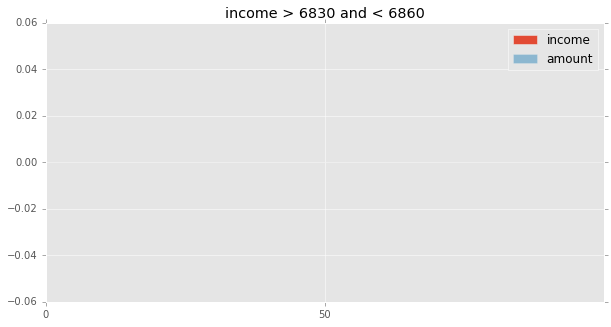



iteration 1
name 6860 to 6890
std 428.286560352
mean 649.6
median 737.0
max_mult 0.171287559878
med_mult 0.1072
min_mult 0.00728756741
q98 1165.6
q02 81.5
q75 999.75
q25 231.0
iqr 768.75
min_q -922.125
max_q 2152.875
count of loans 11
pct of total loans 0.000476926718909


iteration 2
name 6860 to 6890
std 428.286560352
mean 649.6
median 737.0
max_mult 0.171287559878
med_mult 0.1072
min_mult 0.00728756741
q98 1165.6
q02 81.5
q75 999.75
q25 231.0
iqr 768.75
min_q -922.125
max_q 2152.875
count of loans 11
pct of total loans 0.000476926718909


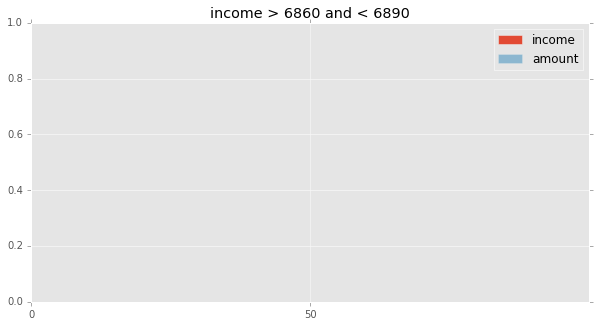



iteration 1
name 6890 to 6920
std 4000.08438988
mean 3551.38461538
median 1287.5
max_mult 2.03904555315
med_mult 0.18635377446450985
min_mult 0.0123010130246
q98 11950.0
q02 106.5
q75 5974.0
q25 410.0
iqr 5564.0
min_q -7936.0
max_q 14320.0
count of loans 26
pct of total loans 0.0011272813356


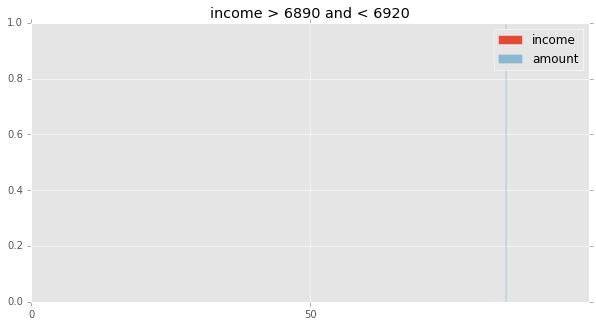



iteration 1
name 6920 to 6950
std 1491.48751745
mean 1436.47058824
median 800.0
max_mult 0.75299034443
med_mult 0.11544011544011544
min_mult 0.00546841272125
q98 4712.36
q02 74.8
q75 2068.0
q25 260.0
iqr 1808.0
min_q -2452.0
max_q 4780.0
count of loans 19
pct of total loans 0.000823782514479


iteration 2
name 6920 to 6950
std 1164.54699168
mean 1199.6875
median 765.5
max_mult 0.522648586267
med_mult 0.11037059070766936
min_mult 0.00546841272125
q98 3568.1
q02 72.5
q75 2017.0
q25 255.0
iqr 1762.0
min_q -2388.0
max_q 4660.0
count of loans 19
pct of total loans 0.000823782514479


iteration 3
name 6920 to 6950
std 1164.54699168
mean 1199.6875
median 765.5
max_mult 0.522648586267
med_mult 0.11037059070766936
min_mult 0.00546841272125
q98 3568.1
q02 72.5
q75 2017.0
q25 255.0
iqr 1762.0
min_q -2388.0
max_q 4660.0
count of loans 19
pct of total loans 0.000823782514479


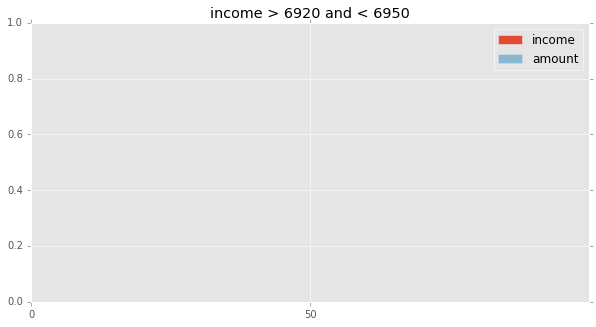



iteration 1
name 6950 to 6980
std 791.269639792
mean 890.25
median 709.0
max_mult 0.352213916044
med_mult 0.10195393369394087
min_mult 0.0143513203215
q98 2317.0
q02 114.7
q75 1152.0
q25 361.0
iqr 791.0
min_q -825.5
max_q 2338.5
count of loans 10
pct of total loans 0.000433569744463


iteration 2
name 6950 to 6980
std 516.782951584
mean 667.428571429
median 418.0
max_mult 0.215703192407
med_mult 0.06002297530155083
min_mult 0.0143513203215
q98 1444.32
q02 112.6
q75 1018.0
q25 309.0
iqr 709.0
min_q -754.5
max_q 2081.5
count of loans 10
pct of total loans 0.000433569744463


iteration 3
name 6950 to 6980
std 516.782951584
mean 667.428571429
median 418.0
max_mult 0.215703192407
med_mult 0.06002297530155083
min_mult 0.0143513203215
q98 1444.32
q02 112.6
q75 1018.0
q25 309.0
iqr 709.0
min_q -754.5
max_q 2081.5
count of loans 10
pct of total loans 0.000433569744463


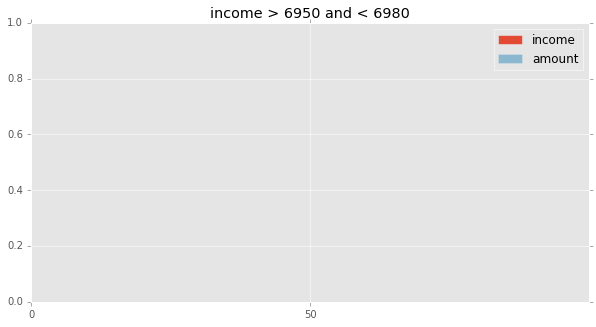



iteration 1
name 6980 to 7010
std 1352.89918206
mean 1704.375
median 1347.5
max_mult 0.789939982852
med_mult 0.1925
min_mult 0.0155714285714
q98 5031.68
q02 200.18
q75 2800.0
q25 568.0
iqr 2232.0
min_q -2780.0
max_q 6148.0
count of loans 50
pct of total loans 0.00216784872231


iteration 2
name 6980 to 7010
std 1352.89918206
mean 1704.375
median 1347.5
max_mult 0.789939982852
med_mult 0.1925
min_mult 0.0155714285714
q98 5031.68
q02 200.18
q75 2800.0
q25 568.0
iqr 2232.0
min_q -2780.0
max_q 6148.0
count of loans 50
pct of total loans 0.00216784872231


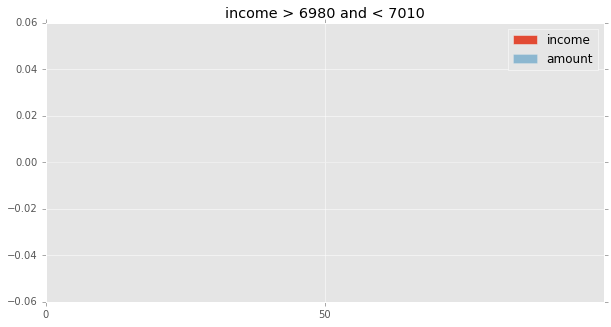



iteration 1
name 7010 to 7040
std 2478.70717146
mean 2450.77777778
median 1374.0
max_mult 1.2846975089
med_mult 0.19564541994820878
min_mult 0.0273777270783
q98 8166.5
q02 262.72
q75 3998.0
q25 544.75
iqr 3453.25
min_q -4635.125
max_q 9177.875
count of loans 18
pct of total loans 0.000780425540033


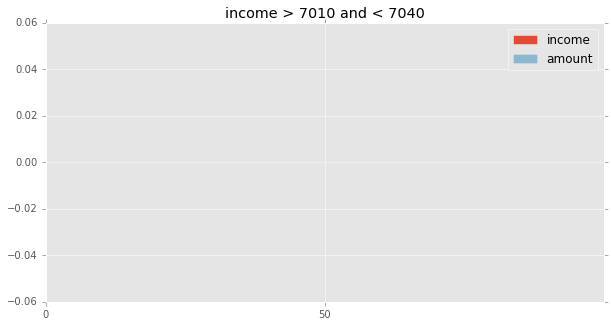



iteration 1
name 7040 to 7070
std 3380.01151995
mean 3459.0
median 1733.0
max_mult 1.41602945341
med_mult 0.24529370134465675
min_mult 0.021502334135
q98 9980.8
q02 166.4
q75 5200.0
q25 1260.0
iqr 3940.0
min_q -4650.0
max_q 11110.0
count of loans 17
pct of total loans 0.000737068565587


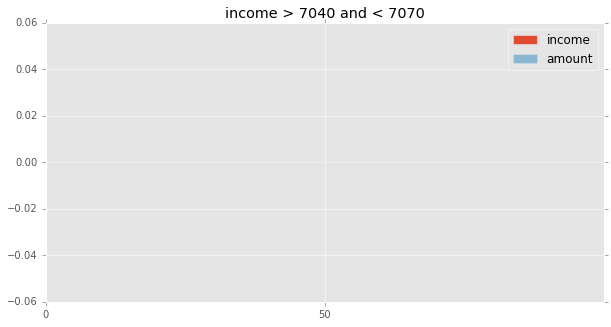



iteration 1
name 7070 to 7100
std 1215.98865021
mean 1970.30769231
median 2000.0
max_mult 0.591799351839
med_mult 0.2824858757062147
min_mult 0.0161199095023
q98 4056.0
q02 170.88
q75 3000.0
q25 1338.0
iqr 1662.0
min_q -1155.0
max_q 5493.0
count of loans 14
pct of total loans 0.000606997642248


iteration 2
name 7070 to 7100
std 1215.98865021
mean 1970.30769231
median 2000.0
max_mult 0.591799351839
med_mult 0.2824858757062147
min_mult 0.0161199095023
q98 4056.0
q02 170.88
q75 3000.0
q25 1338.0
iqr 1662.0
min_q -1155.0
max_q 5493.0
count of loans 14
pct of total loans 0.000606997642248


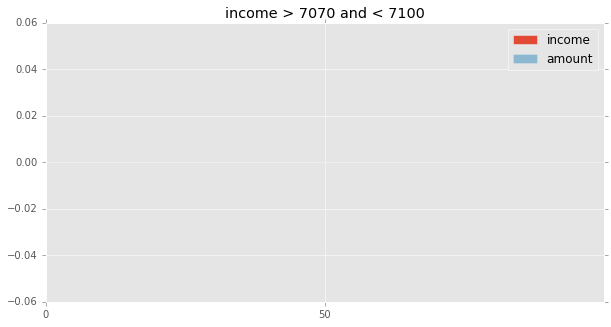



iteration 1
name 7100 to 7130
std 2001.72479153
mean 2184.15384615
median 1320.0
max_mult 0.913177858949
med_mult 0.18588931136459655
min_mult 0.012676056338
q98 6164.0
q02 121.2
q75 3673.0
q25 990.0
iqr 2683.0
min_q -3034.5
max_q 7697.5
count of loans 13
pct of total loans 0.000563640667801


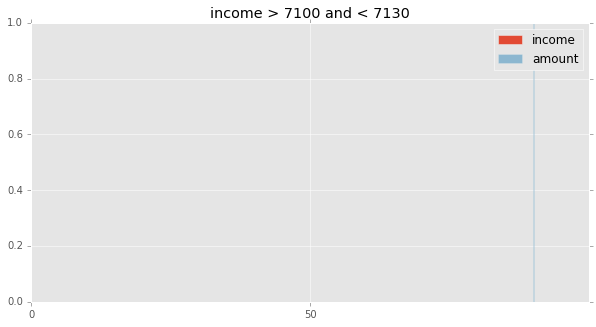



iteration 1
name 7130 to 7160
std 2033.98389785
mean 2719.44444444
median 2000.0
max_mult 0.945643037265
med_mult 0.2797010279408829
min_mult 0.0417776531614
q98 6325.0
q02 400.68
q75 4890.0
q25 1051.25
iqr 3838.75
min_q -4706.875
max_q 10648.125
count of loans 18
pct of total loans 0.000780425540033


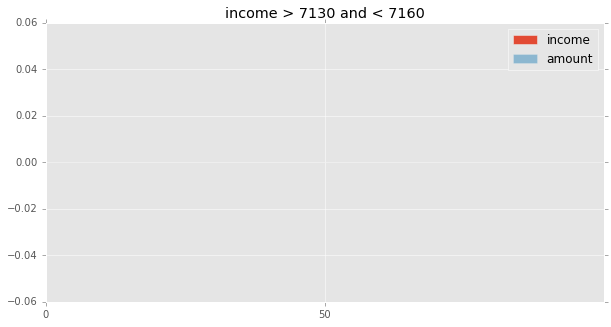



iteration 1
name 7160 to 7190
std 1121.60788603
mean 1072.66666667
median 780.0
max_mult 0.508025122121
med_mult 0.10869565217391304
min_mult 0.0187046342825
q98 3377.6
q02 140.72
q75 1100.0
q25 280.0
iqr 820.0
min_q -950.0
max_q 2330.0
count of loans 10
pct of total loans 0.000433569744463


iteration 2
name 7160 to 7190
std 615.157761415
mean 751.75
median 712.5
max_mult 0.278318953521
med_mult 0.09932063322682544
min_mult 0.0187046342825
q98 1874.0
q02 139.88
q75 949.25
q25 254.0
iqr 695.25
min_q -788.875
max_q 1992.125
count of loans 10
pct of total loans 0.000433569744463


iteration 3
name 7160 to 7190
std 380.397974558
mean 573.428571429
median 645.0
max_mult 0.153011545417
med_mult 0.08994561427973784
min_mult 0.0187046342825
q98 1075.88
q02 139.04
q75 839.5
q25 228.0
iqr 611.5
min_q -689.25
max_q 1756.75
count of loans 10
pct of total loans 0.000433569744463


iteration 4
name 7160 to 7190
std 380.397974558
mean 573.428571429
median 645.0
max_mult 0.153011545417
med_mult 0.0

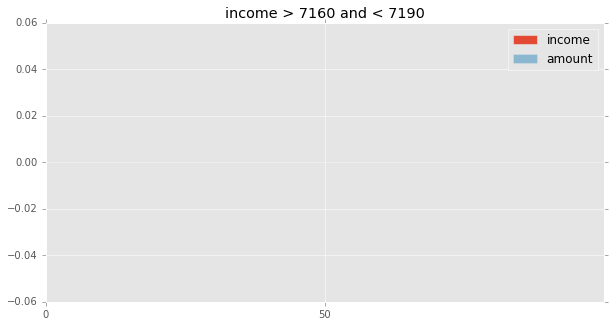



iteration 1
name 7190 to 7220
std 1967.60532545
mean 2392.15625
median 1997.5
max_mult 0.984743411928
med_mult 0.27743055555555557
min_mult 0.00805555555556
q98 7038.0
q02 86.52
q75 3517.5
q25 843.75
iqr 2673.75
min_q -3166.875
max_q 7528.125
count of loans 34
pct of total loans 0.00147413713117


iteration 2
name 7190 to 7220
std 1967.60532545
mean 2392.15625
median 1997.5
max_mult 0.984743411928
med_mult 0.27743055555555557
min_mult 0.00805555555556
q98 7038.0
q02 86.52
q75 3517.5
q25 843.75
iqr 2673.75
min_q -3166.875
max_q 7528.125
count of loans 34
pct of total loans 0.00147413713117


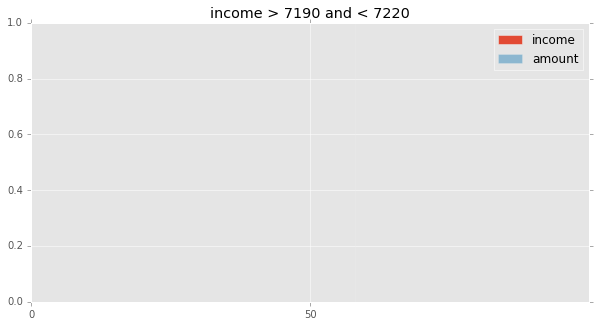



iteration 1
name 7220 to 7250
std 998.531972448
mean 1021.1
median 813.5
max_mult 0.504210962308
med_mult 0.11253259760528633
min_mult 0.0248997095034
q98 3239.44
q02 188.1
q75 1075.0
q25 475.25
iqr 599.75
min_q -424.375
max_q 1974.625
count of loans 12
pct of total loans 0.000520283693355


iteration 2
name 7220 to 7250
std 400.451238535
mean 728.777777778
median 800.0
max_mult 0.187637969095
med_mult 0.11068068622025456
min_mult 0.0248997095034
q98 1318.4
q02 187.2
q75 1000.0
q25 417.0
iqr 583.0
min_q -457.5
max_q 1874.5
count of loans 12
pct of total loans 0.000520283693355


iteration 3
name 7220 to 7250
std 400.451238535
mean 728.777777778
median 800.0
max_mult 0.187637969095
med_mult 0.11068068622025456
min_mult 0.0248997095034
q98 1318.4
q02 187.2
q75 1000.0
q25 417.0
iqr 583.0
min_q -457.5
max_q 1874.5
count of loans 12
pct of total loans 0.000520283693355


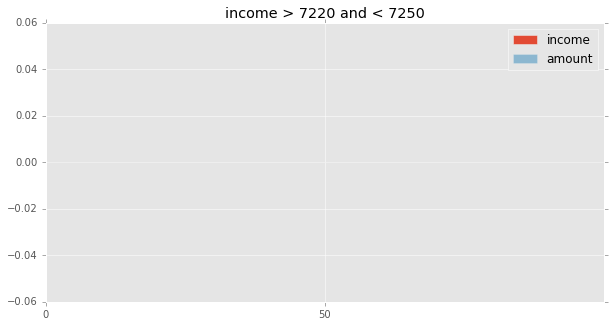



iteration 1
name 7250 to 7280
std 1924.51828211
mean 2179.27272727
median 1320.0
max_mult 0.862068965517
med_mult 0.1820689655172414
min_mult 0.0269304754053
q98 5860.0
q02 276.8
q75 3325.0
q25 705.0
iqr 2620.0
min_q -3225.0
max_q 7255.0
count of loans 11
pct of total loans 0.000476926718909


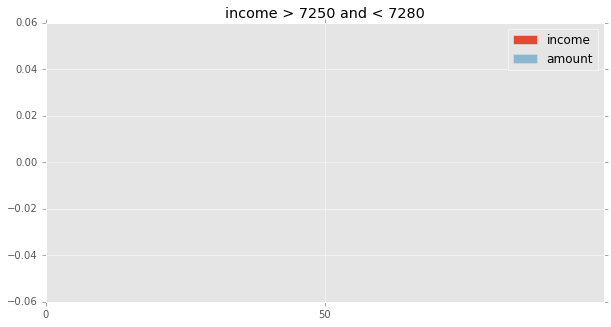



iteration 1
name 7280 to 7310
std 447.883677855
mean 491.7
median 259.5
max_mult 0.17704200301
med_mult 0.035623844164339294
min_mult 0.0130494505495
q98 1259.08
q02 99.5
q75 812.0
q25 144.75
iqr 667.25
min_q -856.125
max_q 1812.875
count of loans 13
pct of total loans 0.000563640667801


iteration 2
name 7280 to 7310
std 447.883677855
mean 491.7
median 259.5
max_mult 0.17704200301
med_mult 0.035623844164339294
min_mult 0.0130494505495
q98 1259.08
q02 99.5
q75 812.0
q25 144.75
iqr 667.25
min_q -856.125
max_q 1812.875
count of loans 13
pct of total loans 0.000563640667801


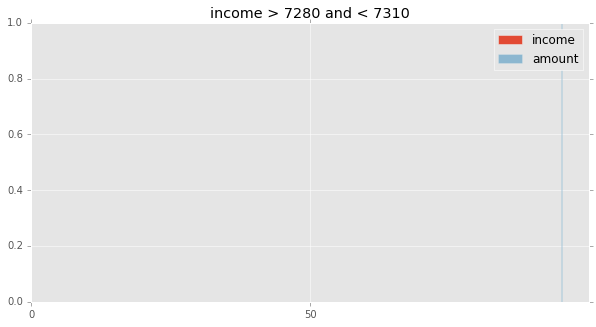



iteration 1
name 7310 to 7340
std 2455.33253575
mean 1834.88888889
median 417.0
max_mult 0.885799945489
med_mult 0.056881735097531035
min_mult 0.0241770249966
q98 6348.0
q02 180.68
q75 2000.0
q25 270.0
iqr 1730.0
min_q -2325.0
max_q 4595.0
count of loans 10
pct of total loans 0.000433569744463


iteration 2
name 7310 to 7340
std 662.238807452
mean 637.714285714
median 400.0
max_mult 0.272516691647
med_mult 0.05471207769115032
min_mult 0.0241770249966
q98 1880.0
q02 179.76
q75 708.5
q25 235.0
iqr 473.5
min_q -475.25
max_q 1418.75
count of loans 10
pct of total loans 0.000433569744463


iteration 3
name 7310 to 7340
std 305.363826716
mean 410.666666667
median 335.0
max_mult 0.136742786818
med_mult 0.04575091553177219
min_mult 0.0241770249966
q98 941.7
q02 179.3
q75 412.75
q25 217.5
iqr 195.25
min_q -75.375
max_q 705.625
count of loans 10
pct of total loans 0.000433569744463


iteration 4
name 7310 to 7340
std 111.196672612
mean 292.8
median 270.0
max_mult 0.0568817350975
med_mult 0.036

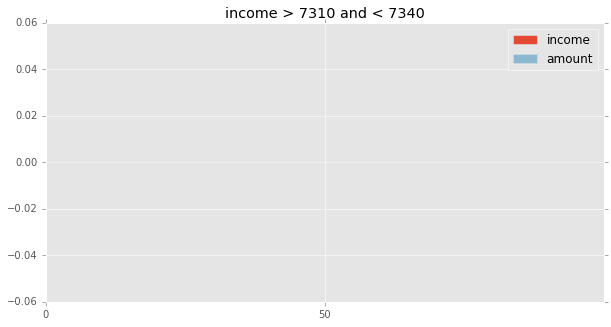



iteration 1
name 7340 to 7370
std 1004.80296576
mean 1839.0
median 2000.0
max_mult 0.488798370672
med_mult 0.27192386131883073
min_mult 0.0252717391304
q98 3424.0
q02 322.64
q75 2500.0
q25 1275.0
iqr 1225.0
min_q -562.5
max_q 4337.5
count of loans 10
pct of total loans 0.000433569744463


iteration 2
name 7340 to 7370
std 1004.80296576
mean 1839.0
median 2000.0
max_mult 0.488798370672
med_mult 0.27192386131883073
min_mult 0.0252717391304
q98 3424.0
q02 322.64
q75 2500.0
q25 1275.0
iqr 1225.0
min_q -562.5
max_q 4337.5
count of loans 10
pct of total loans 0.000433569744463


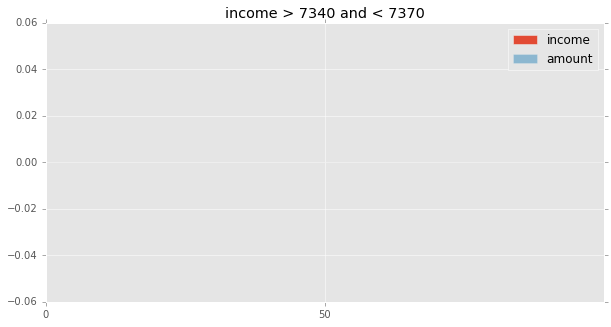



iteration 1
name 7370 to 7400
std 1471.01907231
mean 1683.88888889
median 1100.0
max_mult 0.61553030303
med_mult 0.14917276918904257
min_mult 0.0205850487541
q98 4398.0
q02 192.16
q75 2000.0
q25 1000.0
iqr 1000.0
min_q -500.0
max_q 3500.0
count of loans 10
pct of total loans 0.000433569744463


iteration 2
name 7370 to 7400
std 599.723468021
mean 1000.71428571
median 1100.0
max_mult 0.270855904659
med_mult 0.14893040888166803
min_mult 0.0205850487541
q98 1910.0
q02 182.12
q75 1175.0
q25 701.5
iqr 473.5
min_q -8.75
max_q 1885.25
count of loans 10
pct of total loans 0.000433569744463


iteration 3
name 7370 to 7400
std 445.647581242
mean 834.166666667
median 1050.0
max_mult 0.169262017603
med_mult 0.142307809596872
min_mult 0.0205850487541
q98 1235.0
q02 177.1
q75 1100.0
q25 552.25
iqr 547.75
min_q -269.375
max_q 1921.625
count of loans 10
pct of total loans 0.000433569744463


iteration 4
name 7370 to 7400
std 445.647581242
mean 834.166666667
median 1050.0
max_mult 0.169262017603
med_

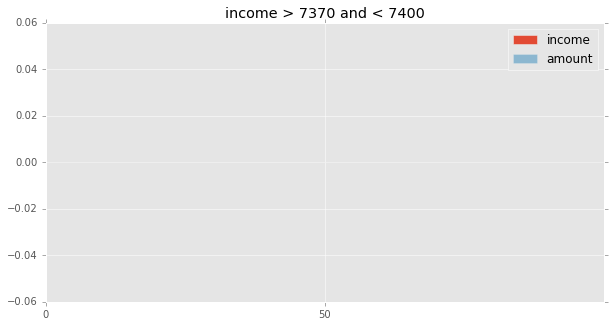



iteration 1
name 7400 to 7430
std 3348.74571135
mean 3433.125
median 3008.0
max_mult 1.18243243243
med_mult 0.4053362080582132
min_mult 0.0156672069152
q98 8537.62
q02 122.02
q75 5558.25
q25 183.0
iqr 5375.25
min_q -7879.875
max_q 13621.125
count of loans 8
pct of total loans 0.00034685579557


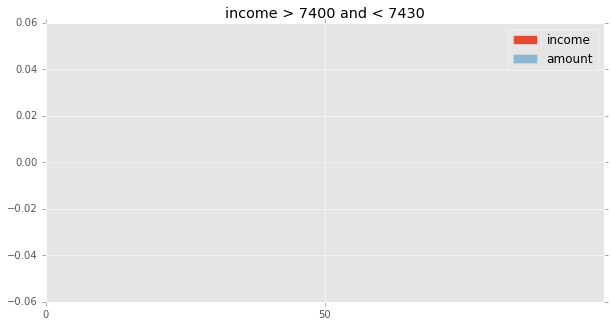



iteration 1
name 7430 to 7460
std 3166.65974137
mean 2811.07142857
median 1270.0
max_mult 1.34426670251
med_mult 0.1706356292611394
min_mult 0.0154653039268
q98 9298.0
q02 138.14
q75 4572.0
q25 775.0
iqr 3797.0
min_q -4920.5
max_q 10267.5
count of loans 14
pct of total loans 0.000606997642248


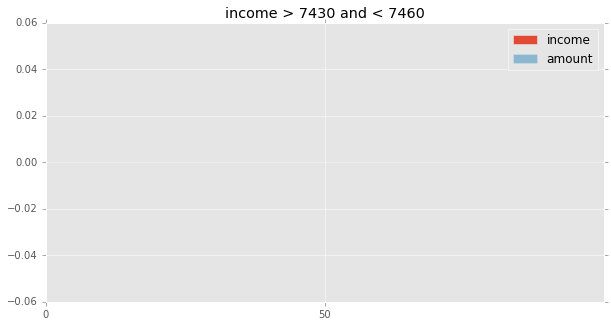



iteration 1
name 7460 to 7490
std 1253.326578
mean 1301.2
median 1190.0
max_mult 0.478005080893
med_mult 0.15941435400324272
min_mult 0.00667735042735
q98 3471.5
q02 54.5
q75 1875.0
q25 171.0
iqr 1704.0
min_q -2385.0
max_q 4431.0
count of loans 10
pct of total loans 0.000433569744463


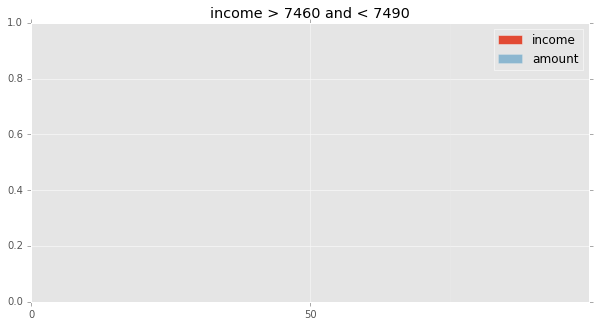



iteration 1
name 7490 to 7520
std 878.454735443
mean 1376.61111111
median 1050.0
max_mult 0.433738155612
med_mult 0.14
min_mult 0.0136
q98 3213.62
q02 205.7
q75 1877.25
q25 737.25
iqr 1140.0
min_q -972.75
max_q 3587.25
count of loans 21
pct of total loans 0.000910496463372


iteration 2
name 7490 to 7520
std 878.454735443
mean 1376.61111111
median 1050.0
max_mult 0.433738155612
med_mult 0.14
min_mult 0.0136
q98 3213.62
q02 205.7
q75 1877.25
q25 737.25
iqr 1140.0
min_q -972.75
max_q 3587.25
count of loans 21
pct of total loans 0.000910496463372


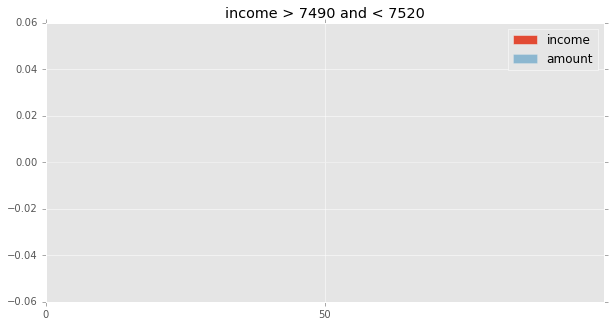



iteration 1
name 7520 to 7550
std 1734.91499143
mean 1625.21428571
median 1266.0
max_mult 0.814058355438
med_mult 0.1680392251376434
min_mult 0.00106030483764
q98 5493.72
q02 25.42
q75 2300.0
q25 298.5
iqr 2001.5
min_q -2703.75
max_q 5302.25
count of loans 15
pct of total loans 0.000650354616694


iteration 2
name 7520 to 7550
std 1197.1249908
mean 1278.07692308
median 1238.0
max_mult 0.486249501794
med_mult 0.16427813163481952
min_mult 0.00106030483764
q98 3491.52
q02 24.08
q75 2000.0
q25 288.0
iqr 1712.0
min_q -2280.0
max_q 4568.0
count of loans 15
pct of total loans 0.000650354616694


iteration 3
name 7520 to 7550
std 1197.1249908
mean 1278.07692308
median 1238.0
max_mult 0.486249501794
med_mult 0.16427813163481952
min_mult 0.00106030483764
q98 3491.52
q02 24.08
q75 2000.0
q25 288.0
iqr 1712.0
min_q -2280.0
max_q 4568.0
count of loans 15
pct of total loans 0.000650354616694


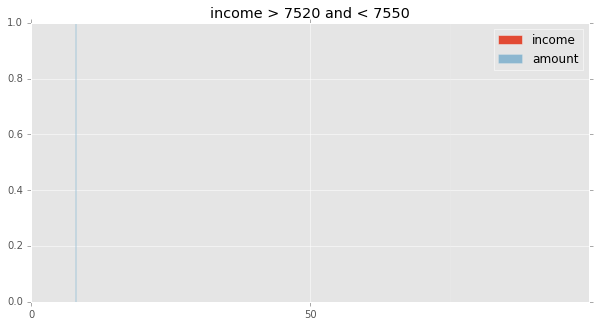



iteration 1
name 7550 to 7580
std 774.769815278
mean 1220.6
median 1300.0
max_mult 0.264830508475
med_mult 0.1718314487814727
min_mult 0.00277777777778
q98 2000.0
q02 56.1
q75 1950.0
q25 617.25
iqr 1332.75
min_q -1381.875
max_q 3949.125
count of loans 10
pct of total loans 0.000433569744463


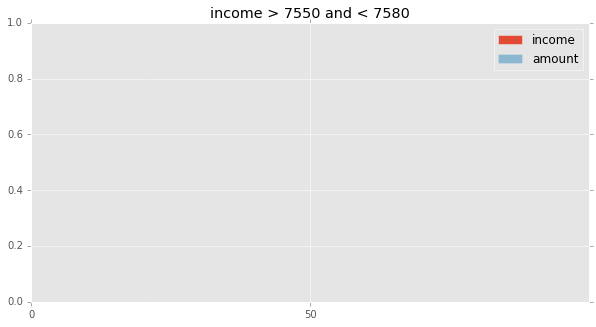



iteration 1
name 7580 to 7610
std 1415.72746221
mean 2142.35714286
median 2362.5
max_mult 0.658587987355
med_mult 0.31104288465764185
min_mult 0.0187310381216
q98 4636.0
q02 242.1
q75 3000.0
q25 1031.25
iqr 1968.75
min_q -1921.875
max_q 5953.125
count of loans 15
pct of total loans 0.000650354616694


iteration 2
name 7580 to 7610
std 1415.72746221
mean 2142.35714286
median 2362.5
max_mult 0.658587987355
med_mult 0.31104288465764185
min_mult 0.0187310381216
q98 4636.0
q02 242.1
q75 3000.0
q25 1031.25
iqr 1968.75
min_q -1921.875
max_q 5953.125
count of loans 15
pct of total loans 0.000650354616694


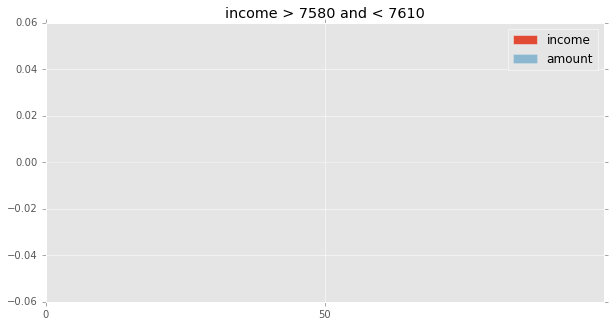



iteration 1
name 7610 to 7640
std 1794.9599417
mean 2074.76923077
median 1750.0
max_mult 0.733560387739
med_mult 0.22965879265091863
min_mult 0.0144262295082
q98 5456.0
q02 210.32
q75 3000.0
q25 645.0
iqr 2355.0
min_q -2887.5
max_q 6532.5
count of loans 13
pct of total loans 0.000563640667801


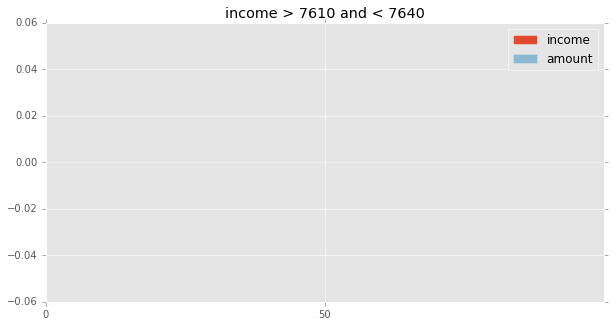



iteration 1
name 7640 to 7670
std 577.988099869
mean 1104.92307692
median 1000.0
max_mult 0.27465341355
med_mult 0.13085579691180318
min_mult 0.0396607958252
q98 2046.0
q02 326.08
q75 1500.0
q25 500.0
iqr 1000.0
min_q -1000.0
max_q 3000.0
count of loans 16
pct of total loans 0.00069371159114


iteration 2
name 7640 to 7670
std 577.988099869
mean 1104.92307692
median 1000.0
max_mult 0.27465341355
med_mult 0.13085579691180318
min_mult 0.0396607958252
q98 2046.0
q02 326.08
q75 1500.0
q25 500.0
iqr 1000.0
min_q -1000.0
max_q 3000.0
count of loans 16
pct of total loans 0.00069371159114


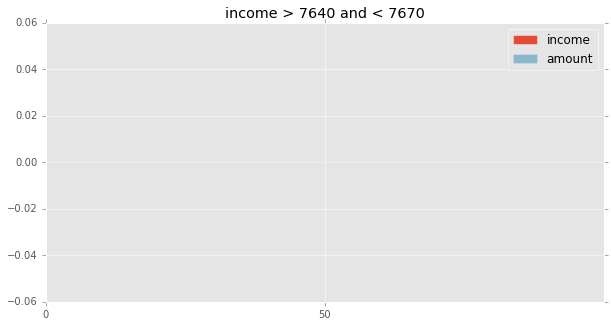



iteration 1
name 7670 to 7700
std 1393.46636127
mean 1556.33333333
median 1000.0
max_mult 0.572991274906
med_mult 0.13012361743656473
min_mult 0.0106687483737
q98 4138.4
q02 100.88
q75 2000.0
q25 600.0
iqr 1400.0
min_q -1500.0
max_q 4100.0
count of loans 10
pct of total loans 0.000433569744463


iteration 2
name 7670 to 7700
std 958.923717732
mean 1200.875
median 980.0
max_mult 0.359324236517
med_mult 0.12746430481812637
min_mult 0.0106687483737
q98 2657.9
q02 98.52
q75 2000.0
q25 500.0
iqr 1500.0
min_q -1750.0
max_q 4250.0
count of loans 10
pct of total loans 0.000433569744463


iteration 3
name 7670 to 7700
std 958.923717732
mean 1200.875
median 980.0
max_mult 0.359324236517
med_mult 0.12746430481812637
min_mult 0.0106687483737
q98 2657.9
q02 98.52
q75 2000.0
q25 500.0
iqr 1500.0
min_q -1750.0
max_q 4250.0
count of loans 10
pct of total loans 0.000433569744463


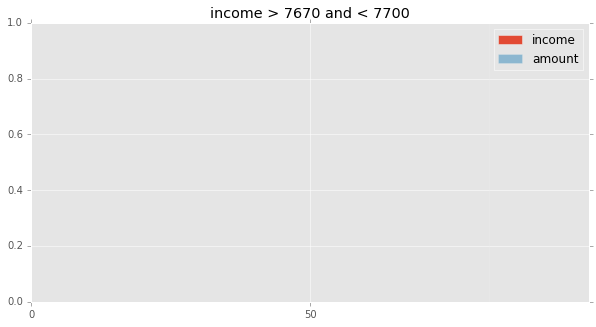



iteration 1
name 7700 to 7730
std 2117.1089464
mean 2725.90909091
median 2000.0
max_mult 0.822095435685
med_mult 0.2597402597402597
min_mult 0.0310719834283
q98 6272.0
q02 375.8
q75 4185.0
q25 1250.5
iqr 2934.5
min_q -3151.25
max_q 8586.75
count of loans 11
pct of total loans 0.000476926718909


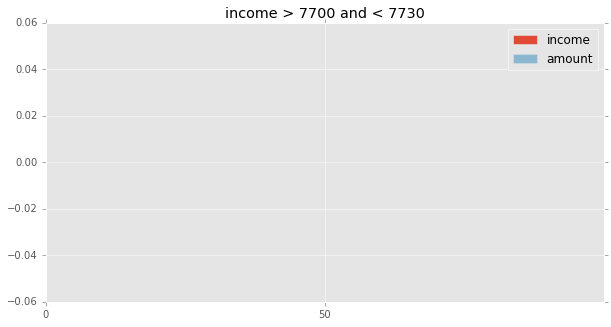



iteration 1
name 7730 to 7760
std 724.326077583
mean 845.4
median 779.5
max_mult 0.322705563444
med_mult 0.10067410388473008
min_mult 0.0155138978668
q98 2302.0
q02 125.94
q75 1075.0
q25 305.5
iqr 769.5
min_q -848.75
max_q 2229.25
count of loans 11
pct of total loans 0.000476926718909


iteration 2
name 7730 to 7760
std 458.249962114
mean 661.555555556
median 747.0
max_mult 0.180575261189
med_mult 0.09657401422107305
min_mult 0.0155138978668
q98 1352.0
q02 125.28
q75 1000.0
q25 300.0
iqr 700.0
min_q -750.0
max_q 2050.0
count of loans 11
pct of total loans 0.000476926718909


iteration 3
name 7730 to 7760
std 458.249962114
mean 661.555555556
median 747.0
max_mult 0.180575261189
med_mult 0.09657401422107305
min_mult 0.0155138978668
q98 1352.0
q02 125.28
q75 1000.0
q25 300.0
iqr 700.0
min_q -750.0
max_q 2050.0
count of loans 11
pct of total loans 0.000476926718909


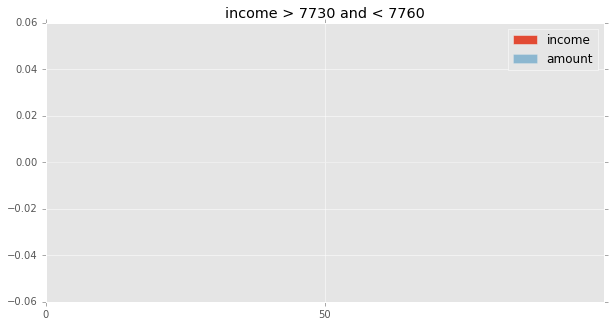



iteration 1
name 7760 to 7790
std 555.974969461
mean 674.833333333
median 490.0
max_mult 0.224704673857
med_mult 0.06299952467786808
min_mult 0.035994343746
q98 1648.5
q02 282.4
q75 701.25
q25 323.0
iqr 378.25
min_q -244.375
max_q 1268.625
count of loans 7
pct of total loans 0.000303498821124


iteration 2
name 7760 to 7790
std 198.972862471
mean 459.8
median 380.0
max_mult 0.0944365925736
med_mult 0.048868312757201646
min_mult 0.035994343746
q98 724.2
q02 281.92
q75 600.0
q25 304.0
iqr 296.0
min_q -140.0
max_q 1044.0
count of loans 7
pct of total loans 0.000303498821124


iteration 3
name 7760 to 7790
std 198.972862471
mean 459.8
median 380.0
max_mult 0.0944365925736
med_mult 0.048868312757201646
min_mult 0.035994343746
q98 724.2
q02 281.92
q75 600.0
q25 304.0
iqr 296.0
min_q -140.0
max_q 1044.0
count of loans 7
pct of total loans 0.000303498821124


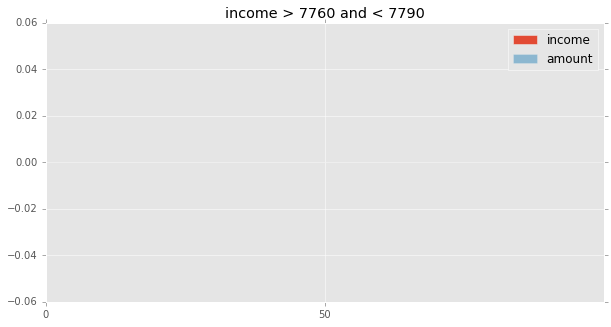



iteration 1
name 7790 to 7820
std 1740.12295543
mean 1516.0
median 960.0
max_mult 0.807692307692
med_mult 0.12310848935624519
min_mult 0.00615384615385
q98 5980.0
q02 79.6
q75 1950.0
q25 315.0
iqr 1635.0
min_q -2137.5
max_q 4402.5
count of loans 23
pct of total loans 0.000997210412264


iteration 2
name 7790 to 7820
std 993.183566362
mean 1054.52631579
median 772.0
max_mult 0.421660464519
med_mult 0.09910141206675224
min_mult 0.00615384615385
q98 3181.6
q02 76.44
q75 1362.5
q25 277.5
iqr 1085.0
min_q -1350.0
max_q 2990.0
count of loans 23
pct of total loans 0.000997210412264


iteration 3
name 7790 to 7820
std 706.325303117
mean 809.058823529
median 614.0
max_mult 0.333205177496
med_mult 0.07871794871794872
min_mult 0.00615384615385
q98 2392.0
q02 73.28
q75 1100.0
q25 240.0
iqr 860.0
min_q -1050.0
max_q 2390.0
count of loans 23
pct of total loans 0.000997210412264


iteration 4
name 7790 to 7820
std 552.231216672
mean 697.125
median 607.0
max_mult 0.250224560503
med_mult 0.0778205128

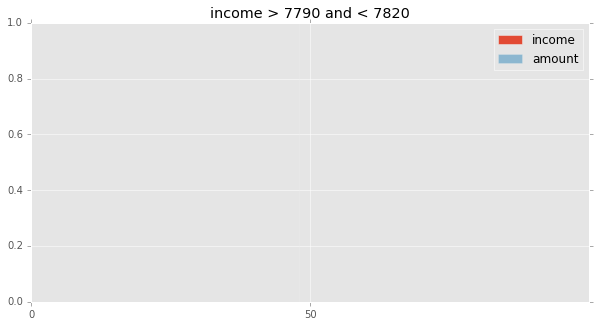



iteration 1
name 7820 to 7850
std 1220.30149963
mean 1717.33333333
median 1000.0
max_mult 0.47125702606
med_mult 0.1277139208173691
min_mult 0.0397959183673
q98 3602.76
q02 399.68
q75 3000.0
q25 1000.0
iqr 2000.0
min_q -2000.0
max_q 6000.0
count of loans 9
pct of total loans 0.000390212770016


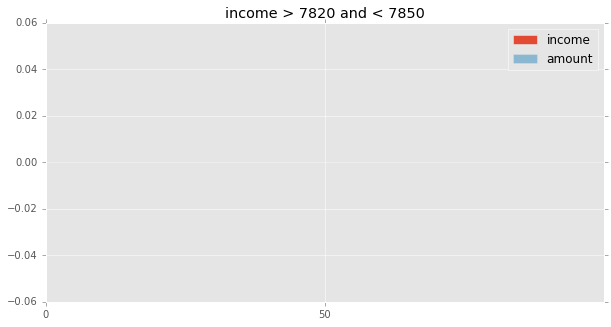



iteration 1
name 7850 to 7880
std 821.639560067
mean 1759.3
median 2000.0
max_mult 0.432569974555
med_mult 0.2539360122196227
min_mult 0.0927337398374
q98 3202.0
q02 730.0
q75 2062.25
q25 1137.5
iqr 924.75
min_q -249.625
max_q 3449.375
count of loans 11
pct of total loans 0.000476926718909


iteration 2
name 7850 to 7880
std 821.639560067
mean 1759.3
median 2000.0
max_mult 0.432569974555
med_mult 0.2539360122196227
min_mult 0.0927337398374
q98 3202.0
q02 730.0
q75 2062.25
q25 1137.5
iqr 924.75
min_q -249.625
max_q 3449.375
count of loans 11
pct of total loans 0.000476926718909


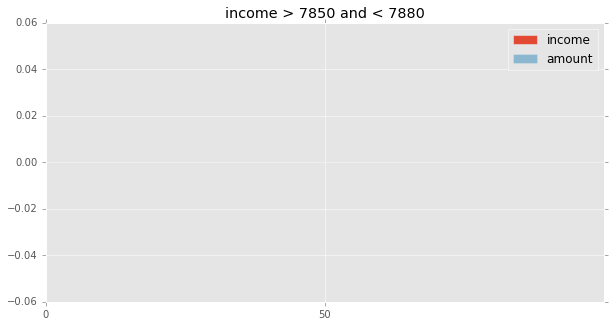



iteration 1
name 7880 to 7910
std 936.892101324
mean 1159.85714286
median 1100.0
max_mult 0.379602682526
med_mult 0.13932868904369855
min_mult 0.0202557285732
q98 2798.4
q02 171.88
q75 1300.0
q25 629.5
iqr 670.5
min_q -376.25
max_q 2305.75
count of loans 8
pct of total loans 0.00034685579557


iteration 2
name 7880 to 7910
std 513.053765863
mean 853.166666667
median 1050.0
max_mult 0.166982922201
med_mult 0.13301964102463693
min_mult 0.0202557285732
q98 1316.0
q02 169.9
q75 1235.0
q25 444.25
iqr 790.75
min_q -741.875
max_q 2421.125
count of loans 8
pct of total loans 0.00034685579557


iteration 3
name 7880 to 7910
std 513.053765863
mean 853.166666667
median 1050.0
max_mult 0.166982922201
med_mult 0.13301964102463693
min_mult 0.0202557285732
q98 1316.0
q02 169.9
q75 1235.0
q25 444.25
iqr 790.75
min_q -741.875
max_q 2421.125
count of loans 8
pct of total loans 0.00034685579557


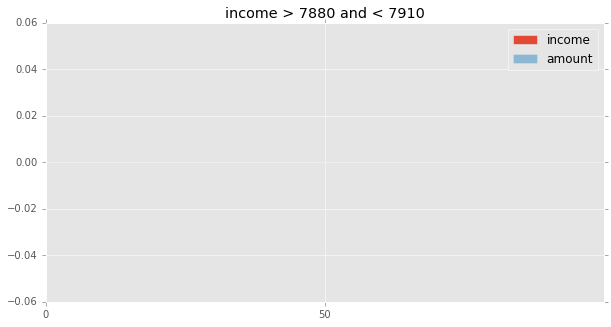



iteration 1
name 7910 to 7940
std 581.451324581
mean 842.75
median 850.0
max_mult 0.252270433905
med_mult 0.10723330402116692
min_mult 0.02396871452
q98 1876.8
q02 214.36
q75 1030.0
q25 367.0
iqr 663.0
min_q -627.5
max_q 2024.5
count of loans 8
pct of total loans 0.00034685579557


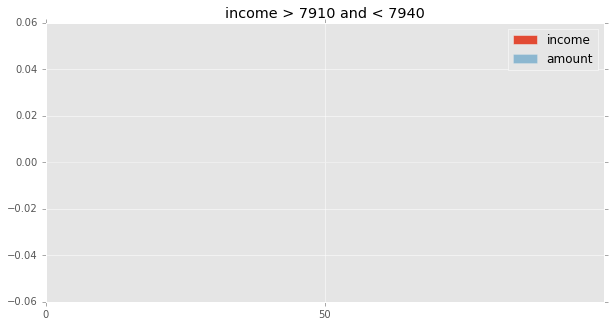



iteration 1
name 7940 to 7970
std 770.258975208
mean 866.0
median 530.0
max_mult 0.31414928374
med_mult 0.06662179704766794
min_mult 0.0201257861635
q98 2320.0
q02 167.2
q75 1400.0
q25 295.0
iqr 1105.0
min_q -1362.5
max_q 3057.5
count of loans 11
pct of total loans 0.000476926718909


iteration 2
name 7940 to 7970
std 770.258975208
mean 866.0
median 530.0
max_mult 0.31414928374
med_mult 0.06662179704766794
min_mult 0.0201257861635
q98 2320.0
q02 167.2
q75 1400.0
q25 295.0
iqr 1105.0
min_q -1362.5
max_q 3057.5
count of loans 11
pct of total loans 0.000476926718909


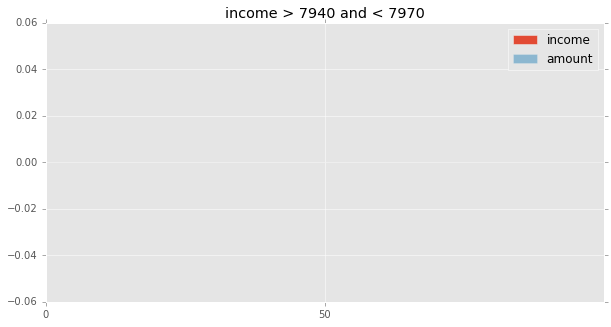



iteration 1
name 7970 to 8000
std 521.627261558
mean 1053.0
median 1000.0
max_mult 0.200526381752
med_mult 0.125203455615375
min_mult 0.0325162581291
q98 1587.2
q02 316.4
q75 1440.0
q25 965.0
iqr 475.0
min_q 252.5
max_q 2152.5
count of loans 6
pct of total loans 0.000260141846678


iteration 2
name 7970 to 8000
std 521.627261558
mean 1053.0
median 1000.0
max_mult 0.200526381752
med_mult 0.125203455615375
min_mult 0.0325162581291
q98 1587.2
q02 316.4
q75 1440.0
q25 965.0
iqr 475.0
min_q 252.5
max_q 2152.5
count of loans 6
pct of total loans 0.000260141846678


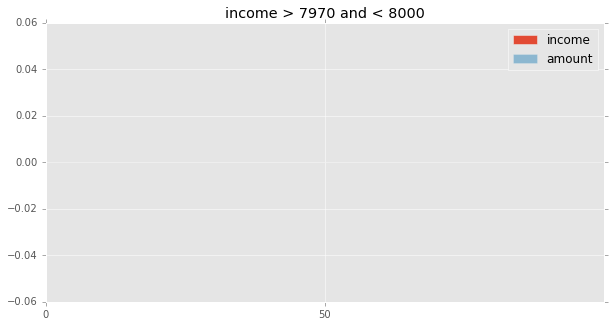



iteration 1
name 8000 to 8030
std 961.894650117
mean 1431.07894737
median 1434.5
max_mult 0.468515742129
med_mult 0.17931249999999999
min_mult 0.00125
q98 3565.0
q02 40.34
q75 1893.75
q25 930.25
iqr 963.5
min_q -515.0
max_q 3339.0
count of loans 43
pct of total loans 0.00186434990119


iteration 2
name 8000 to 8030
std 828.790679051
mean 1309.19444444
median 1347.0
max_mult 0.375
med_mult 0.168375
min_mult 0.00125
q98 3000.0
q02 38.7
q75 1725.0
q25 786.25
iqr 938.75
min_q -621.875
max_q 3133.125
count of loans 43
pct of total loans 0.00186434990119


iteration 3
name 8000 to 8030
std 828.790679051
mean 1309.19444444
median 1347.0
max_mult 0.375
med_mult 0.168375
min_mult 0.00125
q98 3000.0
q02 38.7
q75 1725.0
q25 786.25
iqr 938.75
min_q -621.875
max_q 3133.125
count of loans 43
pct of total loans 0.00186434990119


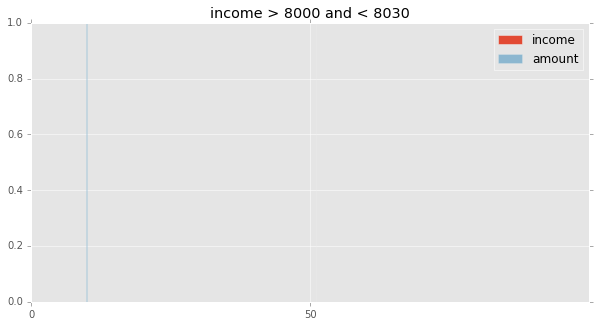



iteration 1
name 8030 to 8060
std 1302.099342
mean 1530.875
median 1175.0
max_mult 0.515374081912
med_mult 0.1459903494309527
min_mult 0.0258160605684
q98 3903.4
q02 248.74
q75 2112.5
q25 574.75
iqr 1537.75
min_q -1731.875
max_q 4419.125
count of loans 9
pct of total loans 0.000390212770016


iteration 2
name 8030 to 8060
std 1302.099342
mean 1530.875
median 1175.0
max_mult 0.515374081912
med_mult 0.1459903494309527
min_mult 0.0258160605684
q98 3903.4
q02 248.74
q75 2112.5
q25 574.75
iqr 1537.75
min_q -1731.875
max_q 4419.125
count of loans 9
pct of total loans 0.000390212770016


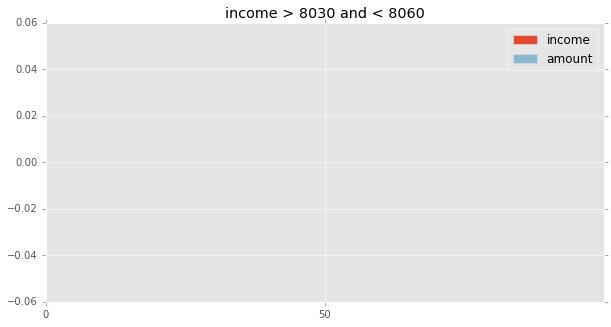



iteration 1
name 8060 to 8090
std 1586.29457822
mean 2693.6
median 2719.0
max_mult 0.743678730788
med_mult 0.3369386880207368
min_mult 0.0639722291098
q98 5593.2
q02 594.12
q75 3440.0
q25 1679.0
iqr 1761.0
min_q -962.5
max_q 6081.5
count of loans 10
pct of total loans 0.000433569744463


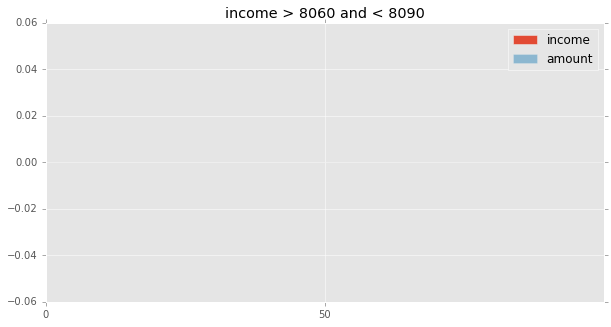



iteration 1
name 8090 to 8120
std 2557.56851543
mean 2875.6
median 2067.5
max_mult 1.04757209761
med_mult 0.25536708938027436
min_mult 0.0434567901235
q98 7975.66
q02 400.06
q75 3602.75
q25 1074.0
iqr 2528.75
min_q -2719.125
max_q 7395.875
count of loans 11
pct of total loans 0.000476926718909


iteration 2
name 8090 to 8120
std 1721.97778731
mean 2250.66666667
median 1575.0
max_mult 0.688308488358
med_mult 0.19468479604449937
min_mult 0.0434567901235
q98 5275.48
q02 394.72
q75 3491.0
q25 932.0
iqr 2559.0
min_q -2906.5
max_q 7329.5
count of loans 11
pct of total loans 0.000476926718909


iteration 3
name 8090 to 8120
std 1721.97778731
mean 2250.66666667
median 1575.0
max_mult 0.688308488358
med_mult 0.19468479604449937
min_mult 0.0434567901235
q98 5275.48
q02 394.72
q75 3491.0
q25 932.0
iqr 2559.0
min_q -2906.5
max_q 7329.5
count of loans 11
pct of total loans 0.000476926718909


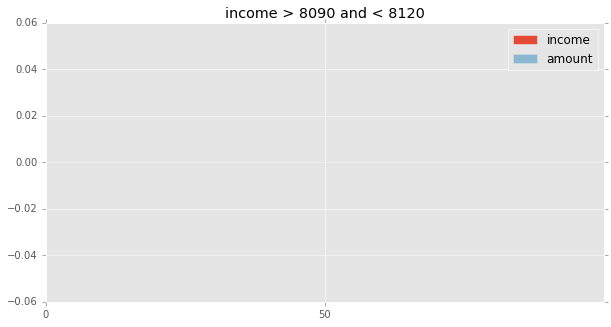



iteration 1
name 8120 to 8150
std 1385.33485723
mean 2137.66666667
median 2563.0
max_mult 0.466887824057
med_mult 0.3155475558923835
min_mult 0.0491702519975
q98 3720.0
q02 410.0
q75 2919.0
q25 987.5
iqr 1931.5
min_q -1909.75
max_q 5816.25
count of loans 6
pct of total loans 0.000260141846678


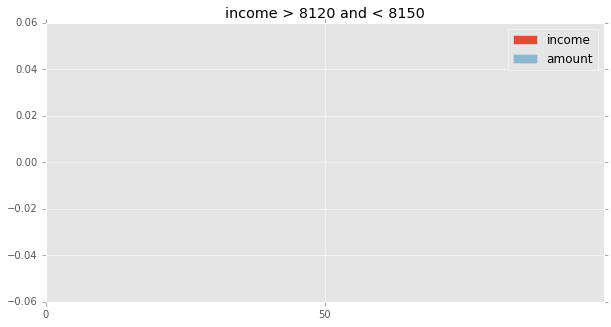



iteration 1
name 8150 to 8180
std 903.615384794
mean 1174.18181818
median 825.0
max_mult 0.321691176471
med_mult 0.10117733627667402
min_mult 0.0208154769193
q98 2564.0
q02 185.8
q75 2025.0
q25 478.5
iqr 1546.5
min_q -1841.25
max_q 4344.75
count of loans 13
pct of total loans 0.000563640667801


iteration 2
name 8150 to 8180
std 903.615384794
mean 1174.18181818
median 825.0
max_mult 0.321691176471
med_mult 0.10117733627667402
min_mult 0.0208154769193
q98 2564.0
q02 185.8
q75 2025.0
q25 478.5
iqr 1546.5
min_q -1841.25
max_q 4344.75
count of loans 13
pct of total loans 0.000563640667801


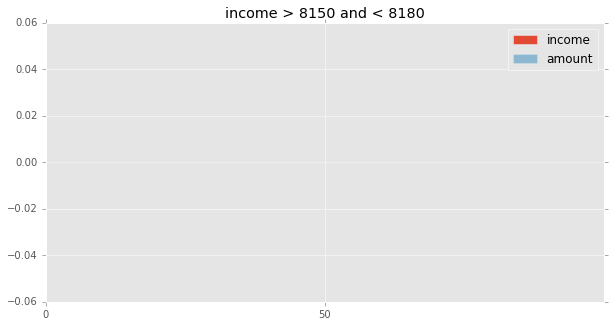



iteration 1
name 8180 to 8210
std 1252.64706389
mean 1568.66666667
median 1425.0
max_mult 0.411234312173
med_mult 0.1737741679331194
min_mult 0.0329428989751
q98 3287.5
q02 284.7
q75 2375.0
q25 525.25
iqr 1849.75
min_q -2249.375
max_q 5149.625
count of loans 7
pct of total loans 0.000303498821124


iteration 2
name 8180 to 8210
std 1252.64706389
mean 1568.66666667
median 1425.0
max_mult 0.411234312173
med_mult 0.1737741679331194
min_mult 0.0329428989751
q98 3287.5
q02 284.7
q75 2375.0
q25 525.25
iqr 1849.75
min_q -2249.375
max_q 5149.625
count of loans 7
pct of total loans 0.000303498821124


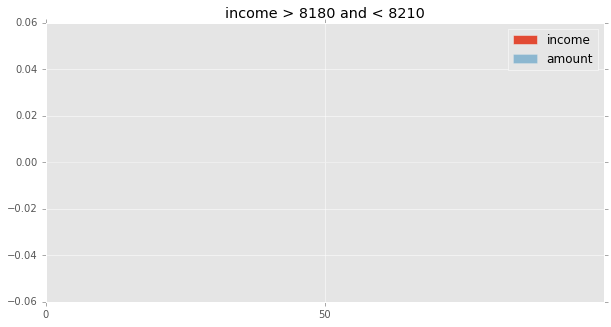



iteration 1
name 8210 to 8240
std 602.857528774
mean 841.8
median 800.0
max_mult 0.181220314213
med_mult 0.09733544226791581
min_mult 0.00560087665896
q98 1478.96
q02 82.32
q75 1375.0
q25 500.0
iqr 875.0
min_q -812.5
max_q 2687.5
count of loans 6
pct of total loans 0.000260141846678


iteration 2
name 8210 to 8240
std 602.857528774
mean 841.8
median 800.0
max_mult 0.181220314213
med_mult 0.09733544226791581
min_mult 0.00560087665896
q98 1478.96
q02 82.32
q75 1375.0
q25 500.0
iqr 875.0
min_q -812.5
max_q 2687.5
count of loans 6
pct of total loans 0.000260141846678


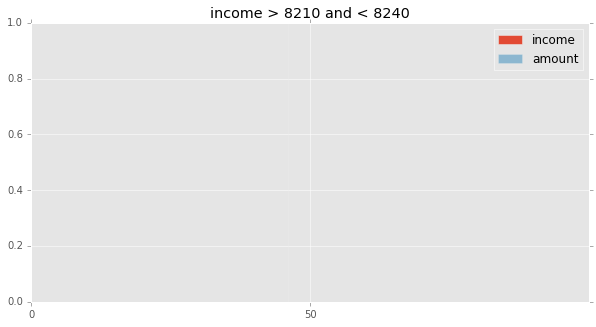



iteration 1
name 8240 to 8270
std 884.505185444
mean 1119.61538462
median 1000.0
max_mult 0.309353390756
med_mult 0.12094823415578132
min_mult 0.00702945097564
q98 2484.0
q02 71.68
q75 2000.0
q25 417.0
iqr 1583.0
min_q -1957.5
max_q 4374.5
count of loans 14
pct of total loans 0.000606997642248


iteration 2
name 8240 to 8270
std 884.505185444
mean 1119.61538462
median 1000.0
max_mult 0.309353390756
med_mult 0.12094823415578132
min_mult 0.00702945097564
q98 2484.0
q02 71.68
q75 2000.0
q25 417.0
iqr 1583.0
min_q -1957.5
max_q 4374.5
count of loans 14
pct of total loans 0.000606997642248


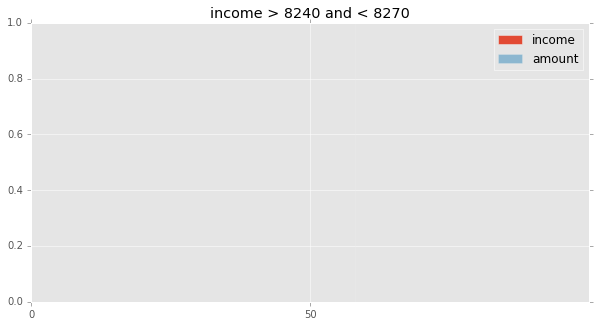



iteration 1
name 8270 to 8300
std 1308.60135259
mean 3337.5
median 3250.0
max_mult 0.597898296896
med_mult 0.3918204708668451
min_mult 0.181006395559
q98 4917.5
q02 1595.0
q75 4343.75
q25 2587.5
iqr 1756.25
min_q -46.875
max_q 6978.125
count of loans 7
pct of total loans 0.000303498821124


iteration 2
name 8270 to 8300
std 1308.60135259
mean 3337.5
median 3250.0
max_mult 0.597898296896
med_mult 0.3918204708668451
min_mult 0.181006395559
q98 4917.5
q02 1595.0
q75 4343.75
q25 2587.5
iqr 1756.25
min_q -46.875
max_q 6978.125
count of loans 7
pct of total loans 0.000303498821124


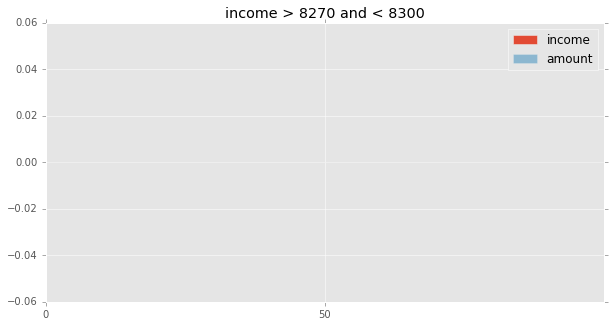



iteration 1
name 8300 to 8330
std 856.774101564
mean 1396.11111111
median 1645.0
max_mult 0.297754832513
med_mult 0.1977401129943503
min_mult 0.0137068654563
q98 2435.52
q02 163.76
q75 2084.0
q25 625.0
iqr 1459.0
min_q -1563.5
max_q 4272.5
count of loans 10
pct of total loans 0.000433569744463


iteration 2
name 8300 to 8330
std 856.774101564
mean 1396.11111111
median 1645.0
max_mult 0.297754832513
med_mult 0.1977401129943503
min_mult 0.0137068654563
q98 2435.52
q02 163.76
q75 2084.0
q25 625.0
iqr 1459.0
min_q -1563.5
max_q 4272.5
count of loans 10
pct of total loans 0.000433569744463


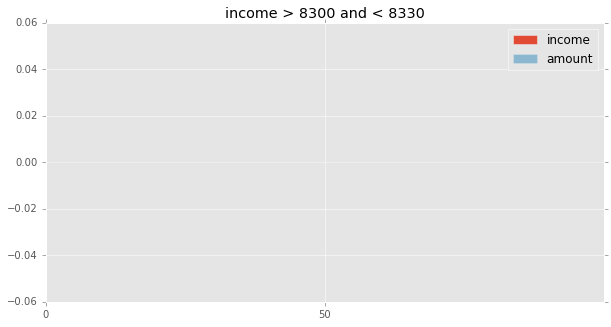



iteration 1
name 8330 to 8360
std 160.42859263
mean 1781.33333333
median 1850.0
max_mult 0.227419935228
med_mult 0.22182254196642687
min_mult 0.191721655669
q98 1894.16
q02 1608.08
q75 1873.0
q25 1724.0
iqr 149.0
min_q 1500.5
max_q 2096.5
count of loans 4
pct of total loans 0.000173427897785


iteration 2
name 8330 to 8360
std 160.42859263
mean 1781.33333333
median 1850.0
max_mult 0.227419935228
med_mult 0.22182254196642687
min_mult 0.191721655669
q98 1894.16
q02 1608.08
q75 1873.0
q25 1724.0
iqr 149.0
min_q 1500.5
max_q 2096.5
count of loans 4
pct of total loans 0.000173427897785


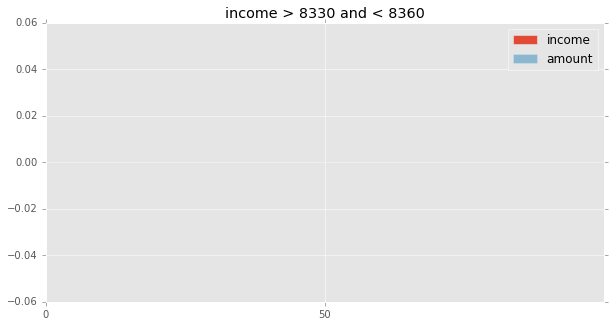



iteration 1
name 8360 to 8390
std 3097.69804138
mean 2554.6
median 1381.5
max_mult 1.19217930377
med_mult 0.16500436609103003
min_mult 0.0208780720592
q98 9190.0
q02 189.94
q75 3125.0
q25 650.5
iqr 2474.5
min_q -3061.25
max_q 6836.75
count of loans 11
pct of total loans 0.000476926718909


iteration 2
name 8360 to 8390
std 1759.55555468
mean 1727.33333333
median 1000.0
max_mult 0.65671641791
med_mult 0.11927480916030535
min_mult 0.0208780720592
q98 5180.0
q02 188.28
q75 2000.0
q25 626.0
iqr 1374.0
min_q -1435.0
max_q 4061.0
count of loans 11
pct of total loans 0.000476926718909


iteration 3
name 8360 to 8390
std 1118.42654143
mean 1255.75
median 862.0
max_mult 0.417710944027
med_mult 0.10293883998685124
min_mult 0.0208780720592
q98 3290.0
q02 186.62
q75 1822.25
q25 534.0
iqr 1288.25
min_q -1398.375
max_q 3754.625
count of loans 11
pct of total loans 0.000476926718909


iteration 4
name 8360 to 8390
std 1118.42654143
mean 1255.75
median 862.0
max_mult 0.417710944027
med_mult 0.102938

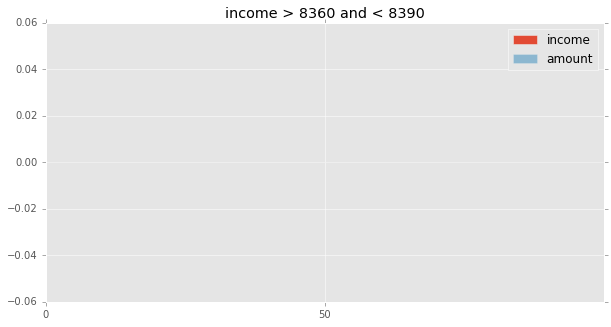



iteration 1
name 8390 to 8420
std 1546.79188892
mean 2370.04761905
median 2000.0
max_mult 0.714285714286
med_mult 0.23809523809523808
min_mult 0.037085462974
q98 5600.0
q02 467.2
q75 2940.0
q25 1186.0
iqr 1754.0
min_q -1445.0
max_q 5571.0
count of loans 22
pct of total loans 0.000953853437818


iteration 2
name 8390 to 8420
std 1338.02527216
mean 2188.55
median 1919.0
max_mult 0.594106463878
med_mult 0.22845238095238096
min_mult 0.037085462974
q98 4867.0
q02 459.44
q75 2919.75
q25 1178.25
iqr 1741.5
min_q -1434.0
max_q 5532.0
count of loans 22
pct of total loans 0.000953853437818


iteration 3
name 8390 to 8420
std 1338.02527216
mean 2188.55
median 1919.0
max_mult 0.594106463878
med_mult 0.22845238095238096
min_mult 0.037085462974
q98 4867.0
q02 459.44
q75 2919.75
q25 1178.25
iqr 1741.5
min_q -1434.0
max_q 5532.0
count of loans 22
pct of total loans 0.000953853437818


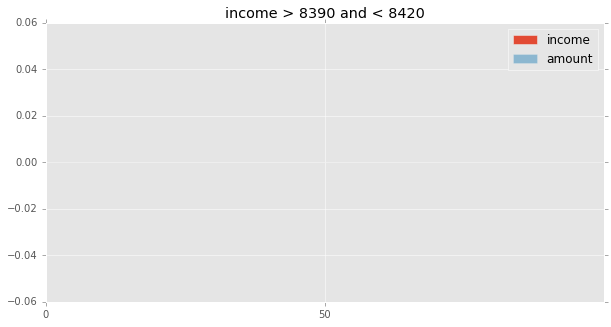



iteration 1
name 8420 to 8450
std 8346.91533841
mean 5881.5
median 2680.0
max_mult 2.1377672209
med_mult 0.3176817462457754
min_mult 0.0196752400142
q98 17208.0
q02 189.64
q75 8100.0
q25 461.5
iqr 7638.5
min_q -10996.25
max_q 19557.75
count of loans 4
pct of total loans 0.000173427897785


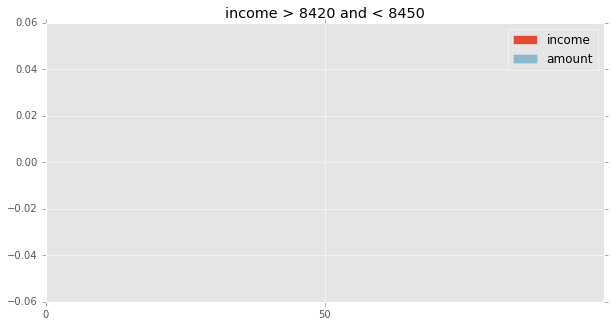



iteration 1
name 8450 to 8480
std 3332.3734768
mean 3460.1
median 1266.0
max_mult 1.18315191671
med_mult 0.14971696941085702
min_mult 0.0929464496343
q98 9444.34
q02 818.96
q75 5990.0
q25 1022.0
iqr 4968.0
min_q -6430.0
max_q 13442.0
count of loans 11
pct of total loans 0.000476926718909


iteration 2
name 8450 to 8480
std 3332.3734768
mean 3460.1
median 1266.0
max_mult 1.18315191671
med_mult 0.14971696941085702
min_mult 0.0929464496343
q98 9444.34
q02 818.96
q75 5990.0
q25 1022.0
iqr 4968.0
min_q -6430.0
max_q 13442.0
count of loans 11
pct of total loans 0.000476926718909


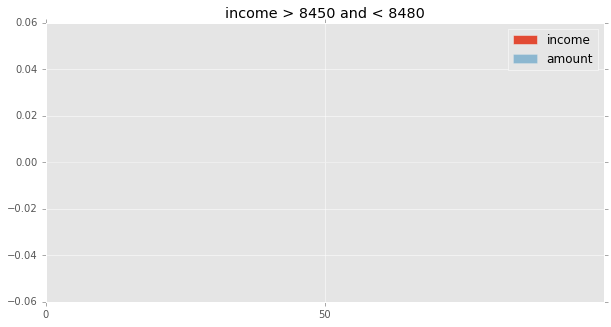



iteration 1
name 8480 to 8510
std 771.112350532
mean 1224.4
median 1000.0
max_mult 0.294117647059
med_mult 0.1177717583323519
min_mult 0.0129411764706
q98 2500.0
q02 143.6
q75 1570.0
q25 959.5
iqr 610.5
min_q 43.75
max_q 2485.75
count of loans 16
pct of total loans 0.00069371159114


iteration 2
name 8480 to 8510
std 617.091679595
mean 1028.15384615
median 1000.0
max_mult 0.28
med_mult 0.11764705882352941
min_mult 0.0129411764706
q98 2250.4
q02 138.8
q75 1160.0
q25 920.0
iqr 240.0
min_q 560.0
max_q 1520.0
count of loans 16
pct of total loans 0.00069371159114


iteration 3
name 8480 to 8510
std 121.491254829
mean 1059.875
median 1000.0
max_mult 0.152941176471
med_mult 0.11770940857794066
min_mult 0.108235294118
q98 1280.4
q02 931.06
q75 1115.0
q25 999.75
iqr 115.25
min_q 826.875
max_q 1287.875
count of loans 16
pct of total loans 0.00069371159114


iteration 4
name 8480 to 8510
std 78.9764883639
mean 1025.57142857
median 1000.0
max_mult 0.136470588235
med_mult 0.11764705882352941
min_

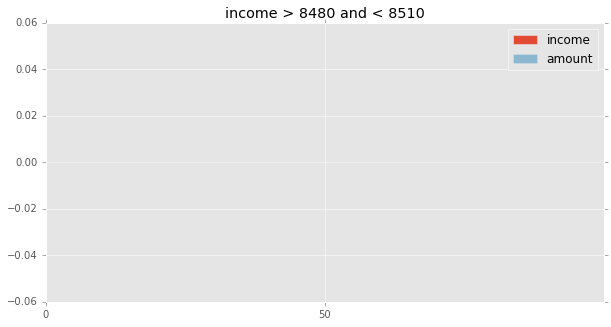



iteration 1
name 8510 to 8540
std 364.338022233
mean 1667.77777778
median 1834.0
max_mult 0.234907211651
med_mult 0.21535932362611554
min_mult 0.117357117709
q98 2000.0
q02 1032.16
q75 1950.0
q25 1550.0
iqr 400.0
min_q 950.0
max_q 2550.0
count of loans 12
pct of total loans 0.000520283693355


iteration 2
name 8510 to 8540
std 364.338022233
mean 1667.77777778
median 1834.0
max_mult 0.234907211651
med_mult 0.21535932362611554
min_mult 0.117357117709
q98 2000.0
q02 1032.16
q75 1950.0
q25 1550.0
iqr 400.0
min_q 950.0
max_q 2550.0
count of loans 12
pct of total loans 0.000520283693355


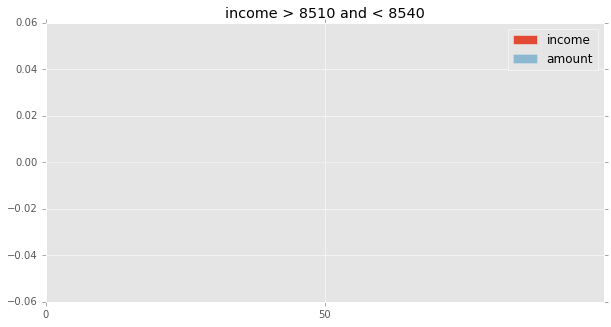



iteration 1
name 8540 to 8570
std 1976.98822848
mean 2551.3
median 2250.0
max_mult 0.66086041618
med_mult 0.26329134475201893
min_mult 0.0227591036415
q98 5485.96
q02 203.1
q75 4150.0
q25 1000.0
iqr 3150.0
min_q -3725.0
max_q 8875.0
count of loans 10
pct of total loans 0.000433569744463


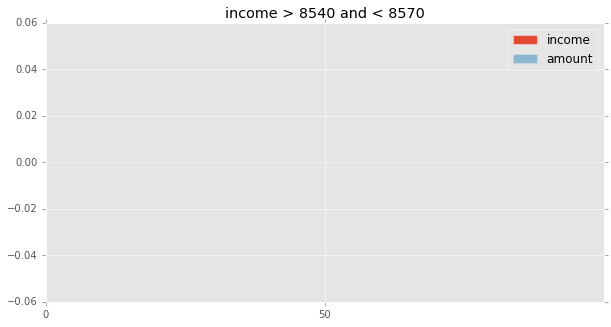



iteration 1
name 8570 to 8600
std 1571.47773949
mean 1957.42857143
median 1000.0
max_mult 0.494876571961
med_mult 0.1165093790050099
min_mult 0.0932400932401
q98 4235.36
q02 800.0
q75 3006.0
q25 820.0
iqr 2186.0
min_q -2459.0
max_q 6285.0
count of loans 7
pct of total loans 0.000303498821124


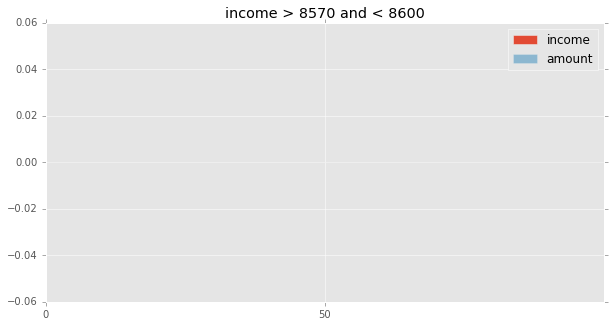



iteration 1
name 8600 to 8630
std 236.736492047
mean 1080.83333333
median 1000.0
max_mult 0.165678409487
med_mult 0.11611712269805928
min_mult 0.0906976744186
q98 1412.5
q02 800.0
q75 1225.0
q25 985.0
iqr 240.0
min_q 625.0
max_q 1585.0
count of loans 9
pct of total loans 0.000390212770016


iteration 2
name 8600 to 8630
std 236.736492047
mean 1080.83333333
median 1000.0
max_mult 0.165678409487
med_mult 0.11611712269805928
min_mult 0.0906976744186
q98 1412.5
q02 800.0
q75 1225.0
q25 985.0
iqr 240.0
min_q 625.0
max_q 1585.0
count of loans 9
pct of total loans 0.000390212770016


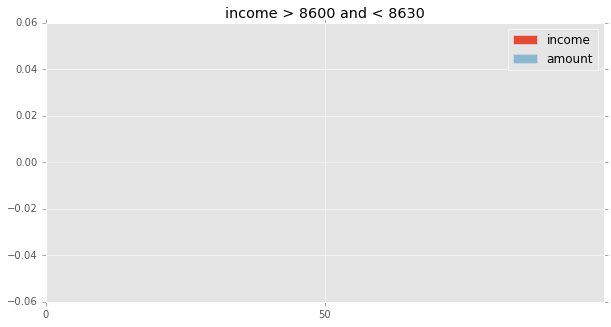



iteration 1
name 8630 to 8660
std 1640.71907145
mean 2471.25
median 2420.0
max_mult 0.595835743204
med_mult 0.28009259259259256
min_mult 0.0231508276421
q98 4989.86
q02 238.22
q75 3115.0
q25 1832.75
iqr 1282.25
min_q -90.625
max_q 5038.375
count of loans 9
pct of total loans 0.000390212770016


iteration 2
name 8630 to 8660
std 1331.46458923
mean 2088.42857143
median 2340.0
max_mult 0.462588180872
med_mult 0.2708333333333333
min_mult 0.0231508276421
q98 3858.4
q02 232.76
q75 2660.0
q25 1379.5
iqr 1280.5
min_q -541.25
max_q 4580.75
count of loans 9
pct of total loans 0.000390212770016


iteration 3
name 8630 to 8660
std 1331.46458923
mean 2088.42857143
median 2340.0
max_mult 0.462588180872
med_mult 0.2708333333333333
min_mult 0.0231508276421
q98 3858.4
q02 232.76
q75 2660.0
q25 1379.5
iqr 1280.5
min_q -541.25
max_q 4580.75
count of loans 9
pct of total loans 0.000390212770016


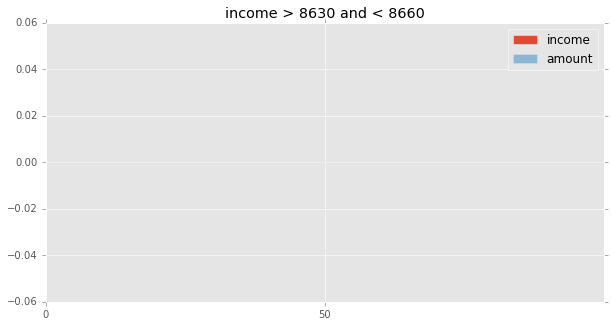



iteration 1
name 8660 to 8690
std 1408.44808211
mean 2046.0
median 1690.0
max_mult 0.539250720461
med_mult 0.19503750721292556
min_mult 0.017618608936
q98 4520.08
q02 168.6
q75 3000.0
q25 1159.0
iqr 1841.0
min_q -1602.5
max_q 5761.5
count of loans 14
pct of total loans 0.000606997642248


iteration 2
name 8660 to 8690
std 1408.44808211
mean 2046.0
median 1690.0
max_mult 0.539250720461
med_mult 0.19503750721292556
min_mult 0.017618608936
q98 4520.08
q02 168.6
q75 3000.0
q25 1159.0
iqr 1841.0
min_q -1602.5
max_q 5761.5
count of loans 14
pct of total loans 0.000606997642248


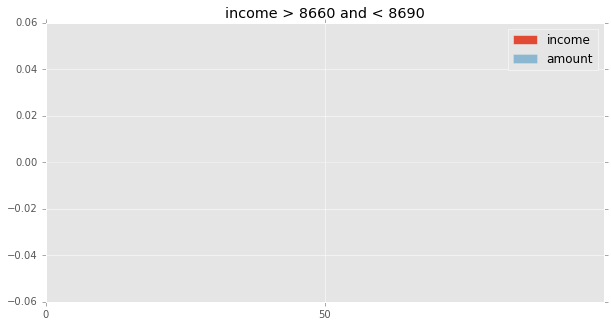



iteration 1
name 8690 to 8720
std 2225.05852607
mean 2434.77777778
median 2000.0
max_mult 0.833620788778
med_mult 0.2296211251435132
min_mult 0.024451842498
q98 6666.0
q02 234.92
q75 3500.0
q25 900.0
iqr 2600.0
min_q -3000.0
max_q 7400.0
count of loans 9
pct of total loans 0.000390212770016


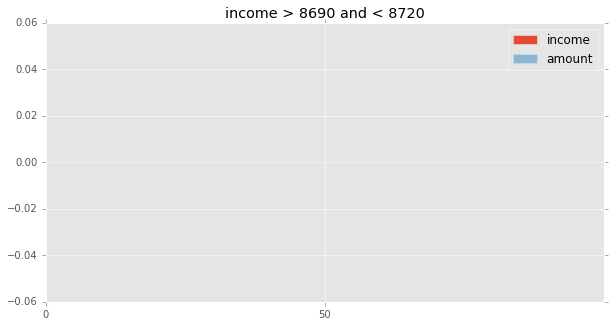



iteration 1
name 8720 to 8750
std 2462.68312348
mean 2277.83333333
median 1775.0
max_mult 0.800915331808
med_mult 0.2032054951345163
min_mult 0.0343367288543
q98 6540.0
q02 311.7
q75 2307.5
q25 692.75
iqr 1614.75
min_q -1729.375
max_q 4729.625
count of loans 7
pct of total loans 0.000303498821124


iteration 2
name 8720 to 8750
std 944.114823525
mean 1333.4
median 1520.0
max_mult 0.275008594019
med_mult 0.17401259301659988
min_mult 0.0343367288543
q98 2370.4
q02 309.36
q75 2030.0
q25 417.0
iqr 1613.0
min_q -2002.5
max_q 4449.5
count of loans 7
pct of total loans 0.000303498821124


iteration 3
name 8720 to 8750
std 944.114823525
mean 1333.4
median 1520.0
max_mult 0.275008594019
med_mult 0.17401259301659988
min_mult 0.0343367288543
q98 2370.4
q02 309.36
q75 2030.0
q25 417.0
iqr 1613.0
min_q -2002.5
max_q 4449.5
count of loans 7
pct of total loans 0.000303498821124


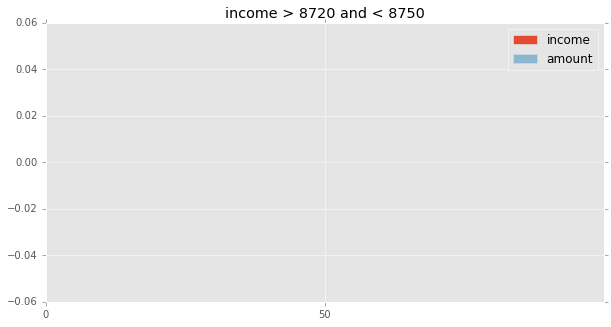



iteration 1
name 8750 to 8780
std 299.596951475
mean 1306.66666667
median 1200.0
max_mult 0.187699680511
med_mult 0.13701758392327015
min_mult 0.122688883816
q98 1627.2
q02 1080.0
q75 1422.5
q25 1137.5
iqr 285.0
min_q 710.0
max_q 1850.0
count of loans 5
pct of total loans 0.000216784872231


iteration 2
name 8750 to 8780
std 299.596951475
mean 1306.66666667
median 1200.0
max_mult 0.187699680511
med_mult 0.13701758392327015
min_mult 0.122688883816
q98 1627.2
q02 1080.0
q75 1422.5
q25 1137.5
iqr 285.0
min_q 710.0
max_q 1850.0
count of loans 5
pct of total loans 0.000216784872231


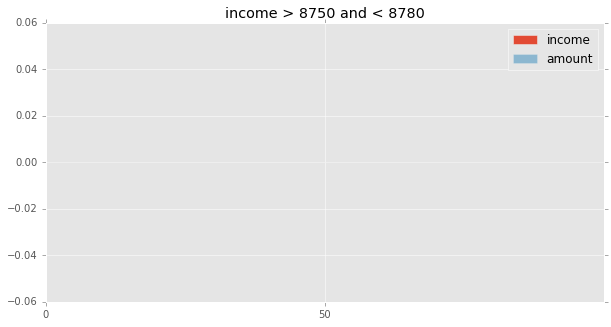



iteration 1
name 8780 to 8810
std 1950.54312339
mean 1940.14285714
median 1000.0
max_mult 0.517339397385
med_mult 0.11377858686995107
min_mult 0.00852272727273
q98 4484.0
q02 98.52
q75 3680.0
q25 298.0
iqr 3382.0
min_q -4775.0
max_q 8753.0
count of loans 7
pct of total loans 0.000303498821124


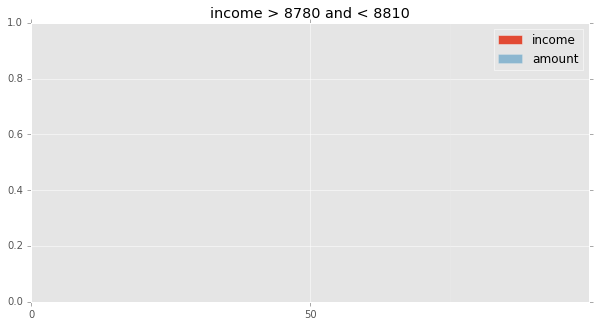



iteration 1
name 8810 to 8840
std 110.418899348
mean 223.666666667
median 200.0
max_mult 0.038989006007
med_mult 0.022660321776569226
min_mult 0.014410529899
q98 338.24
q02 129.92
q75 272.0
q25 163.5
iqr 108.5
min_q 0.75
max_q 434.75
count of loans 3
pct of total loans 0.000130070923339


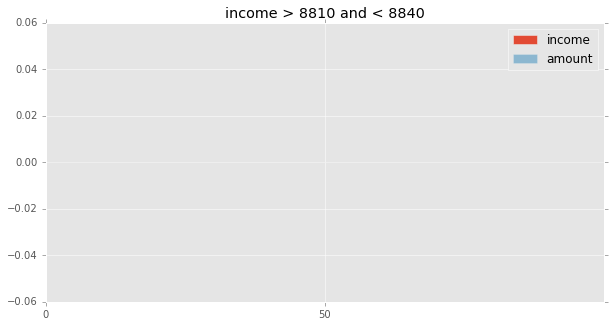



iteration 1
name 8840 to 8870
std 2746.45407753
mean 2924.5
median 2553.5
max_mult 0.880817894261
med_mult 0.2880374705142252
min_mult 0.0254208564004
q98 7405.42
q02 242.5
q75 4625.0
q25 400.25
iqr 4224.75
min_q -5936.875
max_q 10962.125
count of loans 8
pct of total loans 0.00034685579557


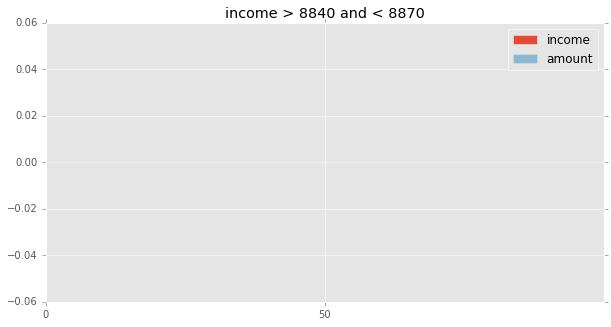



iteration 1
name 8870 to 8900
std 2412.84583014
mean 2935.0
median 1460.0
max_mult 0.716533663032
med_mult 0.1645812197046556
min_mult 0.0563634314057
q98 6225.6
q02 560.0
q75 4980.0
q25 1125.0
iqr 3855.0
min_q -4657.5
max_q 10762.5
count of loans 7
pct of total loans 0.000303498821124


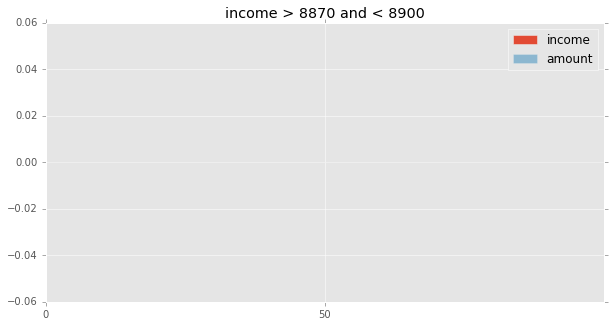



iteration 1
name 8900 to 8930
std 5169.19078129
mean 6026.66666667
median 7000.0
max_mult 1.19483436272
med_mult 0.7865168539325843
min_mult 0.0493162967944
q98 10494.4
q02 702.4
q75 8820.0
q25 3720.0
iqr 5100.0
min_q -3930.0
max_q 16470.0
count of loans 3
pct of total loans 0.000130070923339


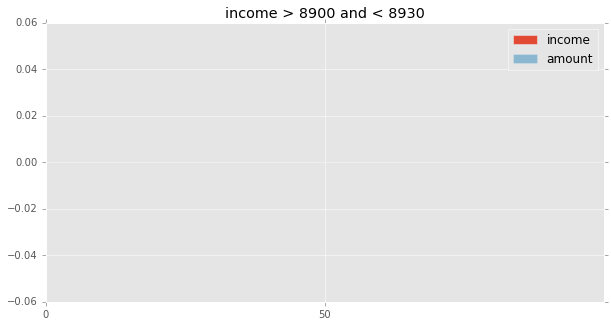



iteration 1
name 8930 to 8960
std 251.661147842
mean 2050.0
median 2000.0
max_mult 0.268696820421
med_mult 0.22361369633890077
min_mult 0.201072386059
q98 2376.0
q02 1812.0
q75 2100.0
q25 1950.0
iqr 150.0
min_q 1725.0
max_q 2325.0
count of loans 6
pct of total loans 0.000260141846678


iteration 2
name 8930 to 8960
std 115.470053838
mean 1933.33333333
median 2000.0
max_mult 0.223763705527
med_mult 0.22346368715083798
min_mult 0.201072386059
q98 2000.0
q02 1808.0
q75 2000.0
q25 1900.0
iqr 100.0
min_q 1750.0
max_q 2150.0
count of loans 6
pct of total loans 0.000260141846678


iteration 3
name 8930 to 8960
std 115.470053838
mean 1933.33333333
median 2000.0
max_mult 0.223763705527
med_mult 0.22346368715083798
min_mult 0.201072386059
q98 2000.0
q02 1808.0
q75 2000.0
q25 1900.0
iqr 100.0
min_q 1750.0
max_q 2150.0
count of loans 6
pct of total loans 0.000260141846678


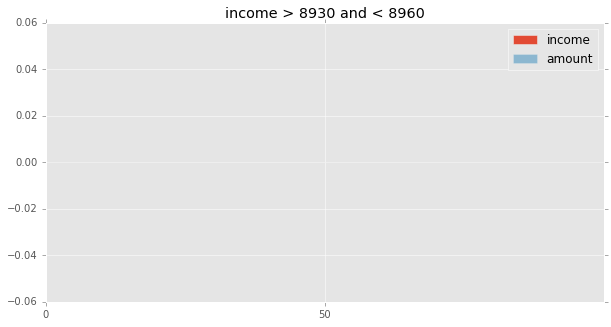



iteration 1
name 8960 to 8990
std 3459.05619755
mean 2950.44444444
median 1200.0
max_mult 1.11569786902
med_mult 0.13376435180024523
min_mult 0.0133630289532
q98 9504.0
q02 153.28
q75 3500.0
q25 450.0
iqr 3050.0
min_q -4125.0
max_q 8075.0
count of loans 10
pct of total loans 0.000433569744463


iteration 2
name 8960 to 8990
std 2384.84187856
mean 2069.25
median 888.0
max_mult 0.768973587429
med_mult 0.0989927790888839
min_mult 0.0133630289532
q98 6424.0
q02 149.12
q75 3485.0
q25 419.5
iqr 3065.5
min_q -4178.75
max_q 8083.25
count of loans 10
pct of total loans 0.000433569744463


iteration 3
name 8960 to 8990
std 2384.84187856
mean 2069.25
median 888.0
max_mult 0.768973587429
med_mult 0.0989927790888839
min_mult 0.0133630289532
q98 6424.0
q02 149.12
q75 3485.0
q25 419.5
iqr 3065.5
min_q -4178.75
max_q 8083.25
count of loans 10
pct of total loans 0.000433569744463


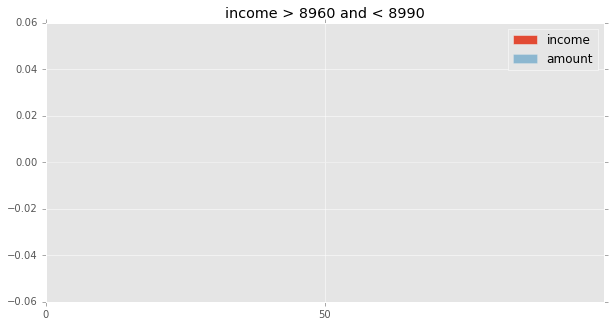



iteration 1
name 8990 to 9020
std 648.963089192
mean 1002.34482759
median 945.0
max_mult 0.333333333333
med_mult 0.105
min_mult 0.00844444444444
q98 2608.0
q02 125.84
q75 1100.0
q25 665.0
iqr 435.0
min_q 12.5
max_q 1752.5
count of loans 34
pct of total loans 0.00147413713117


iteration 2
name 8990 to 9020
std 353.994646852
mean 790.72
median 791.0
max_mult 0.166666666667
med_mult 0.08788888888888889
min_mult 0.00844444444444
q98 1432.8
q02 118.72
q75 1000.0
q25 616.0
iqr 384.0
min_q 40.0
max_q 1576.0
count of loans 34
pct of total loans 0.00147413713117


iteration 3
name 8990 to 9020
std 353.994646852
mean 790.72
median 791.0
max_mult 0.166666666667
med_mult 0.08788888888888889
min_mult 0.00844444444444
q98 1432.8
q02 118.72
q75 1000.0
q25 616.0
iqr 384.0
min_q 40.0
max_q 1576.0
count of loans 34
pct of total loans 0.00147413713117


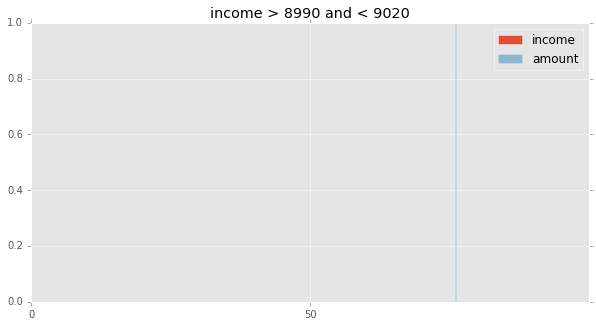



iteration 1
name 9020 to 9050
std 1013.75128442
mean 2412.5
median 2620.0
max_mult 0.370534232939
med_mult 0.290131386821586
min_mult 0.117152961981
q98 3329.0
q02 1130.8
q75 3087.5
q25 1945.0
iqr 1142.5
min_q 231.25
max_q 4801.25
count of loans 4
pct of total loans 0.000173427897785


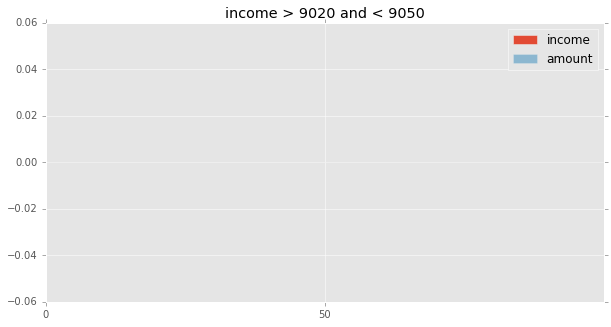



iteration 1
name 9050 to 9080
std 2206.19302031
mean 3035.25
median 3506.5
max_mult 0.662836942112
med_mult 0.38706233137637225
min_mult 0.0124737829783
q98 5860.0
q02 194.62
q75 4625.0
q25 894.0
iqr 3731.0
min_q -4702.5
max_q 10221.5
count of loans 8
pct of total loans 0.00034685579557


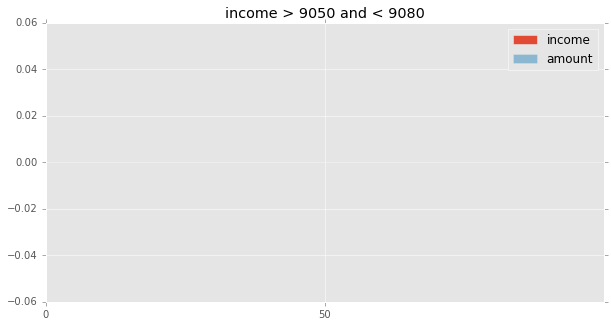



iteration 1
name 9080 to 9110
std 139.667462209
mean 343.0
median 394.0
max_mult 0.049526744442
med_mult 0.0432967032967033
min_mult 0.0203319046049
q98 447.76
q02 193.36
q75 422.0
q25 289.5
iqr 132.5
min_q 90.75
max_q 620.75
count of loans 4
pct of total loans 0.000173427897785


iteration 2
name 9080 to 9110
std 139.667462209
mean 343.0
median 394.0
max_mult 0.049526744442
med_mult 0.0432967032967033
min_mult 0.0203319046049
q98 447.76
q02 193.36
q75 422.0
q25 289.5
iqr 132.5
min_q 90.75
max_q 620.75
count of loans 4
pct of total loans 0.000173427897785


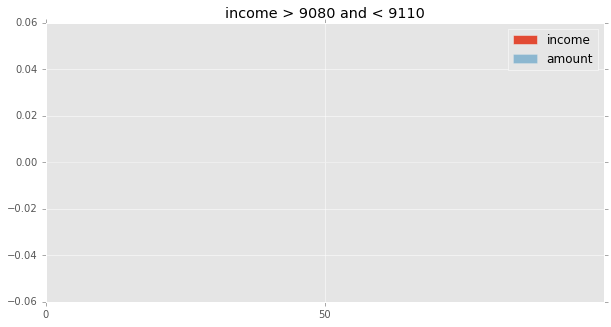



iteration 1
name 9110 to 9140
std 2831.22176218
mean 3340.0
median 2962.5
max_mult 0.731640582248
med_mult 0.3245077822717992
min_mult 0.0822368421053
q98 6564.4
q02 780.0
q75 5177.5
q25 1125.0
iqr 4052.5
min_q -4953.75
max_q 11256.25
count of loans 4
pct of total loans 0.000173427897785


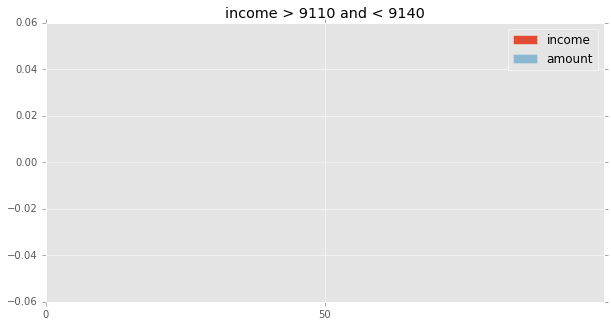



iteration 1
name 9140 to 9170
std 5599.0973975
mean 6557.5
median 6500.0
max_mult 1.41859450022
med_mult 0.7100368852811392
min_mult 0.025095471904
q98 12760.0
q02 456.2
q75 10000.0
q25 3057.5
iqr 6942.5
min_q -7356.25
max_q 20413.75
count of loans 4
pct of total loans 0.000173427897785


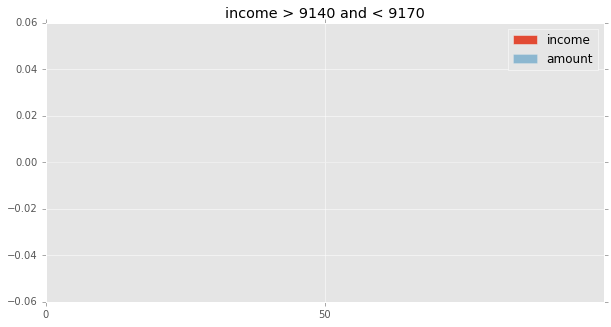



iteration 1
name 9170 to 9200
std 777.049204791
mean 1225.66666667
median 1000.0
max_mult 0.298104162127
med_mult 0.10882585242743058
min_mult 0.0575665067597
q98 2587.4
q02 559.2
q75 1187.5
q25 880.0
iqr 307.5
min_q 418.75
max_q 1648.75
count of loans 7
pct of total loans 0.000303498821124


iteration 2
name 9170 to 9200
std 265.376713372
mean 923.6
median 1000.0
max_mult 0.136224934612
med_mult 0.10873110796999022
min_mult 0.0575665067597
q98 1230.0
q02 552.96
q75 1000.0
q25 840.0
iqr 160.0
min_q 600.0
max_q 1240.0
count of loans 7
pct of total loans 0.000303498821124


iteration 3
name 9170 to 9200
std 92.3760430703
mean 946.666666667
median 1000.0
max_mult 0.108920596885
med_mult 0.10873110796999022
min_mult 0.0915032679739
q98 1000.0
q02 846.4
q75 1000.0
q25 920.0
iqr 80.0
min_q 800.0
max_q 1120.0
count of loans 7
pct of total loans 0.000303498821124


iteration 4
name 9170 to 9200
std 92.3760430703
mean 946.666666667
median 1000.0
max_mult 0.108920596885
med_mult 0.108731107969

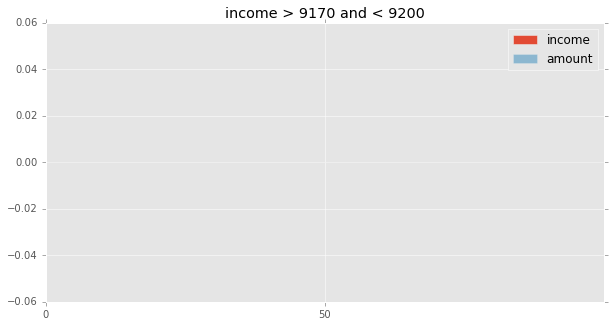



iteration 1
name 9200 to 9230
std 1022.97296981
mean 1359.33333333
median 1170.5
max_mult 0.379939209726
med_mult 0.12719236355477884
min_mult 0.0107270560191
q98 3351.5
q02 128.26
q75 1707.5
q25 701.25
iqr 1006.25
min_q -808.125
max_q 3216.875
count of loans 13
pct of total loans 0.000563640667801


iteration 2
name 9200 to 9230
std 806.980184504
mean 1164.72727273
median 1125.0
max_mult 0.306898424769
med_mult 0.12228260869565218
min_mult 0.0107270560191
q98 2660.0
q02 125.6
q75 1555.0
q25 602.5
iqr 952.5
min_q -826.25
max_q 2983.75
count of loans 13
pct of total loans 0.000563640667801


iteration 3
name 9200 to 9230
std 806.980184504
mean 1164.72727273
median 1125.0
max_mult 0.306898424769
med_mult 0.12228260869565218
min_mult 0.0107270560191
q98 2660.0
q02 125.6
q75 1555.0
q25 602.5
iqr 952.5
min_q -826.25
max_q 2983.75
count of loans 13
pct of total loans 0.000563640667801


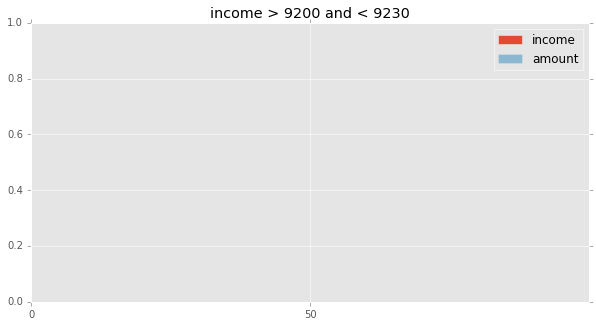



iteration 1
name 9230 to 9260
std 861.187248042
mean 1312.14285714
median 1350.0
max_mult 0.291891891892
med_mult 0.1458355838824673
min_mult 0.0203683640303
q98 2592.0
q02 206.24
q75 1687.5
q25 786.0
iqr 901.5
min_q -566.25
max_q 3039.75
count of loans 8
pct of total loans 0.00034685579557


iteration 2
name 9230 to 9260
std 861.187248042
mean 1312.14285714
median 1350.0
max_mult 0.291891891892
med_mult 0.1458355838824673
min_mult 0.0203683640303
q98 2592.0
q02 206.24
q75 1687.5
q25 786.0
iqr 901.5
min_q -566.25
max_q 3039.75
count of loans 8
pct of total loans 0.00034685579557


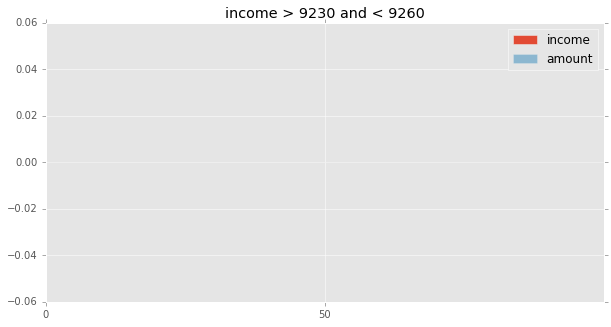



iteration 1
name 9260 to 9290
std 2719.94362074
mean 3122.4
median 3000.0
max_mult 0.754635618801
med_mult 0.32376429958989855
min_mult 0.0411269430052
q98 6793.6
q02 415.4
q75 4420.0
q25 811.0
iqr 3609.0
min_q -4602.5
max_q 9833.5
count of loans 5
pct of total loans 0.000216784872231


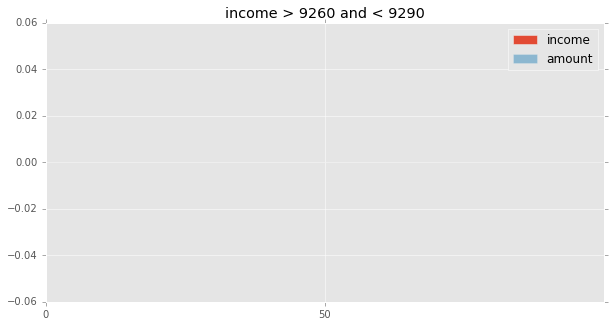



iteration 1
name 9290 to 9320
std 2568.3599861
mean 2772.27272727
median 2200.0
max_mult 0.845864661654
med_mult 0.23676280671545416
min_mult 0.0327956989247
q98 7380.0
q02 311.2
q75 4800.0
q25 639.5
iqr 4160.5
min_q -5601.25
max_q 11040.75
count of loans 11
pct of total loans 0.000476926718909


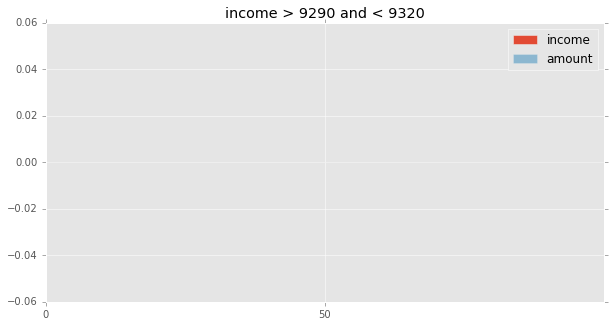



iteration 1
name 9320 to 9350
std 336.469909502
mean 657.0
median 687.5
max_mult 0.10714668381
med_mult 0.07360758070048645
min_mult 0.0162862959391
q98 1000.0
q02 178.3
q75 943.75
q25 461.25
iqr 482.5
min_q -262.5
max_q 1667.5
count of loans 7
pct of total loans 0.000303498821124


iteration 2
name 9320 to 9350
std 336.469909502
mean 657.0
median 687.5
max_mult 0.10714668381
med_mult 0.07360758070048645
min_mult 0.0162862959391
q98 1000.0
q02 178.3
q75 943.75
q25 461.25
iqr 482.5
min_q -262.5
max_q 1667.5
count of loans 7
pct of total loans 0.000303498821124


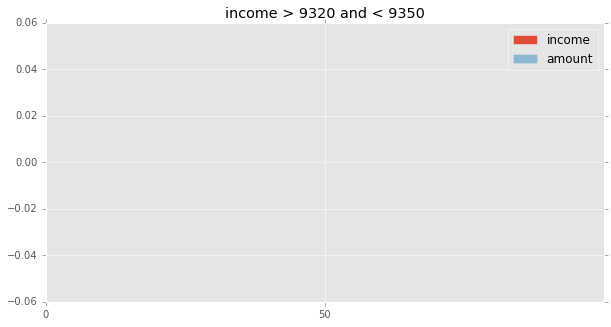



iteration 1
name 9350 to 9380
std 811.518946174
mean 796.5
median 473.5
max_mult 0.213812272824
med_mult 0.05058777886876116
min_mult 0.0255341880342
q98 1912.16
q02 249.32
q75 902.0
q25 368.0
iqr 534.0
min_q -433.0
max_q 1703.0
count of loans 5
pct of total loans 0.000216784872231


iteration 2
name 9350 to 9380
std 149.118521094
mean 395.333333333
median 411.0
max_mult 0.0573262032086
med_mult 0.043849354528966177
min_mult 0.0255341880342
q98 531.0
q02 245.88
q75 473.5
q25 325.0
iqr 148.5
min_q 102.25
max_q 696.25
count of loans 5
pct of total loans 0.000216784872231


iteration 3
name 9350 to 9380
std 149.118521094
mean 395.333333333
median 411.0
max_mult 0.0573262032086
med_mult 0.043849354528966177
min_mult 0.0255341880342
q98 531.0
q02 245.88
q75 473.5
q25 325.0
iqr 148.5
min_q 102.25
max_q 696.25
count of loans 5
pct of total loans 0.000216784872231


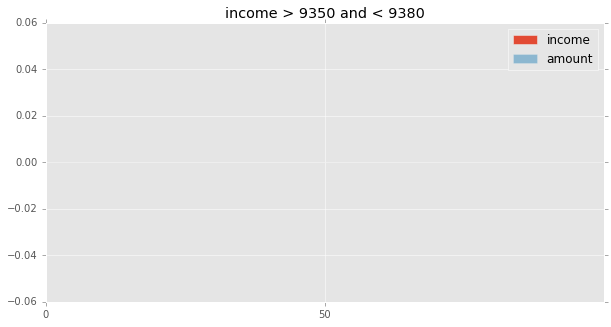



iteration 1
name 9380 to 9410
std 1254.82443438
mean 1508.11111111
median 1200.0
max_mult 0.372021276596
med_mult 0.1275645795684065
min_mult 0.00670212765957
q98 3417.48
q02 81.72
q75 2200.0
q25 333.0
iqr 1867.0
min_q -2467.5
max_q 5000.5
count of loans 9
pct of total loans 0.000390212770016


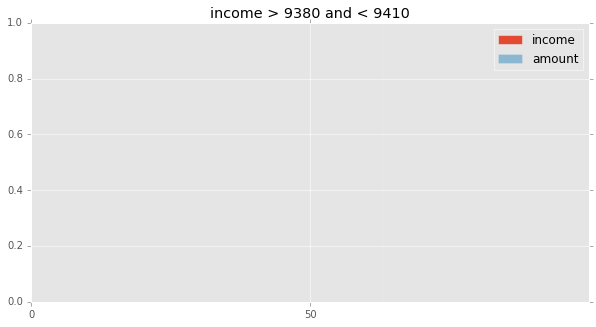



iteration 1
name 9410 to 9440
std 623.579024663
mean 907.6
median 650.0
max_mult 0.203458152116
med_mult 0.06904610155088167
min_mult 0.0457675601229
q98 1851.6
q02 433.44
q75 1088.0
q25 450.0
iqr 638.0
min_q -507.0
max_q 2045.0
count of loans 6
pct of total loans 0.000260141846678


iteration 2
name 9410 to 9440
std 623.579024663
mean 907.6
median 650.0
max_mult 0.203458152116
med_mult 0.06904610155088167
min_mult 0.0457675601229
q98 1851.6
q02 433.44
q75 1088.0
q25 450.0
iqr 638.0
min_q -507.0
max_q 2045.0
count of loans 6
pct of total loans 0.000260141846678


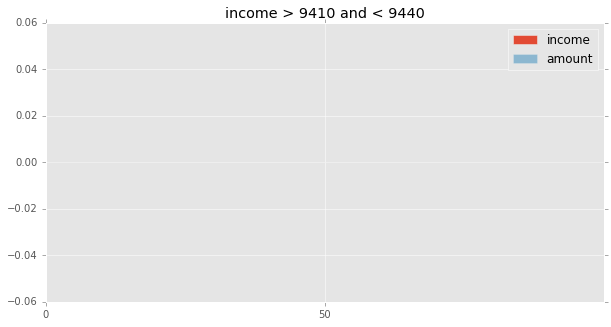



iteration 1
name 9440 to 9470
std 3084.75237256
mean 4803.8
median 6000.0
max_mult 0.845487212006
med_mult 0.6353240152477764
min_mult 0.113026009727
q98 7916.0
q02 1143.48
q75 6950.0
q25 2000.0
iqr 4950.0
min_q -5425.0
max_q 14375.0
count of loans 5
pct of total loans 0.000216784872231


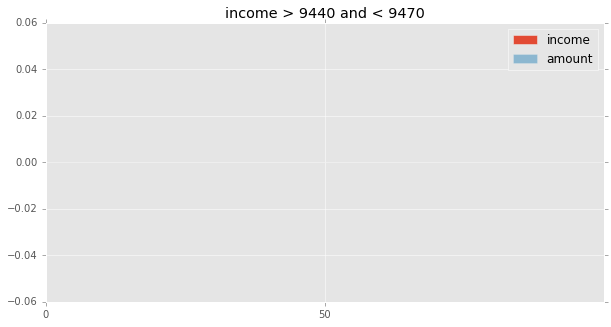



iteration 1
name 9470 to 9500
std 3435.59795863
mean 3033.33333333
median 1100.0
max_mult 0.738786279683
med_mult 0.11581385554853653
min_mult 0.105496360376
q98 6764.0
q02 1004.0
q75 4050.0
q25 1050.0
iqr 3000.0
min_q -3450.0
max_q 8550.0
count of loans 3
pct of total loans 0.000130070923339


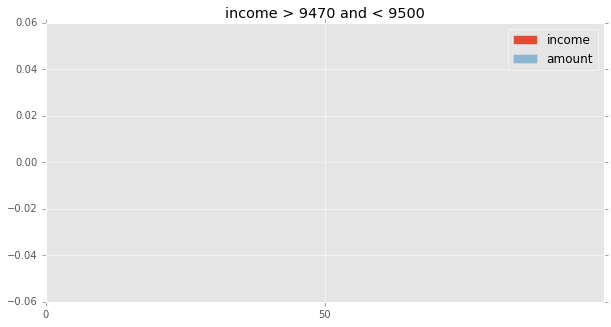



iteration 1
name 9500 to 9530
std 1013.42092125
mean 1649.81818182
median 1200.0
max_mult 0.36830474587
med_mult 0.1259710266638673
min_mult 0.0715789473684
q98 3406.4
q02 684.0
q75 2368.0
q25 900.0
iqr 1468.0
min_q -1302.0
max_q 4570.0
count of loans 11
pct of total loans 0.000476926718909


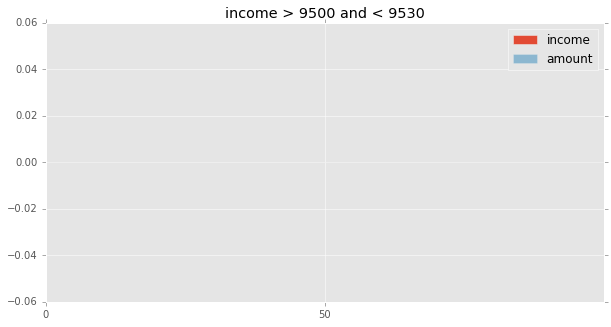



iteration 1
name 9530 to 9560
std nan
mean nan
median nan
max_mult nan
med_mult nan
min_mult nan
q98 nan
q02 nan
q75 nan
q25 nan
iqr nan
min_q nan
max_q nan
count of loans 1
pct of total loans 4.33569744463e-05


iteration 2
name 9530 to 9560
std nan
mean nan
median nan
max_mult nan
med_mult nan
min_mult nan
q98 nan
q02 nan
q75 nan
q25 nan
iqr nan
min_q nan
max_q nan
count of loans 1
pct of total loans 4.33569744463e-05


iteration 3
name 9530 to 9560
std nan
mean nan
median nan
max_mult nan
med_mult nan
min_mult nan
q98 nan
q02 nan
q75 nan
q25 nan
iqr nan
min_q nan
max_q nan
count of loans 1
pct of total loans 4.33569744463e-05


iteration 4
name 9530 to 9560
std nan
mean nan
median nan
max_mult nan
med_mult nan
min_mult nan
q98 nan
q02 nan
q75 nan
q25 nan
iqr nan
min_q nan
max_q nan
count of loans 1
pct of total loans 4.33569744463e-05


iteration 5
name 9530 to 9560
std nan
mean nan
median nan
max_mult nan
med_mult nan
min_mult nan
q98 nan
q02 nan
q75 nan
q25 nan
iqr nan
min_q nan

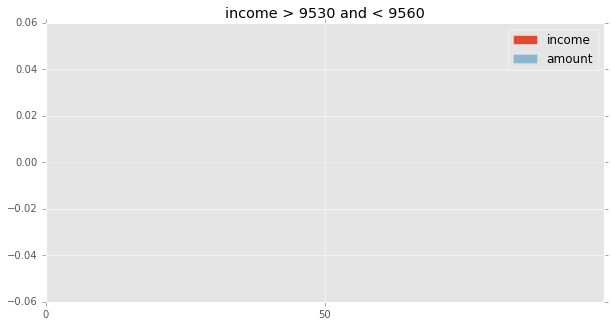



iteration 1
name 9560 to 9590
std 49.0747728811
mean 355.666666667
median 384.0
max_mult 0.0401547631496
med_mult 0.040058418527018566
min_mult 0.0312402047853
q98 384.0
q02 302.4
q75 384.0
q25 341.5
iqr 42.5
min_q 277.75
max_q 447.75
count of loans 4
pct of total loans 0.000173427897785


iteration 2
name 9560 to 9590
std 49.0747728811
mean 355.666666667
median 384.0
max_mult 0.0401547631496
med_mult 0.040058418527018566
min_mult 0.0312402047853
q98 384.0
q02 302.4
q75 384.0
q25 341.5
iqr 42.5
min_q 277.75
max_q 447.75
count of loans 4
pct of total loans 0.000173427897785


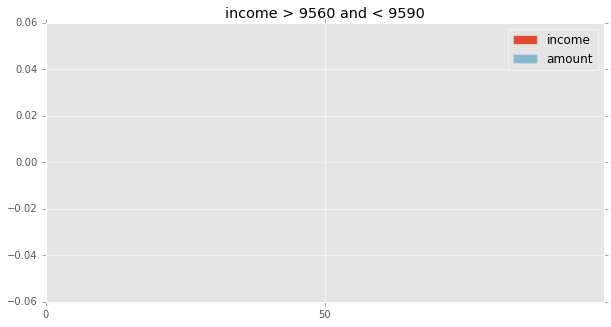



iteration 1
name 9590 to 9620
std 1543.96870188
mean 1626.26666667
median 1395.0
max_mult 0.625
med_mult 0.14541853434796206
min_mult 0.0125
q98 5160.0
q02 123.64
q75 2000.0
q25 349.0
iqr 1651.0
min_q -2127.5
max_q 4476.5
count of loans 18
pct of total loans 0.000780425540033


iteration 2
name 9590 to 9620
std 995.289355463
mean 1313.85714286
median 1323.5
max_mult 0.3125
med_mult 0.1377955637013256
min_mult 0.0125
q98 3000.0
q02 123.38
q75 1972.5
q25 328.5
iqr 1644.0
min_q -2137.5
max_q 4438.5
count of loans 18
pct of total loans 0.000780425540033


iteration 3
name 9590 to 9620
std 995.289355463
mean 1313.85714286
median 1323.5
max_mult 0.3125
med_mult 0.1377955637013256
min_mult 0.0125
q98 3000.0
q02 123.38
q75 1972.5
q25 328.5
iqr 1644.0
min_q -2137.5
max_q 4438.5
count of loans 18
pct of total loans 0.000780425540033


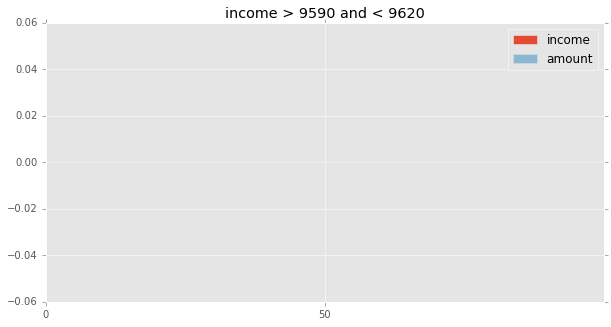



iteration 1
name 9620 to 9650
std 978.605421724
mean 1120.28571429
median 537.0
max_mult 0.257021453
med_mult 0.05576903105203033
min_mult 0.00674553756746
q98 2428.16
q02 93.2
q75 1961.5
q25 418.5
iqr 1543.0
min_q -1896.0
max_q 4276.0
count of loans 7
pct of total loans 0.000303498821124


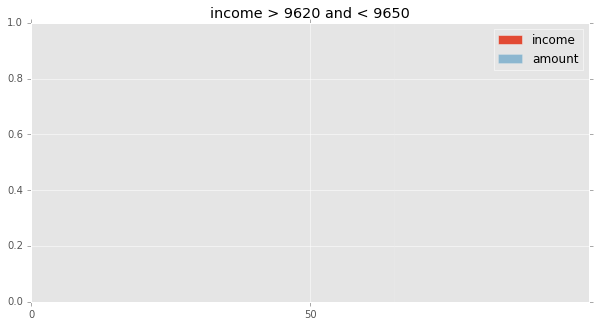



iteration 1
name 9650 to 9680
std 2100.24815384
mean 2468.84615385
median 1500.0
max_mult 0.596767509324
med_mult 0.15516706320471707
min_mult 0.0403726708075
q98 5760.0
q02 414.0
q75 5000.0
q25 1165.0
iqr 3835.0
min_q -4587.5
max_q 10752.5
count of loans 13
pct of total loans 0.000563640667801


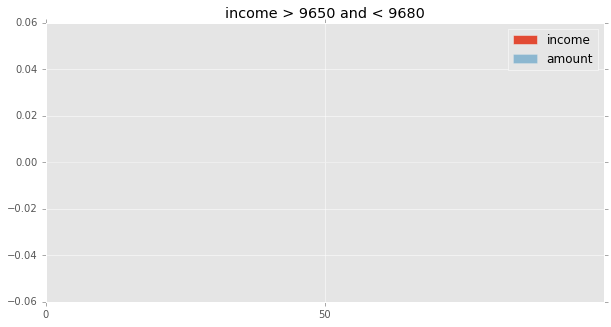



iteration 1
name 9680 to 9710
std 694.953475661
mean 1111.33333333
median 1500.0
max_mult 0.15707075909
med_mult 0.15483071841453344
min_mult 0.0318852543597
q98 1524.0
q02 356.64
q75 1512.5
q25 904.5
iqr 608.0
min_q -7.5
max_q 2424.5
count of loans 3
pct of total loans 0.000130070923339


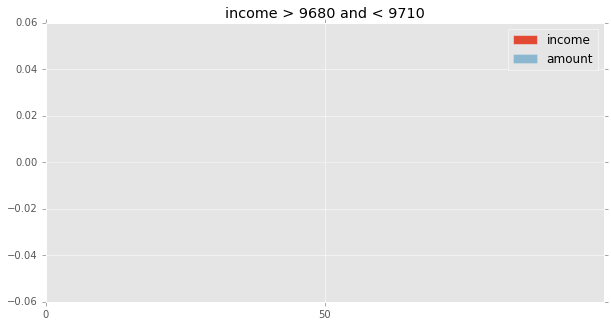



iteration 1
name 9710 to 9740
std 1190.38873203
mean 1438.66666667
median 1106.0
max_mult 0.283921407263
med_mult 0.11376260028800658
min_mult 0.0463010597798
q98 2693.84
q02 476.24
q75 1933.0
q25 778.0
iqr 1155.0
min_q -954.5
max_q 3665.5
count of loans 3
pct of total loans 0.000130070923339


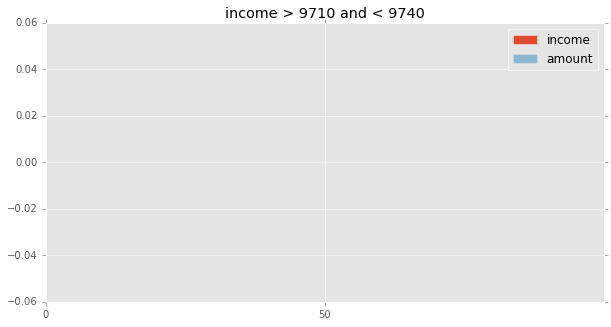



iteration 1
name 9740 to 9770
std 1715.13171089
mean 1631.25
median 790.0
max_mult 0.512295081967
med_mult 0.0810915468511909
min_mult 0.012819198031
q98 4720.0
q02 162.8
q75 2625.0
q25 436.25
iqr 2188.75
min_q -2846.875
max_q 5908.125
count of loans 8
pct of total loans 0.00034685579557


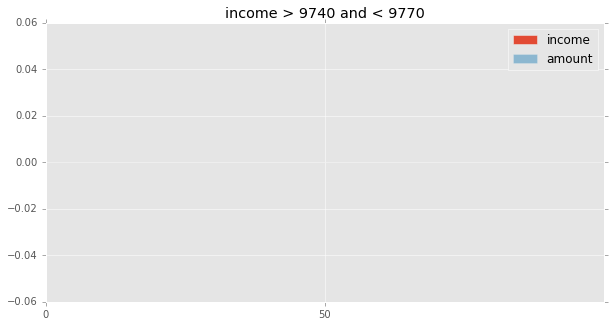



iteration 1
name 9770 to 9800
std 2006.11222684
mean 1587.33333333
median 331.5
max_mult 0.459699662887
med_mult 0.03388808987639713
min_mult 0.0245223255339
q98 4432.4
q02 245.7
q75 2958.0
q25 298.5
iqr 2659.5
min_q -3690.75
max_q 6947.25
count of loans 6
pct of total loans 0.000260141846678


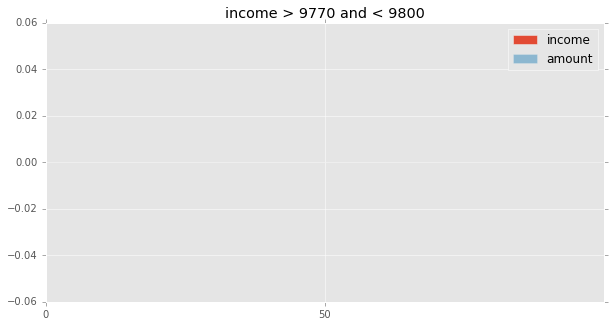



iteration 1
name 9800 to 9830
std 1507.09161727
mean 2220.85714286
median 2000.0
max_mult 0.509528176908
med_mult 0.2035623409669211
min_mult 0.0153014383352
q98 4755.2
q02 312.0
q75 2680.0
q25 1518.0
iqr 1162.0
min_q -225.0
max_q 4423.0
count of loans 8
pct of total loans 0.00034685579557


iteration 2
name 9800 to 9830
std 960.941552159
mean 1757.66666667
median 1768.0
max_mult 0.302040816327
med_mult 0.18005267476393344
min_mult 0.0153014383352
q98 2904.0
q02 285.0
q75 2300.0
q25 1509.0
iqr 791.0
min_q 322.5
max_q 3486.5
count of loans 8
pct of total loans 0.00034685579557


iteration 3
name 9800 to 9830
std 615.534889344
mean 2079.2
median 2000.0
max_mult 0.302040816327
med_mult 0.2035623409669211
min_mult 0.15306122449
q98 2915.2
q02 1502.88
q75 2400.0
q25 1536.0
iqr 864.0
min_q 240.0
max_q 3696.0
count of loans 8
pct of total loans 0.00034685579557


iteration 4
name 9800 to 9830
std 615.534889344
mean 2079.2
median 2000.0
max_mult 0.302040816327
med_mult 0.2035623409669211
min

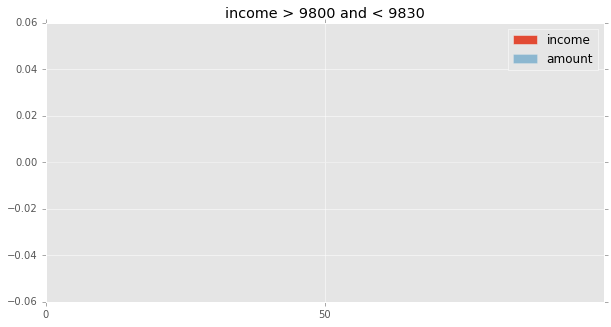



iteration 1
name 9830 to 9860
std 764.96115681
mean 1049.71428571
median 1000.0
max_mult 0.224342706324
med_mult 0.10170870626525631
min_mult 0.0152176118494
q98 2160.8
q02 165.0
q75 1525.0
q25 469.0
iqr 1056.0
min_q -1115.0
max_q 3109.0
count of loans 8
pct of total loans 0.00034685579557


iteration 2
name 9830 to 9860
std 764.96115681
mean 1049.71428571
median 1000.0
max_mult 0.224342706324
med_mult 0.10170870626525631
min_mult 0.0152176118494
q98 2160.8
q02 165.0
q75 1525.0
q25 469.0
iqr 1056.0
min_q -1115.0
max_q 3109.0
count of loans 8
pct of total loans 0.00034685579557


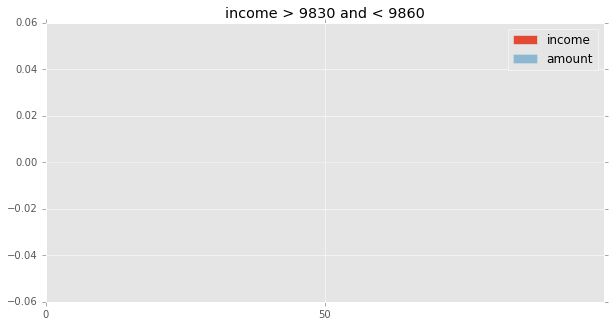



iteration 1
name 9860 to 9890
std 381.837661841
mean 1620.0
median 1620.0
max_mult 0.19156699777
med_mult 0.16413792926480664
min_mult 0.136708860759
q98 1879.2
q02 1360.8
q75 1755.0
q25 1485.0
iqr 270.0
min_q 1080.0
max_q 2160.0
count of loans 2
pct of total loans 8.67139488925e-05


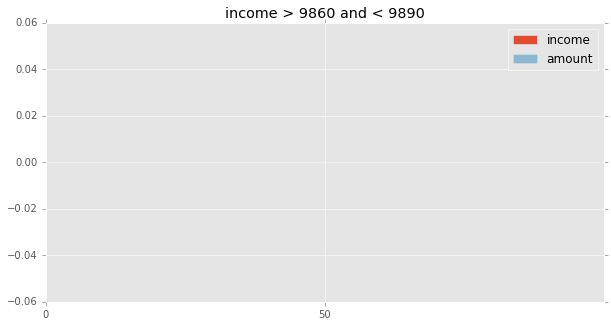



iteration 1
name 9890 to 9920
std 1028.01248371
mean 1686.0
median 1313.0
max_mult 0.303152789006
med_mult 0.13267987065481002
min_mult 0.0322548028311
q98 2985.6
q02 386.32
q75 2550.0
q25 1035.0
iqr 1515.0
min_q -1237.5
max_q 4822.5
count of loans 9
pct of total loans 0.000390212770016


iteration 2
name 9890 to 9920
std 1028.01248371
mean 1686.0
median 1313.0
max_mult 0.303152789006
med_mult 0.13267987065481002
min_mult 0.0322548028311
q98 2985.6
q02 386.32
q75 2550.0
q25 1035.0
iqr 1515.0
min_q -1237.5
max_q 4822.5
count of loans 9
pct of total loans 0.000390212770016


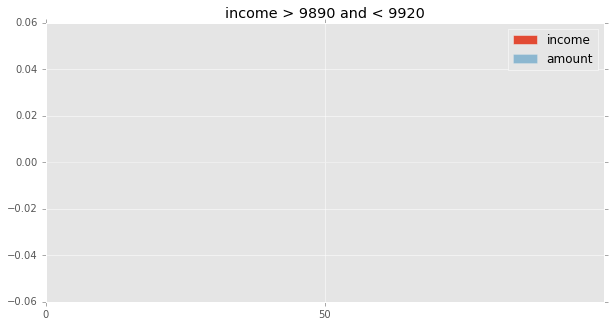



iteration 1
name 9920 to 9950
std 1201.30106551
mean 2054.25
median 2292.5
max_mult 0.324264409512
med_mult 0.2306153521473795
min_mult 0.0416918429003
q98 3180.02
q02 509.16
q75 2743.25
q25 1603.5
iqr 1139.75
min_q -106.125
max_q 4452.875
count of loans 4
pct of total loans 0.000173427897785


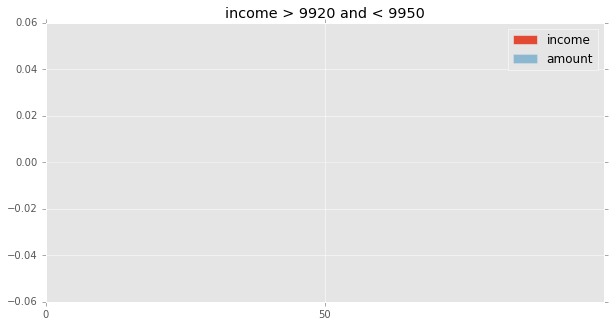



iteration 1
name 9950 to 9980
std 1205.3527492
mean 1520.66666667
median 1000.0
max_mult 0.376015241151
med_mult 0.10043185698503565
min_mult 0.0251004016064
q98 3599.76
q02 262.0
q75 2000.0
q25 550.0
iqr 1450.0
min_q -1625.0
max_q 4175.0
count of loans 11
pct of total loans 0.000476926718909


iteration 2
name 9950 to 9980
std 1205.3527492
mean 1520.66666667
median 1000.0
max_mult 0.376015241151
med_mult 0.10043185698503565
min_mult 0.0251004016064
q98 3599.76
q02 262.0
q75 2000.0
q25 550.0
iqr 1450.0
min_q -1625.0
max_q 4175.0
count of loans 11
pct of total loans 0.000476926718909


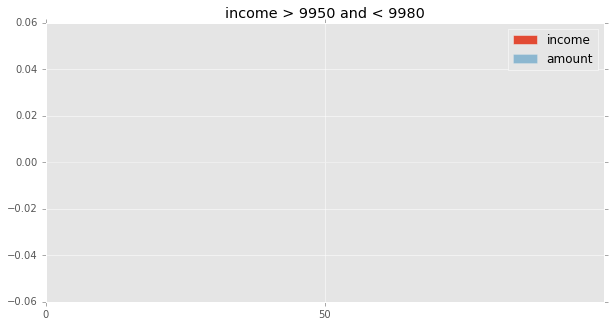

In [6]:
#Cycle over different income bins and plot loan amount distribution for each
#focus on finding the best bins
#repeat for different SQL selection filters (junior liens, non-owner-occupied, VA/FHA/RHS loans, manufactured housing)
bin_min = 0
bin_max = 20
bin_step = 30
pct_of_loans = OrderedDict({})
first = True
while bin_max < bank_df.income.max():
    graph_bin = bank_df[(bank_df.income >=bin_min) & (bank_df.income < bin_max)] #create bin of of amount for selected income
    #set descriptive stats
    bin_stats = OrderedDict({})
    bin_stats['name'] = str(bin_min) + ' to ' + str(bin_max)
    bin_stats['std']= graph_bin.amount.std()
    bin_stats['mean'] = graph_bin.amount.mean()
    bin_stats['median'] = graph_bin.amount.median()
    bin_stats['max_mult'] = graph_bin.mult.max()
    bin_stats['med_mult'] = graph_bin.mult.median()
    bin_stats['min_mult'] = graph_bin.mult.min()
    bin_stats['q98'] = graph_bin.amount.quantile(q=.98)
    bin_stats['q02'] = graph_bin.amount.quantile(q=.02)
    bin_stats['q75'] = graph_bin.amount.quantile(q=.75)
    bin_stats['q25'] = graph_bin.amount.quantile(q=.25)
    bin_stats['iqr'] = bin_stats['q75'] - bin_stats['q25']
    bin_stats['min_q'] = bin_stats['q25'] - 1.5 * bin_stats['iqr']
    bin_stats['max_q'] = bin_stats['q75'] + 1.5 * bin_stats['iqr']
    bin_stats['count of loans'] = graph_bin.amount.count()
    bin_stats['pct of total loans'] = (graph_bin.amount.count() / bank_df.income.count()) * 100

    #iterate over dataframe bin to remove outliers using IQR * 1.5
    count=1
    while True:
        #remove outliers
        start_max_q = bin_stats['max_q']
        graph_bin = graph_bin[(graph_bin.amount > bin_stats['min_q']) & (graph_bin.amount < bin_stats['max_q'])]
        print('\n\niteration {num}'.format(num=count))
        #reset bin stats to reflect IQR cutoffs
        bin_stats['std']= graph_bin.amount.std()
        bin_stats['mean'] = graph_bin.amount.mean()
        bin_stats['median'] = graph_bin.amount.median()
        bin_stats['max_mult'] = graph_bin.mult.max()
        bin_stats['med_mult'] = graph_bin.mult.median()
        bin_stats['min_mult'] = graph_bin.mult.min()
        bin_stats['q98'] = graph_bin.amount.quantile(q=.98)
        bin_stats['q02'] = graph_bin.amount.quantile(q=.02)
        bin_stats['q75'] = graph_bin.amount.quantile(q=.75)
        bin_stats['q25'] = graph_bin.amount.quantile(q=.25)
        bin_stats['iqr'] = bin_stats['q75'] - bin_stats['q25']
        bin_stats['min_q'] = bin_stats['q25'] - 1.5 * bin_stats['iqr']
        bin_stats['max_q'] = bin_stats['q75'] + 1.5 * bin_stats['iqr']

        count+=1
        for key, value in bin_stats.items(): #print descriptive stats
            print(key,value)
        
        if start_max_q == bin_stats['max_q'] or count > 10:
            break
            
    if first: 
        first = False
        bin_df = pd.DataFrame(bin_stats, index=range(1)) #instantiate initial dataframe
    else:
        concat_df = pd.DataFrame(bin_stats, index=range(1)) #instantiate subsequent dataframe 
        bin_df = pd.concat([bin_df, concat_df], axis=0) #concatenate dataframes each cycle
    

    
    amt = graph_bin.amount#.apply(sqrt)
    inc = graph_bin.income#.apply(sqrt) #square roots show much nicer distributions of amount to income
    xmin = 0 #set minimum x axis value
    xmax = 100 #set maximum x axis value
    xsteps= 1000 #set steps on x axis (bins)
    bins = np.linspace(xmin,xmax, xsteps)
    #print(bins)
    bin_viz = plt.figure(figsize=(10,5))
    plt.hist(inc, bins, label='income', alpha=1)
    plt.hist(amt, bins, label='amount', alpha=.5)
    plt.title('income > '+str(bin_min)+' and < '+str(bin_max))
    plt.legend(loc='upper right')
    plt.xticks(np.arange(xmin,xmax, 50))
    ax = plt.subplot()
    #ax.set_ylim(0, 2000)
    plt.show(bin_viz)
    bin_min=bin_max
    bin_max += bin_step
    pct_of_loans[bin_max] = bin_stats['pct of total loans']
    
path = '../linked_dist_stats/'
if not os.path.exists(path):
    os.makedirs(path)
bin_df.to_csv(path+'IQR_{loanType}.csv'.format(loanType=loanType))

In [7]:

bin_df.reset_index(inplace=True, drop=True) #set an integer index instead of index passed at creation
bin_df.head(20)

name         std        mean  median    max_mult   med_mult  \
0      0 to 20   89.686814  133.020328   118.0  380.000000  11.133333   
1     20 to 50  117.072071  182.886570   171.0   26.250000   4.964286   
2     50 to 80  147.965681  243.554403   235.0   13.920000   3.647887   
3    80 to 110  176.082254  302.404577   295.0   10.625000   3.118812   
4   110 to 140  198.651180  352.567088   343.0    8.909091   2.756098   
5   140 to 170  216.206711  394.369840   379.0    7.517730   2.455782   
6   170 to 200  230.494503  431.595320   409.0    6.588235   2.225806   
7   200 to 230  245.902600  469.390218   446.0    5.940000   2.080569   
8   230 to 260  264.161715  506.885099   485.0    5.513043   1.987234   
9   260 to 290  283.127717  542.731545   519.0    5.153846   1.894077   
10  290 to 320  314.427797  587.130991   556.0    5.044828   1.834416   
11  320 to 350  339.343697  626.835782   592.0    4.953125   1.772308   
12  350 to 380  363.830014  654.753128   613.0    4.825714   1.687328   
13  380 to 410  386.851890  686.328019   635.0    4.694737   1.610256   
14  410 to 440  416.632889  728.680906   673.0    4.614634   1.585714   
15  440 to 470  428.700445  744.273204   686.0    4.318182   1.511777   
16  470 to 500  469.873442  785.687732   709.0    4.468085   1.467230   
17  500 to 530  490.119587  815.166159   730.0    4.400000   1.427203   
18  530 to 560  519.733182  844.413133   750.0    4.450094   1.373407   
19  560 to 590  538.263333  876.994983   780.0    4.359431   1.357143   

    min_mult      q98    q02     q75    q25    iqr  min_q   max_q  \
0   0.052632   349.00    7.0   189.0   61.0  128.0 -131.0   381.0   
1   0.020408   450.82    8.0   263.0   87.0  176.0 -177.0   527.0   
2   0.012658   570.00   14.0   351.0  120.0  231.0 -226.5   697.5   
3   0.009174   662.00   24.0   436.0  154.0  282.0 -269.0   859.0   
4   0.007194   753.00   35.0   504.0  186.0  318.0 -291.0   981.0   
5   0.005917   860.00   50.0   554.0  216.0  338.0 -291.0  1061.0   
6   0.005025   948.00   63.0   596.0  246.0  350.0 -279.0  1121.0   
7   0.004425  1000.00   75.0   640.0  274.0  366.0 -275.0  1189.0   
8   0.003953  1106.24   84.0   686.0  297.0  389.0 -286.5  1269.5   
9   0.003534  1200.00   94.0   728.0  319.0  409.0 -294.5  1341.5   
10  0.003247  1320.00   97.0   789.0  337.0  452.0 -341.0  1467.0   
11  0.002907  1425.00  101.0   848.0  356.0  492.0 -382.0  1586.0   
12  0.002688  1496.00  100.0   893.0  361.0  532.0 -437.0  1691.0   
13  0.002500  1580.00  102.0   939.0  375.0  564.0 -471.0  1785.0   
14  0.002315  1700.00  102.0   994.0  393.0  601.0 -508.5  1895.5   
15  0.002268  1732.00  101.0  1000.0  396.0  604.0 -510.0  1906.0   
16  0.002033  1910.00  100.0  1088.0  404.0  684.0 -622.0  2114.0   
17  0.001961  1980.00  107.0  1130.0  415.0  715.0 -657.5  2202.5   
18  0.017921  2030.94  104.0  1196.0  417.0  779.0 -751.5  2364.5   
19  0.005208  2125.28  104.0  1240.0  420.0  820.0 -810.0  2470.0   

    count of loans  pct of total loans  
0            46101            1.998800  
1           115479            5.006820  
2           154011            6.677451  
3           186685            8.094097  
4           208324            9.032298  
5           215154            9.328426  
6           206571            8.956294  
7           185926            8.061189  
8           154381            6.693493  
9           124780            5.410083  
10          101125            4.384474  
11           80861            3.505888  
12           69671            3.020724  
13           56112            2.432847  
14           45579            1.976168  
15           38168            1.654849  
16           32368            1.403379  
17           29552            1.281285  
18           23776            1.030855  
19           19260            0.835055

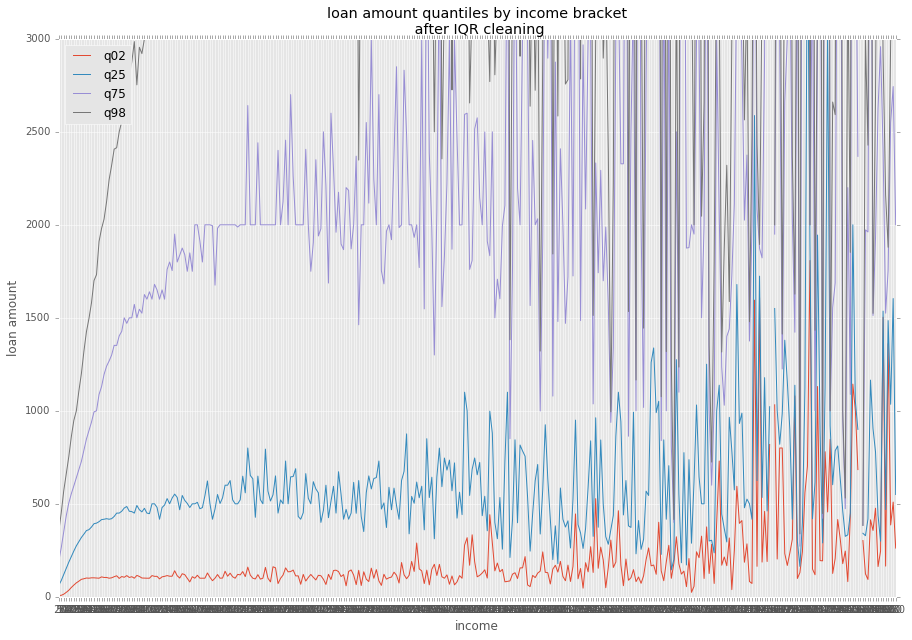

In [8]:
fig = plt.figure(figsize=(15,10))
xticks=[x[-3:] for x in bin_df.name] #get xtick names as list
ax = plt.subplot()
x = range(len(bin_df.name))
plt.xticks(x,xticks) #set xtick names


y = bin_df.q02
y1 = bin_df.q25
y2 = bin_df.q75
y3 = bin_df.q98
plt.plot(x,y, label='q02')
plt.plot(x,y1, label='q25')
plt.plot(x,y2, label='q75')
plt.plot(x,y3, label='q98')
ax=plt.subplot()
ax.set_ylim(0,3000)
plt.ylabel('loan amount')
plt.xlabel('income')
plt.legend(loc='upper left') #turn on legend and set location
plt.title('loan amount quantiles by income bracket\n after IQR cleaning')
plt.show(fig)